# XGBR Predictions

### NoteBook Features:
1. This NoteBook is for Multi Timestamps Ahead CPU Usage Prediction for Bitbrain Dataset
2. It makes predictions for heterogeneous VMs
3. XBGR can be Hyper Parameter Tuned

In [45]:
# Importing required libraries and setting the directory path
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib

%matplotlib inline

july = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-7/')
august = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-8/')
septempber = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-9/')

In [9]:
def df_processing(df):

    df.columns = df.columns.str.replace('\t', '')

    df.insert(0, "DateTime", df['Timestamp [ms]'].apply(lambda x: datetime.datetime.fromtimestamp(x).replace(second=0, microsecond=0)))
    df = df.drop(columns=['Timestamp [ms]'])
    df.set_index('DateTime', inplace=True)
    df = df.sort_index()
    df = df.resample('5min').ffill()
    return df

df2_july = pd.read_csv(os.path.join(july, '383.csv'), sep=';')
df2_aug = pd.read_csv(os.path.join(august, '383.csv'), sep=';')
df2_sep = pd.read_csv(os.path.join(septempber, '383.csv'), sep=';')

df4_july = pd.read_csv(os.path.join(july, '392.csv'), sep=';')
df4_aug = pd.read_csv(os.path.join(august, '392.csv'), sep=';')
df4_sep = pd.read_csv(os.path.join(septempber, '392.csv'), sep=';')

df6_july = pd.read_csv(os.path.join(july, '386.csv'), sep=';')
df6_aug = pd.read_csv(os.path.join(august, '386.csv'), sep=';')
df6_sep = pd.read_csv(os.path.join(septempber, '386.csv'), sep=';')

dfs2_list = [df2_july, df2_aug, df2_sep]
dfs4_list = [df4_july, df4_aug, df4_sep]
dfs6_list = [df6_july, df6_aug, df6_sep]

dfs2 = [df_processing(df) for df in dfs2_list]
dfs4 = [df_processing(df) for df in dfs4_list]
dfs6 = [df_processing(df) for df in dfs6_list]

df2 = pd.concat(dfs2)
df2 = df2.bfill()
df4 = pd.concat(dfs4)
df4 = df4.bfill()
df6 = pd.concat(dfs6)
df6 = df6.bfill()

In [10]:
def fill_missing(df, start, end):
    df.reset_index(inplace=True)

    # Identify the previous day's period for replication
    previous_day_start = start - pd.DateOffset(days=1)
    previous_day_end = end - pd.DateOffset(days=1)

    # Filter the DataFrame to get the previous day's data
    previous_day_data = df[(df['DateTime'] >= previous_day_start) & (df['DateTime'] <= previous_day_end)]

    # Generate new timestamps for the missing period
    missing_period_timestamps = pd.date_range(start=start, end=end, freq='5min')

    # Replicate the previous day's data to the missing period
    replicated_data = previous_day_data.copy()
    replicated_data['DateTime'] = missing_period_timestamps[:len(previous_day_data)]

    # Concatenate the replicated data with the original DataFrame
    df_filled = pd.concat([df, replicated_data]).sort_values(by='DateTime').reset_index(drop=True)
    df_filled.set_index('DateTime', inplace=True)

    return df_filled

start_july = pd.to_datetime('2013-07-30 23:00:00')
end_july = pd.to_datetime('2013-07-31 23:00:00')
start_aug = pd.to_datetime('2013-08-30 23:00:00')
end_aug = pd.to_datetime('2013-08-31 23:00:00')
df2 = fill_missing(df2, start_july, end_july)
df2 = fill_missing(df2, start_aug, end_aug)
df4 = fill_missing(df4, start_july, end_july)
df4 = fill_missing(df4, start_aug, end_aug)
df6 = fill_missing(df6, start_july, end_july)
df6 = fill_missing(df6, start_aug, end_aug)

df_list = [df2, df4, df6]
merged_df = pd.concat(df_list)

In [11]:
# merged_df = merged_df.sort_index()
# df = merged_df
# df = df[['CPU cores', 'CPU usage [%]']]
# df = df[df.index > '2013-06-30 23:55:00']
# df.reset_index(inplace=True)
# df.sort_values(by=['DateTime', 'CPU cores'], inplace=True)
# df.rename(columns={"CPU cores": "unique_id", "DateTime": "ds", "CPU usage [%]": "y"}, inplace=True)
# df.head(12)


#merged_df = merged_df.sort_index()
#df = merged_df
def df_final_processing(df): 
    df = df[['CPU usage [%]']]
    df = df[df.index > '2013-06-30 23:55:00']
    df.sort_index(inplace=True)
    df.reset_index(inplace=True)
    #df.sort_values(by=['DateTime', 'CPU cores'], inplace=True)
    df.rename(columns={"CPU cores": "unique_id", "DateTime": "ds", "CPU usage [%]": "y"}, inplace=True)

    return df

df2 = df_final_processing(df2)
df4 = df_final_processing(df4)
df6 = df_final_processing(df6)
df2.head(12)

ds          y
0  2013-07-01 00:00:00  17.300000
1  2013-07-01 00:05:00  20.600000
2  2013-07-01 00:10:00  17.566667
3  2013-07-01 00:15:00  18.233333
4  2013-07-01 00:20:00  17.366667
5  2013-07-01 00:25:00  17.866667
6  2013-07-01 00:30:00  17.633333
7  2013-07-01 00:35:00  18.533333
8  2013-07-01 00:40:00  17.900000
9  2013-07-01 00:45:00  19.100000
10 2013-07-01 00:50:00  18.733333
11 2013-07-01 00:55:00  18.600000

In [12]:
df6.tail()

ds          y
26191 2013-09-29 22:35:00  33.933333
26192 2013-09-29 22:40:00  44.500000
26193 2013-09-29 22:45:00  31.300000
26194 2013-09-29 22:50:00  42.000000
26195 2013-09-29 22:55:00  33.411111

# Data Processing for XGB Regressor

In [13]:
def feature_eng(df):
    # Feature Engineering
    #df['year'] = df0['DateTime'].dt.year
    
    df['month'] = df['ds'].dt.month
    df['day'] = df['ds'].dt.day
    df['hour'] = df['ds'].dt.hour
    df['minute'] = df['ds'].dt.minute
    df['dayofweek'] = df['ds'].dt.dayofweek

    # Drop the original DateTime column
    df.drop(columns=['ds'], inplace=True)
    return df

#df = feature_eng(df)
df2 = feature_eng(df2)
df4 = feature_eng(df4)
df6 = feature_eng(df6)

In [14]:
df2

y  month  day  hour  minute  dayofweek
0      17.300000      7    1     0       0          0
1      20.600000      7    1     0       5          0
2      17.566667      7    1     0      10          0
3      18.233333      7    1     0      15          0
4      17.366667      7    1     0      20          0
...          ...    ...  ...   ...     ...        ...
26191  39.600000      9   29    22      35          6
26192  20.800000      9   29    22      40          6
26193  22.500000      9   29    22      45          6
26194  21.566667      9   29    22      50          6
26195  19.500000      9   29    22      55          6

[26196 rows x 6 columns]

In [15]:
def normalize(df):
    result = df.copy()
    #for feature_name in df.columns[:-1]:
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
# df_norm = normalize(df)
# df_norm.head()

df2_norm= normalize(df2)
df4_norm= normalize(df4)
df6_norm= normalize(df6)
df2_norm.head()

y  month  day  hour    minute  dayofweek
0  0.047978    0.0  0.0   0.0  0.000000        0.0
1  0.087232    0.0  0.0   0.0  0.090909        0.0
2  0.051150    0.0  0.0   0.0  0.181818        0.0
3  0.059080    0.0  0.0   0.0  0.272727        0.0
4  0.048771    0.0  0.0   0.0  0.363636        0.0

In [17]:
df2_norm.tail()

y  month       day      hour    minute  dayofweek
26191  0.313243    1.0  0.933333  0.956522  0.636364        1.0
26192  0.089611    1.0  0.933333  0.956522  0.727273        1.0
26193  0.109833    1.0  0.933333  0.956522  0.818182        1.0
26194  0.098731    1.0  0.933333  0.956522  0.909091        1.0
26195  0.074148    1.0  0.933333  0.956522  1.000000        1.0

# Multi Step Future Prediction

In [18]:
def create_features_targets(df, lags=48, steps=6):
    df_new = df.copy()
    # Create lag features
    for i in range(1, lags + 1):
        df_new[f'lag_{i}'] = df_new['y'].shift(i)
    
    # Create targets for multi-step forecasting
    for i in range(1, steps + 1):
        df_new[f'target_{i}'] = df_new['y'].shift(-i)
    
    df_new.dropna(inplace=True)
    return df_new

# df_norm = create_features_targets(df_norm)
# df_norm

df2_norm = create_features_targets(df2_norm)
df4_norm = create_features_targets(df4_norm)
df6_norm = create_features_targets(df6_norm)
df2_norm.shape, df4_norm.shape, df6_norm.shape

((26142, 60), (26142, 60), (26142, 60))

In [12]:
df2_norm.tail()

y  month       day      hour    minute  dayofweek     lag_1  \
26185  0.418319    1.0  0.933333  0.956522  0.090909        1.0  0.344171   
26186  0.371134    1.0  0.933333  0.956522  0.181818        1.0  0.418319   
26187  0.350912    1.0  0.933333  0.956522  0.272727        1.0  0.371134   
26188  0.313640    1.0  0.933333  0.956522  0.363636        1.0  0.350912   
26189  0.268834    1.0  0.933333  0.956522  0.454545        1.0  0.313640   

          lag_2     lag_3     lag_4  ...    lag_45    lag_46    lag_47  \
26185  0.336241  0.329897  0.340206  ...  0.058684  0.046788  0.065821   
26186  0.344171  0.336241  0.329897  ...  0.429818  0.058684  0.046788   
26187  0.418319  0.344171  0.336241  ...  0.067803  0.429818  0.058684   
26188  0.371134  0.418319  0.344171  ...  0.074941  0.067803  0.429818   
26189  0.350912  0.371134  0.418319  ...  0.068993  0.074941  0.067803   

         lag_48  target_1  target_2  target_3  target_4  target_5  target_6  
26185  0.202872  0.371134  0.350912  0.313640  0.268834  0.333466  0.313243  
26186  0.065821  0.350912  0.313640  0.268834  0.333466  0.313243  0.089611  
26187  0.046788  0.313640  0.268834  0.333466  0.313243  0.089611  0.109833  
26188  0.058684  0.268834  0.333466  0.313243  0.089611  0.109833  0.098731  
26189  0.429818  0.333466  0.313243  0.089611  0.109833  0.098731  0.074148  

[5 rows x 60 columns]

### Data Processing for Multi Step Ahead Prediction

In [19]:
# # Split the data into features (X) and targets (y)
# X = df_norm.drop(columns=['y'] + [f'target_{i}' for i in range(1, 19)])
# y = df_norm[[f'target_{i}' for i in range(1, 19)]]

# Splitting into train and test sets
def train_test_split_df(df, forecast_horizon=6):
    X = df.drop(['y'] + [f'target_{i}' for i in range(1, forecast_horizon + 1)], axis=1)
    y = df[[f'target_{i}' for i in range(1, forecast_horizon + 1)]]
    X.sort_index(inplace=True)

    return train_test_split(X, y, test_size=0.1, shuffle=False)

X2_train, X2_test, y2_train, y2_test = train_test_split_df(df2_norm)
X4_train, X4_test, y4_train, y4_test = train_test_split_df(df4_norm)
X6_train, X6_test, y6_train, y6_test = train_test_split_df(df6_norm)

In [21]:
X2_train

month       day      hour    minute  dayofweek     lag_1     lag_2  \
48       0.0  0.000000  0.173913  0.000000   0.000000  0.057494  0.060666   
49       0.0  0.000000  0.173913  0.090909   0.000000  0.044806  0.057494   
50       0.0  0.000000  0.173913  0.181818   0.000000  0.064631  0.044806   
51       0.0  0.000000  0.173913  0.272727   0.000000  0.050357  0.064631   
52       0.0  0.000000  0.173913  0.363636   0.000000  0.055908  0.050357   
...      ...       ...       ...       ...        ...       ...       ...   
23570    1.0  0.633333  0.869565  0.181818   0.666667  0.338224  0.327914   
23571    1.0  0.633333  0.869565  0.272727   0.666667  0.204996  0.338224   
23572    1.0  0.633333  0.869565  0.363636   0.666667  0.054322  0.204996   
23573    1.0  0.633333  0.869565  0.454545   0.666667  0.057494  0.054322   
23574    1.0  0.633333  0.869565  0.545455   0.666667  0.054322  0.057494   

          lag_3     lag_4     lag_5  ...    lag_39    lag_40    lag_41  \
48     0.057891  0.051546  0.058684  ...  0.069389  0.055115  0.062649   
49     0.060666  0.057891  0.051546  ...  0.065028  0.069389  0.055115   
50     0.057494  0.060666  0.057891  ...  0.063442  0.065028  0.069389   
51     0.044806  0.057494  0.060666  ...  0.056305  0.063442  0.065028   
52     0.064631  0.044806  0.057494  ...  0.056701  0.056305  0.063442   
...         ...       ...       ...  ...       ...       ...       ...   
23570  0.303727  0.302538  0.305710  ...  0.229183  0.184774  0.107454   
23571  0.327914  0.303727  0.302538  ...  0.259715  0.229183  0.184774   
23572  0.338224  0.327914  0.303727  ...  0.268834  0.259715  0.229183   
23573  0.204996  0.338224  0.327914  ...  0.264076  0.268834  0.259715   
23574  0.054322  0.204996  0.338224  ...  0.262490  0.264076  0.268834   

         lag_42    lag_43    lag_44    lag_45    lag_46    lag_47    lag_48  
48     0.051943  0.054718  0.048771  0.059080  0.051150  0.087232  0.047978  
49     0.062649  0.051943  0.054718  0.048771  0.059080  0.051150  0.087232  
50     0.055115  0.062649  0.051943  0.054718  0.048771  0.059080  0.051150  
51     0.069389  0.055115  0.062649  0.051943  0.054718  0.048771  0.059080  
52     0.065028  0.069389  0.055115  0.062649  0.051943  0.054718  0.048771  
...         ...       ...       ...       ...       ...       ...       ...  
23570  0.268041  0.272403  0.250991  0.251388  0.237510  0.078509  0.066614  
23571  0.107454  0.268041  0.272403  0.250991  0.251388  0.237510  0.078509  
23572  0.184774  0.107454  0.268041  0.272403  0.250991  0.251388  0.237510  
23573  0.229183  0.184774  0.107454  0.268041  0.272403  0.250991  0.251388  
23574  0.259715  0.229183  0.184774  0.107454  0.268041  0.272403  0.250991  

[23527 rows x 53 columns]

In [22]:
y2_train

target_1  target_2  target_3  target_4  target_5  target_6
48     0.064631  0.050357  0.055908  0.045995  0.064235  0.050357
49     0.050357  0.055908  0.045995  0.064235  0.050357  0.055511
50     0.055908  0.045995  0.064235  0.050357  0.055511  0.045202
51     0.045995  0.064235  0.050357  0.055511  0.045202  0.055115
52     0.064235  0.050357  0.055511  0.045202  0.055115  0.062649
...         ...       ...       ...       ...       ...       ...
23570  0.054322  0.057494  0.054322  0.143933  0.288660  0.295797
23571  0.057494  0.054322  0.143933  0.288660  0.295797  0.279540
23572  0.054322  0.143933  0.288660  0.295797  0.279540  0.236320
23573  0.143933  0.288660  0.295797  0.279540  0.236320  0.217684
23574  0.288660  0.295797  0.279540  0.236320  0.217684  0.167724

[23527 rows x 6 columns]

In [51]:
# Split the data into training, validation, and test sets
# train_split = int(len(df) * 0.8)
# val_split = int((len(df) - train_split) / 2) + train_split

# X_train, X_val, X_test = X.iloc[:train_split], X.iloc[train_split:val_split], X.iloc[25000:27500]
# y_train, y_val, y_test = y.iloc[:train_split], y.iloc[train_split:val_split], y.iloc[25000:27500]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
# X_train.shape, X_test.shape, y_test.shape

((70583, 150), (7843, 150), (7843, 18))

## Hybrid RF- XGBR 

In [23]:
# Initialize the models
rf_model2 = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42))
rf_model4 = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42))
rf_model6 = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42))

# Fit the models
rf_model2.fit(X2_train, y2_train)
rf_model4.fit(X4_train, y4_train)
rf_model6.fit(X6_train, y6_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=5,
                                                     random_state=42))

In [24]:
#xgb_model.fit(X_train, y_train)

xgb_model2 = MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42, max_depth=5))
xgb_model4 = MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42, max_depth=5))
xgb_model6 = MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42, max_depth=5))

xgb_model2.fit(X2_train, y2_train)
xgb_model4.fit(X4_train, y4_train)
xgb_model6.fit(X6_train, y6_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

## Hyper Parameter Tuning of XGBR

## Evaluation of Model

### Load a trained one OR Use Fresh Tuned One

In [ ]:
# Load the model from a file
with open('models/hrf_xgbr/xbgr_v4.pkl', 'rb') as file:
    xgbr_model = pickle.load(file)

In [33]:
# def calculate_mae(predictions, actuals):
#     mae = mean_absolute_error(actuals, predictions)
#     return mae

# def calculate_rmse(predictions, actuals):
#     rmse = np.sqrt(mean_squared_error(actuals, predictions))
#     return rmse

# def denormalize(predictions, actuals, c_max, c_min):
#     denorm_predictions = predictions * (c_max - c_min) + c_min
#     denorm_actuals = actuals * (c_max - c_min) + c_min
#     return denorm_predictions, denorm_actuals

# def plot_predictions(model_xgb, model_rf, X, y, c_max, c_min, tstart=0, tend=500):
    
#     xgb_pred = model_xgb.predict(X)
#     rf_pred = model_rf.predict(X)
#     predictions = (rf_pred + xgb_pred) / 2 
    
#     # Initialize an empty list to store RMSE values for each sequence
#     rmse_values = []
#     denorm_rmse_values = []
    
#     for i in range(predictions.shape[0]):
#         seq_pred = predictions[i]
#         seq_actual = y[i]
        
#         # Calculate RMSE for this sequence
#         rmse = calculate_rmse(seq_pred, seq_actual)
#         rmse_values.append(rmse)
        
#         # De-normalize the predictions and actuals
#         denorm_pred, denorm_actual = denormalize(seq_pred, seq_actual, c_max, c_min)
        
#         # Calculate RMSE for de-normalized data
#         denorm_rmse = calculate_rmse(denorm_pred, denorm_actual)
#         denorm_rmse_values.append(denorm_rmse)
    
#     # Calculate overall RMSE
#     overall_rmse = np.mean(rmse_values)
#     overall_denorm_rmse = np.mean(denorm_rmse_values)


#     #Create a DataFrame for plotting purposes
#     # this following set is flattening the predictions and concatenating it. Means (2585,6) flatten is 15510
#     test_results_flatten_norm = pd.DataFrame({
#         'CPU Predictions': predictions.flatten(),
#         'CPU Actuals': y.flatten()
#     })

#     test_results_norm = pd.DataFrame({
#         'CPU Predictions': predictions[:, 0],
#         'CPU Actuals': y[:,0]
#     })

#     dfnorm_pred_all, denorm_actuall_all = denormalize(predictions[:, 0], y[:,0], c_max, c_min)

#     test_results_non_norm = pd.DataFrame({
#         'CPU Predictions': dfnorm_pred_all,
#         'CPU Actuals': denorm_actuall_all
#     })
    
#     return test_results_flatten_norm[tstart:tend],test_results_norm[tstart:tend], test_results_non_norm[tstart:tend], rmse_values, overall_rmse, denorm_rmse_values, overall_denorm_rmse

In [35]:
y2_test

target_1  target_2  target_3  target_4  target_5  target_6
23575  0.295797  0.279540  0.236320  0.217684  0.167724  0.197066
23576  0.279540  0.236320  0.217684  0.167724  0.197066  0.053132
23577  0.236320  0.217684  0.167724  0.197066  0.053132  0.104679
23578  0.217684  0.167724  0.197066  0.053132  0.104679  0.163362
23579  0.167724  0.197066  0.053132  0.104679  0.163362  0.063838
...         ...       ...       ...       ...       ...       ...
26185  0.371134  0.350912  0.313640  0.268834  0.333466  0.313243
26186  0.350912  0.313640  0.268834  0.333466  0.313243  0.089611
26187  0.313640  0.268834  0.333466  0.313243  0.089611  0.109833
26188  0.268834  0.333466  0.313243  0.089611  0.109833  0.098731
26189  0.333466  0.313243  0.089611  0.109833  0.098731  0.074148

[2615 rows x 6 columns]

In [36]:
# c_max = df2['y'].max()
# c_min = df2['y'].min()
# # y_test is a dataframe while the model requires Numpy array
# y_testnp = y2_test.to_numpy()

# flatten_norm_result, norm_result, denorm_result, norm_rmse, overall_norm_rmse, denorm_rmse, overall_denorm_rmse = plot_predictions(xgb_model2, rf_model2, X2_test, y_testnp, c_max, c_min, tstart=0, tend=15000)

In [37]:
# c_max = df4['y'].max()
# c_min = df4['y'].min()
# # y_test is a dataframe while the model requires Numpy array
# y_testnp = y4_test.to_numpy()

# flatten_norm_result4, norm_result4, denorm_result4, norm_rmse4, overall_norm_rmse4, denorm_rmse4, overall_denorm_rmse4 = plot_predictions(xgb_model4, rf_model4, X4_test, y_testnp, c_max, c_min, tstart=0, tend=15000)

In [38]:
# c_max = df6['y'].max()
# c_min = df6['y'].min()
# # y_test is a dataframe while the model requires Numpy array
# y_testnp = y6_test.to_numpy()

# flatten_norm_result6, norm_result6, denorm_result6, norm_rmse6, overall_norm_rmse6, denorm_rmse6, overall_denorm_rmse6 = plot_predictions(xgb_model6, rf_model6, X6_test, y_testnp, c_max, c_min, tstart=0, tend=15000)

In [48]:
inf_time = []
for i in range(1000):
    b_time = time.time()
    row = X_test.iloc[i]
    row_reshape = row.values.reshape(1, -1)
    xgb_model.predict(row_reshape)
    single_inf_time = time.time() - b_time
    inf_time.append(single_inf_time)

NameError: name 'xgbr_model' is not defined

In [ ]:
mili_inf = [x * 1000 for x in inf_time]

mean_infer_time = sum(mili_inf) / len(mili_inf)
mean_infer_time

1.760673999786377

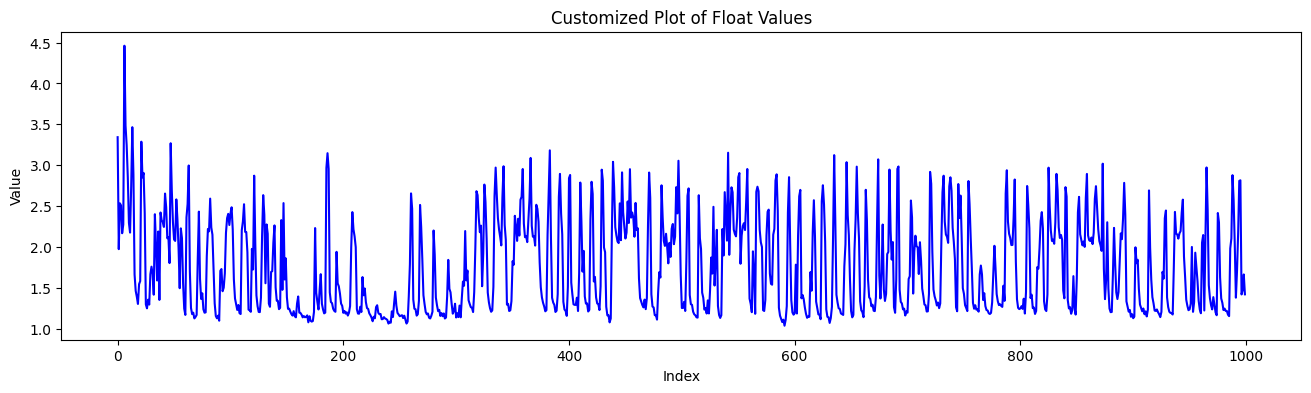

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(mili_inf, linestyle='-', color='b')
# Adding title and labels
plt.title('Customized Plot of Float Values')
plt.xlabel('Index')
plt.ylabel('Value')

# Displaying the plot
plt.show()

In [ ]:
with open('my_list.pkl', 'wb') as f:
    pickle.dump(mili_inf, f)

In [52]:
rmse_test = calculate_rmse(denorm_result['CPU Predictions'], denorm_result['CPU Actuals'])
rmse_test

8.778209894590718

Text(0.5, 0, '5 Minutes Sliced Time Intervals')

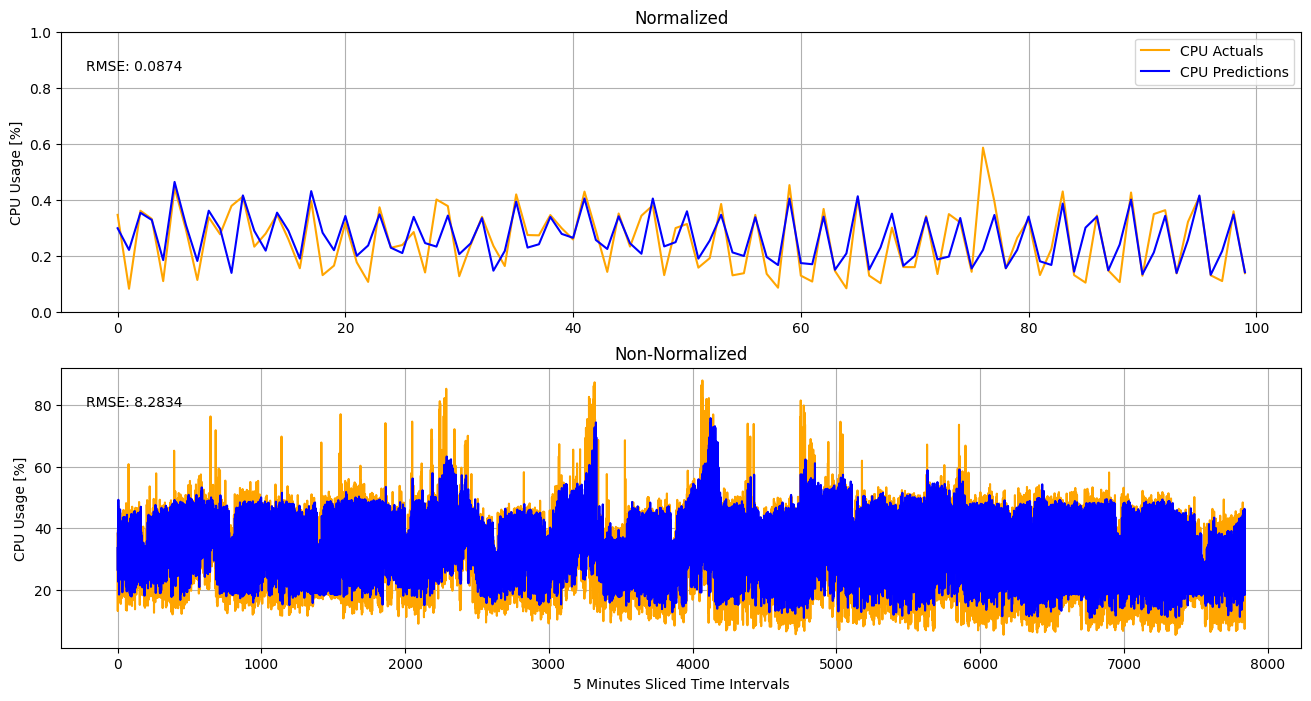

In [67]:
fig, (ax1, ax2) = plt.subplots(figsize=(16,8), nrows=2, ncols=1)

ax1.plot(norm_result.index[:100], norm_result['CPU Actuals'][:100], label='CPU Actuals', color='orange')
ax1.plot(norm_result.index[:100], norm_result['CPU Predictions'][:100], label='CPU Predictions', color='blue')
ax1.set_title('Normalized')
ax1.grid()
ax1.set_ylim([0,1])
ax1.set_ylabel('CPU Usage [%]')
ax1.text(0.02, 0.9, f'RMSE: {overall_norm_rmse:.4f}', transform=ax1.transAxes, fontsize=10, verticalalignment='top')
ax1.legend(loc='upper right')

ax2.plot(denorm_result.index[:], denorm_result['CPU Actuals'][:], label='CPU Actuals', color='orange')
ax2.plot(denorm_result.index[:], denorm_result['CPU Predictions'][:], label='CPU Predictions', color='blue')
ax2.set_title('Non-Normalized')
ax2.grid()
#ax2.set_ylim([0,100])
ax2.set_ylabel('CPU Usage [%]')
ax2.text(0.02, 0.9, f'RMSE: {overall_denorm_rmse:.4f}', transform=ax2.transAxes, fontsize=10, verticalalignment='top')
#ax2.legend(loc='upper right')

plt.xlabel('5 Minutes Sliced Time Intervals')
#plt.title('CPU Predictions and Actuals Comprison of Fast Storage')

In [68]:
denorm_result

CPU Predictions  CPU Actuals
0           33.605214    38.133333
1           26.265567    13.133333
2           38.841265    39.522222
3           36.404587    36.766667
4           22.813285    15.716667
...               ...          ...
7838        38.197035    44.411111
7839        46.355579    35.866667
7840        18.329619     7.316667
7841        35.843786    36.577778
7842        37.400143    41.300000

[7843 rows x 2 columns]

In [ ]:
denorm_result.to_pickle('model0/xgbr_denorm_result.pkl')

In [ ]:
# best_model.save_model('model0/xgbr_multi.json')

# Save the model to a file
with open('model0/xbgr_v4.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [ ]:
# Load the model from a file
with open('multioutput_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
date = pd.to_datetime('2013-09-11 14:35:00')
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(12,6), sharex=True)

ax1.plot(df2.index[:], df2['cpu_real'][:], label='Real Data')
ax1.plot(df2.index[:], df2['PatchTST'][:], label='TimesFM')
#ax1.plot(df2.index, df2['bi_lstm'], label='Bi-LSTM')
#ax1.plot(df2.index, df2['lstm'], label='LSTM')
#ax1.set_xlabel('Time')
ax1.set_ylabel('CPU Usage [%]')
ax1.set_ylim([0,100])
ax1.grid()
ax1.set_title('2 Core')
ax1.legend(loc='lower left')

ax2.plot(df4.index[:], df4['cpu_real'][:], label='Real Data')
ax2.plot(df4.index[:], df4['PatchTST'][:], label='TimesFM')
#ax2.plot(df4.index[210:300], df4['bi_lstm'][210:300], label='Bi-LSTM')
#ax2.plot(df4.index[210:300], df4['lstm'][210:300], label='LSTM')

#ax2.set_xlabel('Time')
ax2.set_ylabel('CPU Usage [%]')
ax2.grid()
ax2.set_ylim([0,100])
ax2.set_title('4 Core')
ax2.legend(loc='upper left')

ax3.plot(df6.index[:], df6['cpu_real'][:], label='Real Data')
ax3.plot(df6.index[:], df6['PatchTST'][:], label='TimesFM')
#ax3.plot(df6.index[210:300], df6['bi_lstm'][210:300], label='Bi-LSTM')
#ax3.plot(df6.index[210:300], df6['lstm'][210:300], label='LSTM')

ax3.set_xlabel('Time')
ax3.set_ylabel('CPU Usage [%]')
ax3.grid()
ax3.set_ylim([0,100])
ax3.set_title('6 Core')
ax3.legend(loc='lower left')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.setp(ax3.get_xticklabels(), rotation=30, ha='right')
#plt.savefig('models_bi_lstm_times.pdf', format='pdf')
plt.show()

In [38]:
def reassemble_datetime(df, df_norm):
    result = df_norm.copy()

    features = ['month', 'day', 'hour', 'minute']

    for feature_name in features:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = df_norm[feature_name] * (max_value - min_value) + min_value

    result['year'] = 2013
    result['DateTime'] = pd.to_datetime(result[['year', 'month', 'day', 'hour', 'minute']])
    #result.drop(columns=['year', 'month', 'day', 'hour', 'minute'], inplace=True)
    result = result[['DateTime']]
    return result

def denormalize(predictions, actuals, c_max, c_min, shape):
    denorm_predictions = predictions * (c_max - c_min) + c_min
    denorm_actuals = actuals * (c_max - c_min) + c_min
    denorm_predictions, denorm_actuals = denorm_predictions.reshape(predictions.shape[1], 1), denorm_actuals.reshape(actuals.shape[0] ,1)
    return denorm_predictions[:shape], denorm_actuals[:shape]

def plot_predictions(xgb_model, rf_model, X, y, df, tstart=0, tend=500):

    c_max = df['y'].max()
    c_min = df['y'].min()
    post_process_dfs = []

    for i in range(0, X.shape[0], 6):
        row = X.iloc[i]
        row_reshape = row.values.reshape(1, -1)
        seq_pred_xgb = xgb_model.predict(row_reshape)
        seq_pred_rf = rf_model.predict(row_reshape)
        seq_pred = (seq_pred_xgb + seq_pred_rf) / 2
        seq_actual = y[i]
        datetime_df = reassemble_datetime(df, X[i:i+6])
        denorm_pred, denorm_actual = denormalize(seq_pred, seq_actual, c_max, c_min, datetime_df.shape[0])
        datetime_df['XBGR_pred'] = denorm_pred
        datetime_df['cpu_real'] = denorm_actual
        post_process_dfs.append(datetime_df)

    post_process_dfs = pd.concat(post_process_dfs)
    post_process_dfs.set_index('DateTime', inplace=True)
    post_process_dfs.sort_index(inplace=True)
    return post_process_dfs

y6_testnp = y6_test.to_numpy()
post_df6 = plot_predictions(xgb_model6, rf_model6, X6_test, y6_testnp, df6, tstart=0, tend=15000)
y4_testnp = y4_test.to_numpy()
post_df4 = plot_predictions(xgb_model4, rf_model4, X4_test, y4_testnp, df4, tstart=0, tend=15000)
y2_testnp = y2_test.to_numpy()
post_df2 = plot_predictions(xgb_model2, rf_model2, X2_test, y2_testnp, df2, tstart=0, tend=15000)

/home/babarali/miniconda3/envs/bitbrain/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/babarali/miniconda3/envs/bitbrain/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/babarali/miniconda3/envs/bitbrain/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/babarali/miniconda3/envs/bitbrain/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/babarali/miniconda3/envs/bitbrain/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but Rand

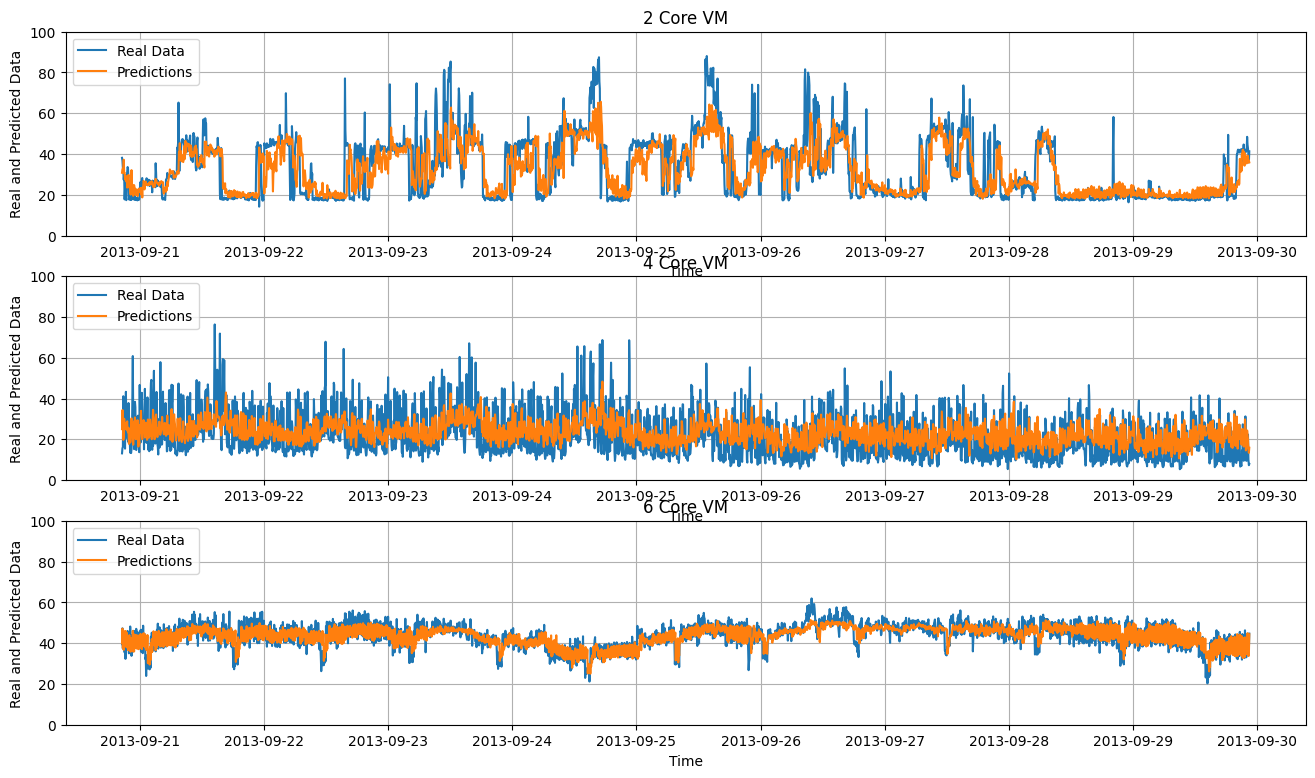

In [39]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=1, nrows=3, figsize=(16,9))

ax1.plot(post_df2.index[00:], post_df2['cpu_real'][00:], label='Real Data')
ax1.plot(post_df2.index[00:], post_df2['XBGR_pred'][00:], label='Predictions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Real and Predicted Data')
ax1.set_ylim([0,100])
ax1.grid()
ax1.set_title('2 Core VM')
ax1.legend(loc='upper left')

ax2.plot(post_df4.index[00:], post_df4['cpu_real'][00:], label='Real Data')
ax2.plot(post_df4.index[00:], post_df4['XBGR_pred'][00:], label='Predictions')
ax2.set_xlabel('Time')
ax2.set_ylabel('Real and Predicted Data')
ax2.grid()
ax2.set_ylim([0,100])
ax2.set_title('4 Core VM')
ax2.legend(loc='upper left')

ax3.plot(post_df6.index[00:], post_df6['cpu_real'][00:], label='Real Data')
ax3.plot(post_df6.index[00:], post_df6['XBGR_pred'][00:], label='Predictions')
ax3.set_xlabel('Time')
ax3.set_ylabel('Real and Predicted Data')
ax3.grid()
ax3.set_ylim([0,100])
ax3.set_title('6 Core VM')
ax3.legend(loc='upper left')

In [40]:
df_combined = pd.concat([post_df2, post_df4, post_df6])
df_combined.sort_index(inplace=True)
df_combined.head(10)

XBGR_pred   cpu_real
DateTime                                 
2013-09-20 20:35:00  30.809167  38.133333
2013-09-20 20:35:00  25.017865  13.133333
2013-09-20 20:35:00  40.008680  39.522222
2013-09-20 20:40:00  32.597773  36.766667
2013-09-20 20:40:00  34.404288  15.716667
2013-09-20 20:40:00  47.156337  47.288889
2013-09-20 20:45:00  32.759263  33.133333
2013-09-20 20:45:00  27.218178  16.100000
2013-09-20 20:45:00  37.713722  37.311111
2013-09-20 20:50:00  19.730314  41.166667

In [47]:
df_combined.shape

(7845, 2)

In [48]:
def calculate_rmse(predictions, actuals):
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse

rmse = calculate_rmse(df_combined['XBGR_pred'], df_combined['cpu_real'])
rmse

8.986024652303135

In [49]:
mean_absolute_error(df_combined['XBGR_pred'], df_combined['cpu_real'])

6.179562638054664

In [46]:
r2_score(df_combined['XBGR_pred'], df_combined['cpu_real'])

0.3530995688619617

In [58]:
inf_time2 = []
for i in range(146):
    b_time = time.time()
    row = X2_test.iloc[i]
    row_reshape = row.values.reshape(1, -1)
    xgb_pred = xgb_model2.predict(row_reshape)
    rf_pred = rf_model2.predict(row_reshape)
    seq_pred = (xgb_pred + rf_pred) / 2
    single_inf_time = time.time() - b_time
    inf_time2.append(single_inf_time)

inf_time4 = []
for i in range(146):
    b_time = time.time()
    row = X4_test.iloc[i]
    row_reshape = row.values.reshape(1, -1)
    xgb_pred = xgb_model4.predict(row_reshape)
    rf_pred = rf_model4.predict(row_reshape)
    seq_pred = (xgb_pred + rf_pred) / 2
    single_inf_time = time.time() - b_time
    inf_time4.append(single_inf_time)

inf_time6 = []
for i in range(146):
    b_time = time.time()
    row = X6_test.iloc[i]
    row_reshape = row.values.reshape(1, -1)
    xgb_pred = xgb_model6.predict(row_reshape)
    rf_pred = rf_model6.predict(row_reshape)
    seq_pred = (xgb_pred + rf_pred) / 2
    single_inf_time = time.time() - b_time
    inf_time6.append(single_inf_time)

/home/babarali/miniconda3/envs/bitbrain/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/babarali/miniconda3/envs/bitbrain/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/babarali/miniconda3/envs/bitbrain/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/babarali/miniconda3/envs/bitbrain/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/babarali/miniconda3/envs/bitbrain/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but Rand

In [59]:
len(inf_time6)

146

In [63]:
inf_sum = inf_time6 + inf_time4 + inf_time2
np.mean(inf_sum)*1000

32.947072699734065

##

# Single Step Future Prediction
1. Dataframe in below cell shows that Single Step Future Prediction has done all the Pre-Processing and Normalization
2. This follow data splitting, Hyper parameter Tuning
3. It is not used in this work but Keeping it for future 

#

In [ ]:
# Define features and target
X = df_norm.drop(columns=['CPU usage [%]', 'CPU cores'])
y = df_norm['CPU usage [%]']
X.head()

month       day      hour    minute  dayofweek
0    0.0  0.366667  0.608696  0.727273        0.0
1    0.0  0.366667  0.608696  0.818182        0.0
2    0.0  0.366667  0.608696  0.909091        0.0
3    0.0  0.366667  0.608696  1.000000        0.0
4    0.0  0.366667  0.652174  0.000000        0.0

In [ ]:
# Split the data chronologically
train_split = int(len(df) * 0.8)
val_split = int((len(df)-train_split)/2) + train_split
X_train, X_val, X_test = X.iloc[:train_split], X.iloc[train_split:val_split], X.iloc[val_split:]
y_train, y_val, y_test = y.iloc[:train_split], y.iloc[train_split:val_split], y.iloc[val_split:]
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6912, 5), (864, 5), (864, 5), (6912,), (864,), (864,))

In [ ]:
X_train

month       day      hour    minute  dayofweek
0       0.0  0.366667  0.608696  0.727273        0.0
1       0.0  0.366667  0.608696  0.818182        0.0
2       0.0  0.366667  0.608696  0.909091        0.0
3       0.0  0.366667  0.608696  1.000000        0.0
4       0.0  0.366667  0.652174  0.000000        0.0
...     ...       ...       ...       ...        ...
6907    1.0  0.133333  0.608696  0.272727        0.5
6908    1.0  0.133333  0.608696  0.363636        0.5
6909    1.0  0.133333  0.608696  0.454545        0.5
6910    1.0  0.133333  0.608696  0.545455        0.5
6911    1.0  0.133333  0.608696  0.636364        0.5

[6912 rows x 5 columns]

In [ ]:
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=50,
    verbose=20  # Turn off verbosity
)

best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')


[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24553
[60]	validation_0-rmse:0.24538


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24526
[99]	validation_0-rmse:0.24516
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24652
[40]	validation_0-rmse:0.24640
[60]	validation_0-rmse:0.24624
[80]	validation_0-rmse:0.24611


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.24600
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300
[60]	validation_0-rmse:0.24283
[80]	validation_0-rmse:0.24269


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.24257
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24553
[60]	validation_0-rmse:0.24538
[80]	validation_0-rmse:0.24526


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24514
[120]	validation_0-rmse:0.24500
[140]	validation_0-rmse:0.24487
[160]	validation_0-rmse:0.24475
[180]	validation_0-rmse:0.24460
[200]	validation_0-rmse:0.24449
[220]	validation_0-rmse:0.24440
[240]	validation_0-rmse:0.24430
[260]	validation_0-rmse:0.24417
[280]	validation_0-rmse:0.24403
[300]	validation_0-rmse:0.24389
[320]	validation_0-rmse:0.24375
[340]	validation_0-rmse:0.24365
[360]	validation_0-rmse:0.24350
[380]	validation_0-rmse:0.24338
[400]	validation_0-rmse:0.24322
[420]	validation_0-rmse:0.24311
[440]	validation_0-rmse:0.24300
[460]	validation_0-rmse:0.24284
[480]	validation_0-rmse:0.24270
[499]	validation_0-rmse:0.24259
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24652
[40]	validation_0-rmse:0.24640
[60]	validation_0-rmse:0.24624
[80]	validation_0-rmse:0.24611


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24599
[120]	validation_0-rmse:0.24583
[140]	validation_0-rmse:0.24569
[160]	validation_0-rmse:0.24557
[180]	validation_0-rmse:0.24541
[200]	validation_0-rmse:0.24529
[220]	validation_0-rmse:0.24519
[240]	validation_0-rmse:0.24508
[260]	validation_0-rmse:0.24495
[280]	validation_0-rmse:0.24479
[300]	validation_0-rmse:0.24465
[320]	validation_0-rmse:0.24450
[340]	validation_0-rmse:0.24439
[360]	validation_0-rmse:0.24423
[380]	validation_0-rmse:0.24410
[400]	validation_0-rmse:0.24393
[420]	validation_0-rmse:0.24381
[440]	validation_0-rmse:0.24370
[460]	validation_0-rmse:0.24353
[480]	validation_0-rmse:0.24338
[499]	validation_0-rmse:0.24327
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300
[60]	validation_0-rmse:0.24283
[80]	validation_0-rmse:0.24269


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24256
[120]	validation_0-rmse:0.24239
[140]	validation_0-rmse:0.24224
[160]	validation_0-rmse:0.24211
[180]	validation_0-rmse:0.24194
[200]	validation_0-rmse:0.24182
[220]	validation_0-rmse:0.24171
[240]	validation_0-rmse:0.24160
[260]	validation_0-rmse:0.24146
[280]	validation_0-rmse:0.24129
[300]	validation_0-rmse:0.24114
[320]	validation_0-rmse:0.24098
[340]	validation_0-rmse:0.24087
[360]	validation_0-rmse:0.24070
[380]	validation_0-rmse:0.24056
[400]	validation_0-rmse:0.24037
[420]	validation_0-rmse:0.24025
[440]	validation_0-rmse:0.24013
[460]	validation_0-rmse:0.23995
[480]	validation_0-rmse:0.23979
[499]	validation_0-rmse:0.23967
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24553
[60]	validation_0-rmse:0.24538
[80]	validation_0-rmse:0.24526


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24514
[120]	validation_0-rmse:0.24500
[140]	validation_0-rmse:0.24487
[160]	validation_0-rmse:0.24475
[180]	validation_0-rmse:0.24460
[200]	validation_0-rmse:0.24449
[220]	validation_0-rmse:0.24440
[240]	validation_0-rmse:0.24430
[260]	validation_0-rmse:0.24417
[280]	validation_0-rmse:0.24403
[300]	validation_0-rmse:0.24389
[320]	validation_0-rmse:0.24375
[340]	validation_0-rmse:0.24365
[360]	validation_0-rmse:0.24350
[380]	validation_0-rmse:0.24338
[400]	validation_0-rmse:0.24322
[420]	validation_0-rmse:0.24311
[440]	validation_0-rmse:0.24300
[460]	validation_0-rmse:0.24284
[480]	validation_0-rmse:0.24270
[500]	validation_0-rmse:0.24259
[520]	validation_0-rmse:0.24249
[540]	validation_0-rmse:0.24236
[560]	validation_0-rmse:0.24226
[580]	validation_0-rmse:0.24215
[600]	validation_0-rmse:0.24201
[620]	validation_0-rmse:0.24183
[640]	validation_0-rmse:0.24168
[660]	validation_0-rmse:0.24155
[680]	validation_0-rmse:0.24141
[700]	validation_0-rmse:0.24131
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24624
[80]	validation_0-rmse:0.24611
[100]	validation_0-rmse:0.24599
[120]	validation_0-rmse:0.24583
[140]	validation_0-rmse:0.24569
[160]	validation_0-rmse:0.24557
[180]	validation_0-rmse:0.24541
[200]	validation_0-rmse:0.24529
[220]	validation_0-rmse:0.24519
[240]	validation_0-rmse:0.24508
[260]	validation_0-rmse:0.24495
[280]	validation_0-rmse:0.24479
[300]	validation_0-rmse:0.24465
[320]	validation_0-rmse:0.24450
[340]	validation_0-rmse:0.24439
[360]	validation_0-rmse:0.24423
[380]	validation_0-rmse:0.24410
[400]	validation_0-rmse:0.24393
[420]	validation_0-rmse:0.24381
[440]	validation_0-rmse:0.24370
[460]	validation_0-rmse:0.24353
[480]	validation_0-rmse:0.24338
[500]	validation_0-rmse:0.24327
[520]	validation_0-rmse:0.24316
[540]	validation_0-rmse:0.24302
[560]	validation_0-rmse:0.24291
[580]	validation_0-rmse:0.24279
[600]	validation_0-rmse:0.24265
[620]	validation_0-rmse:0.24246
[640]	validation_0-rmse:0.24229
[660]	validation_0-rmse:0.24216
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24256
[120]	validation_0-rmse:0.24239
[140]	validation_0-rmse:0.24224
[160]	validation_0-rmse:0.24211
[180]	validation_0-rmse:0.24194
[200]	validation_0-rmse:0.24182
[220]	validation_0-rmse:0.24171
[240]	validation_0-rmse:0.24160
[260]	validation_0-rmse:0.24146
[280]	validation_0-rmse:0.24129
[300]	validation_0-rmse:0.24114
[320]	validation_0-rmse:0.24098
[340]	validation_0-rmse:0.24087
[360]	validation_0-rmse:0.24070
[380]	validation_0-rmse:0.24056
[400]	validation_0-rmse:0.24037
[420]	validation_0-rmse:0.24025
[440]	validation_0-rmse:0.24013
[460]	validation_0-rmse:0.23995
[480]	validation_0-rmse:0.23979
[500]	validation_0-rmse:0.23967
[520]	validation_0-rmse:0.23955
[540]	validation_0-rmse:0.23940
[560]	validation_0-rmse:0.23929
[580]	validation_0-rmse:0.23917
[600]	validation_0-rmse:0.23901
[620]	validation_0-rmse:0.23880
[640]	validation_0-rmse:0.23862
[660]	validation_0-rmse:0.23847
[680]	validation_0-rmse:0.23831
[700]	validation_0-rmse:0.23820
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24534
[80]	validation_0-rmse:0.24520
[99]	validation_0-rmse:0.24508
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24638
[60]	validation_0-rmse:0.24621
[80]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.24594
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300
[60]	validation_0-rmse:0.24284
[80]	validation_0-rmse:0.24270


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.24259
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24563
[40]	validation_0-rmse:0.24551
[60]	validation_0-rmse:0.24534
[80]	validation_0-rmse:0.24520


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24507
[120]	validation_0-rmse:0.24491
[140]	validation_0-rmse:0.24475
[160]	validation_0-rmse:0.24463
[180]	validation_0-rmse:0.24446
[200]	validation_0-rmse:0.24434
[220]	validation_0-rmse:0.24423
[240]	validation_0-rmse:0.24411
[260]	validation_0-rmse:0.24397
[280]	validation_0-rmse:0.24381
[300]	validation_0-rmse:0.24366
[320]	validation_0-rmse:0.24350
[340]	validation_0-rmse:0.24339
[360]	validation_0-rmse:0.24323
[380]	validation_0-rmse:0.24309
[400]	validation_0-rmse:0.24291
[420]	validation_0-rmse:0.24278
[440]	validation_0-rmse:0.24266
[460]	validation_0-rmse:0.24249
[480]	validation_0-rmse:0.24233
[499]	validation_0-rmse:0.24220
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24638
[60]	validation_0-rmse:0.24621
[80]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24593
[120]	validation_0-rmse:0.24576
[140]	validation_0-rmse:0.24561
[160]	validation_0-rmse:0.24548
[180]	validation_0-rmse:0.24531
[200]	validation_0-rmse:0.24518
[220]	validation_0-rmse:0.24508
[240]	validation_0-rmse:0.24496
[260]	validation_0-rmse:0.24481
[280]	validation_0-rmse:0.24465
[300]	validation_0-rmse:0.24450
[320]	validation_0-rmse:0.24434
[340]	validation_0-rmse:0.24422
[360]	validation_0-rmse:0.24406
[380]	validation_0-rmse:0.24392
[400]	validation_0-rmse:0.24373
[420]	validation_0-rmse:0.24361
[440]	validation_0-rmse:0.24348
[460]	validation_0-rmse:0.24331
[480]	validation_0-rmse:0.24315
[499]	validation_0-rmse:0.24303
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300
[60]	validation_0-rmse:0.24284
[80]	validation_0-rmse:0.24270


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24258
[120]	validation_0-rmse:0.24241
[140]	validation_0-rmse:0.24226
[160]	validation_0-rmse:0.24214
[180]	validation_0-rmse:0.24197
[200]	validation_0-rmse:0.24185
[220]	validation_0-rmse:0.24175
[240]	validation_0-rmse:0.24165
[260]	validation_0-rmse:0.24151
[280]	validation_0-rmse:0.24134
[300]	validation_0-rmse:0.24119
[320]	validation_0-rmse:0.24103
[340]	validation_0-rmse:0.24092
[360]	validation_0-rmse:0.24075
[380]	validation_0-rmse:0.24061
[400]	validation_0-rmse:0.24043
[420]	validation_0-rmse:0.24031
[440]	validation_0-rmse:0.24019
[460]	validation_0-rmse:0.24002
[480]	validation_0-rmse:0.23985
[499]	validation_0-rmse:0.23973
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24563
[40]	validation_0-rmse:0.24551
[60]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24520
[100]	validation_0-rmse:0.24507
[120]	validation_0-rmse:0.24491
[140]	validation_0-rmse:0.24475
[160]	validation_0-rmse:0.24463
[180]	validation_0-rmse:0.24446
[200]	validation_0-rmse:0.24434
[220]	validation_0-rmse:0.24423
[240]	validation_0-rmse:0.24411
[260]	validation_0-rmse:0.24397
[280]	validation_0-rmse:0.24381
[300]	validation_0-rmse:0.24366
[320]	validation_0-rmse:0.24350
[340]	validation_0-rmse:0.24339
[360]	validation_0-rmse:0.24323
[380]	validation_0-rmse:0.24309
[400]	validation_0-rmse:0.24291
[420]	validation_0-rmse:0.24278
[440]	validation_0-rmse:0.24266
[460]	validation_0-rmse:0.24249
[480]	validation_0-rmse:0.24233
[500]	validation_0-rmse:0.24220
[520]	validation_0-rmse:0.24209
[540]	validation_0-rmse:0.24194
[560]	validation_0-rmse:0.24183
[580]	validation_0-rmse:0.24170
[600]	validation_0-rmse:0.24154
[620]	validation_0-rmse:0.24134
[640]	validation_0-rmse:0.24116
[660]	validation_0-rmse:0.24102
[680]	validation_0-rmse:0.24086
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24606
[100]	validation_0-rmse:0.24593
[120]	validation_0-rmse:0.24576
[140]	validation_0-rmse:0.24561
[160]	validation_0-rmse:0.24548
[180]	validation_0-rmse:0.24531
[200]	validation_0-rmse:0.24518
[220]	validation_0-rmse:0.24508
[240]	validation_0-rmse:0.24496
[260]	validation_0-rmse:0.24481
[280]	validation_0-rmse:0.24465
[300]	validation_0-rmse:0.24450
[320]	validation_0-rmse:0.24434
[340]	validation_0-rmse:0.24422
[360]	validation_0-rmse:0.24406
[380]	validation_0-rmse:0.24392
[400]	validation_0-rmse:0.24373
[420]	validation_0-rmse:0.24361
[440]	validation_0-rmse:0.24348
[460]	validation_0-rmse:0.24331
[480]	validation_0-rmse:0.24315
[500]	validation_0-rmse:0.24303
[520]	validation_0-rmse:0.24291
[540]	validation_0-rmse:0.24276
[560]	validation_0-rmse:0.24265
[580]	validation_0-rmse:0.24252
[600]	validation_0-rmse:0.24237
[620]	validation_0-rmse:0.24217
[640]	validation_0-rmse:0.24199
[660]	validation_0-rmse:0.24185
[680]	validation_0-rmse:0.24169
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24284
[80]	validation_0-rmse:0.24270
[100]	validation_0-rmse:0.24258
[120]	validation_0-rmse:0.24241
[140]	validation_0-rmse:0.24226
[160]	validation_0-rmse:0.24214
[180]	validation_0-rmse:0.24197
[200]	validation_0-rmse:0.24185
[220]	validation_0-rmse:0.24175
[240]	validation_0-rmse:0.24165
[260]	validation_0-rmse:0.24151
[280]	validation_0-rmse:0.24134
[300]	validation_0-rmse:0.24119
[320]	validation_0-rmse:0.24103
[340]	validation_0-rmse:0.24092
[360]	validation_0-rmse:0.24075
[380]	validation_0-rmse:0.24061
[400]	validation_0-rmse:0.24043
[420]	validation_0-rmse:0.24031
[440]	validation_0-rmse:0.24019
[460]	validation_0-rmse:0.24002
[480]	validation_0-rmse:0.23985
[500]	validation_0-rmse:0.23974
[520]	validation_0-rmse:0.23963
[540]	validation_0-rmse:0.23948
[560]	validation_0-rmse:0.23937
[580]	validation_0-rmse:0.23925
[600]	validation_0-rmse:0.23909
[620]	validation_0-rmse:0.23889
[640]	validation_0-rmse:0.23871
[660]	validation_0-rmse:0.23857
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24531
[80]	validation_0-rmse:0.24516
[99]	validation_0-rmse:0.24503
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24637


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24620
[80]	validation_0-rmse:0.24605
[99]	validation_0-rmse:0.24593
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24285
[80]	validation_0-rmse:0.24271
[99]	validation_0-rmse:0.24259
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24562
[40]	validation_0-rmse:0.24549


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24531
[80]	validation_0-rmse:0.24516
[100]	validation_0-rmse:0.24502
[120]	validation_0-rmse:0.24485
[140]	validation_0-rmse:0.24469
[160]	validation_0-rmse:0.24455
[180]	validation_0-rmse:0.24439
[200]	validation_0-rmse:0.24425
[220]	validation_0-rmse:0.24415
[240]	validation_0-rmse:0.24402
[260]	validation_0-rmse:0.24387
[280]	validation_0-rmse:0.24370
[300]	validation_0-rmse:0.24354
[320]	validation_0-rmse:0.24337
[340]	validation_0-rmse:0.24325
[360]	validation_0-rmse:0.24309
[380]	validation_0-rmse:0.24294
[400]	validation_0-rmse:0.24275
[420]	validation_0-rmse:0.24262
[440]	validation_0-rmse:0.24248
[460]	validation_0-rmse:0.24230
[480]	validation_0-rmse:0.24214
[499]	validation_0-rmse:0.24201
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24637


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24620
[80]	validation_0-rmse:0.24605
[100]	validation_0-rmse:0.24591
[120]	validation_0-rmse:0.24574
[140]	validation_0-rmse:0.24558
[160]	validation_0-rmse:0.24545
[180]	validation_0-rmse:0.24528
[200]	validation_0-rmse:0.24515
[220]	validation_0-rmse:0.24504
[240]	validation_0-rmse:0.24492
[260]	validation_0-rmse:0.24477
[280]	validation_0-rmse:0.24460
[300]	validation_0-rmse:0.24444
[320]	validation_0-rmse:0.24427
[340]	validation_0-rmse:0.24415
[360]	validation_0-rmse:0.24397
[380]	validation_0-rmse:0.24383
[400]	validation_0-rmse:0.24364
[420]	validation_0-rmse:0.24350
[440]	validation_0-rmse:0.24337
[460]	validation_0-rmse:0.24319
[480]	validation_0-rmse:0.24303
[499]	validation_0-rmse:0.24290
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300
[60]	validation_0-rmse:0.24285


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24271
[100]	validation_0-rmse:0.24258
[120]	validation_0-rmse:0.24241
[140]	validation_0-rmse:0.24227
[160]	validation_0-rmse:0.24214
[180]	validation_0-rmse:0.24198
[200]	validation_0-rmse:0.24186
[220]	validation_0-rmse:0.24177
[240]	validation_0-rmse:0.24166
[260]	validation_0-rmse:0.24152
[280]	validation_0-rmse:0.24136
[300]	validation_0-rmse:0.24121
[320]	validation_0-rmse:0.24105
[340]	validation_0-rmse:0.24094
[360]	validation_0-rmse:0.24077
[380]	validation_0-rmse:0.24063
[400]	validation_0-rmse:0.24045
[420]	validation_0-rmse:0.24033
[440]	validation_0-rmse:0.24021
[460]	validation_0-rmse:0.24004
[480]	validation_0-rmse:0.23987
[499]	validation_0-rmse:0.23976
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24562
[40]	validation_0-rmse:0.24549


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24531
[80]	validation_0-rmse:0.24516
[100]	validation_0-rmse:0.24502
[120]	validation_0-rmse:0.24485
[140]	validation_0-rmse:0.24469
[160]	validation_0-rmse:0.24455
[180]	validation_0-rmse:0.24439
[200]	validation_0-rmse:0.24425
[220]	validation_0-rmse:0.24415
[240]	validation_0-rmse:0.24402
[260]	validation_0-rmse:0.24387
[280]	validation_0-rmse:0.24370
[300]	validation_0-rmse:0.24354
[320]	validation_0-rmse:0.24337
[340]	validation_0-rmse:0.24325
[360]	validation_0-rmse:0.24309
[380]	validation_0-rmse:0.24294
[400]	validation_0-rmse:0.24275
[420]	validation_0-rmse:0.24262
[440]	validation_0-rmse:0.24248
[460]	validation_0-rmse:0.24230
[480]	validation_0-rmse:0.24214
[500]	validation_0-rmse:0.24201
[520]	validation_0-rmse:0.24189
[540]	validation_0-rmse:0.24173
[560]	validation_0-rmse:0.24161
[580]	validation_0-rmse:0.24148
[600]	validation_0-rmse:0.24131
[620]	validation_0-rmse:0.24110
[640]	validation_0-rmse:0.24091
[660]	validation_0-rmse:0.24075
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24620
[80]	validation_0-rmse:0.24605
[100]	validation_0-rmse:0.24591
[120]	validation_0-rmse:0.24574
[140]	validation_0-rmse:0.24558
[160]	validation_0-rmse:0.24545
[180]	validation_0-rmse:0.24528
[200]	validation_0-rmse:0.24515
[220]	validation_0-rmse:0.24504
[240]	validation_0-rmse:0.24492
[260]	validation_0-rmse:0.24477
[280]	validation_0-rmse:0.24460
[300]	validation_0-rmse:0.24444
[320]	validation_0-rmse:0.24427
[340]	validation_0-rmse:0.24415
[360]	validation_0-rmse:0.24397
[380]	validation_0-rmse:0.24383
[400]	validation_0-rmse:0.24364
[420]	validation_0-rmse:0.24350
[440]	validation_0-rmse:0.24337
[460]	validation_0-rmse:0.24319
[480]	validation_0-rmse:0.24303
[500]	validation_0-rmse:0.24290
[520]	validation_0-rmse:0.24278
[540]	validation_0-rmse:0.24262
[560]	validation_0-rmse:0.24250
[580]	validation_0-rmse:0.24237
[600]	validation_0-rmse:0.24221
[620]	validation_0-rmse:0.24200
[640]	validation_0-rmse:0.24182
[660]	validation_0-rmse:0.24167
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24285
[80]	validation_0-rmse:0.24271
[100]	validation_0-rmse:0.24258
[120]	validation_0-rmse:0.24241
[140]	validation_0-rmse:0.24227
[160]	validation_0-rmse:0.24214
[180]	validation_0-rmse:0.24198
[200]	validation_0-rmse:0.24186
[220]	validation_0-rmse:0.24177
[240]	validation_0-rmse:0.24166
[260]	validation_0-rmse:0.24152
[280]	validation_0-rmse:0.24136
[300]	validation_0-rmse:0.24121
[320]	validation_0-rmse:0.24105
[340]	validation_0-rmse:0.24094
[360]	validation_0-rmse:0.24077
[380]	validation_0-rmse:0.24063
[400]	validation_0-rmse:0.24045
[420]	validation_0-rmse:0.24033
[440]	validation_0-rmse:0.24021
[460]	validation_0-rmse:0.24004
[480]	validation_0-rmse:0.23987
[500]	validation_0-rmse:0.23976
[520]	validation_0-rmse:0.23965
[540]	validation_0-rmse:0.23951
[560]	validation_0-rmse:0.23940
[580]	validation_0-rmse:0.23927
[600]	validation_0-rmse:0.23912
[620]	validation_0-rmse:0.23892
[640]	validation_0-rmse:0.23874
[660]	validation_0-rmse:0.23859
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24560
[40]	validation_0-rmse:0.24441
[60]	validation_0-rmse:0.24291
[80]	validation_0-rmse:0.24164
[99]	validation_0-rmse:0.24062


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24219
[40]	validation_0-rmse:0.24090
[60]	validation_0-rmse:0.23927
[80]	validation_0-rmse:0.23792
[99]	validation_0-rmse:0.23683
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24481
[40]	validation_0-rmse:0.24369
[60]	validation_0-rmse:0.24228


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24110
[100]	validation_0-rmse:0.24005
[120]	validation_0-rmse:0.23872
[140]	validation_0-rmse:0.23752
[160]	validation_0-rmse:0.23651
[180]	validation_0-rmse:0.23523
[200]	validation_0-rmse:0.23427
[220]	validation_0-rmse:0.23348
[240]	validation_0-rmse:0.23262
[260]	validation_0-rmse:0.23161
[280]	validation_0-rmse:0.23045
[300]	validation_0-rmse:0.22938
[320]	validation_0-rmse:0.22829
[340]	validation_0-rmse:0.22751
[360]	validation_0-rmse:0.22641
[380]	validation_0-rmse:0.22550
[400]	validation_0-rmse:0.22434
[420]	validation_0-rmse:0.22357
[440]	validation_0-rmse:0.22281
[460]	validation_0-rmse:0.22176
[480]	validation_0-rmse:0.22083
[499]	validation_0-rmse:0.22011
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24560
[40]	validation_0-rmse:0.24441
[60]	validation_0-rmse:0.24291
[80]	validation_0-rmse:0.24164
[100]	validation_0-rmse:0.24052


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23910
[140]	validation_0-rmse:0.23781
[160]	validation_0-rmse:0.23674
[180]	validation_0-rmse:0.23539
[200]	validation_0-rmse:0.23438
[220]	validation_0-rmse:0.23354
[240]	validation_0-rmse:0.23263
[260]	validation_0-rmse:0.23156
[280]	validation_0-rmse:0.23034
[300]	validation_0-rmse:0.22922
[320]	validation_0-rmse:0.22808
[340]	validation_0-rmse:0.22723
[360]	validation_0-rmse:0.22605
[380]	validation_0-rmse:0.22509
[400]	validation_0-rmse:0.22388
[420]	validation_0-rmse:0.22305
[440]	validation_0-rmse:0.22224
[460]	validation_0-rmse:0.22114
[480]	validation_0-rmse:0.22016
[499]	validation_0-rmse:0.21941
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24219
[40]	validation_0-rmse:0.24090
[60]	validation_0-rmse:0.23927
[80]	validation_0-rmse:0.23792


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23672
[120]	validation_0-rmse:0.23521
[140]	validation_0-rmse:0.23382
[160]	validation_0-rmse:0.23268
[180]	validation_0-rmse:0.23127
[200]	validation_0-rmse:0.23018
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22723
[280]	validation_0-rmse:0.22592
[300]	validation_0-rmse:0.22472
[320]	validation_0-rmse:0.22347
[340]	validation_0-rmse:0.22265
[360]	validation_0-rmse:0.22143
[380]	validation_0-rmse:0.22041
[400]	validation_0-rmse:0.21909
[420]	validation_0-rmse:0.21823
[440]	validation_0-rmse:0.21740
[460]	validation_0-rmse:0.21624
[480]	validation_0-rmse:0.21518
[499]	validation_0-rmse:0.21437
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24481
[40]	validation_0-rmse:0.24369
[60]	validation_0-rmse:0.24228
[80]	validation_0-rmse:0.24110
[100]	validation_0-rmse:0.24005


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23872
[140]	validation_0-rmse:0.23752
[160]	validation_0-rmse:0.23651
[180]	validation_0-rmse:0.23523
[200]	validation_0-rmse:0.23427
[220]	validation_0-rmse:0.23348
[240]	validation_0-rmse:0.23262
[260]	validation_0-rmse:0.23161
[280]	validation_0-rmse:0.23045
[300]	validation_0-rmse:0.22938
[320]	validation_0-rmse:0.22829
[340]	validation_0-rmse:0.22751
[360]	validation_0-rmse:0.22641
[380]	validation_0-rmse:0.22550
[400]	validation_0-rmse:0.22434
[420]	validation_0-rmse:0.22357
[440]	validation_0-rmse:0.22281
[460]	validation_0-rmse:0.22176
[480]	validation_0-rmse:0.22083
[500]	validation_0-rmse:0.22011
[520]	validation_0-rmse:0.21947
[540]	validation_0-rmse:0.21864
[560]	validation_0-rmse:0.21802
[580]	validation_0-rmse:0.21734
[600]	validation_0-rmse:0.21651
[620]	validation_0-rmse:0.21546
[640]	validation_0-rmse:0.21458
[660]	validation_0-rmse:0.21388
[680]	validation_0-rmse:0.21314
[700]	validation_0-rmse:0.21261
[720]	validation_0-rmse:0.21184
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23910
[140]	validation_0-rmse:0.23781
[160]	validation_0-rmse:0.23674
[180]	validation_0-rmse:0.23539
[200]	validation_0-rmse:0.23438
[220]	validation_0-rmse:0.23354
[240]	validation_0-rmse:0.23263
[260]	validation_0-rmse:0.23156
[280]	validation_0-rmse:0.23034
[300]	validation_0-rmse:0.22922
[320]	validation_0-rmse:0.22808
[340]	validation_0-rmse:0.22723
[360]	validation_0-rmse:0.22605
[380]	validation_0-rmse:0.22509
[400]	validation_0-rmse:0.22388
[420]	validation_0-rmse:0.22305
[440]	validation_0-rmse:0.22224
[460]	validation_0-rmse:0.22114
[480]	validation_0-rmse:0.22016
[500]	validation_0-rmse:0.21940
[520]	validation_0-rmse:0.21873
[540]	validation_0-rmse:0.21784
[560]	validation_0-rmse:0.21718
[580]	validation_0-rmse:0.21646
[600]	validation_0-rmse:0.21560
[620]	validation_0-rmse:0.21452
[640]	validation_0-rmse:0.21360
[660]	validation_0-rmse:0.21288
[680]	validation_0-rmse:0.21210
[700]	validation_0-rmse:0.21154
[720]	validation_0-rmse:0.21073
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23521
[140]	validation_0-rmse:0.23382
[160]	validation_0-rmse:0.23268
[180]	validation_0-rmse:0.23127
[200]	validation_0-rmse:0.23018
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22723
[280]	validation_0-rmse:0.22592
[300]	validation_0-rmse:0.22472
[320]	validation_0-rmse:0.22347
[340]	validation_0-rmse:0.22265
[360]	validation_0-rmse:0.22143
[380]	validation_0-rmse:0.22041
[400]	validation_0-rmse:0.21909
[420]	validation_0-rmse:0.21823
[440]	validation_0-rmse:0.21740
[460]	validation_0-rmse:0.21624
[480]	validation_0-rmse:0.21518
[500]	validation_0-rmse:0.21438
[520]	validation_0-rmse:0.21364
[540]	validation_0-rmse:0.21271
[560]	validation_0-rmse:0.21205
[580]	validation_0-rmse:0.21131
[600]	validation_0-rmse:0.21037
[620]	validation_0-rmse:0.20917
[640]	validation_0-rmse:0.20815
[660]	validation_0-rmse:0.20735
[680]	validation_0-rmse:0.20650
[700]	validation_0-rmse:0.20593
[720]	validation_0-rmse:0.20506
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24046
[99]	validation_0-rmse:0.23937
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24553
[40]	validation_0-rmse:0.24424
[60]	validation_0-rmse:0.24264


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24128
[99]	validation_0-rmse:0.24018
[0]	validation_0-rmse:0.24313
[20]	validation_0-rmse:0.24218
[40]	validation_0-rmse:0.24095
[60]	validation_0-rmse:0.23939


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23805
[99]	validation_0-rmse:0.23700
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24470
[40]	validation_0-rmse:0.24343
[60]	validation_0-rmse:0.24179


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24046
[100]	validation_0-rmse:0.23925
[120]	validation_0-rmse:0.23775
[140]	validation_0-rmse:0.23636
[160]	validation_0-rmse:0.23522
[180]	validation_0-rmse:0.23380
[200]	validation_0-rmse:0.23270
[220]	validation_0-rmse:0.23179
[240]	validation_0-rmse:0.23083
[260]	validation_0-rmse:0.22968
[280]	validation_0-rmse:0.22837
[300]	validation_0-rmse:0.22719
[320]	validation_0-rmse:0.22595
[340]	validation_0-rmse:0.22510
[360]	validation_0-rmse:0.22389
[380]	validation_0-rmse:0.22285
[400]	validation_0-rmse:0.22152
[420]	validation_0-rmse:0.22062
[440]	validation_0-rmse:0.21978
[460]	validation_0-rmse:0.21860
[480]	validation_0-rmse:0.21753
[499]	validation_0-rmse:0.21669
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24553
[40]	validation_0-rmse:0.24424
[60]	validation_0-rmse:0.24264


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24128
[100]	validation_0-rmse:0.24007
[120]	validation_0-rmse:0.23856
[140]	validation_0-rmse:0.23719
[160]	validation_0-rmse:0.23605
[180]	validation_0-rmse:0.23462
[200]	validation_0-rmse:0.23353
[220]	validation_0-rmse:0.23265
[240]	validation_0-rmse:0.23167
[260]	validation_0-rmse:0.23054
[280]	validation_0-rmse:0.22923
[300]	validation_0-rmse:0.22803
[320]	validation_0-rmse:0.22680
[340]	validation_0-rmse:0.22592
[360]	validation_0-rmse:0.22466
[380]	validation_0-rmse:0.22360
[400]	validation_0-rmse:0.22224
[420]	validation_0-rmse:0.22133
[440]	validation_0-rmse:0.22044
[460]	validation_0-rmse:0.21920
[480]	validation_0-rmse:0.21811
[499]	validation_0-rmse:0.21726
[0]	validation_0-rmse:0.24313
[20]	validation_0-rmse:0.24218
[40]	validation_0-rmse:0.24095
[60]	validation_0-rmse:0.23939


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23805
[100]	validation_0-rmse:0.23688
[120]	validation_0-rmse:0.23536
[140]	validation_0-rmse:0.23399
[160]	validation_0-rmse:0.23289
[180]	validation_0-rmse:0.23145
[200]	validation_0-rmse:0.23042
[220]	validation_0-rmse:0.22960
[240]	validation_0-rmse:0.22867
[260]	validation_0-rmse:0.22750
[280]	validation_0-rmse:0.22616
[300]	validation_0-rmse:0.22492
[320]	validation_0-rmse:0.22362
[340]	validation_0-rmse:0.22276
[360]	validation_0-rmse:0.22150
[380]	validation_0-rmse:0.22050
[400]	validation_0-rmse:0.21914
[420]	validation_0-rmse:0.21827
[440]	validation_0-rmse:0.21738
[460]	validation_0-rmse:0.21619
[480]	validation_0-rmse:0.21509
[499]	validation_0-rmse:0.21431
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24470
[40]	validation_0-rmse:0.24343
[60]	validation_0-rmse:0.24179


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24046
[100]	validation_0-rmse:0.23925
[120]	validation_0-rmse:0.23775
[140]	validation_0-rmse:0.23636
[160]	validation_0-rmse:0.23522
[180]	validation_0-rmse:0.23380
[200]	validation_0-rmse:0.23270
[220]	validation_0-rmse:0.23179
[240]	validation_0-rmse:0.23083
[260]	validation_0-rmse:0.22968
[280]	validation_0-rmse:0.22837
[300]	validation_0-rmse:0.22719
[320]	validation_0-rmse:0.22595
[340]	validation_0-rmse:0.22510
[360]	validation_0-rmse:0.22389
[380]	validation_0-rmse:0.22285
[400]	validation_0-rmse:0.22152
[420]	validation_0-rmse:0.22062
[440]	validation_0-rmse:0.21978
[460]	validation_0-rmse:0.21860
[480]	validation_0-rmse:0.21753
[500]	validation_0-rmse:0.21669
[520]	validation_0-rmse:0.21590
[540]	validation_0-rmse:0.21492
[560]	validation_0-rmse:0.21417
[580]	validation_0-rmse:0.21341
[600]	validation_0-rmse:0.21246
[620]	validation_0-rmse:0.21130
[640]	validation_0-rmse:0.21029
[660]	validation_0-rmse:0.20948
[680]	validation_0-rmse:0.20863
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24128
[100]	validation_0-rmse:0.24007
[120]	validation_0-rmse:0.23856
[140]	validation_0-rmse:0.23719
[160]	validation_0-rmse:0.23605
[180]	validation_0-rmse:0.23462
[200]	validation_0-rmse:0.23353
[220]	validation_0-rmse:0.23265
[240]	validation_0-rmse:0.23167
[260]	validation_0-rmse:0.23054
[280]	validation_0-rmse:0.22923
[300]	validation_0-rmse:0.22803
[320]	validation_0-rmse:0.22680
[340]	validation_0-rmse:0.22592
[360]	validation_0-rmse:0.22466
[380]	validation_0-rmse:0.22360
[400]	validation_0-rmse:0.22224
[420]	validation_0-rmse:0.22133
[440]	validation_0-rmse:0.22044
[460]	validation_0-rmse:0.21920
[480]	validation_0-rmse:0.21811
[500]	validation_0-rmse:0.21726
[520]	validation_0-rmse:0.21648
[540]	validation_0-rmse:0.21548
[560]	validation_0-rmse:0.21474
[580]	validation_0-rmse:0.21394
[600]	validation_0-rmse:0.21296
[620]	validation_0-rmse:0.21173
[640]	validation_0-rmse:0.21069
[660]	validation_0-rmse:0.20985
[680]	validation_0-rmse:0.20897
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.24095
[60]	validation_0-rmse:0.23939
[80]	validation_0-rmse:0.23805
[100]	validation_0-rmse:0.23688
[120]	validation_0-rmse:0.23536
[140]	validation_0-rmse:0.23399
[160]	validation_0-rmse:0.23289
[180]	validation_0-rmse:0.23145
[200]	validation_0-rmse:0.23042
[220]	validation_0-rmse:0.22960
[240]	validation_0-rmse:0.22867
[260]	validation_0-rmse:0.22750
[280]	validation_0-rmse:0.22616
[300]	validation_0-rmse:0.22492
[320]	validation_0-rmse:0.22362
[340]	validation_0-rmse:0.22276
[360]	validation_0-rmse:0.22150
[380]	validation_0-rmse:0.22050
[400]	validation_0-rmse:0.21914
[420]	validation_0-rmse:0.21827
[440]	validation_0-rmse:0.21738
[460]	validation_0-rmse:0.21619
[480]	validation_0-rmse:0.21509
[500]	validation_0-rmse:0.21432
[520]	validation_0-rmse:0.21362
[540]	validation_0-rmse:0.21267
[560]	validation_0-rmse:0.21194
[580]	validation_0-rmse:0.21117
[600]	validation_0-rmse:0.21018
[620]	validation_0-rmse:0.20899
[640]	validation_0-rmse:0.20790
[660]	valid

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24155
[80]	validation_0-rmse:0.24013
[99]	validation_0-rmse:0.23893
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24548
[40]	validation_0-rmse:0.24414


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24248
[80]	validation_0-rmse:0.24105
[99]	validation_0-rmse:0.23991
[0]	validation_0-rmse:0.24313
[20]	validation_0-rmse:0.24219
[40]	validation_0-rmse:0.24096


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23943
[80]	validation_0-rmse:0.23810
[99]	validation_0-rmse:0.23704
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24462
[40]	validation_0-rmse:0.24325


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24155
[80]	validation_0-rmse:0.24013
[100]	validation_0-rmse:0.23882
[120]	validation_0-rmse:0.23723
[140]	validation_0-rmse:0.23579
[160]	validation_0-rmse:0.23460
[180]	validation_0-rmse:0.23312
[200]	validation_0-rmse:0.23200
[220]	validation_0-rmse:0.23112
[240]	validation_0-rmse:0.23012
[260]	validation_0-rmse:0.22889
[280]	validation_0-rmse:0.22751
[300]	validation_0-rmse:0.22625
[320]	validation_0-rmse:0.22492
[340]	validation_0-rmse:0.22403
[360]	validation_0-rmse:0.22278
[380]	validation_0-rmse:0.22174
[400]	validation_0-rmse:0.22034
[420]	validation_0-rmse:0.21942
[440]	validation_0-rmse:0.21850
[460]	validation_0-rmse:0.21727
[480]	validation_0-rmse:0.21617
[499]	validation_0-rmse:0.21533
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24548
[40]	validation_0-rmse:0.24414


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24248
[80]	validation_0-rmse:0.24105
[100]	validation_0-rmse:0.23980
[120]	validation_0-rmse:0.23822
[140]	validation_0-rmse:0.23678
[160]	validation_0-rmse:0.23560
[180]	validation_0-rmse:0.23410
[200]	validation_0-rmse:0.23299
[220]	validation_0-rmse:0.23207
[240]	validation_0-rmse:0.23105
[260]	validation_0-rmse:0.22983
[280]	validation_0-rmse:0.22845
[300]	validation_0-rmse:0.22716
[320]	validation_0-rmse:0.22585
[340]	validation_0-rmse:0.22490
[360]	validation_0-rmse:0.22357
[380]	validation_0-rmse:0.22250
[400]	validation_0-rmse:0.22110
[420]	validation_0-rmse:0.22015
[440]	validation_0-rmse:0.21921
[460]	validation_0-rmse:0.21794
[480]	validation_0-rmse:0.21682
[499]	validation_0-rmse:0.21595
[0]	validation_0-rmse:0.24313
[20]	validation_0-rmse:0.24219
[40]	validation_0-rmse:0.24096


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23943
[80]	validation_0-rmse:0.23810
[100]	validation_0-rmse:0.23693
[120]	validation_0-rmse:0.23540
[140]	validation_0-rmse:0.23407
[160]	validation_0-rmse:0.23299
[180]	validation_0-rmse:0.23157
[200]	validation_0-rmse:0.23053
[220]	validation_0-rmse:0.22973
[240]	validation_0-rmse:0.22883
[260]	validation_0-rmse:0.22771
[280]	validation_0-rmse:0.22639
[300]	validation_0-rmse:0.22520
[320]	validation_0-rmse:0.22393
[340]	validation_0-rmse:0.22308
[360]	validation_0-rmse:0.22179
[380]	validation_0-rmse:0.22079
[400]	validation_0-rmse:0.21948
[420]	validation_0-rmse:0.21863
[440]	validation_0-rmse:0.21778
[460]	validation_0-rmse:0.21660
[480]	validation_0-rmse:0.21548
[499]	validation_0-rmse:0.21473
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24462
[40]	validation_0-rmse:0.24325


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24155
[80]	validation_0-rmse:0.24013
[100]	validation_0-rmse:0.23882
[120]	validation_0-rmse:0.23723
[140]	validation_0-rmse:0.23579
[160]	validation_0-rmse:0.23460
[180]	validation_0-rmse:0.23312
[200]	validation_0-rmse:0.23200
[220]	validation_0-rmse:0.23112
[240]	validation_0-rmse:0.23012
[260]	validation_0-rmse:0.22889
[280]	validation_0-rmse:0.22751
[300]	validation_0-rmse:0.22625
[320]	validation_0-rmse:0.22492
[340]	validation_0-rmse:0.22403
[360]	validation_0-rmse:0.22278
[380]	validation_0-rmse:0.22174
[400]	validation_0-rmse:0.22034
[420]	validation_0-rmse:0.21942
[440]	validation_0-rmse:0.21850
[460]	validation_0-rmse:0.21727
[480]	validation_0-rmse:0.21617
[500]	validation_0-rmse:0.21533
[520]	validation_0-rmse:0.21458
[540]	validation_0-rmse:0.21361
[560]	validation_0-rmse:0.21288
[580]	validation_0-rmse:0.21210
[600]	validation_0-rmse:0.21110
[620]	validation_0-rmse:0.20990
[640]	validation_0-rmse:0.20885
[660]	validation_0-rmse:0.20802
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24105
[100]	validation_0-rmse:0.23980
[120]	validation_0-rmse:0.23822
[140]	validation_0-rmse:0.23678
[160]	validation_0-rmse:0.23560
[180]	validation_0-rmse:0.23410
[200]	validation_0-rmse:0.23299
[220]	validation_0-rmse:0.23207
[240]	validation_0-rmse:0.23105
[260]	validation_0-rmse:0.22983
[280]	validation_0-rmse:0.22845
[300]	validation_0-rmse:0.22716
[320]	validation_0-rmse:0.22585
[340]	validation_0-rmse:0.22490
[360]	validation_0-rmse:0.22357
[380]	validation_0-rmse:0.22250
[400]	validation_0-rmse:0.22110
[420]	validation_0-rmse:0.22015
[440]	validation_0-rmse:0.21921
[460]	validation_0-rmse:0.21794
[480]	validation_0-rmse:0.21682
[500]	validation_0-rmse:0.21595
[520]	validation_0-rmse:0.21516
[540]	validation_0-rmse:0.21416
[560]	validation_0-rmse:0.21339
[580]	validation_0-rmse:0.21257
[600]	validation_0-rmse:0.21156
[620]	validation_0-rmse:0.21031
[640]	validation_0-rmse:0.20924
[660]	validation_0-rmse:0.20838
[680]	validation_0-rmse:0.20750
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23943
[80]	validation_0-rmse:0.23810
[100]	validation_0-rmse:0.23693
[120]	validation_0-rmse:0.23540
[140]	validation_0-rmse:0.23407
[160]	validation_0-rmse:0.23299
[180]	validation_0-rmse:0.23157
[200]	validation_0-rmse:0.23053
[220]	validation_0-rmse:0.22973
[240]	validation_0-rmse:0.22883
[260]	validation_0-rmse:0.22771
[280]	validation_0-rmse:0.22639
[300]	validation_0-rmse:0.22520
[320]	validation_0-rmse:0.22393
[340]	validation_0-rmse:0.22308
[360]	validation_0-rmse:0.22179
[380]	validation_0-rmse:0.22079
[400]	validation_0-rmse:0.21948
[420]	validation_0-rmse:0.21863
[440]	validation_0-rmse:0.21778
[460]	validation_0-rmse:0.21660
[480]	validation_0-rmse:0.21548
[500]	validation_0-rmse:0.21474
[520]	validation_0-rmse:0.21407
[540]	validation_0-rmse:0.21316
[560]	validation_0-rmse:0.21247
[580]	validation_0-rmse:0.21169
[600]	validation_0-rmse:0.21073
[620]	validation_0-rmse:0.20954
[640]	validation_0-rmse:0.20847
[660]	validation_0-rmse:0.20763
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24553
[20]	validation_0-rmse:0.23701
[40]	validation_0-rmse:0.22726
[60]	validation_0-rmse:0.21709
[80]	validation_0-rmse:0.21005
[99]	validation_0-rmse:0.20540
[0]	validation_0-rmse:0.24198
[20]	validation_0-rmse:0.23339
[40]	validation_0-rmse:0.22292
[60]	validation_0-rmse:0.21177
[80]	validation_0-rmse:0.20446


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.19937
[0]	validation_0-rmse:0.24470
[20]	validation_0-rmse:0.23702
[40]	validation_0-rmse:0.22787
[60]	validation_0-rmse:0.21819
[80]	validation_0-rmse:0.21148
[100]	validation_0-rmse:0.20655


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.20103
[140]	validation_0-rmse:0.19687
[160]	validation_0-rmse:0.19395
[180]	validation_0-rmse:0.19090
[200]	validation_0-rmse:0.18866
[220]	validation_0-rmse:0.18718
[240]	validation_0-rmse:0.18595
[260]	validation_0-rmse:0.18475
[280]	validation_0-rmse:0.18362
[300]	validation_0-rmse:0.18289
[320]	validation_0-rmse:0.18215
[340]	validation_0-rmse:0.18164
[360]	validation_0-rmse:0.18096
[380]	validation_0-rmse:0.18014
[400]	validation_0-rmse:0.17954
[420]	validation_0-rmse:0.17920
[440]	validation_0-rmse:0.17879
[460]	validation_0-rmse:0.17838
[480]	validation_0-rmse:0.17818
[499]	validation_0-rmse:0.17803
[0]	validation_0-rmse:0.24553
[20]	validation_0-rmse:0.23701
[40]	validation_0-rmse:0.22726
[60]	validation_0-rmse:0.21709
[80]	validation_0-rmse:0.21005
[100]	validation_0-rmse:0.20497


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19926
[140]	validation_0-rmse:0.19530
[160]	validation_0-rmse:0.19239
[180]	validation_0-rmse:0.18962
[200]	validation_0-rmse:0.18794
[220]	validation_0-rmse:0.18671
[240]	validation_0-rmse:0.18559
[260]	validation_0-rmse:0.18466
[280]	validation_0-rmse:0.18343
[300]	validation_0-rmse:0.18260
[320]	validation_0-rmse:0.18183
[340]	validation_0-rmse:0.18120
[360]	validation_0-rmse:0.18040
[380]	validation_0-rmse:0.18003
[400]	validation_0-rmse:0.17936
[420]	validation_0-rmse:0.17906
[440]	validation_0-rmse:0.17866
[460]	validation_0-rmse:0.17838
[480]	validation_0-rmse:0.17840
[499]	validation_0-rmse:0.17842
[0]	validation_0-rmse:0.24198
[20]	validation_0-rmse:0.23339
[40]	validation_0-rmse:0.22292
[60]	validation_0-rmse:0.21177
[80]	validation_0-rmse:0.20446
[100]	validation_0-rmse:0.19890


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19310
[140]	validation_0-rmse:0.18881
[160]	validation_0-rmse:0.18574
[180]	validation_0-rmse:0.18286
[200]	validation_0-rmse:0.18093
[220]	validation_0-rmse:0.17977
[240]	validation_0-rmse:0.17863
[260]	validation_0-rmse:0.17770
[280]	validation_0-rmse:0.17686
[300]	validation_0-rmse:0.17640
[320]	validation_0-rmse:0.17594
[340]	validation_0-rmse:0.17602
[360]	validation_0-rmse:0.17565
[380]	validation_0-rmse:0.17548
[400]	validation_0-rmse:0.17520
[420]	validation_0-rmse:0.17542
[440]	validation_0-rmse:0.17557
[454]	validation_0-rmse:0.17555
[0]	validation_0-rmse:0.24470
[20]	validation_0-rmse:0.23702
[40]	validation_0-rmse:0.22787
[60]	validation_0-rmse:0.21819


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.21148
[100]	validation_0-rmse:0.20655
[120]	validation_0-rmse:0.20103
[140]	validation_0-rmse:0.19687
[160]	validation_0-rmse:0.19395
[180]	validation_0-rmse:0.19090
[200]	validation_0-rmse:0.18866
[220]	validation_0-rmse:0.18718
[240]	validation_0-rmse:0.18595
[260]	validation_0-rmse:0.18475
[280]	validation_0-rmse:0.18362
[300]	validation_0-rmse:0.18289
[320]	validation_0-rmse:0.18215
[340]	validation_0-rmse:0.18164
[360]	validation_0-rmse:0.18096
[380]	validation_0-rmse:0.18014
[400]	validation_0-rmse:0.17954
[420]	validation_0-rmse:0.17920
[440]	validation_0-rmse:0.17879
[460]	validation_0-rmse:0.17838
[480]	validation_0-rmse:0.17818
[500]	validation_0-rmse:0.17804
[520]	validation_0-rmse:0.17789
[540]	validation_0-rmse:0.17776
[560]	validation_0-rmse:0.17760
[580]	validation_0-rmse:0.17741
[600]	validation_0-rmse:0.17712
[620]	validation_0-rmse:0.17695
[640]	validation_0-rmse:0.17673
[660]	validation_0-rmse:0.17647
[680]	validation_0-rmse:0.17619
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19926
[140]	validation_0-rmse:0.19530
[160]	validation_0-rmse:0.19239
[180]	validation_0-rmse:0.18962
[200]	validation_0-rmse:0.18794
[220]	validation_0-rmse:0.18671
[240]	validation_0-rmse:0.18559
[260]	validation_0-rmse:0.18466
[280]	validation_0-rmse:0.18343
[300]	validation_0-rmse:0.18260
[320]	validation_0-rmse:0.18183
[340]	validation_0-rmse:0.18120
[360]	validation_0-rmse:0.18040
[380]	validation_0-rmse:0.18003
[400]	validation_0-rmse:0.17936
[420]	validation_0-rmse:0.17906
[440]	validation_0-rmse:0.17866
[460]	validation_0-rmse:0.17838
[480]	validation_0-rmse:0.17840
[500]	validation_0-rmse:0.17841
[518]	validation_0-rmse:0.17834
[0]	validation_0-rmse:0.24198
[20]	validation_0-rmse:0.23339
[40]	validation_0-rmse:0.22292
[60]	validation_0-rmse:0.21177
[80]	validation_0-rmse:0.20446
[100]	validation_0-rmse:0.19890


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19310
[140]	validation_0-rmse:0.18881
[160]	validation_0-rmse:0.18574
[180]	validation_0-rmse:0.18286
[200]	validation_0-rmse:0.18093
[220]	validation_0-rmse:0.17977
[240]	validation_0-rmse:0.17863
[260]	validation_0-rmse:0.17770
[280]	validation_0-rmse:0.17686
[300]	validation_0-rmse:0.17640
[320]	validation_0-rmse:0.17594
[340]	validation_0-rmse:0.17602
[360]	validation_0-rmse:0.17565
[380]	validation_0-rmse:0.17548
[400]	validation_0-rmse:0.17520
[420]	validation_0-rmse:0.17542
[440]	validation_0-rmse:0.17557
[454]	validation_0-rmse:0.17555
[0]	validation_0-rmse:0.24444
[20]	validation_0-rmse:0.23596
[40]	validation_0-rmse:0.22554
[60]	validation_0-rmse:0.21441


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20645
[99]	validation_0-rmse:0.20134
[0]	validation_0-rmse:0.24538
[20]	validation_0-rmse:0.23630
[40]	validation_0-rmse:0.22577
[60]	validation_0-rmse:0.21449


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20649
[99]	validation_0-rmse:0.20110
[0]	validation_0-rmse:0.24216
[20]	validation_0-rmse:0.23323
[40]	validation_0-rmse:0.22255
[60]	validation_0-rmse:0.21163


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20365
[99]	validation_0-rmse:0.19808
[0]	validation_0-rmse:0.24444
[20]	validation_0-rmse:0.23596
[40]	validation_0-rmse:0.22554
[60]	validation_0-rmse:0.21441


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20645
[100]	validation_0-rmse:0.20085
[120]	validation_0-rmse:0.19493
[140]	validation_0-rmse:0.19042
[160]	validation_0-rmse:0.18745
[180]	validation_0-rmse:0.18426
[200]	validation_0-rmse:0.18233
[220]	validation_0-rmse:0.18089
[240]	validation_0-rmse:0.17942
[260]	validation_0-rmse:0.17791
[280]	validation_0-rmse:0.17659
[300]	validation_0-rmse:0.17541
[320]	validation_0-rmse:0.17454
[340]	validation_0-rmse:0.17400
[360]	validation_0-rmse:0.17358
[380]	validation_0-rmse:0.17337
[400]	validation_0-rmse:0.17287
[420]	validation_0-rmse:0.17268
[440]	validation_0-rmse:0.17247
[460]	validation_0-rmse:0.17235
[480]	validation_0-rmse:0.17221
[499]	validation_0-rmse:0.17225
[0]	validation_0-rmse:0.24538
[20]	validation_0-rmse:0.23630
[40]	validation_0-rmse:0.22577
[60]	validation_0-rmse:0.21449


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20649
[100]	validation_0-rmse:0.20057
[120]	validation_0-rmse:0.19441
[140]	validation_0-rmse:0.18969
[160]	validation_0-rmse:0.18643
[180]	validation_0-rmse:0.18306
[200]	validation_0-rmse:0.18105
[220]	validation_0-rmse:0.17974
[240]	validation_0-rmse:0.17868
[260]	validation_0-rmse:0.17750
[280]	validation_0-rmse:0.17647
[300]	validation_0-rmse:0.17572
[320]	validation_0-rmse:0.17518
[340]	validation_0-rmse:0.17489
[360]	validation_0-rmse:0.17450
[380]	validation_0-rmse:0.17438
[400]	validation_0-rmse:0.17438
[420]	validation_0-rmse:0.17463
[426]	validation_0-rmse:0.17475
[0]	validation_0-rmse:0.24216
[20]	validation_0-rmse:0.23323
[40]	validation_0-rmse:0.22255
[60]	validation_0-rmse:0.21163


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20365
[100]	validation_0-rmse:0.19765
[120]	validation_0-rmse:0.19145
[140]	validation_0-rmse:0.18708
[160]	validation_0-rmse:0.18431
[180]	validation_0-rmse:0.18125
[200]	validation_0-rmse:0.17960
[220]	validation_0-rmse:0.17840
[240]	validation_0-rmse:0.17723
[260]	validation_0-rmse:0.17605
[280]	validation_0-rmse:0.17484
[300]	validation_0-rmse:0.17406
[320]	validation_0-rmse:0.17354
[340]	validation_0-rmse:0.17323
[360]	validation_0-rmse:0.17239
[380]	validation_0-rmse:0.17221
[400]	validation_0-rmse:0.17214
[420]	validation_0-rmse:0.17201
[440]	validation_0-rmse:0.17201
[460]	validation_0-rmse:0.17190
[480]	validation_0-rmse:0.17164
[499]	validation_0-rmse:0.17163
[0]	validation_0-rmse:0.24444
[20]	validation_0-rmse:0.23596
[40]	validation_0-rmse:0.22554
[60]	validation_0-rmse:0.21441


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20645
[100]	validation_0-rmse:0.20085
[120]	validation_0-rmse:0.19493
[140]	validation_0-rmse:0.19042
[160]	validation_0-rmse:0.18745
[180]	validation_0-rmse:0.18426
[200]	validation_0-rmse:0.18233
[220]	validation_0-rmse:0.18089
[240]	validation_0-rmse:0.17942
[260]	validation_0-rmse:0.17791
[280]	validation_0-rmse:0.17659
[300]	validation_0-rmse:0.17541
[320]	validation_0-rmse:0.17454
[340]	validation_0-rmse:0.17400
[360]	validation_0-rmse:0.17358
[380]	validation_0-rmse:0.17337
[400]	validation_0-rmse:0.17287
[420]	validation_0-rmse:0.17268
[440]	validation_0-rmse:0.17247
[460]	validation_0-rmse:0.17235
[480]	validation_0-rmse:0.17221
[500]	validation_0-rmse:0.17224
[520]	validation_0-rmse:0.17222
[524]	validation_0-rmse:0.17219
[0]	validation_0-rmse:0.24538
[20]	validation_0-rmse:0.23630
[40]	validation_0-rmse:0.22577
[60]	validation_0-rmse:0.21449


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20649
[100]	validation_0-rmse:0.20057
[120]	validation_0-rmse:0.19441
[140]	validation_0-rmse:0.18969
[160]	validation_0-rmse:0.18643
[180]	validation_0-rmse:0.18306
[200]	validation_0-rmse:0.18105
[220]	validation_0-rmse:0.17974
[240]	validation_0-rmse:0.17868
[260]	validation_0-rmse:0.17750
[280]	validation_0-rmse:0.17647
[300]	validation_0-rmse:0.17572
[320]	validation_0-rmse:0.17518
[340]	validation_0-rmse:0.17489
[360]	validation_0-rmse:0.17450
[380]	validation_0-rmse:0.17438
[400]	validation_0-rmse:0.17438
[420]	validation_0-rmse:0.17463
[426]	validation_0-rmse:0.17475
[0]	validation_0-rmse:0.24216
[20]	validation_0-rmse:0.23323
[40]	validation_0-rmse:0.22255
[60]	validation_0-rmse:0.21163
[80]	validation_0-rmse:0.20365


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19765
[120]	validation_0-rmse:0.19145
[140]	validation_0-rmse:0.18708
[160]	validation_0-rmse:0.18431
[180]	validation_0-rmse:0.18125
[200]	validation_0-rmse:0.17960
[220]	validation_0-rmse:0.17840
[240]	validation_0-rmse:0.17723
[260]	validation_0-rmse:0.17605
[280]	validation_0-rmse:0.17484
[300]	validation_0-rmse:0.17406
[320]	validation_0-rmse:0.17354
[340]	validation_0-rmse:0.17323
[360]	validation_0-rmse:0.17239
[380]	validation_0-rmse:0.17221
[400]	validation_0-rmse:0.17214
[420]	validation_0-rmse:0.17201
[440]	validation_0-rmse:0.17201
[460]	validation_0-rmse:0.17190
[480]	validation_0-rmse:0.17164
[500]	validation_0-rmse:0.17163
[520]	validation_0-rmse:0.17174
[540]	validation_0-rmse:0.17190
[546]	validation_0-rmse:0.17197
[0]	validation_0-rmse:0.24445
[20]	validation_0-rmse:0.23514
[40]	validation_0-rmse:0.22412


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21288
[80]	validation_0-rmse:0.20500
[99]	validation_0-rmse:0.19945
[0]	validation_0-rmse:0.24549
[20]	validation_0-rmse:0.23589
[40]	validation_0-rmse:0.22488


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21333
[80]	validation_0-rmse:0.20507
[99]	validation_0-rmse:0.19959
[0]	validation_0-rmse:0.24217
[20]	validation_0-rmse:0.23340
[40]	validation_0-rmse:0.22331


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21273
[80]	validation_0-rmse:0.20527
[99]	validation_0-rmse:0.20020
[0]	validation_0-rmse:0.24445
[20]	validation_0-rmse:0.23514
[40]	validation_0-rmse:0.22412


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21288
[80]	validation_0-rmse:0.20500
[100]	validation_0-rmse:0.19890
[120]	validation_0-rmse:0.19269
[140]	validation_0-rmse:0.18838
[160]	validation_0-rmse:0.18571
[180]	validation_0-rmse:0.18256
[200]	validation_0-rmse:0.18099
[220]	validation_0-rmse:0.17992
[240]	validation_0-rmse:0.17885
[260]	validation_0-rmse:0.17766
[280]	validation_0-rmse:0.17659
[300]	validation_0-rmse:0.17587
[320]	validation_0-rmse:0.17528
[340]	validation_0-rmse:0.17480
[360]	validation_0-rmse:0.17430
[380]	validation_0-rmse:0.17410
[400]	validation_0-rmse:0.17382
[420]	validation_0-rmse:0.17367
[440]	validation_0-rmse:0.17361
[460]	validation_0-rmse:0.17349
[480]	validation_0-rmse:0.17352
[499]	validation_0-rmse:0.17359
[0]	validation_0-rmse:0.24549
[20]	validation_0-rmse:0.23589
[40]	validation_0-rmse:0.22488


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21333
[80]	validation_0-rmse:0.20507
[100]	validation_0-rmse:0.19903
[120]	validation_0-rmse:0.19294
[140]	validation_0-rmse:0.18841
[160]	validation_0-rmse:0.18560
[180]	validation_0-rmse:0.18218
[200]	validation_0-rmse:0.18065
[220]	validation_0-rmse:0.17963
[240]	validation_0-rmse:0.17849
[260]	validation_0-rmse:0.17716
[280]	validation_0-rmse:0.17597
[300]	validation_0-rmse:0.17512
[320]	validation_0-rmse:0.17459
[340]	validation_0-rmse:0.17424
[360]	validation_0-rmse:0.17368
[380]	validation_0-rmse:0.17350
[400]	validation_0-rmse:0.17329
[420]	validation_0-rmse:0.17318
[440]	validation_0-rmse:0.17304
[460]	validation_0-rmse:0.17286
[480]	validation_0-rmse:0.17278
[499]	validation_0-rmse:0.17289
[0]	validation_0-rmse:0.24217
[20]	validation_0-rmse:0.23340
[40]	validation_0-rmse:0.22331


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21273
[80]	validation_0-rmse:0.20527
[100]	validation_0-rmse:0.19974
[120]	validation_0-rmse:0.19353
[140]	validation_0-rmse:0.18940
[160]	validation_0-rmse:0.18646
[180]	validation_0-rmse:0.18330
[200]	validation_0-rmse:0.18143
[220]	validation_0-rmse:0.18025
[240]	validation_0-rmse:0.17906
[260]	validation_0-rmse:0.17785
[280]	validation_0-rmse:0.17666
[300]	validation_0-rmse:0.17587
[320]	validation_0-rmse:0.17525
[340]	validation_0-rmse:0.17489
[360]	validation_0-rmse:0.17446
[380]	validation_0-rmse:0.17432
[400]	validation_0-rmse:0.17421
[420]	validation_0-rmse:0.17420
[440]	validation_0-rmse:0.17420
[460]	validation_0-rmse:0.17404
[480]	validation_0-rmse:0.17393
[499]	validation_0-rmse:0.17399
[0]	validation_0-rmse:0.24445
[20]	validation_0-rmse:0.23514
[40]	validation_0-rmse:0.22412


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21288
[80]	validation_0-rmse:0.20500
[100]	validation_0-rmse:0.19890
[120]	validation_0-rmse:0.19269
[140]	validation_0-rmse:0.18838
[160]	validation_0-rmse:0.18571
[180]	validation_0-rmse:0.18256
[200]	validation_0-rmse:0.18099
[220]	validation_0-rmse:0.17992
[240]	validation_0-rmse:0.17885
[260]	validation_0-rmse:0.17766
[280]	validation_0-rmse:0.17659
[300]	validation_0-rmse:0.17587
[320]	validation_0-rmse:0.17528
[340]	validation_0-rmse:0.17480
[360]	validation_0-rmse:0.17430
[380]	validation_0-rmse:0.17410
[400]	validation_0-rmse:0.17382
[420]	validation_0-rmse:0.17367
[440]	validation_0-rmse:0.17361
[460]	validation_0-rmse:0.17349
[480]	validation_0-rmse:0.17352
[500]	validation_0-rmse:0.17360
[519]	validation_0-rmse:0.17370
[0]	validation_0-rmse:0.24549
[20]	validation_0-rmse:0.23589
[40]	validation_0-rmse:0.22488
[60]	validation_0-rmse:0.21333


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20507
[100]	validation_0-rmse:0.19903
[120]	validation_0-rmse:0.19294
[140]	validation_0-rmse:0.18841
[160]	validation_0-rmse:0.18560
[180]	validation_0-rmse:0.18218
[200]	validation_0-rmse:0.18065
[220]	validation_0-rmse:0.17963
[240]	validation_0-rmse:0.17849
[260]	validation_0-rmse:0.17716
[280]	validation_0-rmse:0.17597
[300]	validation_0-rmse:0.17512
[320]	validation_0-rmse:0.17459
[340]	validation_0-rmse:0.17424
[360]	validation_0-rmse:0.17368
[380]	validation_0-rmse:0.17350
[400]	validation_0-rmse:0.17329
[420]	validation_0-rmse:0.17318
[440]	validation_0-rmse:0.17304
[460]	validation_0-rmse:0.17286
[480]	validation_0-rmse:0.17278
[500]	validation_0-rmse:0.17290
[520]	validation_0-rmse:0.17300
[523]	validation_0-rmse:0.17304
[0]	validation_0-rmse:0.24217
[20]	validation_0-rmse:0.23340
[40]	validation_0-rmse:0.22331


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21273
[80]	validation_0-rmse:0.20527
[100]	validation_0-rmse:0.19974
[120]	validation_0-rmse:0.19353
[140]	validation_0-rmse:0.18940
[160]	validation_0-rmse:0.18646
[180]	validation_0-rmse:0.18330
[200]	validation_0-rmse:0.18143
[220]	validation_0-rmse:0.18025
[240]	validation_0-rmse:0.17906
[260]	validation_0-rmse:0.17785
[280]	validation_0-rmse:0.17666
[300]	validation_0-rmse:0.17587
[320]	validation_0-rmse:0.17525
[340]	validation_0-rmse:0.17489
[360]	validation_0-rmse:0.17446
[380]	validation_0-rmse:0.17432
[400]	validation_0-rmse:0.17421
[420]	validation_0-rmse:0.17420
[440]	validation_0-rmse:0.17420
[460]	validation_0-rmse:0.17404
[480]	validation_0-rmse:0.17393
[500]	validation_0-rmse:0.17399
[514]	validation_0-rmse:0.17401
[0]	validation_0-rmse:0.23562
[20]	validation_0-rmse:0.19406
[40]	validation_0-rmse:0.17948
[60]	validation_0-rmse:0.17559
[80]	validation_0-rmse:0.17414
[99]	validation_0-rmse:0.17279


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23601
[20]	validation_0-rmse:0.19235
[40]	validation_0-rmse:0.18091
[60]	validation_0-rmse:0.17868
[80]	validation_0-rmse:0.17629
[99]	validation_0-rmse:0.17597


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23096
[20]	validation_0-rmse:0.18749
[40]	validation_0-rmse:0.17709
[60]	validation_0-rmse:0.17724
[80]	validation_0-rmse:0.17432
[99]	validation_0-rmse:0.17373


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23562
[20]	validation_0-rmse:0.19406
[40]	validation_0-rmse:0.17948
[60]	validation_0-rmse:0.17559
[80]	validation_0-rmse:0.17414


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.17265
[120]	validation_0-rmse:0.17153
[140]	validation_0-rmse:0.17075
[160]	validation_0-rmse:0.17181
[180]	validation_0-rmse:0.17063
[200]	validation_0-rmse:0.17039
[220]	validation_0-rmse:0.17036
[240]	validation_0-rmse:0.17016
[260]	validation_0-rmse:0.16984
[280]	validation_0-rmse:0.16964
[300]	validation_0-rmse:0.16946
[320]	validation_0-rmse:0.16982
[340]	validation_0-rmse:0.16953
[0]	validation_0-rmse:0.23601
[20]	validation_0-rmse:0.19235
[40]	validation_0-rmse:0.18091
[60]	validation_0-rmse:0.17868
[80]	validation_0-rmse:0.17629
[100]	validation_0-rmse:0.17596


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.17635
[140]	validation_0-rmse:0.17672
[160]	validation_0-rmse:0.17783
[165]	validation_0-rmse:0.17786
[0]	validation_0-rmse:0.23096
[20]	validation_0-rmse:0.18749
[40]	validation_0-rmse:0.17709
[60]	validation_0-rmse:0.17724
[80]	validation_0-rmse:0.17432
[100]	validation_0-rmse:0.17385


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.17189
[140]	validation_0-rmse:0.17156
[160]	validation_0-rmse:0.17143
[180]	validation_0-rmse:0.17115
[200]	validation_0-rmse:0.17114
[220]	validation_0-rmse:0.17084
[240]	validation_0-rmse:0.17039
[260]	validation_0-rmse:0.17058
[280]	validation_0-rmse:0.17064
[300]	validation_0-rmse:0.17075
[301]	validation_0-rmse:0.17073
[0]	validation_0-rmse:0.23562
[20]	validation_0-rmse:0.19406
[40]	validation_0-rmse:0.17948
[60]	validation_0-rmse:0.17559
[80]	validation_0-rmse:0.17414
[100]	validation_0-rmse:0.17265


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.17153
[140]	validation_0-rmse:0.17075
[160]	validation_0-rmse:0.17181
[180]	validation_0-rmse:0.17063
[200]	validation_0-rmse:0.17039
[220]	validation_0-rmse:0.17036
[240]	validation_0-rmse:0.17016
[260]	validation_0-rmse:0.16984
[280]	validation_0-rmse:0.16964
[300]	validation_0-rmse:0.16946
[320]	validation_0-rmse:0.16982
[340]	validation_0-rmse:0.16953
[0]	validation_0-rmse:0.23601
[20]	validation_0-rmse:0.19235
[40]	validation_0-rmse:0.18091
[60]	validation_0-rmse:0.17868
[80]	validation_0-rmse:0.17629


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.17596
[120]	validation_0-rmse:0.17635
[140]	validation_0-rmse:0.17672
[160]	validation_0-rmse:0.17783
[165]	validation_0-rmse:0.17786
[0]	validation_0-rmse:0.23096
[20]	validation_0-rmse:0.18749
[40]	validation_0-rmse:0.17709
[60]	validation_0-rmse:0.17724
[80]	validation_0-rmse:0.17432
[100]	validation_0-rmse:0.17385


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.17189
[140]	validation_0-rmse:0.17156
[160]	validation_0-rmse:0.17143
[180]	validation_0-rmse:0.17115
[200]	validation_0-rmse:0.17114
[220]	validation_0-rmse:0.17084
[240]	validation_0-rmse:0.17039
[260]	validation_0-rmse:0.17058
[280]	validation_0-rmse:0.17064
[300]	validation_0-rmse:0.17075
[302]	validation_0-rmse:0.17085
[0]	validation_0-rmse:0.23312
[20]	validation_0-rmse:0.18678
[40]	validation_0-rmse:0.17324
[60]	validation_0-rmse:0.17481


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17520
[99]	validation_0-rmse:0.17545
[0]	validation_0-rmse:0.23455
[20]	validation_0-rmse:0.18621
[40]	validation_0-rmse:0.17555
[60]	validation_0-rmse:0.17520


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17593
[99]	validation_0-rmse:0.17587
[0]	validation_0-rmse:0.23271
[20]	validation_0-rmse:0.18585
[40]	validation_0-rmse:0.17574
[60]	validation_0-rmse:0.17272


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17236
[99]	validation_0-rmse:0.17198
[0]	validation_0-rmse:0.23312
[20]	validation_0-rmse:0.18678
[40]	validation_0-rmse:0.17324
[60]	validation_0-rmse:0.17481


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17520
[100]	validation_0-rmse:0.17549
[104]	validation_0-rmse:0.17499
[0]	validation_0-rmse:0.23455
[20]	validation_0-rmse:0.18621
[40]	validation_0-rmse:0.17555
[60]	validation_0-rmse:0.17520


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17593
[100]	validation_0-rmse:0.17573
[115]	validation_0-rmse:0.17588
[0]	validation_0-rmse:0.23271
[20]	validation_0-rmse:0.18585
[40]	validation_0-rmse:0.17574
[60]	validation_0-rmse:0.17272


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17236
[100]	validation_0-rmse:0.17201
[120]	validation_0-rmse:0.17268
[140]	validation_0-rmse:0.17304
[145]	validation_0-rmse:0.17271
[0]	validation_0-rmse:0.23312
[20]	validation_0-rmse:0.18678
[40]	validation_0-rmse:0.17324
[60]	validation_0-rmse:0.17481
[80]	validation_0-rmse:0.17520


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.17549
[104]	validation_0-rmse:0.17499
[0]	validation_0-rmse:0.23455
[20]	validation_0-rmse:0.18621
[40]	validation_0-rmse:0.17555


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17520
[80]	validation_0-rmse:0.17593
[100]	validation_0-rmse:0.17573
[116]	validation_0-rmse:0.17590
[0]	validation_0-rmse:0.23271
[20]	validation_0-rmse:0.18585
[40]	validation_0-rmse:0.17574
[60]	validation_0-rmse:0.17272
[80]	validation_0-rmse:0.17236


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.17201
[120]	validation_0-rmse:0.17268
[140]	validation_0-rmse:0.17304
[145]	validation_0-rmse:0.17271
[0]	validation_0-rmse:0.23331
[20]	validation_0-rmse:0.18618
[40]	validation_0-rmse:0.17653
[60]	validation_0-rmse:0.17605


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17629
[99]	validation_0-rmse:0.17692
[0]	validation_0-rmse:0.23568
[20]	validation_0-rmse:0.18560
[40]	validation_0-rmse:0.17604


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17605
[80]	validation_0-rmse:0.17712
[99]	validation_0-rmse:0.17745
[0]	validation_0-rmse:0.23285
[20]	validation_0-rmse:0.18856
[40]	validation_0-rmse:0.17720
[60]	validation_0-rmse:0.17549


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17586
[99]	validation_0-rmse:0.17742
[0]	validation_0-rmse:0.23331
[20]	validation_0-rmse:0.18618
[40]	validation_0-rmse:0.17653
[60]	validation_0-rmse:0.17605


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17629
[100]	validation_0-rmse:0.17693
[119]	validation_0-rmse:0.17697
[0]	validation_0-rmse:0.23568
[20]	validation_0-rmse:0.18560
[40]	validation_0-rmse:0.17604
[60]	validation_0-rmse:0.17605


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17712
[100]	validation_0-rmse:0.17741
[108]	validation_0-rmse:0.17754
[0]	validation_0-rmse:0.23285
[20]	validation_0-rmse:0.18856
[40]	validation_0-rmse:0.17720
[60]	validation_0-rmse:0.17549


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17586
[100]	validation_0-rmse:0.17742
[113]	validation_0-rmse:0.17812
[0]	validation_0-rmse:0.23331
[20]	validation_0-rmse:0.18618
[40]	validation_0-rmse:0.17653
[60]	validation_0-rmse:0.17605


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17629
[100]	validation_0-rmse:0.17693
[120]	validation_0-rmse:0.17693
[0]	validation_0-rmse:0.23568
[20]	validation_0-rmse:0.18560
[40]	validation_0-rmse:0.17604
[60]	validation_0-rmse:0.17605


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17712
[100]	validation_0-rmse:0.17741
[107]	validation_0-rmse:0.17747
[0]	validation_0-rmse:0.23285
[20]	validation_0-rmse:0.18856
[40]	validation_0-rmse:0.17720
[60]	validation_0-rmse:0.17549


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17586
[100]	validation_0-rmse:0.17742
[114]	validation_0-rmse:0.17824
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24553
[60]	validation_0-rmse:0.24538
[80]	validation_0-rmse:0.24526
[99]	validation_0-rmse:0.24516
[0]	validation_0-rmse:0.24661


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.24652
[40]	validation_0-rmse:0.24640
[60]	validation_0-rmse:0.24624
[80]	validation_0-rmse:0.24611
[99]	validation_0-rmse:0.24600
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300
[60]	validation_0-rmse:0.24283
[80]	validation_0-rmse:0.24269
[99]	validation_0-rmse:0.24257
[0]	validation_0-rmse:0.24573


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24553
[60]	validation_0-rmse:0.24538
[80]	validation_0-rmse:0.24526
[100]	validation_0-rmse:0.24514
[120]	validation_0-rmse:0.24500
[140]	validation_0-rmse:0.24487
[160]	validation_0-rmse:0.24475
[180]	validation_0-rmse:0.24460
[200]	validation_0-rmse:0.24449
[220]	validation_0-rmse:0.24440
[240]	validation_0-rmse:0.24430
[260]	validation_0-rmse:0.24417
[280]	validation_0-rmse:0.24403
[300]	validation_0-rmse:0.24389
[320]	validation_0-rmse:0.24375
[340]	validation_0-rmse:0.24365
[360]	validation_0-rmse:0.24350
[380]	validation_0-rmse:0.24338
[400]	validation_0-rmse:0.24322
[420]	validation_0-rmse:0.24311
[440]	validation_0-rmse:0.24300
[460]	validation_0-rmse:0.24284
[480]	validation_0-rmse:0.24270
[499]	validation_0-rmse:0.24259
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24652
[40]	validation_0-rmse:0.24640
[60]	validation_0-rmse:0.24624
[80]	validation_0-rmse:0.24611
[100]	validation_0-rmse:0.24599


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24583
[140]	validation_0-rmse:0.24569
[160]	validation_0-rmse:0.24557
[180]	validation_0-rmse:0.24541
[200]	validation_0-rmse:0.24529
[220]	validation_0-rmse:0.24519
[240]	validation_0-rmse:0.24508
[260]	validation_0-rmse:0.24495
[280]	validation_0-rmse:0.24479
[300]	validation_0-rmse:0.24465
[320]	validation_0-rmse:0.24450
[340]	validation_0-rmse:0.24439
[360]	validation_0-rmse:0.24423
[380]	validation_0-rmse:0.24410
[400]	validation_0-rmse:0.24393
[420]	validation_0-rmse:0.24381
[440]	validation_0-rmse:0.24369
[460]	validation_0-rmse:0.24353
[480]	validation_0-rmse:0.24338
[499]	validation_0-rmse:0.24327
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300
[60]	validation_0-rmse:0.24283
[80]	validation_0-rmse:0.24269
[100]	validation_0-rmse:0.24256


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24239
[140]	validation_0-rmse:0.24223
[160]	validation_0-rmse:0.24210
[180]	validation_0-rmse:0.24194
[200]	validation_0-rmse:0.24181
[220]	validation_0-rmse:0.24170
[240]	validation_0-rmse:0.24159
[260]	validation_0-rmse:0.24145
[280]	validation_0-rmse:0.24128
[300]	validation_0-rmse:0.24113
[320]	validation_0-rmse:0.24097
[340]	validation_0-rmse:0.24085
[360]	validation_0-rmse:0.24069
[380]	validation_0-rmse:0.24055
[400]	validation_0-rmse:0.24036
[420]	validation_0-rmse:0.24023
[440]	validation_0-rmse:0.24011
[460]	validation_0-rmse:0.23994
[480]	validation_0-rmse:0.23978
[499]	validation_0-rmse:0.23965
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24553
[60]	validation_0-rmse:0.24538
[80]	validation_0-rmse:0.24526


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24514
[120]	validation_0-rmse:0.24500
[140]	validation_0-rmse:0.24487
[160]	validation_0-rmse:0.24475
[180]	validation_0-rmse:0.24460
[200]	validation_0-rmse:0.24449
[220]	validation_0-rmse:0.24440
[240]	validation_0-rmse:0.24430
[260]	validation_0-rmse:0.24417
[280]	validation_0-rmse:0.24403
[300]	validation_0-rmse:0.24389
[320]	validation_0-rmse:0.24375
[340]	validation_0-rmse:0.24365
[360]	validation_0-rmse:0.24350
[380]	validation_0-rmse:0.24338
[400]	validation_0-rmse:0.24322
[420]	validation_0-rmse:0.24311
[440]	validation_0-rmse:0.24300
[460]	validation_0-rmse:0.24284
[480]	validation_0-rmse:0.24270
[500]	validation_0-rmse:0.24259
[520]	validation_0-rmse:0.24249
[540]	validation_0-rmse:0.24236
[560]	validation_0-rmse:0.24226
[580]	validation_0-rmse:0.24215
[600]	validation_0-rmse:0.24201
[620]	validation_0-rmse:0.24183
[640]	validation_0-rmse:0.24168
[660]	validation_0-rmse:0.24155
[680]	validation_0-rmse:0.24141
[700]	validation_0-rmse:0.24131
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24599
[120]	validation_0-rmse:0.24583
[140]	validation_0-rmse:0.24569
[160]	validation_0-rmse:0.24557
[180]	validation_0-rmse:0.24541
[200]	validation_0-rmse:0.24529
[220]	validation_0-rmse:0.24519
[240]	validation_0-rmse:0.24508
[260]	validation_0-rmse:0.24495
[280]	validation_0-rmse:0.24479
[300]	validation_0-rmse:0.24465
[320]	validation_0-rmse:0.24450
[340]	validation_0-rmse:0.24439
[360]	validation_0-rmse:0.24423
[380]	validation_0-rmse:0.24410
[400]	validation_0-rmse:0.24393
[420]	validation_0-rmse:0.24381
[440]	validation_0-rmse:0.24369
[460]	validation_0-rmse:0.24353
[480]	validation_0-rmse:0.24338
[500]	validation_0-rmse:0.24327
[520]	validation_0-rmse:0.24316
[540]	validation_0-rmse:0.24302
[560]	validation_0-rmse:0.24291
[580]	validation_0-rmse:0.24279
[600]	validation_0-rmse:0.24265
[620]	validation_0-rmse:0.24246
[640]	validation_0-rmse:0.24229
[660]	validation_0-rmse:0.24216
[680]	validation_0-rmse:0.24201
[700]	validation_0-rmse:0.24191
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24256
[120]	validation_0-rmse:0.24239
[140]	validation_0-rmse:0.24223
[160]	validation_0-rmse:0.24210
[180]	validation_0-rmse:0.24194
[200]	validation_0-rmse:0.24181
[220]	validation_0-rmse:0.24170
[240]	validation_0-rmse:0.24159
[260]	validation_0-rmse:0.24145
[280]	validation_0-rmse:0.24128
[300]	validation_0-rmse:0.24113
[320]	validation_0-rmse:0.24097
[340]	validation_0-rmse:0.24085
[360]	validation_0-rmse:0.24069
[380]	validation_0-rmse:0.24055
[400]	validation_0-rmse:0.24036
[420]	validation_0-rmse:0.24023
[440]	validation_0-rmse:0.24011
[460]	validation_0-rmse:0.23994
[480]	validation_0-rmse:0.23978
[500]	validation_0-rmse:0.23965
[520]	validation_0-rmse:0.23953
[540]	validation_0-rmse:0.23938
[560]	validation_0-rmse:0.23927
[580]	validation_0-rmse:0.23915
[600]	validation_0-rmse:0.23899
[620]	validation_0-rmse:0.23878
[640]	validation_0-rmse:0.23860
[660]	validation_0-rmse:0.23845
[680]	validation_0-rmse:0.23829
[700]	validation_0-rmse:0.23818
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24521
[99]	validation_0-rmse:0.24509
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24638
[60]	validation_0-rmse:0.24621


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24607
[99]	validation_0-rmse:0.24595
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300
[60]	validation_0-rmse:0.24284
[80]	validation_0-rmse:0.24269


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.24258
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24551
[60]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24521
[100]	validation_0-rmse:0.24508
[120]	validation_0-rmse:0.24492
[140]	validation_0-rmse:0.24477
[160]	validation_0-rmse:0.24464
[180]	validation_0-rmse:0.24448
[200]	validation_0-rmse:0.24436
[220]	validation_0-rmse:0.24425
[240]	validation_0-rmse:0.24414
[260]	validation_0-rmse:0.24400
[280]	validation_0-rmse:0.24384
[300]	validation_0-rmse:0.24369
[320]	validation_0-rmse:0.24353
[340]	validation_0-rmse:0.24342
[360]	validation_0-rmse:0.24327
[380]	validation_0-rmse:0.24313
[400]	validation_0-rmse:0.24294
[420]	validation_0-rmse:0.24282
[440]	validation_0-rmse:0.24270
[460]	validation_0-rmse:0.24253
[480]	validation_0-rmse:0.24238
[499]	validation_0-rmse:0.24225
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24638
[60]	validation_0-rmse:0.24621


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24607
[100]	validation_0-rmse:0.24594
[120]	validation_0-rmse:0.24577
[140]	validation_0-rmse:0.24561
[160]	validation_0-rmse:0.24548
[180]	validation_0-rmse:0.24532
[200]	validation_0-rmse:0.24519
[220]	validation_0-rmse:0.24508
[240]	validation_0-rmse:0.24496
[260]	validation_0-rmse:0.24482
[280]	validation_0-rmse:0.24466
[300]	validation_0-rmse:0.24451
[320]	validation_0-rmse:0.24435
[340]	validation_0-rmse:0.24423
[360]	validation_0-rmse:0.24406
[380]	validation_0-rmse:0.24392
[400]	validation_0-rmse:0.24374
[420]	validation_0-rmse:0.24362
[440]	validation_0-rmse:0.24349
[460]	validation_0-rmse:0.24332
[480]	validation_0-rmse:0.24316
[499]	validation_0-rmse:0.24304
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300
[60]	validation_0-rmse:0.24284
[80]	validation_0-rmse:0.24269


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24256
[120]	validation_0-rmse:0.24240
[140]	validation_0-rmse:0.24224
[160]	validation_0-rmse:0.24212
[180]	validation_0-rmse:0.24195
[200]	validation_0-rmse:0.24183
[220]	validation_0-rmse:0.24173
[240]	validation_0-rmse:0.24162
[260]	validation_0-rmse:0.24147
[280]	validation_0-rmse:0.24131
[300]	validation_0-rmse:0.24116
[320]	validation_0-rmse:0.24099
[340]	validation_0-rmse:0.24088
[360]	validation_0-rmse:0.24071
[380]	validation_0-rmse:0.24057
[400]	validation_0-rmse:0.24039
[420]	validation_0-rmse:0.24026
[440]	validation_0-rmse:0.24014
[460]	validation_0-rmse:0.23996
[480]	validation_0-rmse:0.23980
[499]	validation_0-rmse:0.23968
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24551
[60]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24521
[100]	validation_0-rmse:0.24508
[120]	validation_0-rmse:0.24492
[140]	validation_0-rmse:0.24477
[160]	validation_0-rmse:0.24464
[180]	validation_0-rmse:0.24448
[200]	validation_0-rmse:0.24436
[220]	validation_0-rmse:0.24425
[240]	validation_0-rmse:0.24414
[260]	validation_0-rmse:0.24400
[280]	validation_0-rmse:0.24384
[300]	validation_0-rmse:0.24369
[320]	validation_0-rmse:0.24353
[340]	validation_0-rmse:0.24342
[360]	validation_0-rmse:0.24327
[380]	validation_0-rmse:0.24313
[400]	validation_0-rmse:0.24294
[420]	validation_0-rmse:0.24282
[440]	validation_0-rmse:0.24270
[460]	validation_0-rmse:0.24253
[480]	validation_0-rmse:0.24238
[500]	validation_0-rmse:0.24225
[520]	validation_0-rmse:0.24214
[540]	validation_0-rmse:0.24199
[560]	validation_0-rmse:0.24188
[580]	validation_0-rmse:0.24176
[600]	validation_0-rmse:0.24160
[620]	validation_0-rmse:0.24140
[640]	validation_0-rmse:0.24122
[660]	validation_0-rmse:0.24108
[680]	validation_0-rmse:0.24093
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24607
[100]	validation_0-rmse:0.24594
[120]	validation_0-rmse:0.24577
[140]	validation_0-rmse:0.24561
[160]	validation_0-rmse:0.24548
[180]	validation_0-rmse:0.24532
[200]	validation_0-rmse:0.24519
[220]	validation_0-rmse:0.24508
[240]	validation_0-rmse:0.24496
[260]	validation_0-rmse:0.24482
[280]	validation_0-rmse:0.24466
[300]	validation_0-rmse:0.24451
[320]	validation_0-rmse:0.24435
[340]	validation_0-rmse:0.24423
[360]	validation_0-rmse:0.24406
[380]	validation_0-rmse:0.24392
[400]	validation_0-rmse:0.24374
[420]	validation_0-rmse:0.24362
[440]	validation_0-rmse:0.24349
[460]	validation_0-rmse:0.24332
[480]	validation_0-rmse:0.24316
[500]	validation_0-rmse:0.24304
[520]	validation_0-rmse:0.24292
[540]	validation_0-rmse:0.24277
[560]	validation_0-rmse:0.24266
[580]	validation_0-rmse:0.24254
[600]	validation_0-rmse:0.24238
[620]	validation_0-rmse:0.24218
[640]	validation_0-rmse:0.24201
[660]	validation_0-rmse:0.24186
[680]	validation_0-rmse:0.24171
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24269
[100]	validation_0-rmse:0.24256
[120]	validation_0-rmse:0.24240
[140]	validation_0-rmse:0.24224
[160]	validation_0-rmse:0.24212
[180]	validation_0-rmse:0.24195
[200]	validation_0-rmse:0.24183
[220]	validation_0-rmse:0.24173
[240]	validation_0-rmse:0.24162
[260]	validation_0-rmse:0.24147
[280]	validation_0-rmse:0.24131
[300]	validation_0-rmse:0.24116
[320]	validation_0-rmse:0.24099
[340]	validation_0-rmse:0.24088
[360]	validation_0-rmse:0.24071
[380]	validation_0-rmse:0.24057
[400]	validation_0-rmse:0.24039
[420]	validation_0-rmse:0.24026
[440]	validation_0-rmse:0.24014
[460]	validation_0-rmse:0.23996
[480]	validation_0-rmse:0.23980
[500]	validation_0-rmse:0.23968
[520]	validation_0-rmse:0.23957
[540]	validation_0-rmse:0.23942
[560]	validation_0-rmse:0.23931
[580]	validation_0-rmse:0.23918
[600]	validation_0-rmse:0.23902
[620]	validation_0-rmse:0.23882
[640]	validation_0-rmse:0.23864
[660]	validation_0-rmse:0.23849
[680]	validation_0-rmse:0.23834
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24518
[99]	validation_0-rmse:0.24505
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24637


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24620
[80]	validation_0-rmse:0.24605
[99]	validation_0-rmse:0.24593
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24284
[80]	validation_0-rmse:0.24269
[99]	validation_0-rmse:0.24258
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24563
[40]	validation_0-rmse:0.24549
[60]	validation_0-rmse:0.24532


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24518
[100]	validation_0-rmse:0.24504
[120]	validation_0-rmse:0.24487
[140]	validation_0-rmse:0.24472
[160]	validation_0-rmse:0.24459
[180]	validation_0-rmse:0.24442
[200]	validation_0-rmse:0.24430
[220]	validation_0-rmse:0.24419
[240]	validation_0-rmse:0.24407
[260]	validation_0-rmse:0.24393
[280]	validation_0-rmse:0.24376
[300]	validation_0-rmse:0.24360
[320]	validation_0-rmse:0.24344
[340]	validation_0-rmse:0.24332
[360]	validation_0-rmse:0.24316
[380]	validation_0-rmse:0.24302
[400]	validation_0-rmse:0.24283
[420]	validation_0-rmse:0.24270
[440]	validation_0-rmse:0.24256
[460]	validation_0-rmse:0.24239
[480]	validation_0-rmse:0.24223
[499]	validation_0-rmse:0.24210
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24637


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24620
[80]	validation_0-rmse:0.24605
[100]	validation_0-rmse:0.24592
[120]	validation_0-rmse:0.24575
[140]	validation_0-rmse:0.24560
[160]	validation_0-rmse:0.24546
[180]	validation_0-rmse:0.24529
[200]	validation_0-rmse:0.24517
[220]	validation_0-rmse:0.24506
[240]	validation_0-rmse:0.24494
[260]	validation_0-rmse:0.24479
[280]	validation_0-rmse:0.24463
[300]	validation_0-rmse:0.24447
[320]	validation_0-rmse:0.24430
[340]	validation_0-rmse:0.24418
[360]	validation_0-rmse:0.24401
[380]	validation_0-rmse:0.24387
[400]	validation_0-rmse:0.24368
[420]	validation_0-rmse:0.24355
[440]	validation_0-rmse:0.24341
[460]	validation_0-rmse:0.24324
[480]	validation_0-rmse:0.24307
[499]	validation_0-rmse:0.24294
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24284
[80]	validation_0-rmse:0.24269
[100]	validation_0-rmse:0.24257
[120]	validation_0-rmse:0.24240
[140]	validation_0-rmse:0.24225
[160]	validation_0-rmse:0.24212
[180]	validation_0-rmse:0.24195
[200]	validation_0-rmse:0.24183
[220]	validation_0-rmse:0.24173
[240]	validation_0-rmse:0.24162
[260]	validation_0-rmse:0.24148
[280]	validation_0-rmse:0.24132
[300]	validation_0-rmse:0.24116
[320]	validation_0-rmse:0.24100
[340]	validation_0-rmse:0.24089
[360]	validation_0-rmse:0.24071
[380]	validation_0-rmse:0.24058
[400]	validation_0-rmse:0.24039
[420]	validation_0-rmse:0.24027
[440]	validation_0-rmse:0.24014
[460]	validation_0-rmse:0.23997
[480]	validation_0-rmse:0.23980
[499]	validation_0-rmse:0.23969
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24563
[40]	validation_0-rmse:0.24549
[60]	validation_0-rmse:0.24532


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24518
[100]	validation_0-rmse:0.24504
[120]	validation_0-rmse:0.24487
[140]	validation_0-rmse:0.24472
[160]	validation_0-rmse:0.24459
[180]	validation_0-rmse:0.24442
[200]	validation_0-rmse:0.24430
[220]	validation_0-rmse:0.24419
[240]	validation_0-rmse:0.24407
[260]	validation_0-rmse:0.24393
[280]	validation_0-rmse:0.24376
[300]	validation_0-rmse:0.24360
[320]	validation_0-rmse:0.24344
[340]	validation_0-rmse:0.24332
[360]	validation_0-rmse:0.24316
[380]	validation_0-rmse:0.24302
[400]	validation_0-rmse:0.24283
[420]	validation_0-rmse:0.24270
[440]	validation_0-rmse:0.24256
[460]	validation_0-rmse:0.24239
[480]	validation_0-rmse:0.24223
[500]	validation_0-rmse:0.24210
[520]	validation_0-rmse:0.24198
[540]	validation_0-rmse:0.24183
[560]	validation_0-rmse:0.24171
[580]	validation_0-rmse:0.24158
[600]	validation_0-rmse:0.24142
[620]	validation_0-rmse:0.24121
[640]	validation_0-rmse:0.24103
[660]	validation_0-rmse:0.24088
[680]	validation_0-rmse:0.24072
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.24637
[60]	validation_0-rmse:0.24620
[80]	validation_0-rmse:0.24605
[100]	validation_0-rmse:0.24592
[120]	validation_0-rmse:0.24575
[140]	validation_0-rmse:0.24560
[160]	validation_0-rmse:0.24546
[180]	validation_0-rmse:0.24529
[200]	validation_0-rmse:0.24517
[220]	validation_0-rmse:0.24506
[240]	validation_0-rmse:0.24494
[260]	validation_0-rmse:0.24479
[280]	validation_0-rmse:0.24463
[300]	validation_0-rmse:0.24447
[320]	validation_0-rmse:0.24430
[340]	validation_0-rmse:0.24418
[360]	validation_0-rmse:0.24401
[380]	validation_0-rmse:0.24387
[400]	validation_0-rmse:0.24368
[420]	validation_0-rmse:0.24355
[440]	validation_0-rmse:0.24341
[460]	validation_0-rmse:0.24324
[480]	validation_0-rmse:0.24307
[500]	validation_0-rmse:0.24294
[520]	validation_0-rmse:0.24283
[540]	validation_0-rmse:0.24267
[560]	validation_0-rmse:0.24255
[580]	validation_0-rmse:0.24242
[600]	validation_0-rmse:0.24226
[620]	validation_0-rmse:0.24206
[640]	validation_0-rmse:0.24187
[660]	valid

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24269
[100]	validation_0-rmse:0.24257
[120]	validation_0-rmse:0.24240
[140]	validation_0-rmse:0.24225
[160]	validation_0-rmse:0.24212
[180]	validation_0-rmse:0.24195
[200]	validation_0-rmse:0.24183
[220]	validation_0-rmse:0.24173
[240]	validation_0-rmse:0.24162
[260]	validation_0-rmse:0.24148
[280]	validation_0-rmse:0.24132
[300]	validation_0-rmse:0.24116
[320]	validation_0-rmse:0.24100
[340]	validation_0-rmse:0.24089
[360]	validation_0-rmse:0.24071
[380]	validation_0-rmse:0.24058
[400]	validation_0-rmse:0.24039
[420]	validation_0-rmse:0.24027
[440]	validation_0-rmse:0.24014
[460]	validation_0-rmse:0.23997
[480]	validation_0-rmse:0.23980
[500]	validation_0-rmse:0.23969
[520]	validation_0-rmse:0.23958
[540]	validation_0-rmse:0.23943
[560]	validation_0-rmse:0.23932
[580]	validation_0-rmse:0.23919
[600]	validation_0-rmse:0.23903
[620]	validation_0-rmse:0.23883
[640]	validation_0-rmse:0.23865
[660]	validation_0-rmse:0.23850
[680]	validation_0-rmse:0.23835
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24560
[40]	validation_0-rmse:0.24441
[60]	validation_0-rmse:0.24291
[80]	validation_0-rmse:0.24164
[99]	validation_0-rmse:0.24062


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24218
[40]	validation_0-rmse:0.24089
[60]	validation_0-rmse:0.23925
[80]	validation_0-rmse:0.23790
[99]	validation_0-rmse:0.23680
[0]	validation_0-rmse:0.24563


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.24481
[40]	validation_0-rmse:0.24369
[60]	validation_0-rmse:0.24228
[80]	validation_0-rmse:0.24110
[100]	validation_0-rmse:0.24005
[120]	validation_0-rmse:0.23872
[140]	validation_0-rmse:0.23752
[160]	validation_0-rmse:0.23651
[180]	validation_0-rmse:0.23524
[200]	validation_0-rmse:0.23427
[220]	validation_0-rmse:0.23349
[240]	validation_0-rmse:0.23263
[260]	validation_0-rmse:0.23161
[280]	validation_0-rmse:0.23045
[300]	validation_0-rmse:0.22939
[320]	validation_0-rmse:0.22830
[340]	validation_0-rmse:0.22751
[360]	validation_0-rmse:0.22641
[380]	validation_0-rmse:0.22551
[400]	validation_0-rmse:0.22435
[420]	validation_0-rmse:0.22358
[440]	validation_0-rmse:0.22282
[460]	validation_0-rmse:0.22177
[480]	validation_0-rmse:0.22084
[499]	validation_0-rmse:0.22013
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24560
[40]	validation_0-rmse:0.24441
[60]	validation_0-rmse:0.24291
[80]	validation_0-rmse:0.24164


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24052
[120]	validation_0-rmse:0.23910
[140]	validation_0-rmse:0.23781
[160]	validation_0-rmse:0.23674
[180]	validation_0-rmse:0.23539
[200]	validation_0-rmse:0.23438
[220]	validation_0-rmse:0.23354
[240]	validation_0-rmse:0.23263
[260]	validation_0-rmse:0.23156
[280]	validation_0-rmse:0.23035
[300]	validation_0-rmse:0.22922
[320]	validation_0-rmse:0.22808
[340]	validation_0-rmse:0.22724
[360]	validation_0-rmse:0.22605
[380]	validation_0-rmse:0.22510
[400]	validation_0-rmse:0.22388
[420]	validation_0-rmse:0.22305
[440]	validation_0-rmse:0.22224
[460]	validation_0-rmse:0.22114
[480]	validation_0-rmse:0.22016
[499]	validation_0-rmse:0.21941
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24218
[40]	validation_0-rmse:0.24089
[60]	validation_0-rmse:0.23925
[80]	validation_0-rmse:0.23790
[100]	validation_0-rmse:0.23669


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23517
[140]	validation_0-rmse:0.23378
[160]	validation_0-rmse:0.23264
[180]	validation_0-rmse:0.23122
[200]	validation_0-rmse:0.23012
[220]	validation_0-rmse:0.22924
[240]	validation_0-rmse:0.22829
[260]	validation_0-rmse:0.22714
[280]	validation_0-rmse:0.22583
[300]	validation_0-rmse:0.22463
[320]	validation_0-rmse:0.22337
[340]	validation_0-rmse:0.22254
[360]	validation_0-rmse:0.22132
[380]	validation_0-rmse:0.22029
[400]	validation_0-rmse:0.21897
[420]	validation_0-rmse:0.21810
[440]	validation_0-rmse:0.21726
[460]	validation_0-rmse:0.21610
[480]	validation_0-rmse:0.21503
[499]	validation_0-rmse:0.21423
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24481
[40]	validation_0-rmse:0.24369
[60]	validation_0-rmse:0.24228
[80]	validation_0-rmse:0.24110
[100]	validation_0-rmse:0.24005


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23872
[140]	validation_0-rmse:0.23752
[160]	validation_0-rmse:0.23651
[180]	validation_0-rmse:0.23524
[200]	validation_0-rmse:0.23427
[220]	validation_0-rmse:0.23349
[240]	validation_0-rmse:0.23263
[260]	validation_0-rmse:0.23161
[280]	validation_0-rmse:0.23045
[300]	validation_0-rmse:0.22939
[320]	validation_0-rmse:0.22830
[340]	validation_0-rmse:0.22751
[360]	validation_0-rmse:0.22641
[380]	validation_0-rmse:0.22551
[400]	validation_0-rmse:0.22435
[420]	validation_0-rmse:0.22358
[440]	validation_0-rmse:0.22282
[460]	validation_0-rmse:0.22177
[480]	validation_0-rmse:0.22084
[500]	validation_0-rmse:0.22013
[520]	validation_0-rmse:0.21948
[540]	validation_0-rmse:0.21865
[560]	validation_0-rmse:0.21803
[580]	validation_0-rmse:0.21736
[600]	validation_0-rmse:0.21653
[620]	validation_0-rmse:0.21548
[640]	validation_0-rmse:0.21460
[660]	validation_0-rmse:0.21391
[680]	validation_0-rmse:0.21317
[700]	validation_0-rmse:0.21263
[720]	validation_0-rmse:0.21186
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23910
[140]	validation_0-rmse:0.23781
[160]	validation_0-rmse:0.23674
[180]	validation_0-rmse:0.23539
[200]	validation_0-rmse:0.23438
[220]	validation_0-rmse:0.23354
[240]	validation_0-rmse:0.23263
[260]	validation_0-rmse:0.23156
[280]	validation_0-rmse:0.23035
[300]	validation_0-rmse:0.22922
[320]	validation_0-rmse:0.22808
[340]	validation_0-rmse:0.22724
[360]	validation_0-rmse:0.22605
[380]	validation_0-rmse:0.22510
[400]	validation_0-rmse:0.22388
[420]	validation_0-rmse:0.22305
[440]	validation_0-rmse:0.22224
[460]	validation_0-rmse:0.22114
[480]	validation_0-rmse:0.22016
[500]	validation_0-rmse:0.21941
[520]	validation_0-rmse:0.21872
[540]	validation_0-rmse:0.21784
[560]	validation_0-rmse:0.21718
[580]	validation_0-rmse:0.21646
[600]	validation_0-rmse:0.21560
[620]	validation_0-rmse:0.21452
[640]	validation_0-rmse:0.21360
[660]	validation_0-rmse:0.21288
[680]	validation_0-rmse:0.21210
[700]	validation_0-rmse:0.21153
[720]	validation_0-rmse:0.21072
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23517
[140]	validation_0-rmse:0.23378
[160]	validation_0-rmse:0.23264
[180]	validation_0-rmse:0.23122
[200]	validation_0-rmse:0.23012
[220]	validation_0-rmse:0.22924
[240]	validation_0-rmse:0.22829
[260]	validation_0-rmse:0.22714
[280]	validation_0-rmse:0.22583
[300]	validation_0-rmse:0.22463
[320]	validation_0-rmse:0.22337
[340]	validation_0-rmse:0.22254
[360]	validation_0-rmse:0.22132
[380]	validation_0-rmse:0.22029
[400]	validation_0-rmse:0.21897
[420]	validation_0-rmse:0.21810
[440]	validation_0-rmse:0.21726
[460]	validation_0-rmse:0.21610
[480]	validation_0-rmse:0.21503
[500]	validation_0-rmse:0.21423
[520]	validation_0-rmse:0.21349
[540]	validation_0-rmse:0.21256
[560]	validation_0-rmse:0.21189
[580]	validation_0-rmse:0.21114
[600]	validation_0-rmse:0.21020
[620]	validation_0-rmse:0.20899
[640]	validation_0-rmse:0.20798
[660]	validation_0-rmse:0.20717
[680]	validation_0-rmse:0.20631
[700]	validation_0-rmse:0.20574
[720]	validation_0-rmse:0.20486
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24055
[99]	validation_0-rmse:0.23948
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24553
[40]	validation_0-rmse:0.24424
[60]	validation_0-rmse:0.24265


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24130
[99]	validation_0-rmse:0.24021
[0]	validation_0-rmse:0.24313
[20]	validation_0-rmse:0.24215
[40]	validation_0-rmse:0.24090
[60]	validation_0-rmse:0.23933


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23796
[99]	validation_0-rmse:0.23689
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24472
[40]	validation_0-rmse:0.24347
[60]	validation_0-rmse:0.24186


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24055
[100]	validation_0-rmse:0.23937
[120]	validation_0-rmse:0.23788
[140]	validation_0-rmse:0.23651
[160]	validation_0-rmse:0.23541
[180]	validation_0-rmse:0.23401
[200]	validation_0-rmse:0.23294
[220]	validation_0-rmse:0.23205
[240]	validation_0-rmse:0.23111
[260]	validation_0-rmse:0.22998
[280]	validation_0-rmse:0.22869
[300]	validation_0-rmse:0.22753
[320]	validation_0-rmse:0.22630
[340]	validation_0-rmse:0.22542
[360]	validation_0-rmse:0.22415
[380]	validation_0-rmse:0.22310
[400]	validation_0-rmse:0.22176
[420]	validation_0-rmse:0.22084
[440]	validation_0-rmse:0.21996
[460]	validation_0-rmse:0.21877
[480]	validation_0-rmse:0.21769
[499]	validation_0-rmse:0.21685
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24553
[40]	validation_0-rmse:0.24424


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24265
[80]	validation_0-rmse:0.24130
[100]	validation_0-rmse:0.24010
[120]	validation_0-rmse:0.23861
[140]	validation_0-rmse:0.23726
[160]	validation_0-rmse:0.23613
[180]	validation_0-rmse:0.23471
[200]	validation_0-rmse:0.23364
[220]	validation_0-rmse:0.23277
[240]	validation_0-rmse:0.23181
[260]	validation_0-rmse:0.23069
[280]	validation_0-rmse:0.22940
[300]	validation_0-rmse:0.22820
[320]	validation_0-rmse:0.22699
[340]	validation_0-rmse:0.22611
[360]	validation_0-rmse:0.22484
[380]	validation_0-rmse:0.22382
[400]	validation_0-rmse:0.22249
[420]	validation_0-rmse:0.22160
[440]	validation_0-rmse:0.22072
[460]	validation_0-rmse:0.21950
[480]	validation_0-rmse:0.21841
[499]	validation_0-rmse:0.21758
[0]	validation_0-rmse:0.24313
[20]	validation_0-rmse:0.24215
[40]	validation_0-rmse:0.24090
[60]	validation_0-rmse:0.23933


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23796
[100]	validation_0-rmse:0.23678
[120]	validation_0-rmse:0.23523
[140]	validation_0-rmse:0.23384
[160]	validation_0-rmse:0.23274
[180]	validation_0-rmse:0.23128
[200]	validation_0-rmse:0.23024
[220]	validation_0-rmse:0.22940
[240]	validation_0-rmse:0.22844
[260]	validation_0-rmse:0.22725
[280]	validation_0-rmse:0.22588
[300]	validation_0-rmse:0.22462
[320]	validation_0-rmse:0.22331
[340]	validation_0-rmse:0.22243
[360]	validation_0-rmse:0.22114
[380]	validation_0-rmse:0.22013
[400]	validation_0-rmse:0.21874
[420]	validation_0-rmse:0.21784
[440]	validation_0-rmse:0.21692
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21459
[499]	validation_0-rmse:0.21377
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24472
[40]	validation_0-rmse:0.24347
[60]	validation_0-rmse:0.24186


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24055
[100]	validation_0-rmse:0.23937
[120]	validation_0-rmse:0.23788
[140]	validation_0-rmse:0.23651
[160]	validation_0-rmse:0.23541
[180]	validation_0-rmse:0.23401
[200]	validation_0-rmse:0.23294
[220]	validation_0-rmse:0.23205
[240]	validation_0-rmse:0.23111
[260]	validation_0-rmse:0.22998
[280]	validation_0-rmse:0.22869
[300]	validation_0-rmse:0.22753
[320]	validation_0-rmse:0.22630
[340]	validation_0-rmse:0.22542
[360]	validation_0-rmse:0.22415
[380]	validation_0-rmse:0.22310
[400]	validation_0-rmse:0.22176
[420]	validation_0-rmse:0.22084
[440]	validation_0-rmse:0.21996
[460]	validation_0-rmse:0.21877
[480]	validation_0-rmse:0.21769
[500]	validation_0-rmse:0.21684
[520]	validation_0-rmse:0.21606
[540]	validation_0-rmse:0.21508
[560]	validation_0-rmse:0.21434
[580]	validation_0-rmse:0.21354
[600]	validation_0-rmse:0.21257
[620]	validation_0-rmse:0.21143
[640]	validation_0-rmse:0.21041
[660]	validation_0-rmse:0.20960
[680]	validation_0-rmse:0.20875
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24130
[100]	validation_0-rmse:0.24010
[120]	validation_0-rmse:0.23861
[140]	validation_0-rmse:0.23726
[160]	validation_0-rmse:0.23613
[180]	validation_0-rmse:0.23471
[200]	validation_0-rmse:0.23364
[220]	validation_0-rmse:0.23277
[240]	validation_0-rmse:0.23181
[260]	validation_0-rmse:0.23069
[280]	validation_0-rmse:0.22940
[300]	validation_0-rmse:0.22820
[320]	validation_0-rmse:0.22699
[340]	validation_0-rmse:0.22611
[360]	validation_0-rmse:0.22484
[380]	validation_0-rmse:0.22382
[400]	validation_0-rmse:0.22249
[420]	validation_0-rmse:0.22160
[440]	validation_0-rmse:0.22072
[460]	validation_0-rmse:0.21950
[480]	validation_0-rmse:0.21841
[500]	validation_0-rmse:0.21758
[520]	validation_0-rmse:0.21683
[540]	validation_0-rmse:0.21583
[560]	validation_0-rmse:0.21510
[580]	validation_0-rmse:0.21430
[600]	validation_0-rmse:0.21333
[620]	validation_0-rmse:0.21212
[640]	validation_0-rmse:0.21109
[660]	validation_0-rmse:0.21027
[680]	validation_0-rmse:0.20940
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23796
[100]	validation_0-rmse:0.23678
[120]	validation_0-rmse:0.23523
[140]	validation_0-rmse:0.23384
[160]	validation_0-rmse:0.23274
[180]	validation_0-rmse:0.23128
[200]	validation_0-rmse:0.23024
[220]	validation_0-rmse:0.22940
[240]	validation_0-rmse:0.22844
[260]	validation_0-rmse:0.22725
[280]	validation_0-rmse:0.22588
[300]	validation_0-rmse:0.22462
[320]	validation_0-rmse:0.22331
[340]	validation_0-rmse:0.22243
[360]	validation_0-rmse:0.22114
[380]	validation_0-rmse:0.22013
[400]	validation_0-rmse:0.21874
[420]	validation_0-rmse:0.21784
[440]	validation_0-rmse:0.21692
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21459
[500]	validation_0-rmse:0.21378
[520]	validation_0-rmse:0.21305
[540]	validation_0-rmse:0.21208
[560]	validation_0-rmse:0.21135
[580]	validation_0-rmse:0.21056
[600]	validation_0-rmse:0.20957
[620]	validation_0-rmse:0.20834
[640]	validation_0-rmse:0.20721
[660]	validation_0-rmse:0.20629
[680]	validation_0-rmse:0.20536
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24030
[99]	validation_0-rmse:0.23914
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24549
[40]	validation_0-rmse:0.24417


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24255
[80]	validation_0-rmse:0.24113
[99]	validation_0-rmse:0.23999
[0]	validation_0-rmse:0.24313
[20]	validation_0-rmse:0.24216
[40]	validation_0-rmse:0.24090


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23934
[80]	validation_0-rmse:0.23798
[99]	validation_0-rmse:0.23689
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24466
[40]	validation_0-rmse:0.24333


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24168
[80]	validation_0-rmse:0.24030
[100]	validation_0-rmse:0.23903
[120]	validation_0-rmse:0.23749
[140]	validation_0-rmse:0.23610
[160]	validation_0-rmse:0.23496
[180]	validation_0-rmse:0.23353
[200]	validation_0-rmse:0.23245
[220]	validation_0-rmse:0.23157
[240]	validation_0-rmse:0.23057
[260]	validation_0-rmse:0.22938
[280]	validation_0-rmse:0.22803
[300]	validation_0-rmse:0.22679
[320]	validation_0-rmse:0.22549
[340]	validation_0-rmse:0.22459
[360]	validation_0-rmse:0.22333
[380]	validation_0-rmse:0.22230
[400]	validation_0-rmse:0.22092
[420]	validation_0-rmse:0.22001
[440]	validation_0-rmse:0.21909
[460]	validation_0-rmse:0.21788
[480]	validation_0-rmse:0.21680
[499]	validation_0-rmse:0.21597
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24549
[40]	validation_0-rmse:0.24417


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24255
[80]	validation_0-rmse:0.24113
[100]	validation_0-rmse:0.23988
[120]	validation_0-rmse:0.23831
[140]	validation_0-rmse:0.23691
[160]	validation_0-rmse:0.23575
[180]	validation_0-rmse:0.23427
[200]	validation_0-rmse:0.23318
[220]	validation_0-rmse:0.23229
[240]	validation_0-rmse:0.23129
[260]	validation_0-rmse:0.23011
[280]	validation_0-rmse:0.22875
[300]	validation_0-rmse:0.22749
[320]	validation_0-rmse:0.22622
[340]	validation_0-rmse:0.22529
[360]	validation_0-rmse:0.22396
[380]	validation_0-rmse:0.22290
[400]	validation_0-rmse:0.22154
[420]	validation_0-rmse:0.22064
[440]	validation_0-rmse:0.21972
[460]	validation_0-rmse:0.21850
[480]	validation_0-rmse:0.21740
[499]	validation_0-rmse:0.21658
[0]	validation_0-rmse:0.24313
[20]	validation_0-rmse:0.24216
[40]	validation_0-rmse:0.24090


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23934
[80]	validation_0-rmse:0.23798
[100]	validation_0-rmse:0.23678
[120]	validation_0-rmse:0.23523
[140]	validation_0-rmse:0.23387
[160]	validation_0-rmse:0.23277
[180]	validation_0-rmse:0.23130
[200]	validation_0-rmse:0.23025
[220]	validation_0-rmse:0.22941
[240]	validation_0-rmse:0.22847
[260]	validation_0-rmse:0.22732
[280]	validation_0-rmse:0.22597
[300]	validation_0-rmse:0.22474
[320]	validation_0-rmse:0.22345
[340]	validation_0-rmse:0.22257
[360]	validation_0-rmse:0.22125
[380]	validation_0-rmse:0.22023
[400]	validation_0-rmse:0.21889
[420]	validation_0-rmse:0.21801
[440]	validation_0-rmse:0.21712
[460]	validation_0-rmse:0.21592
[480]	validation_0-rmse:0.21479
[499]	validation_0-rmse:0.21400
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24466
[40]	validation_0-rmse:0.24333
[60]	validation_0-rmse:0.24168


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24030
[100]	validation_0-rmse:0.23903
[120]	validation_0-rmse:0.23749
[140]	validation_0-rmse:0.23610
[160]	validation_0-rmse:0.23496
[180]	validation_0-rmse:0.23353
[200]	validation_0-rmse:0.23245
[220]	validation_0-rmse:0.23157
[240]	validation_0-rmse:0.23057
[260]	validation_0-rmse:0.22938
[280]	validation_0-rmse:0.22803
[300]	validation_0-rmse:0.22679
[320]	validation_0-rmse:0.22549
[340]	validation_0-rmse:0.22459
[360]	validation_0-rmse:0.22333
[380]	validation_0-rmse:0.22230
[400]	validation_0-rmse:0.22092
[420]	validation_0-rmse:0.22001
[440]	validation_0-rmse:0.21909
[460]	validation_0-rmse:0.21788
[480]	validation_0-rmse:0.21680
[500]	validation_0-rmse:0.21597
[520]	validation_0-rmse:0.21523
[540]	validation_0-rmse:0.21424
[560]	validation_0-rmse:0.21350
[580]	validation_0-rmse:0.21270
[600]	validation_0-rmse:0.21171
[620]	validation_0-rmse:0.21049
[640]	validation_0-rmse:0.20943
[660]	validation_0-rmse:0.20859
[680]	validation_0-rmse:0.20770
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24255
[80]	validation_0-rmse:0.24113
[100]	validation_0-rmse:0.23988
[120]	validation_0-rmse:0.23831
[140]	validation_0-rmse:0.23691
[160]	validation_0-rmse:0.23575
[180]	validation_0-rmse:0.23427
[200]	validation_0-rmse:0.23318
[220]	validation_0-rmse:0.23229
[240]	validation_0-rmse:0.23129
[260]	validation_0-rmse:0.23011
[280]	validation_0-rmse:0.22875
[300]	validation_0-rmse:0.22749
[320]	validation_0-rmse:0.22622
[340]	validation_0-rmse:0.22529
[360]	validation_0-rmse:0.22396
[380]	validation_0-rmse:0.22290
[400]	validation_0-rmse:0.22154
[420]	validation_0-rmse:0.22064
[440]	validation_0-rmse:0.21972
[460]	validation_0-rmse:0.21850
[480]	validation_0-rmse:0.21740
[500]	validation_0-rmse:0.21658
[520]	validation_0-rmse:0.21584
[540]	validation_0-rmse:0.21484
[560]	validation_0-rmse:0.21408
[580]	validation_0-rmse:0.21326
[600]	validation_0-rmse:0.21227
[620]	validation_0-rmse:0.21107
[640]	validation_0-rmse:0.21001
[660]	validation_0-rmse:0.20917
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23934
[80]	validation_0-rmse:0.23798
[100]	validation_0-rmse:0.23678
[120]	validation_0-rmse:0.23523
[140]	validation_0-rmse:0.23387
[160]	validation_0-rmse:0.23277
[180]	validation_0-rmse:0.23130
[200]	validation_0-rmse:0.23025
[220]	validation_0-rmse:0.22941
[240]	validation_0-rmse:0.22847
[260]	validation_0-rmse:0.22732
[280]	validation_0-rmse:0.22597
[300]	validation_0-rmse:0.22474
[320]	validation_0-rmse:0.22345
[340]	validation_0-rmse:0.22257
[360]	validation_0-rmse:0.22125
[380]	validation_0-rmse:0.22023
[400]	validation_0-rmse:0.21889
[420]	validation_0-rmse:0.21801
[440]	validation_0-rmse:0.21712
[460]	validation_0-rmse:0.21592
[480]	validation_0-rmse:0.21479
[500]	validation_0-rmse:0.21401
[520]	validation_0-rmse:0.21330
[540]	validation_0-rmse:0.21236
[560]	validation_0-rmse:0.21165
[580]	validation_0-rmse:0.21087
[600]	validation_0-rmse:0.20992
[620]	validation_0-rmse:0.20873
[640]	validation_0-rmse:0.20765
[660]	validation_0-rmse:0.20680
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.20704
[0]	validation_0-rmse:0.24553
[20]	validation_0-rmse:0.23700
[40]	validation_0-rmse:0.22725
[60]	validation_0-rmse:0.21707
[80]	validation_0-rmse:0.21001
[99]	validation_0-rmse:0.20535


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24198
[20]	validation_0-rmse:0.23331
[40]	validation_0-rmse:0.22280
[60]	validation_0-rmse:0.21162
[80]	validation_0-rmse:0.20424
[99]	validation_0-rmse:0.19913


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24470
[20]	validation_0-rmse:0.23702
[40]	validation_0-rmse:0.22787


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21817
[80]	validation_0-rmse:0.21149
[100]	validation_0-rmse:0.20658
[120]	validation_0-rmse:0.20106
[140]	validation_0-rmse:0.19689
[160]	validation_0-rmse:0.19393
[180]	validation_0-rmse:0.19087
[200]	validation_0-rmse:0.18861
[220]	validation_0-rmse:0.18732
[240]	validation_0-rmse:0.18610
[260]	validation_0-rmse:0.18493
[280]	validation_0-rmse:0.18374
[300]	validation_0-rmse:0.18293
[320]	validation_0-rmse:0.18197
[340]	validation_0-rmse:0.18145
[360]	validation_0-rmse:0.18068
[380]	validation_0-rmse:0.17991
[400]	validation_0-rmse:0.17927
[420]	validation_0-rmse:0.17881
[440]	validation_0-rmse:0.17857
[460]	validation_0-rmse:0.17819
[480]	validation_0-rmse:0.17800
[499]	validation_0-rmse:0.17775
[0]	validation_0-rmse:0.24553
[20]	validation_0-rmse:0.23700
[40]	validation_0-rmse:0.22725
[60]	validation_0-rmse:0.21707
[80]	validation_0-rmse:0.21001
[100]	validation_0-rmse:0.20492


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19921
[140]	validation_0-rmse:0.19524
[160]	validation_0-rmse:0.19231
[180]	validation_0-rmse:0.18947
[200]	validation_0-rmse:0.18773
[220]	validation_0-rmse:0.18660
[240]	validation_0-rmse:0.18543
[260]	validation_0-rmse:0.18443
[280]	validation_0-rmse:0.18334
[300]	validation_0-rmse:0.18250
[320]	validation_0-rmse:0.18177
[340]	validation_0-rmse:0.18104
[360]	validation_0-rmse:0.18022
[380]	validation_0-rmse:0.17970
[400]	validation_0-rmse:0.17898
[420]	validation_0-rmse:0.17874
[440]	validation_0-rmse:0.17846
[460]	validation_0-rmse:0.17834
[480]	validation_0-rmse:0.17813
[499]	validation_0-rmse:0.17807
[0]	validation_0-rmse:0.24198
[20]	validation_0-rmse:0.23331
[40]	validation_0-rmse:0.22280
[60]	validation_0-rmse:0.21162
[80]	validation_0-rmse:0.20424


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19867
[120]	validation_0-rmse:0.19283
[140]	validation_0-rmse:0.18855
[160]	validation_0-rmse:0.18559
[180]	validation_0-rmse:0.18265
[200]	validation_0-rmse:0.18070
[220]	validation_0-rmse:0.17950
[240]	validation_0-rmse:0.17833
[260]	validation_0-rmse:0.17738
[280]	validation_0-rmse:0.17643
[300]	validation_0-rmse:0.17587
[320]	validation_0-rmse:0.17538
[340]	validation_0-rmse:0.17515
[360]	validation_0-rmse:0.17466
[380]	validation_0-rmse:0.17436
[400]	validation_0-rmse:0.17407
[420]	validation_0-rmse:0.17414
[440]	validation_0-rmse:0.17429
[454]	validation_0-rmse:0.17442
[0]	validation_0-rmse:0.24470
[20]	validation_0-rmse:0.23702
[40]	validation_0-rmse:0.22787
[60]	validation_0-rmse:0.21817
[80]	validation_0-rmse:0.21149
[100]	validation_0-rmse:0.20658


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.20106
[140]	validation_0-rmse:0.19689
[160]	validation_0-rmse:0.19393
[180]	validation_0-rmse:0.19087
[200]	validation_0-rmse:0.18861
[220]	validation_0-rmse:0.18732
[240]	validation_0-rmse:0.18610
[260]	validation_0-rmse:0.18493
[280]	validation_0-rmse:0.18374
[300]	validation_0-rmse:0.18293
[320]	validation_0-rmse:0.18197
[340]	validation_0-rmse:0.18145
[360]	validation_0-rmse:0.18068
[380]	validation_0-rmse:0.17991
[400]	validation_0-rmse:0.17927
[420]	validation_0-rmse:0.17881
[440]	validation_0-rmse:0.17857
[460]	validation_0-rmse:0.17819
[480]	validation_0-rmse:0.17800
[500]	validation_0-rmse:0.17775
[520]	validation_0-rmse:0.17761
[540]	validation_0-rmse:0.17744
[560]	validation_0-rmse:0.17731
[580]	validation_0-rmse:0.17709
[600]	validation_0-rmse:0.17696
[620]	validation_0-rmse:0.17678
[640]	validation_0-rmse:0.17678
[660]	validation_0-rmse:0.17678
[680]	validation_0-rmse:0.17678
[700]	validation_0-rmse:0.17678
[720]	validation_0-rmse:0.17678
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19921
[140]	validation_0-rmse:0.19524
[160]	validation_0-rmse:0.19231
[180]	validation_0-rmse:0.18947
[200]	validation_0-rmse:0.18773
[220]	validation_0-rmse:0.18660
[240]	validation_0-rmse:0.18543
[260]	validation_0-rmse:0.18443
[280]	validation_0-rmse:0.18334
[300]	validation_0-rmse:0.18250
[320]	validation_0-rmse:0.18177
[340]	validation_0-rmse:0.18104
[360]	validation_0-rmse:0.18022
[380]	validation_0-rmse:0.17970
[400]	validation_0-rmse:0.17898
[420]	validation_0-rmse:0.17874
[440]	validation_0-rmse:0.17846
[460]	validation_0-rmse:0.17834
[480]	validation_0-rmse:0.17813
[500]	validation_0-rmse:0.17807
[520]	validation_0-rmse:0.17805
[540]	validation_0-rmse:0.17806
[542]	validation_0-rmse:0.17804
[0]	validation_0-rmse:0.24198
[20]	validation_0-rmse:0.23331
[40]	validation_0-rmse:0.22280
[60]	validation_0-rmse:0.21162
[80]	validation_0-rmse:0.20424
[100]	validation_0-rmse:0.19867


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19283
[140]	validation_0-rmse:0.18855
[160]	validation_0-rmse:0.18559
[180]	validation_0-rmse:0.18265
[200]	validation_0-rmse:0.18070
[220]	validation_0-rmse:0.17950
[240]	validation_0-rmse:0.17833
[260]	validation_0-rmse:0.17738
[280]	validation_0-rmse:0.17643
[300]	validation_0-rmse:0.17587
[320]	validation_0-rmse:0.17538
[340]	validation_0-rmse:0.17515
[360]	validation_0-rmse:0.17466
[380]	validation_0-rmse:0.17436
[400]	validation_0-rmse:0.17407
[420]	validation_0-rmse:0.17414
[440]	validation_0-rmse:0.17429
[453]	validation_0-rmse:0.17442
[0]	validation_0-rmse:0.24446
[20]	validation_0-rmse:0.23609
[40]	validation_0-rmse:0.22542


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21419
[80]	validation_0-rmse:0.20656
[99]	validation_0-rmse:0.20155
[0]	validation_0-rmse:0.24540
[20]	validation_0-rmse:0.23638
[40]	validation_0-rmse:0.22604
[60]	validation_0-rmse:0.21489


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20699
[99]	validation_0-rmse:0.20178
[0]	validation_0-rmse:0.24215
[20]	validation_0-rmse:0.23302
[40]	validation_0-rmse:0.22221
[60]	validation_0-rmse:0.21104


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20272
[99]	validation_0-rmse:0.19704
[0]	validation_0-rmse:0.24446
[20]	validation_0-rmse:0.23609
[40]	validation_0-rmse:0.22542
[60]	validation_0-rmse:0.21419


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20656
[100]	validation_0-rmse:0.20106
[120]	validation_0-rmse:0.19470
[140]	validation_0-rmse:0.19028
[160]	validation_0-rmse:0.18714
[180]	validation_0-rmse:0.18400
[200]	validation_0-rmse:0.18194
[220]	validation_0-rmse:0.18062
[240]	validation_0-rmse:0.17920
[260]	validation_0-rmse:0.17798
[280]	validation_0-rmse:0.17661
[300]	validation_0-rmse:0.17546
[320]	validation_0-rmse:0.17463
[340]	validation_0-rmse:0.17404
[360]	validation_0-rmse:0.17345
[380]	validation_0-rmse:0.17306
[400]	validation_0-rmse:0.17272
[420]	validation_0-rmse:0.17274
[440]	validation_0-rmse:0.17281
[453]	validation_0-rmse:0.17280
[0]	validation_0-rmse:0.24540
[20]	validation_0-rmse:0.23638
[40]	validation_0-rmse:0.22604
[60]	validation_0-rmse:0.21489


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20699
[100]	validation_0-rmse:0.20130
[120]	validation_0-rmse:0.19519
[140]	validation_0-rmse:0.19069
[160]	validation_0-rmse:0.18766
[180]	validation_0-rmse:0.18443
[200]	validation_0-rmse:0.18259
[220]	validation_0-rmse:0.18136
[240]	validation_0-rmse:0.18016
[260]	validation_0-rmse:0.17894
[280]	validation_0-rmse:0.17798
[300]	validation_0-rmse:0.17716
[320]	validation_0-rmse:0.17666
[340]	validation_0-rmse:0.17639
[360]	validation_0-rmse:0.17592
[380]	validation_0-rmse:0.17566
[400]	validation_0-rmse:0.17548
[420]	validation_0-rmse:0.17543
[440]	validation_0-rmse:0.17536
[460]	validation_0-rmse:0.17522
[480]	validation_0-rmse:0.17513
[499]	validation_0-rmse:0.17505
[0]	validation_0-rmse:0.24215
[20]	validation_0-rmse:0.23302
[40]	validation_0-rmse:0.22221
[60]	validation_0-rmse:0.21104


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20272
[100]	validation_0-rmse:0.19654
[120]	validation_0-rmse:0.19022
[140]	validation_0-rmse:0.18607
[160]	validation_0-rmse:0.18323
[180]	validation_0-rmse:0.17991
[200]	validation_0-rmse:0.17835
[220]	validation_0-rmse:0.17724
[240]	validation_0-rmse:0.17609
[260]	validation_0-rmse:0.17513
[280]	validation_0-rmse:0.17422
[300]	validation_0-rmse:0.17360
[320]	validation_0-rmse:0.17315
[340]	validation_0-rmse:0.17278
[360]	validation_0-rmse:0.17221
[380]	validation_0-rmse:0.17197
[400]	validation_0-rmse:0.17150
[420]	validation_0-rmse:0.17132
[440]	validation_0-rmse:0.17114
[460]	validation_0-rmse:0.17098
[480]	validation_0-rmse:0.17089
[499]	validation_0-rmse:0.17082
[0]	validation_0-rmse:0.24446
[20]	validation_0-rmse:0.23609
[40]	validation_0-rmse:0.22542
[60]	validation_0-rmse:0.21419


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20656
[100]	validation_0-rmse:0.20106
[120]	validation_0-rmse:0.19470
[140]	validation_0-rmse:0.19028
[160]	validation_0-rmse:0.18714
[180]	validation_0-rmse:0.18400
[200]	validation_0-rmse:0.18194
[220]	validation_0-rmse:0.18062
[240]	validation_0-rmse:0.17920
[260]	validation_0-rmse:0.17798
[280]	validation_0-rmse:0.17661
[300]	validation_0-rmse:0.17546
[320]	validation_0-rmse:0.17463
[340]	validation_0-rmse:0.17404
[360]	validation_0-rmse:0.17345
[380]	validation_0-rmse:0.17306
[400]	validation_0-rmse:0.17272
[420]	validation_0-rmse:0.17274
[440]	validation_0-rmse:0.17281
[452]	validation_0-rmse:0.17279
[0]	validation_0-rmse:0.24540
[20]	validation_0-rmse:0.23638
[40]	validation_0-rmse:0.22604
[60]	validation_0-rmse:0.21489


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20699
[100]	validation_0-rmse:0.20130
[120]	validation_0-rmse:0.19519
[140]	validation_0-rmse:0.19069
[160]	validation_0-rmse:0.18766
[180]	validation_0-rmse:0.18443
[200]	validation_0-rmse:0.18259
[220]	validation_0-rmse:0.18136
[240]	validation_0-rmse:0.18016
[260]	validation_0-rmse:0.17894
[280]	validation_0-rmse:0.17798
[300]	validation_0-rmse:0.17716
[320]	validation_0-rmse:0.17666
[340]	validation_0-rmse:0.17639
[360]	validation_0-rmse:0.17592
[380]	validation_0-rmse:0.17566
[400]	validation_0-rmse:0.17548
[420]	validation_0-rmse:0.17543
[440]	validation_0-rmse:0.17536
[460]	validation_0-rmse:0.17522
[480]	validation_0-rmse:0.17513
[500]	validation_0-rmse:0.17505
[520]	validation_0-rmse:0.17498
[540]	validation_0-rmse:0.17498
[560]	validation_0-rmse:0.17496
[580]	validation_0-rmse:0.17493
[600]	validation_0-rmse:0.17486
[620]	validation_0-rmse:0.17486
[640]	validation_0-rmse:0.17486
[660]	validation_0-rmse:0.17486
[680]	validation_0-rmse:0.17486
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20272
[100]	validation_0-rmse:0.19654
[120]	validation_0-rmse:0.19022
[140]	validation_0-rmse:0.18607
[160]	validation_0-rmse:0.18323
[180]	validation_0-rmse:0.17991
[200]	validation_0-rmse:0.17835
[220]	validation_0-rmse:0.17724
[240]	validation_0-rmse:0.17609
[260]	validation_0-rmse:0.17513
[280]	validation_0-rmse:0.17422
[300]	validation_0-rmse:0.17360
[320]	validation_0-rmse:0.17315
[340]	validation_0-rmse:0.17278
[360]	validation_0-rmse:0.17221
[380]	validation_0-rmse:0.17197
[400]	validation_0-rmse:0.17150
[420]	validation_0-rmse:0.17132
[440]	validation_0-rmse:0.17114
[460]	validation_0-rmse:0.17098
[480]	validation_0-rmse:0.17089
[500]	validation_0-rmse:0.17082
[520]	validation_0-rmse:0.17083
[540]	validation_0-rmse:0.17071
[560]	validation_0-rmse:0.17067
[580]	validation_0-rmse:0.17060
[600]	validation_0-rmse:0.17052
[620]	validation_0-rmse:0.17051
[640]	validation_0-rmse:0.17051
[660]	validation_0-rmse:0.17051
[680]	validation_0-rmse:0.17051
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20537
[99]	validation_0-rmse:0.20006
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23599


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.22514
[60]	validation_0-rmse:0.21390
[80]	validation_0-rmse:0.20594
[99]	validation_0-rmse:0.20059
[0]	validation_0-rmse:0.24216
[20]	validation_0-rmse:0.23307
[40]	validation_0-rmse:0.22253


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21146
[80]	validation_0-rmse:0.20379
[99]	validation_0-rmse:0.19844
[0]	validation_0-rmse:0.24448
[20]	validation_0-rmse:0.23548
[40]	validation_0-rmse:0.22460
[60]	validation_0-rmse:0.21332


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20537
[100]	validation_0-rmse:0.19958
[120]	validation_0-rmse:0.19331
[140]	validation_0-rmse:0.18875
[160]	validation_0-rmse:0.18592
[180]	validation_0-rmse:0.18295
[200]	validation_0-rmse:0.18122
[220]	validation_0-rmse:0.18005
[240]	validation_0-rmse:0.17888
[260]	validation_0-rmse:0.17763
[280]	validation_0-rmse:0.17626
[300]	validation_0-rmse:0.17531
[320]	validation_0-rmse:0.17467
[340]	validation_0-rmse:0.17419
[360]	validation_0-rmse:0.17354
[380]	validation_0-rmse:0.17329
[400]	validation_0-rmse:0.17320
[420]	validation_0-rmse:0.17326
[440]	validation_0-rmse:0.17311
[460]	validation_0-rmse:0.17302
[480]	validation_0-rmse:0.17297
[499]	validation_0-rmse:0.17296
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23599
[40]	validation_0-rmse:0.22514
[60]	validation_0-rmse:0.21390


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20594
[100]	validation_0-rmse:0.20010
[120]	validation_0-rmse:0.19403
[140]	validation_0-rmse:0.18976
[160]	validation_0-rmse:0.18693
[180]	validation_0-rmse:0.18370
[200]	validation_0-rmse:0.18193
[220]	validation_0-rmse:0.18052
[240]	validation_0-rmse:0.17923
[260]	validation_0-rmse:0.17792
[280]	validation_0-rmse:0.17678
[300]	validation_0-rmse:0.17610
[320]	validation_0-rmse:0.17559
[340]	validation_0-rmse:0.17524
[360]	validation_0-rmse:0.17479
[380]	validation_0-rmse:0.17464
[400]	validation_0-rmse:0.17458
[420]	validation_0-rmse:0.17450
[440]	validation_0-rmse:0.17430
[460]	validation_0-rmse:0.17415
[480]	validation_0-rmse:0.17406
[499]	validation_0-rmse:0.17399
[0]	validation_0-rmse:0.24216
[20]	validation_0-rmse:0.23307
[40]	validation_0-rmse:0.22253
[60]	validation_0-rmse:0.21146


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20379
[100]	validation_0-rmse:0.19798
[120]	validation_0-rmse:0.19165
[140]	validation_0-rmse:0.18702
[160]	validation_0-rmse:0.18380
[180]	validation_0-rmse:0.18034
[200]	validation_0-rmse:0.17857
[220]	validation_0-rmse:0.17720
[240]	validation_0-rmse:0.17584
[260]	validation_0-rmse:0.17456
[280]	validation_0-rmse:0.17327
[300]	validation_0-rmse:0.17245
[320]	validation_0-rmse:0.17164
[340]	validation_0-rmse:0.17108
[360]	validation_0-rmse:0.17046
[380]	validation_0-rmse:0.17022
[400]	validation_0-rmse:0.16956
[420]	validation_0-rmse:0.16939
[440]	validation_0-rmse:0.16926
[460]	validation_0-rmse:0.16911
[480]	validation_0-rmse:0.16900
[499]	validation_0-rmse:0.16894
[0]	validation_0-rmse:0.24448
[20]	validation_0-rmse:0.23548
[40]	validation_0-rmse:0.22460
[60]	validation_0-rmse:0.21332


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20537
[100]	validation_0-rmse:0.19958
[120]	validation_0-rmse:0.19331
[140]	validation_0-rmse:0.18875
[160]	validation_0-rmse:0.18592
[180]	validation_0-rmse:0.18295
[200]	validation_0-rmse:0.18122
[220]	validation_0-rmse:0.18005
[240]	validation_0-rmse:0.17888
[260]	validation_0-rmse:0.17763
[280]	validation_0-rmse:0.17626
[300]	validation_0-rmse:0.17531
[320]	validation_0-rmse:0.17467
[340]	validation_0-rmse:0.17419
[360]	validation_0-rmse:0.17354
[380]	validation_0-rmse:0.17329
[400]	validation_0-rmse:0.17320
[420]	validation_0-rmse:0.17326
[440]	validation_0-rmse:0.17311
[460]	validation_0-rmse:0.17302
[480]	validation_0-rmse:0.17297
[500]	validation_0-rmse:0.17296
[520]	validation_0-rmse:0.17292
[540]	validation_0-rmse:0.17287
[560]	validation_0-rmse:0.17283
[580]	validation_0-rmse:0.17280
[600]	validation_0-rmse:0.17275
[620]	validation_0-rmse:0.17275
[640]	validation_0-rmse:0.17275
[660]	validation_0-rmse:0.17275
[680]	validation_0-rmse:0.17275
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20594
[100]	validation_0-rmse:0.20010
[120]	validation_0-rmse:0.19403
[140]	validation_0-rmse:0.18976
[160]	validation_0-rmse:0.18693
[180]	validation_0-rmse:0.18370
[200]	validation_0-rmse:0.18193
[220]	validation_0-rmse:0.18052
[240]	validation_0-rmse:0.17923
[260]	validation_0-rmse:0.17792
[280]	validation_0-rmse:0.17678
[300]	validation_0-rmse:0.17610
[320]	validation_0-rmse:0.17559
[340]	validation_0-rmse:0.17524
[360]	validation_0-rmse:0.17479
[380]	validation_0-rmse:0.17464
[400]	validation_0-rmse:0.17458
[420]	validation_0-rmse:0.17450
[440]	validation_0-rmse:0.17430
[460]	validation_0-rmse:0.17415
[480]	validation_0-rmse:0.17406
[500]	validation_0-rmse:0.17399
[520]	validation_0-rmse:0.17392
[540]	validation_0-rmse:0.17381
[560]	validation_0-rmse:0.17376
[580]	validation_0-rmse:0.17370
[600]	validation_0-rmse:0.17365
[620]	validation_0-rmse:0.17364
[640]	validation_0-rmse:0.17364
[653]	validation_0-rmse:0.17364
[0]	validation_0-rmse:0.24216
[20]	valida

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20379
[100]	validation_0-rmse:0.19798
[120]	validation_0-rmse:0.19165
[140]	validation_0-rmse:0.18702
[160]	validation_0-rmse:0.18380
[180]	validation_0-rmse:0.18034
[200]	validation_0-rmse:0.17857
[220]	validation_0-rmse:0.17720
[240]	validation_0-rmse:0.17584
[260]	validation_0-rmse:0.17456
[280]	validation_0-rmse:0.17327
[300]	validation_0-rmse:0.17245
[320]	validation_0-rmse:0.17164
[340]	validation_0-rmse:0.17108
[360]	validation_0-rmse:0.17046
[380]	validation_0-rmse:0.17022
[400]	validation_0-rmse:0.16956
[420]	validation_0-rmse:0.16939
[440]	validation_0-rmse:0.16926
[460]	validation_0-rmse:0.16911
[480]	validation_0-rmse:0.16900
[500]	validation_0-rmse:0.16894
[520]	validation_0-rmse:0.16890
[540]	validation_0-rmse:0.16884
[560]	validation_0-rmse:0.16878
[580]	validation_0-rmse:0.16871
[600]	validation_0-rmse:0.16864
[620]	validation_0-rmse:0.16863
[640]	validation_0-rmse:0.16863
[660]	validation_0-rmse:0.16863
[680]	validation_0-rmse:0.16863
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17821
[80]	validation_0-rmse:0.17721
[99]	validation_0-rmse:0.17721
[0]	validation_0-rmse:0.23096
[20]	validation_0-rmse:0.18718
[40]	validation_0-rmse:0.17594
[60]	validation_0-rmse:0.17552
[80]	validation_0-rmse:0.17446
[99]	validation_0-rmse:0.17446
[0]	validation_0-rmse:0.23562
[20]	validation_0-rmse:0.19411


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17985
[60]	validation_0-rmse:0.17640
[80]	validation_0-rmse:0.17615
[100]	validation_0-rmse:0.17615
[120]	validation_0-rmse:0.17615
[140]	validation_0-rmse:0.17615
[160]	validation_0-rmse:0.17615
[180]	validation_0-rmse:0.17615
[200]	validation_0-rmse:0.17615
[220]	validation_0-rmse:0.17615
[240]	validation_0-rmse:0.17615
[260]	validation_0-rmse:0.17615
[280]	validation_0-rmse:0.17615
[300]	validation_0-rmse:0.17615
[320]	validation_0-rmse:0.17615
[340]	validation_0-rmse:0.17615
[360]	validation_0-rmse:0.17615
[380]	validation_0-rmse:0.17615
[400]	validation_0-rmse:0.17615
[420]	validation_0-rmse:0.17615
[433]	validation_0-rmse:0.17615
[0]	validation_0-rmse:0.23601
[20]	validation_0-rmse:0.19248
[40]	validation_0-rmse:0.18049
[60]	validation_0-rmse:0.17821
[80]	validation_0-rmse:0.17721
[100]	validation_0-rmse:0.17721
[115]	validation_0-rmse:0.17721
[0]	validation_0-rmse:0.23096


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18718
[40]	validation_0-rmse:0.17594
[60]	validation_0-rmse:0.17552
[80]	validation_0-rmse:0.17446
[100]	validation_0-rmse:0.17446
[114]	validation_0-rmse:0.17446
[0]	validation_0-rmse:0.23562
[20]	validation_0-rmse:0.19411
[40]	validation_0-rmse:0.17985
[60]	validation_0-rmse:0.17640
[80]	validation_0-rmse:0.17615
[100]	validation_0-rmse:0.17615
[120]	validation_0-rmse:0.17615
[140]	validation_0-rmse:0.17615


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.17615
[180]	validation_0-rmse:0.17615
[200]	validation_0-rmse:0.17615
[220]	validation_0-rmse:0.17615
[240]	validation_0-rmse:0.17615
[260]	validation_0-rmse:0.17615
[280]	validation_0-rmse:0.17615
[300]	validation_0-rmse:0.17615
[320]	validation_0-rmse:0.17615
[340]	validation_0-rmse:0.17615
[360]	validation_0-rmse:0.17615
[380]	validation_0-rmse:0.17615
[400]	validation_0-rmse:0.17615
[420]	validation_0-rmse:0.17615
[433]	validation_0-rmse:0.17615
[0]	validation_0-rmse:0.23601
[20]	validation_0-rmse:0.19248
[40]	validation_0-rmse:0.18049
[60]	validation_0-rmse:0.17821
[80]	validation_0-rmse:0.17721
[100]	validation_0-rmse:0.17721
[114]	validation_0-rmse:0.17721
[0]	validation_0-rmse:0.23096
[20]	validation_0-rmse:0.18718


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17594
[60]	validation_0-rmse:0.17552
[80]	validation_0-rmse:0.17446
[100]	validation_0-rmse:0.17446
[115]	validation_0-rmse:0.17446
[0]	validation_0-rmse:0.23333
[20]	validation_0-rmse:0.18706
[40]	validation_0-rmse:0.17370
[60]	validation_0-rmse:0.17209
[80]	validation_0-rmse:0.17209
[99]	validation_0-rmse:0.17209
[0]	validation_0-rmse:0.23471
[20]	validation_0-rmse:0.18574


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17566
[60]	validation_0-rmse:0.17455
[80]	validation_0-rmse:0.17450
[99]	validation_0-rmse:0.17450
[0]	validation_0-rmse:0.23259
[20]	validation_0-rmse:0.18329
[40]	validation_0-rmse:0.17415
[60]	validation_0-rmse:0.17192
[80]	validation_0-rmse:0.17168
[99]	validation_0-rmse:0.17167
[0]	validation_0-rmse:0.23333


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18706
[40]	validation_0-rmse:0.17370
[60]	validation_0-rmse:0.17209
[80]	validation_0-rmse:0.17209
[100]	validation_0-rmse:0.17209
[110]	validation_0-rmse:0.17209
[0]	validation_0-rmse:0.23471
[20]	validation_0-rmse:0.18574
[40]	validation_0-rmse:0.17566
[60]	validation_0-rmse:0.17455
[80]	validation_0-rmse:0.17450
[100]	validation_0-rmse:0.17450
[108]	validation_0-rmse:0.17450
[0]	validation_0-rmse:0.23259


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18329
[40]	validation_0-rmse:0.17415
[60]	validation_0-rmse:0.17192
[80]	validation_0-rmse:0.17168
[100]	validation_0-rmse:0.17167
[120]	validation_0-rmse:0.17167
[140]	validation_0-rmse:0.17167
[160]	validation_0-rmse:0.17167
[180]	validation_0-rmse:0.17167
[200]	validation_0-rmse:0.17167
[220]	validation_0-rmse:0.17167
[240]	validation_0-rmse:0.17167
[260]	validation_0-rmse:0.17167
[280]	validation_0-rmse:0.17167
[300]	validation_0-rmse:0.17167
[320]	validation_0-rmse:0.17167
[340]	validation_0-rmse:0.17167
[360]	validation_0-rmse:0.17167
[380]	validation_0-rmse:0.17167
[400]	validation_0-rmse:0.17167
[420]	validation_0-rmse:0.17167
[440]	validation_0-rmse:0.17167
[460]	validation_0-rmse:0.17167
[480]	validation_0-rmse:0.17167
[499]	validation_0-rmse:0.17167
[0]	validation_0-rmse:0.23333
[20]	validation_0-rmse:0.18706
[40]	validation_0-rmse:0.17370
[60]	validation_0-rmse:0.17209
[80]	validation_0-rmse:0.17209
[100]	validation_0-rmse:0.17209
[110]	validation_0

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23471
[20]	validation_0-rmse:0.18574
[40]	validation_0-rmse:0.17566
[60]	validation_0-rmse:0.17455
[80]	validation_0-rmse:0.17450
[100]	validation_0-rmse:0.17450
[108]	validation_0-rmse:0.17450


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23259
[20]	validation_0-rmse:0.18329
[40]	validation_0-rmse:0.17415
[60]	validation_0-rmse:0.17192
[80]	validation_0-rmse:0.17168
[100]	validation_0-rmse:0.17167
[120]	validation_0-rmse:0.17167


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.17167
[160]	validation_0-rmse:0.17167
[180]	validation_0-rmse:0.17167
[200]	validation_0-rmse:0.17167
[220]	validation_0-rmse:0.17167
[240]	validation_0-rmse:0.17167
[260]	validation_0-rmse:0.17167
[280]	validation_0-rmse:0.17167
[300]	validation_0-rmse:0.17167
[320]	validation_0-rmse:0.17167
[340]	validation_0-rmse:0.17167
[360]	validation_0-rmse:0.17167
[380]	validation_0-rmse:0.17167
[400]	validation_0-rmse:0.17167
[420]	validation_0-rmse:0.17167
[440]	validation_0-rmse:0.17167
[460]	validation_0-rmse:0.17167
[480]	validation_0-rmse:0.17167
[500]	validation_0-rmse:0.17167
[520]	validation_0-rmse:0.17167
[540]	validation_0-rmse:0.17167
[560]	validation_0-rmse:0.17167
[580]	validation_0-rmse:0.17167
[600]	validation_0-rmse:0.17167
[620]	validation_0-rmse:0.17167
[640]	validation_0-rmse:0.17167
[660]	validation_0-rmse:0.17167
[680]	validation_0-rmse:0.17167
[700]	validation_0-rmse:0.17167
[720]	validation_0-rmse:0.17167
[740]	validation_0-rmse:0.17167
[760]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18514
[40]	validation_0-rmse:0.17570
[60]	validation_0-rmse:0.17413
[80]	validation_0-rmse:0.17414
[99]	validation_0-rmse:0.17413
[0]	validation_0-rmse:0.23271
[20]	validation_0-rmse:0.18463
[40]	validation_0-rmse:0.17225
[60]	validation_0-rmse:0.17048
[80]	validation_0-rmse:0.17035
[99]	validation_0-rmse:0.17035


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23360
[20]	validation_0-rmse:0.18509
[40]	validation_0-rmse:0.17233


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17082
[80]	validation_0-rmse:0.17082
[100]	validation_0-rmse:0.17082
[111]	validation_0-rmse:0.17082
[0]	validation_0-rmse:0.23579
[20]	validation_0-rmse:0.18514
[40]	validation_0-rmse:0.17570
[60]	validation_0-rmse:0.17413
[80]	validation_0-rmse:0.17414
[100]	validation_0-rmse:0.17413
[111]	validation_0-rmse:0.17413


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23271
[20]	validation_0-rmse:0.18463
[40]	validation_0-rmse:0.17225
[60]	validation_0-rmse:0.17048
[80]	validation_0-rmse:0.17035
[100]	validation_0-rmse:0.17035


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.17035
[140]	validation_0-rmse:0.17035
[160]	validation_0-rmse:0.17035
[180]	validation_0-rmse:0.17035
[200]	validation_0-rmse:0.17035
[220]	validation_0-rmse:0.17035
[240]	validation_0-rmse:0.17035
[260]	validation_0-rmse:0.17035
[280]	validation_0-rmse:0.17035
[300]	validation_0-rmse:0.17035
[320]	validation_0-rmse:0.17035
[340]	validation_0-rmse:0.17035
[360]	validation_0-rmse:0.17035
[380]	validation_0-rmse:0.17035
[400]	validation_0-rmse:0.17035
[420]	validation_0-rmse:0.17035
[440]	validation_0-rmse:0.17035
[460]	validation_0-rmse:0.17035
[480]	validation_0-rmse:0.17035
[0]	validation_0-rmse:0.23360
[20]	validation_0-rmse:0.18509
[40]	validation_0-rmse:0.17233
[60]	validation_0-rmse:0.17082
[80]	validation_0-rmse:0.17082
[100]	validation_0-rmse:0.17082


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[110]	validation_0-rmse:0.17082
[0]	validation_0-rmse:0.23579
[20]	validation_0-rmse:0.18514
[40]	validation_0-rmse:0.17570
[60]	validation_0-rmse:0.17413
[80]	validation_0-rmse:0.17414
[100]	validation_0-rmse:0.17413
[110]	validation_0-rmse:0.17413


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23271
[20]	validation_0-rmse:0.18463
[40]	validation_0-rmse:0.17225
[60]	validation_0-rmse:0.17048
[80]	validation_0-rmse:0.17035
[100]	validation_0-rmse:0.17035
[120]	validation_0-rmse:0.17035


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.17035
[160]	validation_0-rmse:0.17035
[180]	validation_0-rmse:0.17035
[200]	validation_0-rmse:0.17035
[220]	validation_0-rmse:0.17035
[240]	validation_0-rmse:0.17035
[260]	validation_0-rmse:0.17035
[280]	validation_0-rmse:0.17035
[300]	validation_0-rmse:0.17035
[320]	validation_0-rmse:0.17035
[340]	validation_0-rmse:0.17035
[360]	validation_0-rmse:0.17035
[380]	validation_0-rmse:0.17035
[400]	validation_0-rmse:0.17035
[420]	validation_0-rmse:0.17035
[440]	validation_0-rmse:0.17035
[460]	validation_0-rmse:0.17035
[479]	validation_0-rmse:0.17035
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24553
[60]	validation_0-rmse:0.24538
[80]	validation_0-rmse:0.24526
[99]	validation_0-rmse:0.24516


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24652
[40]	validation_0-rmse:0.24640
[60]	validation_0-rmse:0.24624
[80]	validation_0-rmse:0.24611
[99]	validation_0-rmse:0.24600
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300
[60]	validation_0-rmse:0.24283
[80]	validation_0-rmse:0.24269
[99]	validation_0-rmse:0.24257


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24553
[60]	validation_0-rmse:0.24538
[80]	validation_0-rmse:0.24526
[100]	validation_0-rmse:0.24514


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24500
[140]	validation_0-rmse:0.24487
[160]	validation_0-rmse:0.24475
[180]	validation_0-rmse:0.24460
[200]	validation_0-rmse:0.24449
[220]	validation_0-rmse:0.24440
[240]	validation_0-rmse:0.24430
[260]	validation_0-rmse:0.24417
[280]	validation_0-rmse:0.24403
[300]	validation_0-rmse:0.24389
[320]	validation_0-rmse:0.24375
[340]	validation_0-rmse:0.24365
[360]	validation_0-rmse:0.24350
[380]	validation_0-rmse:0.24338
[400]	validation_0-rmse:0.24322
[420]	validation_0-rmse:0.24311
[440]	validation_0-rmse:0.24300
[460]	validation_0-rmse:0.24284
[480]	validation_0-rmse:0.24270
[499]	validation_0-rmse:0.24259
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24652
[40]	validation_0-rmse:0.24640
[60]	validation_0-rmse:0.24624
[80]	validation_0-rmse:0.24611


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24599
[120]	validation_0-rmse:0.24583
[140]	validation_0-rmse:0.24569
[160]	validation_0-rmse:0.24557
[180]	validation_0-rmse:0.24541
[200]	validation_0-rmse:0.24529
[220]	validation_0-rmse:0.24519
[240]	validation_0-rmse:0.24508
[260]	validation_0-rmse:0.24495
[280]	validation_0-rmse:0.24480
[300]	validation_0-rmse:0.24465
[320]	validation_0-rmse:0.24450
[340]	validation_0-rmse:0.24439
[360]	validation_0-rmse:0.24424
[380]	validation_0-rmse:0.24410
[400]	validation_0-rmse:0.24393
[420]	validation_0-rmse:0.24381
[440]	validation_0-rmse:0.24370
[460]	validation_0-rmse:0.24354
[480]	validation_0-rmse:0.24339
[499]	validation_0-rmse:0.24327
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24313
[40]	validation_0-rmse:0.24300
[60]	validation_0-rmse:0.24283
[80]	validation_0-rmse:0.24269


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24256
[120]	validation_0-rmse:0.24240
[140]	validation_0-rmse:0.24224
[160]	validation_0-rmse:0.24211
[180]	validation_0-rmse:0.24195
[200]	validation_0-rmse:0.24182
[220]	validation_0-rmse:0.24172
[240]	validation_0-rmse:0.24160
[260]	validation_0-rmse:0.24146
[280]	validation_0-rmse:0.24130
[300]	validation_0-rmse:0.24114
[320]	validation_0-rmse:0.24098
[340]	validation_0-rmse:0.24087
[360]	validation_0-rmse:0.24071
[380]	validation_0-rmse:0.24057
[400]	validation_0-rmse:0.24038
[420]	validation_0-rmse:0.24026
[440]	validation_0-rmse:0.24013
[460]	validation_0-rmse:0.23996
[480]	validation_0-rmse:0.23980
[499]	validation_0-rmse:0.23967
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24553
[60]	validation_0-rmse:0.24538
[80]	validation_0-rmse:0.24526
[100]	validation_0-rmse:0.24514


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24500
[140]	validation_0-rmse:0.24487
[160]	validation_0-rmse:0.24475
[180]	validation_0-rmse:0.24460
[200]	validation_0-rmse:0.24449
[220]	validation_0-rmse:0.24440
[240]	validation_0-rmse:0.24430
[260]	validation_0-rmse:0.24417
[280]	validation_0-rmse:0.24403
[300]	validation_0-rmse:0.24389
[320]	validation_0-rmse:0.24375
[340]	validation_0-rmse:0.24365
[360]	validation_0-rmse:0.24350
[380]	validation_0-rmse:0.24338
[400]	validation_0-rmse:0.24322
[420]	validation_0-rmse:0.24311
[440]	validation_0-rmse:0.24300
[460]	validation_0-rmse:0.24284
[480]	validation_0-rmse:0.24270
[500]	validation_0-rmse:0.24259
[520]	validation_0-rmse:0.24249
[540]	validation_0-rmse:0.24236
[560]	validation_0-rmse:0.24226
[580]	validation_0-rmse:0.24215
[600]	validation_0-rmse:0.24201
[620]	validation_0-rmse:0.24183
[640]	validation_0-rmse:0.24168
[660]	validation_0-rmse:0.24155
[680]	validation_0-rmse:0.24141
[700]	validation_0-rmse:0.24131
[720]	validation_0-rmse:0.24117
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24624
[80]	validation_0-rmse:0.24611
[100]	validation_0-rmse:0.24599
[120]	validation_0-rmse:0.24583
[140]	validation_0-rmse:0.24569
[160]	validation_0-rmse:0.24557
[180]	validation_0-rmse:0.24541
[200]	validation_0-rmse:0.24529
[220]	validation_0-rmse:0.24519
[240]	validation_0-rmse:0.24508
[260]	validation_0-rmse:0.24495
[280]	validation_0-rmse:0.24480
[300]	validation_0-rmse:0.24465
[320]	validation_0-rmse:0.24450
[340]	validation_0-rmse:0.24439
[360]	validation_0-rmse:0.24424
[380]	validation_0-rmse:0.24410
[400]	validation_0-rmse:0.24393
[420]	validation_0-rmse:0.24381
[440]	validation_0-rmse:0.24370
[460]	validation_0-rmse:0.24354
[480]	validation_0-rmse:0.24339
[500]	validation_0-rmse:0.24327
[520]	validation_0-rmse:0.24316
[540]	validation_0-rmse:0.24302
[560]	validation_0-rmse:0.24291
[580]	validation_0-rmse:0.24280
[600]	validation_0-rmse:0.24265
[620]	validation_0-rmse:0.24246
[640]	validation_0-rmse:0.24230
[660]	validation_0-rmse:0.24216
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24256
[120]	validation_0-rmse:0.24240
[140]	validation_0-rmse:0.24224
[160]	validation_0-rmse:0.24211
[180]	validation_0-rmse:0.24195
[200]	validation_0-rmse:0.24182
[220]	validation_0-rmse:0.24172
[240]	validation_0-rmse:0.24160
[260]	validation_0-rmse:0.24146
[280]	validation_0-rmse:0.24130
[300]	validation_0-rmse:0.24114
[320]	validation_0-rmse:0.24098
[340]	validation_0-rmse:0.24087
[360]	validation_0-rmse:0.24071
[380]	validation_0-rmse:0.24057
[400]	validation_0-rmse:0.24038
[420]	validation_0-rmse:0.24026
[440]	validation_0-rmse:0.24013
[460]	validation_0-rmse:0.23996
[480]	validation_0-rmse:0.23980
[500]	validation_0-rmse:0.23967
[520]	validation_0-rmse:0.23956
[540]	validation_0-rmse:0.23941
[560]	validation_0-rmse:0.23930
[580]	validation_0-rmse:0.23918
[600]	validation_0-rmse:0.23902
[620]	validation_0-rmse:0.23881
[640]	validation_0-rmse:0.23863
[660]	validation_0-rmse:0.23849
[680]	validation_0-rmse:0.23833
[700]	validation_0-rmse:0.23822
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24521
[99]	validation_0-rmse:0.24509
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24638
[60]	validation_0-rmse:0.24621


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24607
[99]	validation_0-rmse:0.24595
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24312
[40]	validation_0-rmse:0.24298
[60]	validation_0-rmse:0.24280


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24265
[99]	validation_0-rmse:0.24253
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24551
[60]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24521
[100]	validation_0-rmse:0.24508
[120]	validation_0-rmse:0.24492
[140]	validation_0-rmse:0.24477
[160]	validation_0-rmse:0.24465
[180]	validation_0-rmse:0.24448
[200]	validation_0-rmse:0.24436
[220]	validation_0-rmse:0.24426
[240]	validation_0-rmse:0.24414
[260]	validation_0-rmse:0.24401
[280]	validation_0-rmse:0.24385
[300]	validation_0-rmse:0.24370
[320]	validation_0-rmse:0.24355
[340]	validation_0-rmse:0.24343
[360]	validation_0-rmse:0.24328
[380]	validation_0-rmse:0.24314
[400]	validation_0-rmse:0.24296
[420]	validation_0-rmse:0.24284
[440]	validation_0-rmse:0.24272
[460]	validation_0-rmse:0.24255
[480]	validation_0-rmse:0.24239
[499]	validation_0-rmse:0.24227
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24638
[60]	validation_0-rmse:0.24621


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24607
[100]	validation_0-rmse:0.24594
[120]	validation_0-rmse:0.24577
[140]	validation_0-rmse:0.24562
[160]	validation_0-rmse:0.24549
[180]	validation_0-rmse:0.24532
[200]	validation_0-rmse:0.24519
[220]	validation_0-rmse:0.24509
[240]	validation_0-rmse:0.24497
[260]	validation_0-rmse:0.24483
[280]	validation_0-rmse:0.24467
[300]	validation_0-rmse:0.24451
[320]	validation_0-rmse:0.24435
[340]	validation_0-rmse:0.24424
[360]	validation_0-rmse:0.24407
[380]	validation_0-rmse:0.24393
[400]	validation_0-rmse:0.24375
[420]	validation_0-rmse:0.24362
[440]	validation_0-rmse:0.24350
[460]	validation_0-rmse:0.24333
[480]	validation_0-rmse:0.24317
[499]	validation_0-rmse:0.24304
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24312
[40]	validation_0-rmse:0.24298
[60]	validation_0-rmse:0.24280


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24265
[100]	validation_0-rmse:0.24251
[120]	validation_0-rmse:0.24234
[140]	validation_0-rmse:0.24217
[160]	validation_0-rmse:0.24204
[180]	validation_0-rmse:0.24186
[200]	validation_0-rmse:0.24173
[220]	validation_0-rmse:0.24162
[240]	validation_0-rmse:0.24149
[260]	validation_0-rmse:0.24134
[280]	validation_0-rmse:0.24117
[300]	validation_0-rmse:0.24101
[320]	validation_0-rmse:0.24083
[340]	validation_0-rmse:0.24071
[360]	validation_0-rmse:0.24054
[380]	validation_0-rmse:0.24039
[400]	validation_0-rmse:0.24019
[420]	validation_0-rmse:0.24006
[440]	validation_0-rmse:0.23993
[460]	validation_0-rmse:0.23974
[480]	validation_0-rmse:0.23957
[499]	validation_0-rmse:0.23944
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24564
[40]	validation_0-rmse:0.24551
[60]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24521
[100]	validation_0-rmse:0.24508
[120]	validation_0-rmse:0.24492
[140]	validation_0-rmse:0.24477
[160]	validation_0-rmse:0.24465
[180]	validation_0-rmse:0.24448
[200]	validation_0-rmse:0.24436
[220]	validation_0-rmse:0.24426
[240]	validation_0-rmse:0.24414
[260]	validation_0-rmse:0.24401
[280]	validation_0-rmse:0.24385
[300]	validation_0-rmse:0.24370
[320]	validation_0-rmse:0.24355
[340]	validation_0-rmse:0.24343
[360]	validation_0-rmse:0.24328
[380]	validation_0-rmse:0.24314
[400]	validation_0-rmse:0.24296
[420]	validation_0-rmse:0.24284
[440]	validation_0-rmse:0.24272
[460]	validation_0-rmse:0.24255
[480]	validation_0-rmse:0.24239
[500]	validation_0-rmse:0.24227
[520]	validation_0-rmse:0.24215
[540]	validation_0-rmse:0.24201
[560]	validation_0-rmse:0.24190
[580]	validation_0-rmse:0.24178
[600]	validation_0-rmse:0.24162
[620]	validation_0-rmse:0.24142
[640]	validation_0-rmse:0.24125
[660]	validation_0-rmse:0.24111
[680]	validation_0-rmse:0.24096
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24607
[100]	validation_0-rmse:0.24594
[120]	validation_0-rmse:0.24577
[140]	validation_0-rmse:0.24562
[160]	validation_0-rmse:0.24549
[180]	validation_0-rmse:0.24532
[200]	validation_0-rmse:0.24519
[220]	validation_0-rmse:0.24509
[240]	validation_0-rmse:0.24497
[260]	validation_0-rmse:0.24483
[280]	validation_0-rmse:0.24467
[300]	validation_0-rmse:0.24451
[320]	validation_0-rmse:0.24435
[340]	validation_0-rmse:0.24424
[360]	validation_0-rmse:0.24407
[380]	validation_0-rmse:0.24393
[400]	validation_0-rmse:0.24375
[420]	validation_0-rmse:0.24362
[440]	validation_0-rmse:0.24350
[460]	validation_0-rmse:0.24333
[480]	validation_0-rmse:0.24317
[500]	validation_0-rmse:0.24304
[520]	validation_0-rmse:0.24293
[540]	validation_0-rmse:0.24278
[560]	validation_0-rmse:0.24267
[580]	validation_0-rmse:0.24255
[600]	validation_0-rmse:0.24239
[620]	validation_0-rmse:0.24219
[640]	validation_0-rmse:0.24202
[660]	validation_0-rmse:0.24187
[680]	validation_0-rmse:0.24172
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24265
[100]	validation_0-rmse:0.24251
[120]	validation_0-rmse:0.24234
[140]	validation_0-rmse:0.24217
[160]	validation_0-rmse:0.24204
[180]	validation_0-rmse:0.24186
[200]	validation_0-rmse:0.24173
[220]	validation_0-rmse:0.24162
[240]	validation_0-rmse:0.24149
[260]	validation_0-rmse:0.24134
[280]	validation_0-rmse:0.24117
[300]	validation_0-rmse:0.24101
[320]	validation_0-rmse:0.24083
[340]	validation_0-rmse:0.24071
[360]	validation_0-rmse:0.24054
[380]	validation_0-rmse:0.24039
[400]	validation_0-rmse:0.24019
[420]	validation_0-rmse:0.24006
[440]	validation_0-rmse:0.23993
[460]	validation_0-rmse:0.23974
[480]	validation_0-rmse:0.23957
[500]	validation_0-rmse:0.23944
[520]	validation_0-rmse:0.23932
[540]	validation_0-rmse:0.23916
[560]	validation_0-rmse:0.23904
[580]	validation_0-rmse:0.23891
[600]	validation_0-rmse:0.23874
[620]	validation_0-rmse:0.23853
[640]	validation_0-rmse:0.23834
[660]	validation_0-rmse:0.23818
[680]	validation_0-rmse:0.23802
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24532
[80]	validation_0-rmse:0.24518
[99]	validation_0-rmse:0.24505
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24638


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24621
[80]	validation_0-rmse:0.24606
[99]	validation_0-rmse:0.24594
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24312
[40]	validation_0-rmse:0.24298


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24280
[80]	validation_0-rmse:0.24265
[99]	validation_0-rmse:0.24252
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24563
[40]	validation_0-rmse:0.24549


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24532
[80]	validation_0-rmse:0.24518
[100]	validation_0-rmse:0.24504
[120]	validation_0-rmse:0.24487
[140]	validation_0-rmse:0.24472
[160]	validation_0-rmse:0.24459
[180]	validation_0-rmse:0.24443
[200]	validation_0-rmse:0.24430
[220]	validation_0-rmse:0.24420
[240]	validation_0-rmse:0.24408
[260]	validation_0-rmse:0.24393
[280]	validation_0-rmse:0.24377
[300]	validation_0-rmse:0.24361
[320]	validation_0-rmse:0.24345
[340]	validation_0-rmse:0.24333
[360]	validation_0-rmse:0.24317
[380]	validation_0-rmse:0.24303
[400]	validation_0-rmse:0.24283
[420]	validation_0-rmse:0.24271
[440]	validation_0-rmse:0.24257
[460]	validation_0-rmse:0.24240
[480]	validation_0-rmse:0.24224
[499]	validation_0-rmse:0.24211
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24651
[40]	validation_0-rmse:0.24638


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24621
[80]	validation_0-rmse:0.24606
[100]	validation_0-rmse:0.24593
[120]	validation_0-rmse:0.24576
[140]	validation_0-rmse:0.24560
[160]	validation_0-rmse:0.24547
[180]	validation_0-rmse:0.24530
[200]	validation_0-rmse:0.24518
[220]	validation_0-rmse:0.24507
[240]	validation_0-rmse:0.24495
[260]	validation_0-rmse:0.24481
[280]	validation_0-rmse:0.24464
[300]	validation_0-rmse:0.24449
[320]	validation_0-rmse:0.24432
[340]	validation_0-rmse:0.24421
[360]	validation_0-rmse:0.24403
[380]	validation_0-rmse:0.24389
[400]	validation_0-rmse:0.24371
[420]	validation_0-rmse:0.24358
[440]	validation_0-rmse:0.24345
[460]	validation_0-rmse:0.24327
[480]	validation_0-rmse:0.24311
[499]	validation_0-rmse:0.24298
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24312
[40]	validation_0-rmse:0.24298
[60]	validation_0-rmse:0.24280


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24265
[100]	validation_0-rmse:0.24251
[120]	validation_0-rmse:0.24233
[140]	validation_0-rmse:0.24217
[160]	validation_0-rmse:0.24203
[180]	validation_0-rmse:0.24186
[200]	validation_0-rmse:0.24172
[220]	validation_0-rmse:0.24161
[240]	validation_0-rmse:0.24149
[260]	validation_0-rmse:0.24134
[280]	validation_0-rmse:0.24117
[300]	validation_0-rmse:0.24100
[320]	validation_0-rmse:0.24083
[340]	validation_0-rmse:0.24071
[360]	validation_0-rmse:0.24053
[380]	validation_0-rmse:0.24038
[400]	validation_0-rmse:0.24019
[420]	validation_0-rmse:0.24006
[440]	validation_0-rmse:0.23992
[460]	validation_0-rmse:0.23974
[480]	validation_0-rmse:0.23956
[499]	validation_0-rmse:0.23943
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24563
[40]	validation_0-rmse:0.24549
[60]	validation_0-rmse:0.24532


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24518
[100]	validation_0-rmse:0.24504
[120]	validation_0-rmse:0.24487
[140]	validation_0-rmse:0.24472
[160]	validation_0-rmse:0.24459
[180]	validation_0-rmse:0.24443
[200]	validation_0-rmse:0.24430
[220]	validation_0-rmse:0.24420
[240]	validation_0-rmse:0.24408
[260]	validation_0-rmse:0.24393
[280]	validation_0-rmse:0.24377
[300]	validation_0-rmse:0.24361
[320]	validation_0-rmse:0.24345
[340]	validation_0-rmse:0.24333
[360]	validation_0-rmse:0.24317
[380]	validation_0-rmse:0.24303
[400]	validation_0-rmse:0.24283
[420]	validation_0-rmse:0.24271
[440]	validation_0-rmse:0.24257
[460]	validation_0-rmse:0.24240
[480]	validation_0-rmse:0.24224
[500]	validation_0-rmse:0.24211
[520]	validation_0-rmse:0.24200
[540]	validation_0-rmse:0.24184
[560]	validation_0-rmse:0.24172
[580]	validation_0-rmse:0.24160
[600]	validation_0-rmse:0.24143
[620]	validation_0-rmse:0.24123
[640]	validation_0-rmse:0.24105
[660]	validation_0-rmse:0.24090
[680]	validation_0-rmse:0.24073
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24621
[80]	validation_0-rmse:0.24606
[100]	validation_0-rmse:0.24593
[120]	validation_0-rmse:0.24576
[140]	validation_0-rmse:0.24560
[160]	validation_0-rmse:0.24547
[180]	validation_0-rmse:0.24530
[200]	validation_0-rmse:0.24518
[220]	validation_0-rmse:0.24507
[240]	validation_0-rmse:0.24495
[260]	validation_0-rmse:0.24481
[280]	validation_0-rmse:0.24464
[300]	validation_0-rmse:0.24449
[320]	validation_0-rmse:0.24432
[340]	validation_0-rmse:0.24421
[360]	validation_0-rmse:0.24403
[380]	validation_0-rmse:0.24389
[400]	validation_0-rmse:0.24371
[420]	validation_0-rmse:0.24358
[440]	validation_0-rmse:0.24345
[460]	validation_0-rmse:0.24327
[480]	validation_0-rmse:0.24311
[500]	validation_0-rmse:0.24298
[520]	validation_0-rmse:0.24287
[540]	validation_0-rmse:0.24272
[560]	validation_0-rmse:0.24260
[580]	validation_0-rmse:0.24247
[600]	validation_0-rmse:0.24231
[620]	validation_0-rmse:0.24211
[640]	validation_0-rmse:0.24193
[660]	validation_0-rmse:0.24178
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24280
[80]	validation_0-rmse:0.24265
[100]	validation_0-rmse:0.24251
[120]	validation_0-rmse:0.24233
[140]	validation_0-rmse:0.24217
[160]	validation_0-rmse:0.24203
[180]	validation_0-rmse:0.24186
[200]	validation_0-rmse:0.24172
[220]	validation_0-rmse:0.24161
[240]	validation_0-rmse:0.24149
[260]	validation_0-rmse:0.24134
[280]	validation_0-rmse:0.24117
[300]	validation_0-rmse:0.24100
[320]	validation_0-rmse:0.24083
[340]	validation_0-rmse:0.24071
[360]	validation_0-rmse:0.24053
[380]	validation_0-rmse:0.24038
[400]	validation_0-rmse:0.24019
[420]	validation_0-rmse:0.24006
[440]	validation_0-rmse:0.23992
[460]	validation_0-rmse:0.23974
[480]	validation_0-rmse:0.23956
[500]	validation_0-rmse:0.23943
[520]	validation_0-rmse:0.23931
[540]	validation_0-rmse:0.23915
[560]	validation_0-rmse:0.23903
[580]	validation_0-rmse:0.23890
[600]	validation_0-rmse:0.23873
[620]	validation_0-rmse:0.23852
[640]	validation_0-rmse:0.23832
[660]	validation_0-rmse:0.23816
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24560
[40]	validation_0-rmse:0.24441
[60]	validation_0-rmse:0.24291
[80]	validation_0-rmse:0.24164
[99]	validation_0-rmse:0.24062


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24218
[40]	validation_0-rmse:0.24090
[60]	validation_0-rmse:0.23929
[80]	validation_0-rmse:0.23794
[99]	validation_0-rmse:0.23685


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24481
[40]	validation_0-rmse:0.24369
[60]	validation_0-rmse:0.24228
[80]	validation_0-rmse:0.24110
[100]	validation_0-rmse:0.24005


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23872
[140]	validation_0-rmse:0.23752
[160]	validation_0-rmse:0.23651
[180]	validation_0-rmse:0.23524
[200]	validation_0-rmse:0.23428
[220]	validation_0-rmse:0.23350
[240]	validation_0-rmse:0.23265
[260]	validation_0-rmse:0.23164
[280]	validation_0-rmse:0.23047
[300]	validation_0-rmse:0.22941
[320]	validation_0-rmse:0.22832
[340]	validation_0-rmse:0.22754
[360]	validation_0-rmse:0.22644
[380]	validation_0-rmse:0.22553
[400]	validation_0-rmse:0.22438
[420]	validation_0-rmse:0.22361
[440]	validation_0-rmse:0.22285
[460]	validation_0-rmse:0.22180
[480]	validation_0-rmse:0.22087
[499]	validation_0-rmse:0.22016
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24560
[40]	validation_0-rmse:0.24441
[60]	validation_0-rmse:0.24291
[80]	validation_0-rmse:0.24164


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24052
[120]	validation_0-rmse:0.23910
[140]	validation_0-rmse:0.23781
[160]	validation_0-rmse:0.23675
[180]	validation_0-rmse:0.23540
[200]	validation_0-rmse:0.23438
[220]	validation_0-rmse:0.23355
[240]	validation_0-rmse:0.23264
[260]	validation_0-rmse:0.23157
[280]	validation_0-rmse:0.23035
[300]	validation_0-rmse:0.22923
[320]	validation_0-rmse:0.22808
[340]	validation_0-rmse:0.22724
[360]	validation_0-rmse:0.22606
[380]	validation_0-rmse:0.22510
[400]	validation_0-rmse:0.22389
[420]	validation_0-rmse:0.22306
[440]	validation_0-rmse:0.22225
[460]	validation_0-rmse:0.22115
[480]	validation_0-rmse:0.22016
[499]	validation_0-rmse:0.21941
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24218
[40]	validation_0-rmse:0.24090
[60]	validation_0-rmse:0.23929
[80]	validation_0-rmse:0.23794
[100]	validation_0-rmse:0.23673


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23524
[140]	validation_0-rmse:0.23386
[160]	validation_0-rmse:0.23272
[180]	validation_0-rmse:0.23130
[200]	validation_0-rmse:0.23022
[220]	validation_0-rmse:0.22935
[240]	validation_0-rmse:0.22841
[260]	validation_0-rmse:0.22727
[280]	validation_0-rmse:0.22596
[300]	validation_0-rmse:0.22475
[320]	validation_0-rmse:0.22349
[340]	validation_0-rmse:0.22266
[360]	validation_0-rmse:0.22144
[380]	validation_0-rmse:0.22042
[400]	validation_0-rmse:0.21909
[420]	validation_0-rmse:0.21821
[440]	validation_0-rmse:0.21737
[460]	validation_0-rmse:0.21620
[480]	validation_0-rmse:0.21514
[499]	validation_0-rmse:0.21433
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24481
[40]	validation_0-rmse:0.24369
[60]	validation_0-rmse:0.24228
[80]	validation_0-rmse:0.24110
[100]	validation_0-rmse:0.24005


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23872
[140]	validation_0-rmse:0.23752
[160]	validation_0-rmse:0.23651
[180]	validation_0-rmse:0.23524
[200]	validation_0-rmse:0.23428
[220]	validation_0-rmse:0.23350
[240]	validation_0-rmse:0.23265
[260]	validation_0-rmse:0.23164
[280]	validation_0-rmse:0.23047
[300]	validation_0-rmse:0.22941
[320]	validation_0-rmse:0.22832
[340]	validation_0-rmse:0.22754
[360]	validation_0-rmse:0.22644
[380]	validation_0-rmse:0.22553
[400]	validation_0-rmse:0.22438
[420]	validation_0-rmse:0.22361
[440]	validation_0-rmse:0.22285
[460]	validation_0-rmse:0.22180
[480]	validation_0-rmse:0.22087
[500]	validation_0-rmse:0.22016
[520]	validation_0-rmse:0.21951
[540]	validation_0-rmse:0.21868
[560]	validation_0-rmse:0.21806
[580]	validation_0-rmse:0.21739
[600]	validation_0-rmse:0.21657
[620]	validation_0-rmse:0.21552
[640]	validation_0-rmse:0.21464
[660]	validation_0-rmse:0.21394
[680]	validation_0-rmse:0.21319
[700]	validation_0-rmse:0.21266
[720]	validation_0-rmse:0.21188
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24052
[120]	validation_0-rmse:0.23910
[140]	validation_0-rmse:0.23781
[160]	validation_0-rmse:0.23675
[180]	validation_0-rmse:0.23540
[200]	validation_0-rmse:0.23438
[220]	validation_0-rmse:0.23355
[240]	validation_0-rmse:0.23264
[260]	validation_0-rmse:0.23157
[280]	validation_0-rmse:0.23035
[300]	validation_0-rmse:0.22923
[320]	validation_0-rmse:0.22808
[340]	validation_0-rmse:0.22724
[360]	validation_0-rmse:0.22606
[380]	validation_0-rmse:0.22510
[400]	validation_0-rmse:0.22389
[420]	validation_0-rmse:0.22306
[440]	validation_0-rmse:0.22225
[460]	validation_0-rmse:0.22115
[480]	validation_0-rmse:0.22016
[500]	validation_0-rmse:0.21941
[520]	validation_0-rmse:0.21873
[540]	validation_0-rmse:0.21785
[560]	validation_0-rmse:0.21719
[580]	validation_0-rmse:0.21647
[600]	validation_0-rmse:0.21559
[620]	validation_0-rmse:0.21451
[640]	validation_0-rmse:0.21359
[660]	validation_0-rmse:0.21285
[680]	validation_0-rmse:0.21207
[700]	validation_0-rmse:0.21149
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23524
[140]	validation_0-rmse:0.23386
[160]	validation_0-rmse:0.23272
[180]	validation_0-rmse:0.23130
[200]	validation_0-rmse:0.23022
[220]	validation_0-rmse:0.22935
[240]	validation_0-rmse:0.22841
[260]	validation_0-rmse:0.22727
[280]	validation_0-rmse:0.22596
[300]	validation_0-rmse:0.22475
[320]	validation_0-rmse:0.22349
[340]	validation_0-rmse:0.22266
[360]	validation_0-rmse:0.22144
[380]	validation_0-rmse:0.22042
[400]	validation_0-rmse:0.21909
[420]	validation_0-rmse:0.21821
[440]	validation_0-rmse:0.21737
[460]	validation_0-rmse:0.21620
[480]	validation_0-rmse:0.21514
[500]	validation_0-rmse:0.21433
[520]	validation_0-rmse:0.21361
[540]	validation_0-rmse:0.21267
[560]	validation_0-rmse:0.21199
[580]	validation_0-rmse:0.21126
[600]	validation_0-rmse:0.21032
[620]	validation_0-rmse:0.20913
[640]	validation_0-rmse:0.20811
[660]	validation_0-rmse:0.20730
[680]	validation_0-rmse:0.20645
[700]	validation_0-rmse:0.20587
[720]	validation_0-rmse:0.20500
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24057
[99]	validation_0-rmse:0.23951
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24553
[40]	validation_0-rmse:0.24425
[60]	validation_0-rmse:0.24266


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24131
[99]	validation_0-rmse:0.24022
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24210
[40]	validation_0-rmse:0.24073
[60]	validation_0-rmse:0.23902


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23759
[99]	validation_0-rmse:0.23643
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24472
[40]	validation_0-rmse:0.24348
[60]	validation_0-rmse:0.24188


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24057
[100]	validation_0-rmse:0.23939
[120]	validation_0-rmse:0.23791
[140]	validation_0-rmse:0.23654
[160]	validation_0-rmse:0.23545
[180]	validation_0-rmse:0.23404
[200]	validation_0-rmse:0.23297
[220]	validation_0-rmse:0.23208
[240]	validation_0-rmse:0.23113
[260]	validation_0-rmse:0.22999
[280]	validation_0-rmse:0.22866
[300]	validation_0-rmse:0.22743
[320]	validation_0-rmse:0.22617
[340]	validation_0-rmse:0.22524
[360]	validation_0-rmse:0.22396
[380]	validation_0-rmse:0.22292
[400]	validation_0-rmse:0.22157
[420]	validation_0-rmse:0.22065
[440]	validation_0-rmse:0.21976
[460]	validation_0-rmse:0.21857
[480]	validation_0-rmse:0.21749
[499]	validation_0-rmse:0.21667
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24553
[40]	validation_0-rmse:0.24425
[60]	validation_0-rmse:0.24266


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24131
[100]	validation_0-rmse:0.24012
[120]	validation_0-rmse:0.23861
[140]	validation_0-rmse:0.23725
[160]	validation_0-rmse:0.23612
[180]	validation_0-rmse:0.23469
[200]	validation_0-rmse:0.23361
[220]	validation_0-rmse:0.23272
[240]	validation_0-rmse:0.23177
[260]	validation_0-rmse:0.23065
[280]	validation_0-rmse:0.22936
[300]	validation_0-rmse:0.22817
[320]	validation_0-rmse:0.22693
[340]	validation_0-rmse:0.22604
[360]	validation_0-rmse:0.22472
[380]	validation_0-rmse:0.22367
[400]	validation_0-rmse:0.22236
[420]	validation_0-rmse:0.22146
[440]	validation_0-rmse:0.22059
[460]	validation_0-rmse:0.21937
[480]	validation_0-rmse:0.21828
[499]	validation_0-rmse:0.21746
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24210
[40]	validation_0-rmse:0.24073
[60]	validation_0-rmse:0.23902
[80]	validation_0-rmse:0.23759


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23632
[120]	validation_0-rmse:0.23473
[140]	validation_0-rmse:0.23327
[160]	validation_0-rmse:0.23208
[180]	validation_0-rmse:0.23055
[200]	validation_0-rmse:0.22941
[220]	validation_0-rmse:0.22849
[240]	validation_0-rmse:0.22751
[260]	validation_0-rmse:0.22636
[280]	validation_0-rmse:0.22502
[300]	validation_0-rmse:0.22378
[320]	validation_0-rmse:0.22246
[340]	validation_0-rmse:0.22155
[360]	validation_0-rmse:0.22025
[380]	validation_0-rmse:0.21915
[400]	validation_0-rmse:0.21770
[420]	validation_0-rmse:0.21678
[440]	validation_0-rmse:0.21585
[460]	validation_0-rmse:0.21456
[480]	validation_0-rmse:0.21338
[499]	validation_0-rmse:0.21250
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24472
[40]	validation_0-rmse:0.24348
[60]	validation_0-rmse:0.24188
[80]	validation_0-rmse:0.24057


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23939
[120]	validation_0-rmse:0.23791
[140]	validation_0-rmse:0.23654
[160]	validation_0-rmse:0.23545
[180]	validation_0-rmse:0.23404
[200]	validation_0-rmse:0.23297
[220]	validation_0-rmse:0.23208
[240]	validation_0-rmse:0.23113
[260]	validation_0-rmse:0.22999
[280]	validation_0-rmse:0.22866
[300]	validation_0-rmse:0.22743
[320]	validation_0-rmse:0.22617
[340]	validation_0-rmse:0.22524
[360]	validation_0-rmse:0.22396
[380]	validation_0-rmse:0.22292
[400]	validation_0-rmse:0.22157
[420]	validation_0-rmse:0.22065
[440]	validation_0-rmse:0.21976
[460]	validation_0-rmse:0.21857
[480]	validation_0-rmse:0.21749
[500]	validation_0-rmse:0.21667
[520]	validation_0-rmse:0.21590
[540]	validation_0-rmse:0.21492
[560]	validation_0-rmse:0.21420
[580]	validation_0-rmse:0.21339
[600]	validation_0-rmse:0.21242
[620]	validation_0-rmse:0.21122
[640]	validation_0-rmse:0.21021
[660]	validation_0-rmse:0.20942
[680]	validation_0-rmse:0.20856
[700]	validation_0-rmse:0.20795
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24131
[100]	validation_0-rmse:0.24012
[120]	validation_0-rmse:0.23861
[140]	validation_0-rmse:0.23725
[160]	validation_0-rmse:0.23612
[180]	validation_0-rmse:0.23469
[200]	validation_0-rmse:0.23361
[220]	validation_0-rmse:0.23272
[240]	validation_0-rmse:0.23177
[260]	validation_0-rmse:0.23065
[280]	validation_0-rmse:0.22936
[300]	validation_0-rmse:0.22817
[320]	validation_0-rmse:0.22693
[340]	validation_0-rmse:0.22604
[360]	validation_0-rmse:0.22472
[380]	validation_0-rmse:0.22367
[400]	validation_0-rmse:0.22236
[420]	validation_0-rmse:0.22146
[440]	validation_0-rmse:0.22059
[460]	validation_0-rmse:0.21937
[480]	validation_0-rmse:0.21828
[500]	validation_0-rmse:0.21746
[520]	validation_0-rmse:0.21671
[540]	validation_0-rmse:0.21574
[560]	validation_0-rmse:0.21501
[580]	validation_0-rmse:0.21422
[600]	validation_0-rmse:0.21326
[620]	validation_0-rmse:0.21207
[640]	validation_0-rmse:0.21104
[660]	validation_0-rmse:0.21022
[680]	validation_0-rmse:0.20935
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23759
[100]	validation_0-rmse:0.23632
[120]	validation_0-rmse:0.23473
[140]	validation_0-rmse:0.23327
[160]	validation_0-rmse:0.23208
[180]	validation_0-rmse:0.23055
[200]	validation_0-rmse:0.22941
[220]	validation_0-rmse:0.22849
[240]	validation_0-rmse:0.22751
[260]	validation_0-rmse:0.22636
[280]	validation_0-rmse:0.22502
[300]	validation_0-rmse:0.22378
[320]	validation_0-rmse:0.22246
[340]	validation_0-rmse:0.22155
[360]	validation_0-rmse:0.22025
[380]	validation_0-rmse:0.21915
[400]	validation_0-rmse:0.21770
[420]	validation_0-rmse:0.21678
[440]	validation_0-rmse:0.21585
[460]	validation_0-rmse:0.21456
[480]	validation_0-rmse:0.21338
[500]	validation_0-rmse:0.21251
[520]	validation_0-rmse:0.21170
[540]	validation_0-rmse:0.21066
[560]	validation_0-rmse:0.20989
[580]	validation_0-rmse:0.20904
[600]	validation_0-rmse:0.20801
[620]	validation_0-rmse:0.20671
[640]	validation_0-rmse:0.20558
[660]	validation_0-rmse:0.20470
[680]	validation_0-rmse:0.20376
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24031
[99]	validation_0-rmse:0.23916
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24551
[40]	validation_0-rmse:0.24421
[60]	validation_0-rmse:0.24259


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24120
[99]	validation_0-rmse:0.24009
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24211
[40]	validation_0-rmse:0.24072
[60]	validation_0-rmse:0.23901


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23757
[99]	validation_0-rmse:0.23637
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24465
[40]	validation_0-rmse:0.24334
[60]	validation_0-rmse:0.24169


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24031
[100]	validation_0-rmse:0.23905
[120]	validation_0-rmse:0.23750
[140]	validation_0-rmse:0.23611
[160]	validation_0-rmse:0.23497
[180]	validation_0-rmse:0.23353
[200]	validation_0-rmse:0.23246
[220]	validation_0-rmse:0.23157
[240]	validation_0-rmse:0.23057
[260]	validation_0-rmse:0.22936
[280]	validation_0-rmse:0.22799
[300]	validation_0-rmse:0.22673
[320]	validation_0-rmse:0.22542
[340]	validation_0-rmse:0.22450
[360]	validation_0-rmse:0.22320
[380]	validation_0-rmse:0.22213
[400]	validation_0-rmse:0.22073
[420]	validation_0-rmse:0.21979
[440]	validation_0-rmse:0.21884
[460]	validation_0-rmse:0.21762
[480]	validation_0-rmse:0.21651
[499]	validation_0-rmse:0.21567
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24551
[40]	validation_0-rmse:0.24421
[60]	validation_0-rmse:0.24259


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24120
[100]	validation_0-rmse:0.23998
[120]	validation_0-rmse:0.23842
[140]	validation_0-rmse:0.23703
[160]	validation_0-rmse:0.23586
[180]	validation_0-rmse:0.23439
[200]	validation_0-rmse:0.23330
[220]	validation_0-rmse:0.23242
[240]	validation_0-rmse:0.23144
[260]	validation_0-rmse:0.23028
[280]	validation_0-rmse:0.22895
[300]	validation_0-rmse:0.22773
[320]	validation_0-rmse:0.22647
[340]	validation_0-rmse:0.22555
[360]	validation_0-rmse:0.22422
[380]	validation_0-rmse:0.22317
[400]	validation_0-rmse:0.22183
[420]	validation_0-rmse:0.22092
[440]	validation_0-rmse:0.22002
[460]	validation_0-rmse:0.21879
[480]	validation_0-rmse:0.21767
[499]	validation_0-rmse:0.21685
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24211
[40]	validation_0-rmse:0.24072
[60]	validation_0-rmse:0.23901


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23757
[100]	validation_0-rmse:0.23626
[120]	validation_0-rmse:0.23463
[140]	validation_0-rmse:0.23320
[160]	validation_0-rmse:0.23198
[180]	validation_0-rmse:0.23048
[200]	validation_0-rmse:0.22933
[220]	validation_0-rmse:0.22842
[240]	validation_0-rmse:0.22743
[260]	validation_0-rmse:0.22624
[280]	validation_0-rmse:0.22485
[300]	validation_0-rmse:0.22360
[320]	validation_0-rmse:0.22227
[340]	validation_0-rmse:0.22134
[360]	validation_0-rmse:0.21997
[380]	validation_0-rmse:0.21886
[400]	validation_0-rmse:0.21745
[420]	validation_0-rmse:0.21652
[440]	validation_0-rmse:0.21563
[460]	validation_0-rmse:0.21434
[480]	validation_0-rmse:0.21316
[499]	validation_0-rmse:0.21230
[0]	validation_0-rmse:0.24561
[20]	validation_0-rmse:0.24465
[40]	validation_0-rmse:0.24334
[60]	validation_0-rmse:0.24169


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24031
[100]	validation_0-rmse:0.23905
[120]	validation_0-rmse:0.23750
[140]	validation_0-rmse:0.23611
[160]	validation_0-rmse:0.23497
[180]	validation_0-rmse:0.23353
[200]	validation_0-rmse:0.23246
[220]	validation_0-rmse:0.23157
[240]	validation_0-rmse:0.23057
[260]	validation_0-rmse:0.22936
[280]	validation_0-rmse:0.22799
[300]	validation_0-rmse:0.22673
[320]	validation_0-rmse:0.22542
[340]	validation_0-rmse:0.22450
[360]	validation_0-rmse:0.22320
[380]	validation_0-rmse:0.22213
[400]	validation_0-rmse:0.22073
[420]	validation_0-rmse:0.21979
[440]	validation_0-rmse:0.21884
[460]	validation_0-rmse:0.21762
[480]	validation_0-rmse:0.21651
[500]	validation_0-rmse:0.21567
[520]	validation_0-rmse:0.21491
[540]	validation_0-rmse:0.21390
[560]	validation_0-rmse:0.21312
[580]	validation_0-rmse:0.21230
[600]	validation_0-rmse:0.21129
[620]	validation_0-rmse:0.21006
[640]	validation_0-rmse:0.20898
[660]	validation_0-rmse:0.20810
[680]	validation_0-rmse:0.20719
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24120
[100]	validation_0-rmse:0.23998
[120]	validation_0-rmse:0.23842
[140]	validation_0-rmse:0.23703
[160]	validation_0-rmse:0.23586
[180]	validation_0-rmse:0.23439
[200]	validation_0-rmse:0.23330
[220]	validation_0-rmse:0.23242
[240]	validation_0-rmse:0.23144
[260]	validation_0-rmse:0.23028
[280]	validation_0-rmse:0.22895
[300]	validation_0-rmse:0.22773
[320]	validation_0-rmse:0.22647
[340]	validation_0-rmse:0.22555
[360]	validation_0-rmse:0.22422
[380]	validation_0-rmse:0.22317
[400]	validation_0-rmse:0.22183
[420]	validation_0-rmse:0.22092
[440]	validation_0-rmse:0.22002
[460]	validation_0-rmse:0.21879
[480]	validation_0-rmse:0.21767
[500]	validation_0-rmse:0.21685
[520]	validation_0-rmse:0.21610
[540]	validation_0-rmse:0.21511
[560]	validation_0-rmse:0.21436
[580]	validation_0-rmse:0.21356
[600]	validation_0-rmse:0.21257
[620]	validation_0-rmse:0.21136
[640]	validation_0-rmse:0.21031
[660]	validation_0-rmse:0.20946
[680]	validation_0-rmse:0.20858
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23757
[100]	validation_0-rmse:0.23626
[120]	validation_0-rmse:0.23463
[140]	validation_0-rmse:0.23320
[160]	validation_0-rmse:0.23198
[180]	validation_0-rmse:0.23048
[200]	validation_0-rmse:0.22933
[220]	validation_0-rmse:0.22842
[240]	validation_0-rmse:0.22743
[260]	validation_0-rmse:0.22624
[280]	validation_0-rmse:0.22485
[300]	validation_0-rmse:0.22360
[320]	validation_0-rmse:0.22227
[340]	validation_0-rmse:0.22134
[360]	validation_0-rmse:0.21997
[380]	validation_0-rmse:0.21886
[400]	validation_0-rmse:0.21745
[420]	validation_0-rmse:0.21652
[440]	validation_0-rmse:0.21563
[460]	validation_0-rmse:0.21434
[480]	validation_0-rmse:0.21316
[500]	validation_0-rmse:0.21231
[520]	validation_0-rmse:0.21152
[540]	validation_0-rmse:0.21050
[560]	validation_0-rmse:0.20977
[580]	validation_0-rmse:0.20894
[600]	validation_0-rmse:0.20793
[620]	validation_0-rmse:0.20659
[640]	validation_0-rmse:0.20544
[660]	validation_0-rmse:0.20454
[680]	validation_0-rmse:0.20359
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24553
[20]	validation_0-rmse:0.23701
[40]	validation_0-rmse:0.22726
[60]	validation_0-rmse:0.21707
[80]	validation_0-rmse:0.21003
[99]	validation_0-rmse:0.20541


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24205
[20]	validation_0-rmse:0.23334
[40]	validation_0-rmse:0.22278
[60]	validation_0-rmse:0.21156
[80]	validation_0-rmse:0.20408
[99]	validation_0-rmse:0.19896


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24470
[20]	validation_0-rmse:0.23702
[40]	validation_0-rmse:0.22782
[60]	validation_0-rmse:0.21817
[80]	validation_0-rmse:0.21144


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.20633
[120]	validation_0-rmse:0.20087
[140]	validation_0-rmse:0.19680
[160]	validation_0-rmse:0.19366
[180]	validation_0-rmse:0.19072
[200]	validation_0-rmse:0.18850
[220]	validation_0-rmse:0.18707
[240]	validation_0-rmse:0.18564
[260]	validation_0-rmse:0.18434
[280]	validation_0-rmse:0.18321
[300]	validation_0-rmse:0.18244
[320]	validation_0-rmse:0.18166
[340]	validation_0-rmse:0.18108
[360]	validation_0-rmse:0.18027
[380]	validation_0-rmse:0.17965
[400]	validation_0-rmse:0.17904
[420]	validation_0-rmse:0.17874
[440]	validation_0-rmse:0.17848
[460]	validation_0-rmse:0.17818
[480]	validation_0-rmse:0.17793
[499]	validation_0-rmse:0.17787
[0]	validation_0-rmse:0.24553
[20]	validation_0-rmse:0.23701
[40]	validation_0-rmse:0.22726
[60]	validation_0-rmse:0.21707
[80]	validation_0-rmse:0.21003
[100]	validation_0-rmse:0.20498


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19922
[140]	validation_0-rmse:0.19521
[160]	validation_0-rmse:0.19228
[180]	validation_0-rmse:0.18945
[200]	validation_0-rmse:0.18773
[220]	validation_0-rmse:0.18648
[240]	validation_0-rmse:0.18535
[260]	validation_0-rmse:0.18433
[280]	validation_0-rmse:0.18326
[300]	validation_0-rmse:0.18236
[320]	validation_0-rmse:0.18154
[340]	validation_0-rmse:0.18082
[360]	validation_0-rmse:0.17999
[380]	validation_0-rmse:0.17960
[400]	validation_0-rmse:0.17914
[420]	validation_0-rmse:0.17893
[440]	validation_0-rmse:0.17870
[460]	validation_0-rmse:0.17871
[480]	validation_0-rmse:0.17859
[499]	validation_0-rmse:0.17845
[0]	validation_0-rmse:0.24205
[20]	validation_0-rmse:0.23334
[40]	validation_0-rmse:0.22278
[60]	validation_0-rmse:0.21156
[80]	validation_0-rmse:0.20408
[100]	validation_0-rmse:0.19850


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19263
[140]	validation_0-rmse:0.18845
[160]	validation_0-rmse:0.18544
[180]	validation_0-rmse:0.18247
[200]	validation_0-rmse:0.18057
[220]	validation_0-rmse:0.17929
[240]	validation_0-rmse:0.17811
[260]	validation_0-rmse:0.17705
[280]	validation_0-rmse:0.17607
[300]	validation_0-rmse:0.17541
[320]	validation_0-rmse:0.17480
[340]	validation_0-rmse:0.17448
[360]	validation_0-rmse:0.17397
[380]	validation_0-rmse:0.17388
[400]	validation_0-rmse:0.17388
[420]	validation_0-rmse:0.17392
[440]	validation_0-rmse:0.17397
[452]	validation_0-rmse:0.17400
[0]	validation_0-rmse:0.24470
[20]	validation_0-rmse:0.23702
[40]	validation_0-rmse:0.22782
[60]	validation_0-rmse:0.21817
[80]	validation_0-rmse:0.21144


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.20633
[120]	validation_0-rmse:0.20087
[140]	validation_0-rmse:0.19680
[160]	validation_0-rmse:0.19366
[180]	validation_0-rmse:0.19072
[200]	validation_0-rmse:0.18850
[220]	validation_0-rmse:0.18707
[240]	validation_0-rmse:0.18564
[260]	validation_0-rmse:0.18434
[280]	validation_0-rmse:0.18321
[300]	validation_0-rmse:0.18244
[320]	validation_0-rmse:0.18166
[340]	validation_0-rmse:0.18108
[360]	validation_0-rmse:0.18027
[380]	validation_0-rmse:0.17965
[400]	validation_0-rmse:0.17904
[420]	validation_0-rmse:0.17874
[440]	validation_0-rmse:0.17848
[460]	validation_0-rmse:0.17818
[480]	validation_0-rmse:0.17793
[500]	validation_0-rmse:0.17787
[520]	validation_0-rmse:0.17780
[540]	validation_0-rmse:0.17772
[560]	validation_0-rmse:0.17770
[580]	validation_0-rmse:0.17770
[600]	validation_0-rmse:0.17770
[0]	validation_0-rmse:0.24553
[20]	validation_0-rmse:0.23701
[40]	validation_0-rmse:0.22726
[60]	validation_0-rmse:0.21707
[80]	validation_0-rmse:0.21003
[100]	validati

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19922
[140]	validation_0-rmse:0.19521
[160]	validation_0-rmse:0.19228
[180]	validation_0-rmse:0.18945
[200]	validation_0-rmse:0.18773
[220]	validation_0-rmse:0.18648
[240]	validation_0-rmse:0.18535
[260]	validation_0-rmse:0.18433
[280]	validation_0-rmse:0.18326
[300]	validation_0-rmse:0.18236
[320]	validation_0-rmse:0.18154
[340]	validation_0-rmse:0.18082
[360]	validation_0-rmse:0.17999
[380]	validation_0-rmse:0.17960
[400]	validation_0-rmse:0.17914
[420]	validation_0-rmse:0.17893
[440]	validation_0-rmse:0.17870
[460]	validation_0-rmse:0.17871
[480]	validation_0-rmse:0.17859
[500]	validation_0-rmse:0.17845
[520]	validation_0-rmse:0.17828
[540]	validation_0-rmse:0.17810
[560]	validation_0-rmse:0.17802
[580]	validation_0-rmse:0.17802
[600]	validation_0-rmse:0.17802
[620]	validation_0-rmse:0.17802
[640]	validation_0-rmse:0.17802
[660]	validation_0-rmse:0.17802
[680]	validation_0-rmse:0.17802
[700]	validation_0-rmse:0.17802
[720]	validation_0-rmse:0.17802
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19850
[120]	validation_0-rmse:0.19263
[140]	validation_0-rmse:0.18845
[160]	validation_0-rmse:0.18544
[180]	validation_0-rmse:0.18247
[200]	validation_0-rmse:0.18057
[220]	validation_0-rmse:0.17929
[240]	validation_0-rmse:0.17811
[260]	validation_0-rmse:0.17705
[280]	validation_0-rmse:0.17607
[300]	validation_0-rmse:0.17541
[320]	validation_0-rmse:0.17480
[340]	validation_0-rmse:0.17448
[360]	validation_0-rmse:0.17397
[380]	validation_0-rmse:0.17388
[400]	validation_0-rmse:0.17388
[420]	validation_0-rmse:0.17392
[440]	validation_0-rmse:0.17397
[452]	validation_0-rmse:0.17400
[0]	validation_0-rmse:0.24447
[20]	validation_0-rmse:0.23615
[40]	validation_0-rmse:0.22556
[60]	validation_0-rmse:0.21425
[80]	validation_0-rmse:0.20661


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.20120
[0]	validation_0-rmse:0.24540
[20]	validation_0-rmse:0.23638
[40]	validation_0-rmse:0.22595
[60]	validation_0-rmse:0.21493


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20708
[99]	validation_0-rmse:0.20185
[0]	validation_0-rmse:0.24198
[20]	validation_0-rmse:0.23254
[40]	validation_0-rmse:0.22140
[60]	validation_0-rmse:0.20978


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20139
[99]	validation_0-rmse:0.19569
[0]	validation_0-rmse:0.24447
[20]	validation_0-rmse:0.23615
[40]	validation_0-rmse:0.22556
[60]	validation_0-rmse:0.21425


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20661
[100]	validation_0-rmse:0.20070
[120]	validation_0-rmse:0.19456
[140]	validation_0-rmse:0.18999
[160]	validation_0-rmse:0.18709
[180]	validation_0-rmse:0.18388
[200]	validation_0-rmse:0.18192
[220]	validation_0-rmse:0.18068
[240]	validation_0-rmse:0.17919
[260]	validation_0-rmse:0.17776
[280]	validation_0-rmse:0.17644
[300]	validation_0-rmse:0.17568
[320]	validation_0-rmse:0.17504
[340]	validation_0-rmse:0.17452
[360]	validation_0-rmse:0.17420
[380]	validation_0-rmse:0.17405
[400]	validation_0-rmse:0.17389
[420]	validation_0-rmse:0.17377
[440]	validation_0-rmse:0.17369
[460]	validation_0-rmse:0.17359
[480]	validation_0-rmse:0.17343
[499]	validation_0-rmse:0.17325
[0]	validation_0-rmse:0.24540
[20]	validation_0-rmse:0.23638
[40]	validation_0-rmse:0.22595
[60]	validation_0-rmse:0.21493


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20708
[100]	validation_0-rmse:0.20134
[120]	validation_0-rmse:0.19524
[140]	validation_0-rmse:0.19066
[160]	validation_0-rmse:0.18770
[180]	validation_0-rmse:0.18463
[200]	validation_0-rmse:0.18279
[220]	validation_0-rmse:0.18160
[240]	validation_0-rmse:0.18032
[260]	validation_0-rmse:0.17920
[280]	validation_0-rmse:0.17805
[300]	validation_0-rmse:0.17731
[320]	validation_0-rmse:0.17673
[340]	validation_0-rmse:0.17652
[360]	validation_0-rmse:0.17621
[380]	validation_0-rmse:0.17621
[400]	validation_0-rmse:0.17589
[420]	validation_0-rmse:0.17574
[440]	validation_0-rmse:0.17563
[460]	validation_0-rmse:0.17552
[480]	validation_0-rmse:0.17541
[499]	validation_0-rmse:0.17536
[0]	validation_0-rmse:0.24198
[20]	validation_0-rmse:0.23254
[40]	validation_0-rmse:0.22140
[60]	validation_0-rmse:0.20978


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20139
[100]	validation_0-rmse:0.19520
[120]	validation_0-rmse:0.18860
[140]	validation_0-rmse:0.18429
[160]	validation_0-rmse:0.18158
[180]	validation_0-rmse:0.17881
[200]	validation_0-rmse:0.17730
[220]	validation_0-rmse:0.17624
[240]	validation_0-rmse:0.17499
[260]	validation_0-rmse:0.17383
[280]	validation_0-rmse:0.17281
[300]	validation_0-rmse:0.17193
[320]	validation_0-rmse:0.17121
[340]	validation_0-rmse:0.17067
[360]	validation_0-rmse:0.17006
[380]	validation_0-rmse:0.16982
[400]	validation_0-rmse:0.16951
[420]	validation_0-rmse:0.16938
[440]	validation_0-rmse:0.16924
[460]	validation_0-rmse:0.16914
[480]	validation_0-rmse:0.16903
[499]	validation_0-rmse:0.16902
[0]	validation_0-rmse:0.24447
[20]	validation_0-rmse:0.23615
[40]	validation_0-rmse:0.22556
[60]	validation_0-rmse:0.21425


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20661
[100]	validation_0-rmse:0.20070
[120]	validation_0-rmse:0.19456
[140]	validation_0-rmse:0.18999
[160]	validation_0-rmse:0.18709
[180]	validation_0-rmse:0.18388
[200]	validation_0-rmse:0.18192
[220]	validation_0-rmse:0.18068
[240]	validation_0-rmse:0.17919
[260]	validation_0-rmse:0.17776
[280]	validation_0-rmse:0.17644
[300]	validation_0-rmse:0.17568
[320]	validation_0-rmse:0.17504
[340]	validation_0-rmse:0.17452
[360]	validation_0-rmse:0.17420
[380]	validation_0-rmse:0.17405
[400]	validation_0-rmse:0.17389
[420]	validation_0-rmse:0.17377
[440]	validation_0-rmse:0.17369
[460]	validation_0-rmse:0.17359
[480]	validation_0-rmse:0.17343
[500]	validation_0-rmse:0.17325
[520]	validation_0-rmse:0.17312
[540]	validation_0-rmse:0.17295
[560]	validation_0-rmse:0.17294
[580]	validation_0-rmse:0.17294
[600]	validation_0-rmse:0.17294
[620]	validation_0-rmse:0.17294
[640]	validation_0-rmse:0.17294
[660]	validation_0-rmse:0.17294
[680]	validation_0-rmse:0.17294
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.20134
[120]	validation_0-rmse:0.19524
[140]	validation_0-rmse:0.19066
[160]	validation_0-rmse:0.18770
[180]	validation_0-rmse:0.18463
[200]	validation_0-rmse:0.18279
[220]	validation_0-rmse:0.18160
[240]	validation_0-rmse:0.18032
[260]	validation_0-rmse:0.17920
[280]	validation_0-rmse:0.17805
[300]	validation_0-rmse:0.17731
[320]	validation_0-rmse:0.17673
[340]	validation_0-rmse:0.17652
[360]	validation_0-rmse:0.17621
[380]	validation_0-rmse:0.17621
[400]	validation_0-rmse:0.17589
[420]	validation_0-rmse:0.17574
[440]	validation_0-rmse:0.17563
[460]	validation_0-rmse:0.17552
[480]	validation_0-rmse:0.17541
[500]	validation_0-rmse:0.17536
[520]	validation_0-rmse:0.17529
[540]	validation_0-rmse:0.17515
[560]	validation_0-rmse:0.17511
[580]	validation_0-rmse:0.17511
[600]	validation_0-rmse:0.17511
[620]	validation_0-rmse:0.17511
[640]	validation_0-rmse:0.17511
[660]	validation_0-rmse:0.17511
[680]	validation_0-rmse:0.17511
[700]	validation_0-rmse:0.17511
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19520
[120]	validation_0-rmse:0.18860
[140]	validation_0-rmse:0.18429
[160]	validation_0-rmse:0.18158
[180]	validation_0-rmse:0.17881
[200]	validation_0-rmse:0.17730
[220]	validation_0-rmse:0.17624
[240]	validation_0-rmse:0.17499
[260]	validation_0-rmse:0.17383
[280]	validation_0-rmse:0.17281
[300]	validation_0-rmse:0.17193
[320]	validation_0-rmse:0.17121
[340]	validation_0-rmse:0.17067
[360]	validation_0-rmse:0.17006
[380]	validation_0-rmse:0.16982
[400]	validation_0-rmse:0.16951
[420]	validation_0-rmse:0.16938
[440]	validation_0-rmse:0.16924
[460]	validation_0-rmse:0.16914
[480]	validation_0-rmse:0.16903
[500]	validation_0-rmse:0.16902
[520]	validation_0-rmse:0.16900
[540]	validation_0-rmse:0.16898
[560]	validation_0-rmse:0.16896
[580]	validation_0-rmse:0.16896
[600]	validation_0-rmse:0.16896
[620]	validation_0-rmse:0.16896
[640]	validation_0-rmse:0.16896
[660]	validation_0-rmse:0.16896
[680]	validation_0-rmse:0.16896
[700]	validation_0-rmse:0.16896
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20467
[99]	validation_0-rmse:0.19930
[0]	validation_0-rmse:0.24548
[20]	validation_0-rmse:0.23618
[40]	validation_0-rmse:0.22553


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21440
[80]	validation_0-rmse:0.20629
[99]	validation_0-rmse:0.20087
[0]	validation_0-rmse:0.24198
[20]	validation_0-rmse:0.23261
[40]	validation_0-rmse:0.22157
[60]	validation_0-rmse:0.20990


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20140
[99]	validation_0-rmse:0.19572
[0]	validation_0-rmse:0.24449
[20]	validation_0-rmse:0.23550
[40]	validation_0-rmse:0.22424
[60]	validation_0-rmse:0.21279


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20467
[100]	validation_0-rmse:0.19889
[120]	validation_0-rmse:0.19279
[140]	validation_0-rmse:0.18866
[160]	validation_0-rmse:0.18588
[180]	validation_0-rmse:0.18275
[200]	validation_0-rmse:0.18086
[220]	validation_0-rmse:0.17956
[240]	validation_0-rmse:0.17826
[260]	validation_0-rmse:0.17685
[280]	validation_0-rmse:0.17563
[300]	validation_0-rmse:0.17477
[320]	validation_0-rmse:0.17411
[340]	validation_0-rmse:0.17365
[360]	validation_0-rmse:0.17326
[380]	validation_0-rmse:0.17311
[400]	validation_0-rmse:0.17297
[420]	validation_0-rmse:0.17282
[440]	validation_0-rmse:0.17270
[460]	validation_0-rmse:0.17256
[480]	validation_0-rmse:0.17227
[499]	validation_0-rmse:0.17211
[0]	validation_0-rmse:0.24548
[20]	validation_0-rmse:0.23618
[40]	validation_0-rmse:0.22553
[60]	validation_0-rmse:0.21440


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20629
[100]	validation_0-rmse:0.20037
[120]	validation_0-rmse:0.19405
[140]	validation_0-rmse:0.18950
[160]	validation_0-rmse:0.18634
[180]	validation_0-rmse:0.18314
[200]	validation_0-rmse:0.18132
[220]	validation_0-rmse:0.18009
[240]	validation_0-rmse:0.17876
[260]	validation_0-rmse:0.17753
[280]	validation_0-rmse:0.17650
[300]	validation_0-rmse:0.17589
[320]	validation_0-rmse:0.17557
[340]	validation_0-rmse:0.17547
[360]	validation_0-rmse:0.17516
[380]	validation_0-rmse:0.17494
[400]	validation_0-rmse:0.17482
[420]	validation_0-rmse:0.17468
[440]	validation_0-rmse:0.17458
[460]	validation_0-rmse:0.17433
[480]	validation_0-rmse:0.17423
[499]	validation_0-rmse:0.17419
[0]	validation_0-rmse:0.24198
[20]	validation_0-rmse:0.23261
[40]	validation_0-rmse:0.22157
[60]	validation_0-rmse:0.20990


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20140
[100]	validation_0-rmse:0.19521
[120]	validation_0-rmse:0.18839
[140]	validation_0-rmse:0.18390
[160]	validation_0-rmse:0.18113
[180]	validation_0-rmse:0.17799
[200]	validation_0-rmse:0.17624
[220]	validation_0-rmse:0.17482
[240]	validation_0-rmse:0.17355
[260]	validation_0-rmse:0.17224
[280]	validation_0-rmse:0.17108
[300]	validation_0-rmse:0.17019
[320]	validation_0-rmse:0.16946
[340]	validation_0-rmse:0.16892
[360]	validation_0-rmse:0.16834
[380]	validation_0-rmse:0.16807
[400]	validation_0-rmse:0.16776
[420]	validation_0-rmse:0.16762
[440]	validation_0-rmse:0.16746
[460]	validation_0-rmse:0.16737
[480]	validation_0-rmse:0.16723
[499]	validation_0-rmse:0.16722
[0]	validation_0-rmse:0.24449
[20]	validation_0-rmse:0.23550
[40]	validation_0-rmse:0.22424
[60]	validation_0-rmse:0.21279


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20467
[100]	validation_0-rmse:0.19889
[120]	validation_0-rmse:0.19279
[140]	validation_0-rmse:0.18866
[160]	validation_0-rmse:0.18588
[180]	validation_0-rmse:0.18275
[200]	validation_0-rmse:0.18086
[220]	validation_0-rmse:0.17956
[240]	validation_0-rmse:0.17826
[260]	validation_0-rmse:0.17685
[280]	validation_0-rmse:0.17563
[300]	validation_0-rmse:0.17477
[320]	validation_0-rmse:0.17411
[340]	validation_0-rmse:0.17365
[360]	validation_0-rmse:0.17326
[380]	validation_0-rmse:0.17311
[400]	validation_0-rmse:0.17297
[420]	validation_0-rmse:0.17282
[440]	validation_0-rmse:0.17270
[460]	validation_0-rmse:0.17256
[480]	validation_0-rmse:0.17227
[500]	validation_0-rmse:0.17211
[520]	validation_0-rmse:0.17196
[540]	validation_0-rmse:0.17179
[560]	validation_0-rmse:0.17175
[580]	validation_0-rmse:0.17175
[600]	validation_0-rmse:0.17175
[620]	validation_0-rmse:0.17175
[640]	validation_0-rmse:0.17175
[660]	validation_0-rmse:0.17175
[680]	validation_0-rmse:0.17175
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20629
[100]	validation_0-rmse:0.20037
[120]	validation_0-rmse:0.19405
[140]	validation_0-rmse:0.18950
[160]	validation_0-rmse:0.18634
[180]	validation_0-rmse:0.18314
[200]	validation_0-rmse:0.18132
[220]	validation_0-rmse:0.18009
[240]	validation_0-rmse:0.17876
[260]	validation_0-rmse:0.17753
[280]	validation_0-rmse:0.17650
[300]	validation_0-rmse:0.17589
[320]	validation_0-rmse:0.17557
[340]	validation_0-rmse:0.17547
[360]	validation_0-rmse:0.17516
[380]	validation_0-rmse:0.17494
[400]	validation_0-rmse:0.17482
[420]	validation_0-rmse:0.17468
[440]	validation_0-rmse:0.17458
[460]	validation_0-rmse:0.17433
[480]	validation_0-rmse:0.17423
[500]	validation_0-rmse:0.17419
[520]	validation_0-rmse:0.17413
[540]	validation_0-rmse:0.17396
[560]	validation_0-rmse:0.17391
[580]	validation_0-rmse:0.17391
[600]	validation_0-rmse:0.17391
[620]	validation_0-rmse:0.17391
[640]	validation_0-rmse:0.17391
[660]	validation_0-rmse:0.17391
[680]	validation_0-rmse:0.17391
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19521
[120]	validation_0-rmse:0.18839
[140]	validation_0-rmse:0.18390
[160]	validation_0-rmse:0.18113
[180]	validation_0-rmse:0.17799
[200]	validation_0-rmse:0.17624
[220]	validation_0-rmse:0.17482
[240]	validation_0-rmse:0.17355
[260]	validation_0-rmse:0.17224
[280]	validation_0-rmse:0.17108
[300]	validation_0-rmse:0.17019
[320]	validation_0-rmse:0.16946
[340]	validation_0-rmse:0.16892
[360]	validation_0-rmse:0.16834
[380]	validation_0-rmse:0.16807
[400]	validation_0-rmse:0.16776
[420]	validation_0-rmse:0.16762
[440]	validation_0-rmse:0.16746
[460]	validation_0-rmse:0.16737
[480]	validation_0-rmse:0.16723
[500]	validation_0-rmse:0.16722
[520]	validation_0-rmse:0.16717
[540]	validation_0-rmse:0.16710
[560]	validation_0-rmse:0.16708
[580]	validation_0-rmse:0.16708
[600]	validation_0-rmse:0.16708
[620]	validation_0-rmse:0.16708
[640]	validation_0-rmse:0.16708
[660]	validation_0-rmse:0.16708
[680]	validation_0-rmse:0.16708
[700]	validation_0-rmse:0.16708
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17788
[80]	validation_0-rmse:0.17788
[99]	validation_0-rmse:0.17788
[0]	validation_0-rmse:0.23163
[20]	validation_0-rmse:0.18712
[40]	validation_0-rmse:0.17551
[60]	validation_0-rmse:0.17332
[80]	validation_0-rmse:0.17332
[99]	validation_0-rmse:0.17332
[0]	validation_0-rmse:0.23562
[20]	validation_0-rmse:0.19511
[40]	validation_0-rmse:0.18060


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17748
[80]	validation_0-rmse:0.17748
[100]	validation_0-rmse:0.17748
[120]	validation_0-rmse:0.17748
[140]	validation_0-rmse:0.17748
[160]	validation_0-rmse:0.17748
[180]	validation_0-rmse:0.17748
[200]	validation_0-rmse:0.17748
[220]	validation_0-rmse:0.17748
[240]	validation_0-rmse:0.17748
[260]	validation_0-rmse:0.17748
[265]	validation_0-rmse:0.17748
[0]	validation_0-rmse:0.23601
[20]	validation_0-rmse:0.19258
[40]	validation_0-rmse:0.18059
[60]	validation_0-rmse:0.17788
[80]	validation_0-rmse:0.17788
[100]	validation_0-rmse:0.17788
[120]	validation_0-rmse:0.17788
[140]	validation_0-rmse:0.17788
[160]	validation_0-rmse:0.17788
[180]	validation_0-rmse:0.17788
[194]	validation_0-rmse:0.17788


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23163
[20]	validation_0-rmse:0.18712
[40]	validation_0-rmse:0.17551
[60]	validation_0-rmse:0.17332
[80]	validation_0-rmse:0.17332
[100]	validation_0-rmse:0.17332
[109]	validation_0-rmse:0.17332
[0]	validation_0-rmse:0.23562
[20]	validation_0-rmse:0.19511


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.18060
[60]	validation_0-rmse:0.17748
[80]	validation_0-rmse:0.17748
[100]	validation_0-rmse:0.17748
[120]	validation_0-rmse:0.17748
[140]	validation_0-rmse:0.17748
[160]	validation_0-rmse:0.17748
[180]	validation_0-rmse:0.17748
[200]	validation_0-rmse:0.17748
[220]	validation_0-rmse:0.17748
[240]	validation_0-rmse:0.17748
[260]	validation_0-rmse:0.17748
[266]	validation_0-rmse:0.17748
[0]	validation_0-rmse:0.23601
[20]	validation_0-rmse:0.19258
[40]	validation_0-rmse:0.18059
[60]	validation_0-rmse:0.17788
[80]	validation_0-rmse:0.17788
[100]	validation_0-rmse:0.17788
[120]	validation_0-rmse:0.17788
[140]	validation_0-rmse:0.17788
[160]	validation_0-rmse:0.17788
[180]	validation_0-rmse:0.17788


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[195]	validation_0-rmse:0.17788
[0]	validation_0-rmse:0.23163
[20]	validation_0-rmse:0.18712
[40]	validation_0-rmse:0.17551
[60]	validation_0-rmse:0.17332


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17332
[100]	validation_0-rmse:0.17332
[110]	validation_0-rmse:0.17332
[0]	validation_0-rmse:0.23345
[20]	validation_0-rmse:0.18640
[40]	validation_0-rmse:0.17381
[60]	validation_0-rmse:0.17211
[80]	validation_0-rmse:0.17210
[99]	validation_0-rmse:0.17210
[0]	validation_0-rmse:0.23479


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18648
[40]	validation_0-rmse:0.17686
[60]	validation_0-rmse:0.17600
[80]	validation_0-rmse:0.17600
[99]	validation_0-rmse:0.17600
[0]	validation_0-rmse:0.23100
[20]	validation_0-rmse:0.18181
[40]	validation_0-rmse:0.17155
[60]	validation_0-rmse:0.16969
[80]	validation_0-rmse:0.16969
[99]	validation_0-rmse:0.16969
[0]	validation_0-rmse:0.23345


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18640
[40]	validation_0-rmse:0.17381
[60]	validation_0-rmse:0.17211
[80]	validation_0-rmse:0.17210
[100]	validation_0-rmse:0.17210
[120]	validation_0-rmse:0.17210
[140]	validation_0-rmse:0.17210
[160]	validation_0-rmse:0.17210
[180]	validation_0-rmse:0.17210
[200]	validation_0-rmse:0.17210
[220]	validation_0-rmse:0.17210
[240]	validation_0-rmse:0.17210
[0]	validation_0-rmse:0.23479
[20]	validation_0-rmse:0.18648
[40]	validation_0-rmse:0.17686
[60]	validation_0-rmse:0.17600
[80]	validation_0-rmse:0.17600
[100]	validation_0-rmse:0.17600
[104]	validation_0-rmse:0.17600
[0]	validation_0-rmse:0.23100


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18181
[40]	validation_0-rmse:0.17155
[60]	validation_0-rmse:0.16969
[80]	validation_0-rmse:0.16969
[100]	validation_0-rmse:0.16969
[120]	validation_0-rmse:0.16969
[140]	validation_0-rmse:0.16969
[160]	validation_0-rmse:0.16969
[180]	validation_0-rmse:0.16969
[200]	validation_0-rmse:0.16969
[220]	validation_0-rmse:0.16969
[240]	validation_0-rmse:0.16969
[260]	validation_0-rmse:0.16969
[280]	validation_0-rmse:0.16969
[300]	validation_0-rmse:0.16969
[320]	validation_0-rmse:0.16969
[340]	validation_0-rmse:0.16969
[360]	validation_0-rmse:0.16969
[380]	validation_0-rmse:0.16969
[400]	validation_0-rmse:0.16969
[420]	validation_0-rmse:0.16969
[440]	validation_0-rmse:0.16969
[460]	validation_0-rmse:0.16969
[480]	validation_0-rmse:0.16969
[499]	validation_0-rmse:0.16969
[0]	validation_0-rmse:0.23345
[20]	validation_0-rmse:0.18640
[40]	validation_0-rmse:0.17381
[60]	validation_0-rmse:0.17211
[80]	validation_0-rmse:0.17210
[100]	validation_0-rmse:0.17210
[120]	validation_0

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[180]	validation_0-rmse:0.17210
[200]	validation_0-rmse:0.17210
[220]	validation_0-rmse:0.17210
[240]	validation_0-rmse:0.17210
[241]	validation_0-rmse:0.17210
[0]	validation_0-rmse:0.23479
[20]	validation_0-rmse:0.18648
[40]	validation_0-rmse:0.17686
[60]	validation_0-rmse:0.17600
[80]	validation_0-rmse:0.17600
[100]	validation_0-rmse:0.17600
[105]	validation_0-rmse:0.17600
[0]	validation_0-rmse:0.23100


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18181
[40]	validation_0-rmse:0.17155
[60]	validation_0-rmse:0.16969
[80]	validation_0-rmse:0.16969
[100]	validation_0-rmse:0.16969
[120]	validation_0-rmse:0.16969
[140]	validation_0-rmse:0.16969
[160]	validation_0-rmse:0.16969
[180]	validation_0-rmse:0.16969
[200]	validation_0-rmse:0.16969
[220]	validation_0-rmse:0.16969
[240]	validation_0-rmse:0.16969
[260]	validation_0-rmse:0.16969
[280]	validation_0-rmse:0.16969
[300]	validation_0-rmse:0.16969
[320]	validation_0-rmse:0.16969
[340]	validation_0-rmse:0.16969
[360]	validation_0-rmse:0.16969
[380]	validation_0-rmse:0.16969
[400]	validation_0-rmse:0.16969
[420]	validation_0-rmse:0.16969
[440]	validation_0-rmse:0.16969
[460]	validation_0-rmse:0.16969
[480]	validation_0-rmse:0.16969
[500]	validation_0-rmse:0.16969
[520]	validation_0-rmse:0.16969
[540]	validation_0-rmse:0.16969
[560]	validation_0-rmse:0.16969
[580]	validation_0-rmse:0.16969
[600]	validation_0-rmse:0.16969
[620]	validation_0-rmse:0.16969
[640]	valida

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18534
[40]	validation_0-rmse:0.17522
[60]	validation_0-rmse:0.17449
[80]	validation_0-rmse:0.17449
[99]	validation_0-rmse:0.17449
[0]	validation_0-rmse:0.23100
[20]	validation_0-rmse:0.18194
[40]	validation_0-rmse:0.16883
[60]	validation_0-rmse:0.16702
[80]	validation_0-rmse:0.16702
[99]	validation_0-rmse:0.16702
[0]	validation_0-rmse:0.23366


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18469
[40]	validation_0-rmse:0.17236
[60]	validation_0-rmse:0.17105
[80]	validation_0-rmse:0.17105
[100]	validation_0-rmse:0.17105
[120]	validation_0-rmse:0.17105
[140]	validation_0-rmse:0.17105
[160]	validation_0-rmse:0.17105
[180]	validation_0-rmse:0.17105
[200]	validation_0-rmse:0.17105
[220]	validation_0-rmse:0.17105
[240]	validation_0-rmse:0.17105
[260]	validation_0-rmse:0.17105
[271]	validation_0-rmse:0.17105
[0]	validation_0-rmse:0.23556
[20]	validation_0-rmse:0.18534
[40]	validation_0-rmse:0.17522
[60]	validation_0-rmse:0.17449
[80]	validation_0-rmse:0.17449
[100]	validation_0-rmse:0.17449
[106]	validation_0-rmse:0.17449


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23100
[20]	validation_0-rmse:0.18194
[40]	validation_0-rmse:0.16883
[60]	validation_0-rmse:0.16702
[80]	validation_0-rmse:0.16702
[100]	validation_0-rmse:0.16702
[120]	validation_0-rmse:0.16702
[140]	validation_0-rmse:0.16702
[160]	validation_0-rmse:0.16702
[180]	validation_0-rmse:0.16702
[200]	validation_0-rmse:0.16702
[220]	validation_0-rmse:0.16702
[221]	validation_0-rmse:0.16702
[0]	validation_0-rmse:0.23366
[20]	validation_0-rmse:0.18469
[40]	validation_0-rmse:0.17236
[60]	validation_0-rmse:0.17105
[80]	validation_0-rmse:0.17105
[100]	validation_0-rmse:0.17105
[120]	validation_0-rmse:0.17105


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.17105
[160]	validation_0-rmse:0.17105
[180]	validation_0-rmse:0.17105
[200]	validation_0-rmse:0.17105
[220]	validation_0-rmse:0.17105
[240]	validation_0-rmse:0.17105
[260]	validation_0-rmse:0.17105
[271]	validation_0-rmse:0.17105
[0]	validation_0-rmse:0.23556
[20]	validation_0-rmse:0.18534
[40]	validation_0-rmse:0.17522
[60]	validation_0-rmse:0.17449
[80]	validation_0-rmse:0.17449
[100]	validation_0-rmse:0.17449
[106]	validation_0-rmse:0.17449
[0]	validation_0-rmse:0.23100


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18194
[40]	validation_0-rmse:0.16883
[60]	validation_0-rmse:0.16702
[80]	validation_0-rmse:0.16702
[100]	validation_0-rmse:0.16702
[120]	validation_0-rmse:0.16702
[140]	validation_0-rmse:0.16702
[160]	validation_0-rmse:0.16702
[180]	validation_0-rmse:0.16702
[200]	validation_0-rmse:0.16702
[220]	validation_0-rmse:0.16702
[221]	validation_0-rmse:0.16702
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[99]	validation_0-rmse:0.24493
[0]	validation_0-rmse:0.24661


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629
[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596
[99]	validation_0-rmse:0.24577
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[99]	validation_0-rmse:0.24231


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[100]	validation_0-rmse:0.24492


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[499]	validation_0-rmse:0.24155
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629
[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24576
[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24275
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[499]	validation_0-rmse:0.24226
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24230
[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24188
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23998
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23958
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23897
[460]	validation_0-rmse:0.23876
[480]	validation_0-rmse:0.23858
[499]	validation_0-rmse:0.23843
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[100]	validation_0-rmse:0.24492


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[500]	validation_0-rmse:0.24154
[520]	validation_0-rmse:0.24138
[540]	validation_0-rmse:0.24120
[560]	validation_0-rmse:0.24107
[580]	validation_0-rmse:0.24092
[600]	validation_0-rmse:0.24074
[620]	validation_0-rmse:0.24055
[640]	validation_0-rmse:0.24039
[660]	validation_0-rmse:0.24021
[680]	validation_0-rmse:0.24006
[700]	validation_0-rmse:0.23992
[720]	validation_0-rmse:0.23976
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24275
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[500]	validation_0-rmse:0.24225
[520]	validation_0-rmse:0.24208
[540]	validation_0-rmse:0.24190
[560]	validation_0-rmse:0.24176
[580]	validation_0-rmse:0.24160
[600]	validation_0-rmse:0.24142
[620]	validation_0-rmse:0.24122
[640]	validation_0-rmse:0.24105
[660]	validation_0-rmse:0.24087
[680]	validation_0-rmse:0.24071
[700]	validation_0-rmse:0.24057
[720]	validation_0-rmse:0.24039
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24230
[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24188
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23998
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23958
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23897
[460]	validation_0-rmse:0.23876
[480]	validation_0-rmse:0.23858
[500]	validation_0-rmse:0.23842
[520]	validation_0-rmse:0.23823
[540]	validation_0-rmse:0.23803
[560]	validation_0-rmse:0.23788
[580]	validation_0-rmse:0.23770
[600]	validation_0-rmse:0.23750
[620]	validation_0-rmse:0.23728
[640]	validation_0-rmse:0.23709
[660]	validation_0-rmse:0.23689
[680]	validation_0-rmse:0.23672
[700]	validation_0-rmse:0.23656
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24502
[99]	validation_0-rmse:0.24481
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24590
[99]	validation_0-rmse:0.24570
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24251
[99]	validation_0-rmse:0.24230
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24538
[60]	validation_0-rmse:0.24517


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24502
[100]	validation_0-rmse:0.24480
[120]	validation_0-rmse:0.24458
[140]	validation_0-rmse:0.24438
[160]	validation_0-rmse:0.24421
[180]	validation_0-rmse:0.24401
[200]	validation_0-rmse:0.24382
[220]	validation_0-rmse:0.24361
[240]	validation_0-rmse:0.24347
[260]	validation_0-rmse:0.24326
[280]	validation_0-rmse:0.24305
[300]	validation_0-rmse:0.24283
[320]	validation_0-rmse:0.24264
[340]	validation_0-rmse:0.24248
[360]	validation_0-rmse:0.24228
[380]	validation_0-rmse:0.24209
[400]	validation_0-rmse:0.24188
[420]	validation_0-rmse:0.24167
[440]	validation_0-rmse:0.24147
[460]	validation_0-rmse:0.24127
[480]	validation_0-rmse:0.24108
[499]	validation_0-rmse:0.24093
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24590
[100]	validation_0-rmse:0.24568
[120]	validation_0-rmse:0.24547
[140]	validation_0-rmse:0.24527
[160]	validation_0-rmse:0.24509
[180]	validation_0-rmse:0.24490
[200]	validation_0-rmse:0.24471
[220]	validation_0-rmse:0.24450
[240]	validation_0-rmse:0.24435
[260]	validation_0-rmse:0.24416
[280]	validation_0-rmse:0.24395
[300]	validation_0-rmse:0.24372
[320]	validation_0-rmse:0.24354
[340]	validation_0-rmse:0.24338
[360]	validation_0-rmse:0.24318
[380]	validation_0-rmse:0.24298
[400]	validation_0-rmse:0.24277
[420]	validation_0-rmse:0.24257
[440]	validation_0-rmse:0.24237
[460]	validation_0-rmse:0.24217
[480]	validation_0-rmse:0.24199
[499]	validation_0-rmse:0.24184
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24229
[120]	validation_0-rmse:0.24207
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24169
[180]	validation_0-rmse:0.24150
[200]	validation_0-rmse:0.24131
[220]	validation_0-rmse:0.24109
[240]	validation_0-rmse:0.24095
[260]	validation_0-rmse:0.24075
[280]	validation_0-rmse:0.24053
[300]	validation_0-rmse:0.24030
[320]	validation_0-rmse:0.24012
[340]	validation_0-rmse:0.23996
[360]	validation_0-rmse:0.23976
[380]	validation_0-rmse:0.23956
[400]	validation_0-rmse:0.23935
[420]	validation_0-rmse:0.23914
[440]	validation_0-rmse:0.23894
[460]	validation_0-rmse:0.23874
[480]	validation_0-rmse:0.23855
[499]	validation_0-rmse:0.23841
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24538
[60]	validation_0-rmse:0.24517


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24502
[100]	validation_0-rmse:0.24480
[120]	validation_0-rmse:0.24458
[140]	validation_0-rmse:0.24438
[160]	validation_0-rmse:0.24421
[180]	validation_0-rmse:0.24401
[200]	validation_0-rmse:0.24382
[220]	validation_0-rmse:0.24361
[240]	validation_0-rmse:0.24347
[260]	validation_0-rmse:0.24326
[280]	validation_0-rmse:0.24305
[300]	validation_0-rmse:0.24283
[320]	validation_0-rmse:0.24264
[340]	validation_0-rmse:0.24248
[360]	validation_0-rmse:0.24228
[380]	validation_0-rmse:0.24209
[400]	validation_0-rmse:0.24188
[420]	validation_0-rmse:0.24167
[440]	validation_0-rmse:0.24147
[460]	validation_0-rmse:0.24127
[480]	validation_0-rmse:0.24108
[500]	validation_0-rmse:0.24092
[520]	validation_0-rmse:0.24074
[540]	validation_0-rmse:0.24054
[560]	validation_0-rmse:0.24039
[580]	validation_0-rmse:0.24021
[600]	validation_0-rmse:0.24001
[620]	validation_0-rmse:0.23980
[640]	validation_0-rmse:0.23961
[660]	validation_0-rmse:0.23941
[680]	validation_0-rmse:0.23923
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24590
[100]	validation_0-rmse:0.24568
[120]	validation_0-rmse:0.24547
[140]	validation_0-rmse:0.24527
[160]	validation_0-rmse:0.24509
[180]	validation_0-rmse:0.24490
[200]	validation_0-rmse:0.24471
[220]	validation_0-rmse:0.24450
[240]	validation_0-rmse:0.24435
[260]	validation_0-rmse:0.24416
[280]	validation_0-rmse:0.24395
[300]	validation_0-rmse:0.24372
[320]	validation_0-rmse:0.24354
[340]	validation_0-rmse:0.24338
[360]	validation_0-rmse:0.24318
[380]	validation_0-rmse:0.24298
[400]	validation_0-rmse:0.24277
[420]	validation_0-rmse:0.24257
[440]	validation_0-rmse:0.24237
[460]	validation_0-rmse:0.24217
[480]	validation_0-rmse:0.24199
[500]	validation_0-rmse:0.24183
[520]	validation_0-rmse:0.24165
[540]	validation_0-rmse:0.24145
[560]	validation_0-rmse:0.24130
[580]	validation_0-rmse:0.24112
[600]	validation_0-rmse:0.24092
[620]	validation_0-rmse:0.24071
[640]	validation_0-rmse:0.24052
[660]	validation_0-rmse:0.24032
[680]	validation_0-rmse:0.24015
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24229
[120]	validation_0-rmse:0.24207
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24169
[180]	validation_0-rmse:0.24150
[200]	validation_0-rmse:0.24131
[220]	validation_0-rmse:0.24109
[240]	validation_0-rmse:0.24095
[260]	validation_0-rmse:0.24075
[280]	validation_0-rmse:0.24053
[300]	validation_0-rmse:0.24030
[320]	validation_0-rmse:0.24012
[340]	validation_0-rmse:0.23996
[360]	validation_0-rmse:0.23976
[380]	validation_0-rmse:0.23956
[400]	validation_0-rmse:0.23935
[420]	validation_0-rmse:0.23914
[440]	validation_0-rmse:0.23894
[460]	validation_0-rmse:0.23874
[480]	validation_0-rmse:0.23855
[500]	validation_0-rmse:0.23840
[520]	validation_0-rmse:0.23822
[540]	validation_0-rmse:0.23801
[560]	validation_0-rmse:0.23786
[580]	validation_0-rmse:0.23768
[600]	validation_0-rmse:0.23748
[620]	validation_0-rmse:0.23726
[640]	validation_0-rmse:0.23707
[660]	validation_0-rmse:0.23686
[680]	validation_0-rmse:0.23669
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24511
[80]	validation_0-rmse:0.24493
[99]	validation_0-rmse:0.24471
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24624


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24603
[80]	validation_0-rmse:0.24586
[99]	validation_0-rmse:0.24565
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24306
[40]	validation_0-rmse:0.24288


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24252
[99]	validation_0-rmse:0.24231
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.24534
[60]	validation_0-rmse:0.24511
[80]	validation_0-rmse:0.24493
[100]	validation_0-rmse:0.24470
[120]	validation_0-rmse:0.24446
[140]	validation_0-rmse:0.24423
[160]	validation_0-rmse:0.24404
[180]	validation_0-rmse:0.24383
[200]	validation_0-rmse:0.24362
[220]	validation_0-rmse:0.24339
[240]	validation_0-rmse:0.24323
[260]	validation_0-rmse:0.24301
[280]	validation_0-rmse:0.24277
[300]	validation_0-rmse:0.24253
[320]	validation_0-rmse:0.24232
[340]	validation_0-rmse:0.24215
[360]	validation_0-rmse:0.24192
[380]	validation_0-rmse:0.24171
[400]	validation_0-rmse:0.24148
[420]	validation_0-rmse:0.24125
[440]	validation_0-rmse:0.24103
[460]	validation_0-rmse:0.24081
[480]	validation_0-rmse:0.24061
[499]	validation_0-rmse:0.24044
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24624


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24603
[80]	validation_0-rmse:0.24586
[100]	validation_0-rmse:0.24564
[120]	validation_0-rmse:0.24541
[140]	validation_0-rmse:0.24520
[160]	validation_0-rmse:0.24502
[180]	validation_0-rmse:0.24481
[200]	validation_0-rmse:0.24462
[220]	validation_0-rmse:0.24439
[240]	validation_0-rmse:0.24425
[260]	validation_0-rmse:0.24404
[280]	validation_0-rmse:0.24382
[300]	validation_0-rmse:0.24358
[320]	validation_0-rmse:0.24339
[340]	validation_0-rmse:0.24322
[360]	validation_0-rmse:0.24301
[380]	validation_0-rmse:0.24281
[400]	validation_0-rmse:0.24259
[420]	validation_0-rmse:0.24237
[440]	validation_0-rmse:0.24217
[460]	validation_0-rmse:0.24195
[480]	validation_0-rmse:0.24176
[499]	validation_0-rmse:0.24161
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24306
[40]	validation_0-rmse:0.24288


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24252
[100]	validation_0-rmse:0.24230
[120]	validation_0-rmse:0.24209
[140]	validation_0-rmse:0.24189
[160]	validation_0-rmse:0.24171
[180]	validation_0-rmse:0.24152
[200]	validation_0-rmse:0.24134
[220]	validation_0-rmse:0.24113
[240]	validation_0-rmse:0.24099
[260]	validation_0-rmse:0.24079
[280]	validation_0-rmse:0.24058
[300]	validation_0-rmse:0.24036
[320]	validation_0-rmse:0.24017
[340]	validation_0-rmse:0.24002
[360]	validation_0-rmse:0.23982
[380]	validation_0-rmse:0.23962
[400]	validation_0-rmse:0.23942
[420]	validation_0-rmse:0.23921
[440]	validation_0-rmse:0.23902
[460]	validation_0-rmse:0.23881
[480]	validation_0-rmse:0.23863
[499]	validation_0-rmse:0.23849
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554
[40]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24511
[80]	validation_0-rmse:0.24493
[100]	validation_0-rmse:0.24470
[120]	validation_0-rmse:0.24446
[140]	validation_0-rmse:0.24423
[160]	validation_0-rmse:0.24404
[180]	validation_0-rmse:0.24383
[200]	validation_0-rmse:0.24362
[220]	validation_0-rmse:0.24339
[240]	validation_0-rmse:0.24323
[260]	validation_0-rmse:0.24301
[280]	validation_0-rmse:0.24277
[300]	validation_0-rmse:0.24253
[320]	validation_0-rmse:0.24232
[340]	validation_0-rmse:0.24215
[360]	validation_0-rmse:0.24192
[380]	validation_0-rmse:0.24171
[400]	validation_0-rmse:0.24148
[420]	validation_0-rmse:0.24125
[440]	validation_0-rmse:0.24103
[460]	validation_0-rmse:0.24081
[480]	validation_0-rmse:0.24061
[500]	validation_0-rmse:0.24043
[520]	validation_0-rmse:0.24023
[540]	validation_0-rmse:0.24000
[560]	validation_0-rmse:0.23984
[580]	validation_0-rmse:0.23964
[600]	validation_0-rmse:0.23941
[620]	validation_0-rmse:0.23919
[640]	validation_0-rmse:0.23897
[660]	validation_0-rmse:0.23874
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24603
[80]	validation_0-rmse:0.24586
[100]	validation_0-rmse:0.24564
[120]	validation_0-rmse:0.24541
[140]	validation_0-rmse:0.24520
[160]	validation_0-rmse:0.24502
[180]	validation_0-rmse:0.24481
[200]	validation_0-rmse:0.24462
[220]	validation_0-rmse:0.24439
[240]	validation_0-rmse:0.24425
[260]	validation_0-rmse:0.24404
[280]	validation_0-rmse:0.24382
[300]	validation_0-rmse:0.24358
[320]	validation_0-rmse:0.24339
[340]	validation_0-rmse:0.24322
[360]	validation_0-rmse:0.24301
[380]	validation_0-rmse:0.24281
[400]	validation_0-rmse:0.24259
[420]	validation_0-rmse:0.24237
[440]	validation_0-rmse:0.24217
[460]	validation_0-rmse:0.24195
[480]	validation_0-rmse:0.24176
[500]	validation_0-rmse:0.24160
[520]	validation_0-rmse:0.24141
[540]	validation_0-rmse:0.24119
[560]	validation_0-rmse:0.24104
[580]	validation_0-rmse:0.24085
[600]	validation_0-rmse:0.24064
[620]	validation_0-rmse:0.24042
[640]	validation_0-rmse:0.24022
[660]	validation_0-rmse:0.24000
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24252
[100]	validation_0-rmse:0.24230
[120]	validation_0-rmse:0.24209
[140]	validation_0-rmse:0.24189
[160]	validation_0-rmse:0.24171
[180]	validation_0-rmse:0.24152
[200]	validation_0-rmse:0.24134
[220]	validation_0-rmse:0.24113
[240]	validation_0-rmse:0.24099
[260]	validation_0-rmse:0.24079
[280]	validation_0-rmse:0.24058
[300]	validation_0-rmse:0.24036
[320]	validation_0-rmse:0.24017
[340]	validation_0-rmse:0.24002
[360]	validation_0-rmse:0.23982
[380]	validation_0-rmse:0.23962
[400]	validation_0-rmse:0.23942
[420]	validation_0-rmse:0.23921
[440]	validation_0-rmse:0.23902
[460]	validation_0-rmse:0.23881
[480]	validation_0-rmse:0.23863
[500]	validation_0-rmse:0.23848
[520]	validation_0-rmse:0.23830
[540]	validation_0-rmse:0.23809
[560]	validation_0-rmse:0.23795
[580]	validation_0-rmse:0.23777
[600]	validation_0-rmse:0.23756
[620]	validation_0-rmse:0.23735
[640]	validation_0-rmse:0.23716
[660]	validation_0-rmse:0.23696
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162
[80]	validation_0-rmse:0.24029
[99]	validation_0-rmse:0.23861


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24144
[40]	validation_0-rmse:0.23969


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23774
[80]	validation_0-rmse:0.23629
[99]	validation_0-rmse:0.23444
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094
[80]	validation_0-rmse:0.23966


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23795
[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23078
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22573
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22226
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21888
[420]	validation_0-rmse:0.21778
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21482
[499]	validation_0-rmse:0.21411
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162
[80]	validation_0-rmse:0.24029
[100]	validation_0-rmse:0.23852


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23522
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22718
[280]	validation_0-rmse:0.22578
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22101
[380]	validation_0-rmse:0.21986
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21755
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[499]	validation_0-rmse:0.21378
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24144
[40]	validation_0-rmse:0.23969
[60]	validation_0-rmse:0.23774
[80]	validation_0-rmse:0.23629
[100]	validation_0-rmse:0.23434


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23244
[140]	validation_0-rmse:0.23070
[160]	validation_0-rmse:0.22920
[180]	validation_0-rmse:0.22764
[200]	validation_0-rmse:0.22612
[220]	validation_0-rmse:0.22445
[240]	validation_0-rmse:0.22337
[260]	validation_0-rmse:0.22190
[280]	validation_0-rmse:0.22038
[300]	validation_0-rmse:0.21882
[320]	validation_0-rmse:0.21754
[340]	validation_0-rmse:0.21645
[360]	validation_0-rmse:0.21516
[380]	validation_0-rmse:0.21389
[400]	validation_0-rmse:0.21260
[420]	validation_0-rmse:0.21134
[440]	validation_0-rmse:0.21019
[460]	validation_0-rmse:0.20900
[480]	validation_0-rmse:0.20797
[499]	validation_0-rmse:0.20717
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094
[80]	validation_0-rmse:0.23966


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23795
[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23078
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22573
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22226
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21888
[420]	validation_0-rmse:0.21778
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21482
[500]	validation_0-rmse:0.21406
[520]	validation_0-rmse:0.21321
[540]	validation_0-rmse:0.21227
[560]	validation_0-rmse:0.21156
[580]	validation_0-rmse:0.21072
[600]	validation_0-rmse:0.20982
[620]	validation_0-rmse:0.20886
[640]	validation_0-rmse:0.20805
[660]	validation_0-rmse:0.20722
[680]	validation_0-rmse:0.20646
[700]	validation_0-rmse:0.20584
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23522
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22718
[280]	validation_0-rmse:0.22578
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22101
[380]	validation_0-rmse:0.21986
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21755
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[500]	validation_0-rmse:0.21373
[520]	validation_0-rmse:0.21285
[540]	validation_0-rmse:0.21190
[560]	validation_0-rmse:0.21119
[580]	validation_0-rmse:0.21032
[600]	validation_0-rmse:0.20939
[620]	validation_0-rmse:0.20841
[640]	validation_0-rmse:0.20757
[660]	validation_0-rmse:0.20672
[680]	validation_0-rmse:0.20599
[700]	validation_0-rmse:0.20537
[720]	validation_0-rmse:0.20463
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23244
[140]	validation_0-rmse:0.23070
[160]	validation_0-rmse:0.22920
[180]	validation_0-rmse:0.22764
[200]	validation_0-rmse:0.22612
[220]	validation_0-rmse:0.22445
[240]	validation_0-rmse:0.22337
[260]	validation_0-rmse:0.22190
[280]	validation_0-rmse:0.22038
[300]	validation_0-rmse:0.21882
[320]	validation_0-rmse:0.21754
[340]	validation_0-rmse:0.21645
[360]	validation_0-rmse:0.21516
[380]	validation_0-rmse:0.21389
[400]	validation_0-rmse:0.21260
[420]	validation_0-rmse:0.21134
[440]	validation_0-rmse:0.21019
[460]	validation_0-rmse:0.20900
[480]	validation_0-rmse:0.20797
[500]	validation_0-rmse:0.20711
[520]	validation_0-rmse:0.20614
[540]	validation_0-rmse:0.20507
[560]	validation_0-rmse:0.20434
[580]	validation_0-rmse:0.20345
[600]	validation_0-rmse:0.20248
[620]	validation_0-rmse:0.20148
[640]	validation_0-rmse:0.20062
[660]	validation_0-rmse:0.19974
[680]	validation_0-rmse:0.19898
[700]	validation_0-rmse:0.19834
[720]	validation_0-rmse:0.19759
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23873
[99]	validation_0-rmse:0.23686
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24483
[40]	validation_0-rmse:0.24310
[60]	validation_0-rmse:0.24117


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23972
[99]	validation_0-rmse:0.23786
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24142
[40]	validation_0-rmse:0.23970
[60]	validation_0-rmse:0.23774


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23624
[99]	validation_0-rmse:0.23434
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24393
[40]	validation_0-rmse:0.24217
[60]	validation_0-rmse:0.24022


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23873
[100]	validation_0-rmse:0.23675
[120]	validation_0-rmse:0.23484
[140]	validation_0-rmse:0.23309
[160]	validation_0-rmse:0.23159
[180]	validation_0-rmse:0.23000
[200]	validation_0-rmse:0.22849
[220]	validation_0-rmse:0.22684
[240]	validation_0-rmse:0.22574
[260]	validation_0-rmse:0.22426
[280]	validation_0-rmse:0.22273
[300]	validation_0-rmse:0.22114
[320]	validation_0-rmse:0.21988
[340]	validation_0-rmse:0.21877
[360]	validation_0-rmse:0.21747
[380]	validation_0-rmse:0.21620
[400]	validation_0-rmse:0.21487
[420]	validation_0-rmse:0.21363
[440]	validation_0-rmse:0.21245
[460]	validation_0-rmse:0.21125
[480]	validation_0-rmse:0.21021
[499]	validation_0-rmse:0.20939
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24483
[40]	validation_0-rmse:0.24310
[60]	validation_0-rmse:0.24117


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23972
[100]	validation_0-rmse:0.23775
[120]	validation_0-rmse:0.23585
[140]	validation_0-rmse:0.23412
[160]	validation_0-rmse:0.23262
[180]	validation_0-rmse:0.23104
[200]	validation_0-rmse:0.22951
[220]	validation_0-rmse:0.22780
[240]	validation_0-rmse:0.22669
[260]	validation_0-rmse:0.22518
[280]	validation_0-rmse:0.22359
[300]	validation_0-rmse:0.22196
[320]	validation_0-rmse:0.22066
[340]	validation_0-rmse:0.21954
[360]	validation_0-rmse:0.21820
[380]	validation_0-rmse:0.21689
[400]	validation_0-rmse:0.21555
[420]	validation_0-rmse:0.21426
[440]	validation_0-rmse:0.21303
[460]	validation_0-rmse:0.21178
[480]	validation_0-rmse:0.21073
[499]	validation_0-rmse:0.20988
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24142
[40]	validation_0-rmse:0.23970
[60]	validation_0-rmse:0.23774


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23624
[100]	validation_0-rmse:0.23422
[120]	validation_0-rmse:0.23227
[140]	validation_0-rmse:0.23050
[160]	validation_0-rmse:0.22898
[180]	validation_0-rmse:0.22729
[200]	validation_0-rmse:0.22567
[220]	validation_0-rmse:0.22395
[240]	validation_0-rmse:0.22277
[260]	validation_0-rmse:0.22115
[280]	validation_0-rmse:0.21953
[300]	validation_0-rmse:0.21782
[320]	validation_0-rmse:0.21646
[340]	validation_0-rmse:0.21535
[360]	validation_0-rmse:0.21392
[380]	validation_0-rmse:0.21260
[400]	validation_0-rmse:0.21116
[420]	validation_0-rmse:0.20981
[440]	validation_0-rmse:0.20854
[460]	validation_0-rmse:0.20734
[480]	validation_0-rmse:0.20621
[499]	validation_0-rmse:0.20535
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24393
[40]	validation_0-rmse:0.24217
[60]	validation_0-rmse:0.24022


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23873
[100]	validation_0-rmse:0.23675
[120]	validation_0-rmse:0.23484
[140]	validation_0-rmse:0.23309
[160]	validation_0-rmse:0.23159
[180]	validation_0-rmse:0.23000
[200]	validation_0-rmse:0.22849
[220]	validation_0-rmse:0.22684
[240]	validation_0-rmse:0.22574
[260]	validation_0-rmse:0.22426
[280]	validation_0-rmse:0.22273
[300]	validation_0-rmse:0.22114
[320]	validation_0-rmse:0.21988
[340]	validation_0-rmse:0.21877
[360]	validation_0-rmse:0.21747
[380]	validation_0-rmse:0.21620
[400]	validation_0-rmse:0.21487
[420]	validation_0-rmse:0.21363
[440]	validation_0-rmse:0.21245
[460]	validation_0-rmse:0.21125
[480]	validation_0-rmse:0.21021
[500]	validation_0-rmse:0.20933
[520]	validation_0-rmse:0.20829
[540]	validation_0-rmse:0.20720
[560]	validation_0-rmse:0.20641
[580]	validation_0-rmse:0.20548
[600]	validation_0-rmse:0.20446
[620]	validation_0-rmse:0.20340
[640]	validation_0-rmse:0.20250
[660]	validation_0-rmse:0.20157
[680]	validation_0-rmse:0.20077
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23972
[100]	validation_0-rmse:0.23775
[120]	validation_0-rmse:0.23585
[140]	validation_0-rmse:0.23412
[160]	validation_0-rmse:0.23262
[180]	validation_0-rmse:0.23104
[200]	validation_0-rmse:0.22951
[220]	validation_0-rmse:0.22780
[240]	validation_0-rmse:0.22669
[260]	validation_0-rmse:0.22518
[280]	validation_0-rmse:0.22359
[300]	validation_0-rmse:0.22196
[320]	validation_0-rmse:0.22066
[340]	validation_0-rmse:0.21954
[360]	validation_0-rmse:0.21820
[380]	validation_0-rmse:0.21689
[400]	validation_0-rmse:0.21555
[420]	validation_0-rmse:0.21426
[440]	validation_0-rmse:0.21303
[460]	validation_0-rmse:0.21178
[480]	validation_0-rmse:0.21073
[500]	validation_0-rmse:0.20981
[520]	validation_0-rmse:0.20879
[540]	validation_0-rmse:0.20769
[560]	validation_0-rmse:0.20689
[580]	validation_0-rmse:0.20592
[600]	validation_0-rmse:0.20489
[620]	validation_0-rmse:0.20383
[640]	validation_0-rmse:0.20290
[660]	validation_0-rmse:0.20194
[680]	validation_0-rmse:0.20111
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23624
[100]	validation_0-rmse:0.23422
[120]	validation_0-rmse:0.23227
[140]	validation_0-rmse:0.23050
[160]	validation_0-rmse:0.22898
[180]	validation_0-rmse:0.22729
[200]	validation_0-rmse:0.22567
[220]	validation_0-rmse:0.22395
[240]	validation_0-rmse:0.22277
[260]	validation_0-rmse:0.22115
[280]	validation_0-rmse:0.21953
[300]	validation_0-rmse:0.21782
[320]	validation_0-rmse:0.21646
[340]	validation_0-rmse:0.21535
[360]	validation_0-rmse:0.21392
[380]	validation_0-rmse:0.21260
[400]	validation_0-rmse:0.21116
[420]	validation_0-rmse:0.20981
[440]	validation_0-rmse:0.20854
[460]	validation_0-rmse:0.20734
[480]	validation_0-rmse:0.20621
[500]	validation_0-rmse:0.20529
[520]	validation_0-rmse:0.20425
[540]	validation_0-rmse:0.20306
[560]	validation_0-rmse:0.20226
[580]	validation_0-rmse:0.20134
[600]	validation_0-rmse:0.20028
[620]	validation_0-rmse:0.19931
[640]	validation_0-rmse:0.19837
[660]	validation_0-rmse:0.19742
[680]	validation_0-rmse:0.19662
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23965
[80]	validation_0-rmse:0.23799
[99]	validation_0-rmse:0.23592
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24473


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.24292
[60]	validation_0-rmse:0.24088
[80]	validation_0-rmse:0.23933
[99]	validation_0-rmse:0.23738
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24145
[40]	validation_0-rmse:0.23974


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23779
[80]	validation_0-rmse:0.23634
[99]	validation_0-rmse:0.23448
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24374
[40]	validation_0-rmse:0.24182


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23965
[80]	validation_0-rmse:0.23799
[100]	validation_0-rmse:0.23580
[120]	validation_0-rmse:0.23371
[140]	validation_0-rmse:0.23182
[160]	validation_0-rmse:0.23023
[180]	validation_0-rmse:0.22850
[200]	validation_0-rmse:0.22687
[220]	validation_0-rmse:0.22506
[240]	validation_0-rmse:0.22388
[260]	validation_0-rmse:0.22222
[280]	validation_0-rmse:0.22057
[300]	validation_0-rmse:0.21885
[320]	validation_0-rmse:0.21747
[340]	validation_0-rmse:0.21631
[360]	validation_0-rmse:0.21486
[380]	validation_0-rmse:0.21353
[400]	validation_0-rmse:0.21210
[420]	validation_0-rmse:0.21075
[440]	validation_0-rmse:0.20948
[460]	validation_0-rmse:0.20819
[480]	validation_0-rmse:0.20707
[499]	validation_0-rmse:0.20620
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24473
[40]	validation_0-rmse:0.24292


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24088
[80]	validation_0-rmse:0.23933
[100]	validation_0-rmse:0.23726
[120]	validation_0-rmse:0.23525
[140]	validation_0-rmse:0.23341
[160]	validation_0-rmse:0.23184
[180]	validation_0-rmse:0.23017
[200]	validation_0-rmse:0.22856
[220]	validation_0-rmse:0.22680
[240]	validation_0-rmse:0.22562
[260]	validation_0-rmse:0.22401
[280]	validation_0-rmse:0.22237
[300]	validation_0-rmse:0.22067
[320]	validation_0-rmse:0.21929
[340]	validation_0-rmse:0.21814
[360]	validation_0-rmse:0.21671
[380]	validation_0-rmse:0.21538
[400]	validation_0-rmse:0.21396
[420]	validation_0-rmse:0.21261
[440]	validation_0-rmse:0.21136
[460]	validation_0-rmse:0.21009
[480]	validation_0-rmse:0.20898
[499]	validation_0-rmse:0.20811
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24145
[40]	validation_0-rmse:0.23974


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23779
[80]	validation_0-rmse:0.23634
[100]	validation_0-rmse:0.23437
[120]	validation_0-rmse:0.23246
[140]	validation_0-rmse:0.23069
[160]	validation_0-rmse:0.22922
[180]	validation_0-rmse:0.22764
[200]	validation_0-rmse:0.22611
[220]	validation_0-rmse:0.22442
[240]	validation_0-rmse:0.22335
[260]	validation_0-rmse:0.22180
[280]	validation_0-rmse:0.22022
[300]	validation_0-rmse:0.21858
[320]	validation_0-rmse:0.21727
[340]	validation_0-rmse:0.21616
[360]	validation_0-rmse:0.21478
[380]	validation_0-rmse:0.21348
[400]	validation_0-rmse:0.21211
[420]	validation_0-rmse:0.21080
[440]	validation_0-rmse:0.20951
[460]	validation_0-rmse:0.20823
[480]	validation_0-rmse:0.20712
[499]	validation_0-rmse:0.20626
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24374
[40]	validation_0-rmse:0.24182


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23965
[80]	validation_0-rmse:0.23799
[100]	validation_0-rmse:0.23580
[120]	validation_0-rmse:0.23371
[140]	validation_0-rmse:0.23182
[160]	validation_0-rmse:0.23023
[180]	validation_0-rmse:0.22850
[200]	validation_0-rmse:0.22687
[220]	validation_0-rmse:0.22506
[240]	validation_0-rmse:0.22388
[260]	validation_0-rmse:0.22222
[280]	validation_0-rmse:0.22057
[300]	validation_0-rmse:0.21885
[320]	validation_0-rmse:0.21747
[340]	validation_0-rmse:0.21631
[360]	validation_0-rmse:0.21486
[380]	validation_0-rmse:0.21353
[400]	validation_0-rmse:0.21210
[420]	validation_0-rmse:0.21075
[440]	validation_0-rmse:0.20948
[460]	validation_0-rmse:0.20819
[480]	validation_0-rmse:0.20707
[500]	validation_0-rmse:0.20614
[520]	validation_0-rmse:0.20508
[540]	validation_0-rmse:0.20392
[560]	validation_0-rmse:0.20310
[580]	validation_0-rmse:0.20212
[600]	validation_0-rmse:0.20105
[620]	validation_0-rmse:0.19996
[640]	validation_0-rmse:0.19899
[660]	validation_0-rmse:0.19799
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24088
[80]	validation_0-rmse:0.23933
[100]	validation_0-rmse:0.23726
[120]	validation_0-rmse:0.23525
[140]	validation_0-rmse:0.23341
[160]	validation_0-rmse:0.23184
[180]	validation_0-rmse:0.23017
[200]	validation_0-rmse:0.22856
[220]	validation_0-rmse:0.22680
[240]	validation_0-rmse:0.22562
[260]	validation_0-rmse:0.22401
[280]	validation_0-rmse:0.22237
[300]	validation_0-rmse:0.22067
[320]	validation_0-rmse:0.21929
[340]	validation_0-rmse:0.21814
[360]	validation_0-rmse:0.21671
[380]	validation_0-rmse:0.21538
[400]	validation_0-rmse:0.21396
[420]	validation_0-rmse:0.21261
[440]	validation_0-rmse:0.21136
[460]	validation_0-rmse:0.21009
[480]	validation_0-rmse:0.20898
[500]	validation_0-rmse:0.20805
[520]	validation_0-rmse:0.20699
[540]	validation_0-rmse:0.20582
[560]	validation_0-rmse:0.20500
[580]	validation_0-rmse:0.20400
[600]	validation_0-rmse:0.20292
[620]	validation_0-rmse:0.20182
[640]	validation_0-rmse:0.20085
[660]	validation_0-rmse:0.19983
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23779
[80]	validation_0-rmse:0.23634
[100]	validation_0-rmse:0.23437
[120]	validation_0-rmse:0.23246
[140]	validation_0-rmse:0.23069
[160]	validation_0-rmse:0.22922
[180]	validation_0-rmse:0.22764
[200]	validation_0-rmse:0.22611
[220]	validation_0-rmse:0.22442
[240]	validation_0-rmse:0.22335
[260]	validation_0-rmse:0.22180
[280]	validation_0-rmse:0.22022
[300]	validation_0-rmse:0.21858
[320]	validation_0-rmse:0.21727
[340]	validation_0-rmse:0.21616
[360]	validation_0-rmse:0.21478
[380]	validation_0-rmse:0.21348
[400]	validation_0-rmse:0.21211
[420]	validation_0-rmse:0.21080
[440]	validation_0-rmse:0.20951
[460]	validation_0-rmse:0.20823
[480]	validation_0-rmse:0.20712
[500]	validation_0-rmse:0.20619
[520]	validation_0-rmse:0.20515
[540]	validation_0-rmse:0.20400
[560]	validation_0-rmse:0.20321
[580]	validation_0-rmse:0.20223
[600]	validation_0-rmse:0.20121
[620]	validation_0-rmse:0.20013
[640]	validation_0-rmse:0.19918
[660]	validation_0-rmse:0.19818
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23181
[40]	validation_0-rmse:0.22026
[60]	validation_0-rmse:0.21030
[80]	validation_0-rmse:0.20411
[99]	validation_0-rmse:0.19795


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22706
[40]	validation_0-rmse:0.21441
[60]	validation_0-rmse:0.20343
[80]	validation_0-rmse:0.19713
[99]	validation_0-rmse:0.19065


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24466
[20]	validation_0-rmse:0.23156
[40]	validation_0-rmse:0.22050
[60]	validation_0-rmse:0.21075
[80]	validation_0-rmse:0.20480
[100]	validation_0-rmse:0.19789


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19269
[140]	validation_0-rmse:0.18927
[160]	validation_0-rmse:0.18715
[180]	validation_0-rmse:0.18530
[200]	validation_0-rmse:0.18383
[220]	validation_0-rmse:0.18256
[240]	validation_0-rmse:0.18167
[260]	validation_0-rmse:0.18076
[280]	validation_0-rmse:0.17950
[300]	validation_0-rmse:0.17857
[320]	validation_0-rmse:0.17807
[340]	validation_0-rmse:0.17777
[360]	validation_0-rmse:0.17731
[380]	validation_0-rmse:0.17699
[400]	validation_0-rmse:0.17682
[420]	validation_0-rmse:0.17657
[440]	validation_0-rmse:0.17621
[460]	validation_0-rmse:0.17579
[480]	validation_0-rmse:0.17550
[499]	validation_0-rmse:0.17513
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23181
[40]	validation_0-rmse:0.22026
[60]	validation_0-rmse:0.21030
[80]	validation_0-rmse:0.20411
[100]	validation_0-rmse:0.19766


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19297
[140]	validation_0-rmse:0.18959
[160]	validation_0-rmse:0.18734
[180]	validation_0-rmse:0.18559
[200]	validation_0-rmse:0.18412
[220]	validation_0-rmse:0.18291
[240]	validation_0-rmse:0.18190
[260]	validation_0-rmse:0.18065
[280]	validation_0-rmse:0.17970
[300]	validation_0-rmse:0.17912
[320]	validation_0-rmse:0.17866
[340]	validation_0-rmse:0.17855
[360]	validation_0-rmse:0.17827
[380]	validation_0-rmse:0.17824
[400]	validation_0-rmse:0.17819
[420]	validation_0-rmse:0.17824
[440]	validation_0-rmse:0.17810
[460]	validation_0-rmse:0.17781
[480]	validation_0-rmse:0.17745
[499]	validation_0-rmse:0.17725
[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22706
[40]	validation_0-rmse:0.21441
[60]	validation_0-rmse:0.20343
[80]	validation_0-rmse:0.19713
[100]	validation_0-rmse:0.19032


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.18518
[140]	validation_0-rmse:0.18158
[160]	validation_0-rmse:0.17949
[180]	validation_0-rmse:0.17778
[200]	validation_0-rmse:0.17650
[220]	validation_0-rmse:0.17558
[240]	validation_0-rmse:0.17523
[260]	validation_0-rmse:0.17496
[280]	validation_0-rmse:0.17461
[300]	validation_0-rmse:0.17433
[320]	validation_0-rmse:0.17419
[340]	validation_0-rmse:0.17421
[360]	validation_0-rmse:0.17429
[377]	validation_0-rmse:0.17442
[0]	validation_0-rmse:0.24466
[20]	validation_0-rmse:0.23156
[40]	validation_0-rmse:0.22050
[60]	validation_0-rmse:0.21075
[80]	validation_0-rmse:0.20480


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19789
[120]	validation_0-rmse:0.19269
[140]	validation_0-rmse:0.18927
[160]	validation_0-rmse:0.18715
[180]	validation_0-rmse:0.18530
[200]	validation_0-rmse:0.18383
[220]	validation_0-rmse:0.18256
[240]	validation_0-rmse:0.18167
[260]	validation_0-rmse:0.18076
[280]	validation_0-rmse:0.17950
[300]	validation_0-rmse:0.17857
[320]	validation_0-rmse:0.17807
[340]	validation_0-rmse:0.17777
[360]	validation_0-rmse:0.17731
[380]	validation_0-rmse:0.17699
[400]	validation_0-rmse:0.17682
[420]	validation_0-rmse:0.17657
[440]	validation_0-rmse:0.17621
[460]	validation_0-rmse:0.17579
[480]	validation_0-rmse:0.17550
[500]	validation_0-rmse:0.17511
[520]	validation_0-rmse:0.17476
[540]	validation_0-rmse:0.17427
[560]	validation_0-rmse:0.17405
[580]	validation_0-rmse:0.17379
[600]	validation_0-rmse:0.17357
[620]	validation_0-rmse:0.17346
[640]	validation_0-rmse:0.17331
[660]	validation_0-rmse:0.17318
[680]	validation_0-rmse:0.17313
[700]	validation_0-rmse:0.17309
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19297
[140]	validation_0-rmse:0.18959
[160]	validation_0-rmse:0.18734
[180]	validation_0-rmse:0.18559
[200]	validation_0-rmse:0.18412
[220]	validation_0-rmse:0.18291
[240]	validation_0-rmse:0.18190
[260]	validation_0-rmse:0.18065
[280]	validation_0-rmse:0.17970
[300]	validation_0-rmse:0.17912
[320]	validation_0-rmse:0.17866
[340]	validation_0-rmse:0.17855
[360]	validation_0-rmse:0.17827
[380]	validation_0-rmse:0.17824
[400]	validation_0-rmse:0.17819
[420]	validation_0-rmse:0.17824
[440]	validation_0-rmse:0.17810
[460]	validation_0-rmse:0.17781
[480]	validation_0-rmse:0.17745
[500]	validation_0-rmse:0.17721
[520]	validation_0-rmse:0.17691
[540]	validation_0-rmse:0.17662
[560]	validation_0-rmse:0.17633
[580]	validation_0-rmse:0.17608
[600]	validation_0-rmse:0.17572
[620]	validation_0-rmse:0.17544
[640]	validation_0-rmse:0.17502
[660]	validation_0-rmse:0.17468
[680]	validation_0-rmse:0.17443
[700]	validation_0-rmse:0.17428
[720]	validation_0-rmse:0.17408
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.18518
[140]	validation_0-rmse:0.18158
[160]	validation_0-rmse:0.17949
[180]	validation_0-rmse:0.17778
[200]	validation_0-rmse:0.17650
[220]	validation_0-rmse:0.17558
[240]	validation_0-rmse:0.17523
[260]	validation_0-rmse:0.17496
[280]	validation_0-rmse:0.17461
[300]	validation_0-rmse:0.17433
[320]	validation_0-rmse:0.17419
[340]	validation_0-rmse:0.17421
[360]	validation_0-rmse:0.17429
[376]	validation_0-rmse:0.17445
[0]	validation_0-rmse:0.24456
[20]	validation_0-rmse:0.22945
[40]	validation_0-rmse:0.21676
[60]	validation_0-rmse:0.20587


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19921
[99]	validation_0-rmse:0.19243
[0]	validation_0-rmse:0.24543
[20]	validation_0-rmse:0.23036
[40]	validation_0-rmse:0.21757
[60]	validation_0-rmse:0.20593


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19890
[99]	validation_0-rmse:0.19194
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22652
[40]	validation_0-rmse:0.21331
[60]	validation_0-rmse:0.20149


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19431
[99]	validation_0-rmse:0.18730
[0]	validation_0-rmse:0.24456
[20]	validation_0-rmse:0.22945
[40]	validation_0-rmse:0.21676
[60]	validation_0-rmse:0.20587


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19921
[100]	validation_0-rmse:0.19205
[120]	validation_0-rmse:0.18664
[140]	validation_0-rmse:0.18283
[160]	validation_0-rmse:0.18003
[180]	validation_0-rmse:0.17754
[200]	validation_0-rmse:0.17573
[220]	validation_0-rmse:0.17427
[240]	validation_0-rmse:0.17342
[260]	validation_0-rmse:0.17268
[280]	validation_0-rmse:0.17216
[300]	validation_0-rmse:0.17154
[320]	validation_0-rmse:0.17131
[340]	validation_0-rmse:0.17125
[360]	validation_0-rmse:0.17124
[380]	validation_0-rmse:0.17120
[400]	validation_0-rmse:0.17103
[420]	validation_0-rmse:0.17093
[440]	validation_0-rmse:0.17095
[460]	validation_0-rmse:0.17099
[474]	validation_0-rmse:0.17103
[0]	validation_0-rmse:0.24543
[20]	validation_0-rmse:0.23036
[40]	validation_0-rmse:0.21757
[60]	validation_0-rmse:0.20593


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19890
[100]	validation_0-rmse:0.19157
[120]	validation_0-rmse:0.18636
[140]	validation_0-rmse:0.18252
[160]	validation_0-rmse:0.17973
[180]	validation_0-rmse:0.17762
[200]	validation_0-rmse:0.17611
[220]	validation_0-rmse:0.17501
[240]	validation_0-rmse:0.17459
[260]	validation_0-rmse:0.17431
[280]	validation_0-rmse:0.17405
[300]	validation_0-rmse:0.17388
[320]	validation_0-rmse:0.17370
[340]	validation_0-rmse:0.17387
[360]	validation_0-rmse:0.17363
[380]	validation_0-rmse:0.17361
[400]	validation_0-rmse:0.17360
[420]	validation_0-rmse:0.17361
[437]	validation_0-rmse:0.17368
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22652
[40]	validation_0-rmse:0.21331
[60]	validation_0-rmse:0.20149


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19431
[100]	validation_0-rmse:0.18699
[120]	validation_0-rmse:0.18244
[140]	validation_0-rmse:0.17927
[160]	validation_0-rmse:0.17737
[180]	validation_0-rmse:0.17577
[200]	validation_0-rmse:0.17489
[220]	validation_0-rmse:0.17395
[240]	validation_0-rmse:0.17365
[260]	validation_0-rmse:0.17307
[280]	validation_0-rmse:0.17267
[300]	validation_0-rmse:0.17242
[320]	validation_0-rmse:0.17217
[340]	validation_0-rmse:0.17205
[360]	validation_0-rmse:0.17196
[380]	validation_0-rmse:0.17205
[400]	validation_0-rmse:0.17198
[419]	validation_0-rmse:0.17202
[0]	validation_0-rmse:0.24456
[20]	validation_0-rmse:0.22945
[40]	validation_0-rmse:0.21676
[60]	validation_0-rmse:0.20587


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19921
[100]	validation_0-rmse:0.19205
[120]	validation_0-rmse:0.18664
[140]	validation_0-rmse:0.18283
[160]	validation_0-rmse:0.18003
[180]	validation_0-rmse:0.17754
[200]	validation_0-rmse:0.17573
[220]	validation_0-rmse:0.17427
[240]	validation_0-rmse:0.17342
[260]	validation_0-rmse:0.17268
[280]	validation_0-rmse:0.17216
[300]	validation_0-rmse:0.17154
[320]	validation_0-rmse:0.17131
[340]	validation_0-rmse:0.17125
[360]	validation_0-rmse:0.17124
[380]	validation_0-rmse:0.17120
[400]	validation_0-rmse:0.17103
[420]	validation_0-rmse:0.17093
[440]	validation_0-rmse:0.17095
[460]	validation_0-rmse:0.17099
[474]	validation_0-rmse:0.17103
[0]	validation_0-rmse:0.24543
[20]	validation_0-rmse:0.23036
[40]	validation_0-rmse:0.21757
[60]	validation_0-rmse:0.20593


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19890
[100]	validation_0-rmse:0.19157
[120]	validation_0-rmse:0.18636
[140]	validation_0-rmse:0.18252
[160]	validation_0-rmse:0.17973
[180]	validation_0-rmse:0.17762
[200]	validation_0-rmse:0.17611
[220]	validation_0-rmse:0.17501
[240]	validation_0-rmse:0.17459
[260]	validation_0-rmse:0.17431
[280]	validation_0-rmse:0.17405
[300]	validation_0-rmse:0.17388
[320]	validation_0-rmse:0.17370
[340]	validation_0-rmse:0.17387
[360]	validation_0-rmse:0.17363
[380]	validation_0-rmse:0.17361
[400]	validation_0-rmse:0.17360
[420]	validation_0-rmse:0.17361
[436]	validation_0-rmse:0.17369
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22652
[40]	validation_0-rmse:0.21331
[60]	validation_0-rmse:0.20149
[80]	validation_0-rmse:0.19431


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.18699
[120]	validation_0-rmse:0.18244
[140]	validation_0-rmse:0.17927
[160]	validation_0-rmse:0.17737
[180]	validation_0-rmse:0.17577
[200]	validation_0-rmse:0.17489
[220]	validation_0-rmse:0.17395
[240]	validation_0-rmse:0.17365
[260]	validation_0-rmse:0.17307
[280]	validation_0-rmse:0.17267
[300]	validation_0-rmse:0.17242
[320]	validation_0-rmse:0.17217
[340]	validation_0-rmse:0.17205
[360]	validation_0-rmse:0.17196
[380]	validation_0-rmse:0.17205
[400]	validation_0-rmse:0.17198
[419]	validation_0-rmse:0.17202
[0]	validation_0-rmse:0.24458
[20]	validation_0-rmse:0.22764
[40]	validation_0-rmse:0.21408
[60]	validation_0-rmse:0.20203


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19490
[99]	validation_0-rmse:0.18796
[0]	validation_0-rmse:0.24542
[20]	validation_0-rmse:0.22944
[40]	validation_0-rmse:0.21597
[60]	validation_0-rmse:0.20388


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19650
[99]	validation_0-rmse:0.18929
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22702


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.21425
[60]	validation_0-rmse:0.20241
[80]	validation_0-rmse:0.19559
[99]	validation_0-rmse:0.18860
[0]	validation_0-rmse:0.24458
[20]	validation_0-rmse:0.22764
[40]	validation_0-rmse:0.21408
[60]	validation_0-rmse:0.20203


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19490
[100]	validation_0-rmse:0.18759
[120]	validation_0-rmse:0.18223
[140]	validation_0-rmse:0.17853
[160]	validation_0-rmse:0.17628
[180]	validation_0-rmse:0.17426
[200]	validation_0-rmse:0.17294
[220]	validation_0-rmse:0.17186
[240]	validation_0-rmse:0.17142
[260]	validation_0-rmse:0.17102
[280]	validation_0-rmse:0.17065
[300]	validation_0-rmse:0.17044
[320]	validation_0-rmse:0.17044
[340]	validation_0-rmse:0.17028
[360]	validation_0-rmse:0.17010
[380]	validation_0-rmse:0.17002
[400]	validation_0-rmse:0.16992
[420]	validation_0-rmse:0.16991
[440]	validation_0-rmse:0.16984
[460]	validation_0-rmse:0.16979
[480]	validation_0-rmse:0.16981
[499]	validation_0-rmse:0.16975
[0]	validation_0-rmse:0.24542
[20]	validation_0-rmse:0.22944
[40]	validation_0-rmse:0.21597
[60]	validation_0-rmse:0.20388


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19650
[100]	validation_0-rmse:0.18888
[120]	validation_0-rmse:0.18353
[140]	validation_0-rmse:0.17973
[160]	validation_0-rmse:0.17744
[180]	validation_0-rmse:0.17539
[200]	validation_0-rmse:0.17412
[220]	validation_0-rmse:0.17328
[240]	validation_0-rmse:0.17302
[260]	validation_0-rmse:0.17253
[280]	validation_0-rmse:0.17220
[300]	validation_0-rmse:0.17191
[320]	validation_0-rmse:0.17176
[340]	validation_0-rmse:0.17168
[360]	validation_0-rmse:0.17141
[380]	validation_0-rmse:0.17153
[400]	validation_0-rmse:0.17163
[409]	validation_0-rmse:0.17167
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22702
[40]	validation_0-rmse:0.21425


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20241
[80]	validation_0-rmse:0.19559
[100]	validation_0-rmse:0.18825
[120]	validation_0-rmse:0.18289
[140]	validation_0-rmse:0.17955
[160]	validation_0-rmse:0.17720
[180]	validation_0-rmse:0.17497
[200]	validation_0-rmse:0.17355
[220]	validation_0-rmse:0.17271
[240]	validation_0-rmse:0.17224
[260]	validation_0-rmse:0.17200
[280]	validation_0-rmse:0.17179
[300]	validation_0-rmse:0.17154
[320]	validation_0-rmse:0.17164
[340]	validation_0-rmse:0.17152
[360]	validation_0-rmse:0.17142
[380]	validation_0-rmse:0.17146
[400]	validation_0-rmse:0.17181
[404]	validation_0-rmse:0.17186
[0]	validation_0-rmse:0.24458
[20]	validation_0-rmse:0.22764
[40]	validation_0-rmse:0.21408


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20203
[80]	validation_0-rmse:0.19490
[100]	validation_0-rmse:0.18759
[120]	validation_0-rmse:0.18223
[140]	validation_0-rmse:0.17853
[160]	validation_0-rmse:0.17628
[180]	validation_0-rmse:0.17426
[200]	validation_0-rmse:0.17294
[220]	validation_0-rmse:0.17186
[240]	validation_0-rmse:0.17142
[260]	validation_0-rmse:0.17102
[280]	validation_0-rmse:0.17065
[300]	validation_0-rmse:0.17044
[320]	validation_0-rmse:0.17044
[340]	validation_0-rmse:0.17028
[360]	validation_0-rmse:0.17010
[380]	validation_0-rmse:0.17002
[400]	validation_0-rmse:0.16992
[420]	validation_0-rmse:0.16991
[440]	validation_0-rmse:0.16984
[460]	validation_0-rmse:0.16979
[480]	validation_0-rmse:0.16981
[500]	validation_0-rmse:0.16974
[520]	validation_0-rmse:0.16970
[540]	validation_0-rmse:0.16980
[560]	validation_0-rmse:0.16972
[580]	validation_0-rmse:0.16980
[600]	validation_0-rmse:0.16983
[611]	validation_0-rmse:0.16980
[0]	validation_0-rmse:0.24542
[20]	validation_0-rmse:0.22944
[40]	validati

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20388
[80]	validation_0-rmse:0.19650
[100]	validation_0-rmse:0.18888
[120]	validation_0-rmse:0.18353
[140]	validation_0-rmse:0.17973
[160]	validation_0-rmse:0.17744
[180]	validation_0-rmse:0.17539
[200]	validation_0-rmse:0.17412
[220]	validation_0-rmse:0.17328
[240]	validation_0-rmse:0.17302
[260]	validation_0-rmse:0.17253
[280]	validation_0-rmse:0.17220
[300]	validation_0-rmse:0.17191
[320]	validation_0-rmse:0.17176
[340]	validation_0-rmse:0.17168
[360]	validation_0-rmse:0.17141
[380]	validation_0-rmse:0.17153
[400]	validation_0-rmse:0.17163
[409]	validation_0-rmse:0.17167
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22702
[40]	validation_0-rmse:0.21425


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20241
[80]	validation_0-rmse:0.19559
[100]	validation_0-rmse:0.18825
[120]	validation_0-rmse:0.18289
[140]	validation_0-rmse:0.17955
[160]	validation_0-rmse:0.17720
[180]	validation_0-rmse:0.17497
[200]	validation_0-rmse:0.17355
[220]	validation_0-rmse:0.17271
[240]	validation_0-rmse:0.17224
[260]	validation_0-rmse:0.17200
[280]	validation_0-rmse:0.17179
[300]	validation_0-rmse:0.17154
[320]	validation_0-rmse:0.17164
[340]	validation_0-rmse:0.17152
[360]	validation_0-rmse:0.17142
[380]	validation_0-rmse:0.17146
[400]	validation_0-rmse:0.17181
[404]	validation_0-rmse:0.17186
[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18384
[40]	validation_0-rmse:0.17746
[60]	validation_0-rmse:0.17423
[80]	validation_0-rmse:0.17299


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.17230
[0]	validation_0-rmse:0.23586
[20]	validation_0-rmse:0.18388
[40]	validation_0-rmse:0.17924
[60]	validation_0-rmse:0.17604
[80]	validation_0-rmse:0.17453
[99]	validation_0-rmse:0.17469


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17664
[40]	validation_0-rmse:0.17479
[60]	validation_0-rmse:0.17287
[80]	validation_0-rmse:0.17333
[99]	validation_0-rmse:0.17286


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18384
[40]	validation_0-rmse:0.17746
[60]	validation_0-rmse:0.17423
[80]	validation_0-rmse:0.17299
[100]	validation_0-rmse:0.17227


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.17141
[140]	validation_0-rmse:0.17039
[160]	validation_0-rmse:0.16972
[180]	validation_0-rmse:0.16913
[200]	validation_0-rmse:0.16854
[220]	validation_0-rmse:0.16822
[240]	validation_0-rmse:0.16835
[260]	validation_0-rmse:0.16790
[280]	validation_0-rmse:0.16769
[300]	validation_0-rmse:0.16713
[320]	validation_0-rmse:0.16732
[340]	validation_0-rmse:0.16754
[350]	validation_0-rmse:0.16755
[0]	validation_0-rmse:0.23586
[20]	validation_0-rmse:0.18388
[40]	validation_0-rmse:0.17924
[60]	validation_0-rmse:0.17604
[80]	validation_0-rmse:0.17453
[100]	validation_0-rmse:0.17468


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.17505
[140]	validation_0-rmse:0.17610
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17664
[40]	validation_0-rmse:0.17479
[60]	validation_0-rmse:0.17287
[80]	validation_0-rmse:0.17333
[100]	validation_0-rmse:0.17283


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[114]	validation_0-rmse:0.17217
[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18384
[40]	validation_0-rmse:0.17746
[60]	validation_0-rmse:0.17423
[80]	validation_0-rmse:0.17299
[100]	validation_0-rmse:0.17227


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.17141
[140]	validation_0-rmse:0.17039
[160]	validation_0-rmse:0.16972
[180]	validation_0-rmse:0.16913
[200]	validation_0-rmse:0.16854
[220]	validation_0-rmse:0.16822
[240]	validation_0-rmse:0.16835
[260]	validation_0-rmse:0.16790
[280]	validation_0-rmse:0.16769
[300]	validation_0-rmse:0.16713
[320]	validation_0-rmse:0.16732
[340]	validation_0-rmse:0.16754
[350]	validation_0-rmse:0.16755
[0]	validation_0-rmse:0.23586
[20]	validation_0-rmse:0.18388
[40]	validation_0-rmse:0.17924
[60]	validation_0-rmse:0.17604
[80]	validation_0-rmse:0.17453


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.17468
[120]	validation_0-rmse:0.17505
[140]	validation_0-rmse:0.17610
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17664
[40]	validation_0-rmse:0.17479
[60]	validation_0-rmse:0.17287
[80]	validation_0-rmse:0.17333
[100]	validation_0-rmse:0.17283


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[114]	validation_0-rmse:0.17217
[0]	validation_0-rmse:0.23424
[20]	validation_0-rmse:0.17563
[40]	validation_0-rmse:0.17128
[60]	validation_0-rmse:0.17092


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17069
[99]	validation_0-rmse:0.17002
[0]	validation_0-rmse:0.23504
[20]	validation_0-rmse:0.17632
[40]	validation_0-rmse:0.17568
[60]	validation_0-rmse:0.17514


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[76]	validation_0-rmse:0.17467
[0]	validation_0-rmse:0.23249
[20]	validation_0-rmse:0.17451
[40]	validation_0-rmse:0.17243
[60]	validation_0-rmse:0.17296
[80]	validation_0-rmse:0.17272


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-rmse:0.17247
[0]	validation_0-rmse:0.23424
[20]	validation_0-rmse:0.17563
[40]	validation_0-rmse:0.17128
[60]	validation_0-rmse:0.17092


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17069
[100]	validation_0-rmse:0.17018
[120]	validation_0-rmse:0.17000
[140]	validation_0-rmse:0.16987
[160]	validation_0-rmse:0.17012
[180]	validation_0-rmse:0.17047
[200]	validation_0-rmse:0.17069
[202]	validation_0-rmse:0.17070
[0]	validation_0-rmse:0.23504
[20]	validation_0-rmse:0.17632
[40]	validation_0-rmse:0.17568
[60]	validation_0-rmse:0.17514


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[76]	validation_0-rmse:0.17467
[0]	validation_0-rmse:0.23249
[20]	validation_0-rmse:0.17451
[40]	validation_0-rmse:0.17243
[60]	validation_0-rmse:0.17296


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17272
[93]	validation_0-rmse:0.17257
[0]	validation_0-rmse:0.23424
[20]	validation_0-rmse:0.17563
[40]	validation_0-rmse:0.17128
[60]	validation_0-rmse:0.17092


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17069
[100]	validation_0-rmse:0.17018
[120]	validation_0-rmse:0.17000
[140]	validation_0-rmse:0.16987
[160]	validation_0-rmse:0.17012
[180]	validation_0-rmse:0.17047
[200]	validation_0-rmse:0.17069
[201]	validation_0-rmse:0.17071
[0]	validation_0-rmse:0.23504
[20]	validation_0-rmse:0.17632
[40]	validation_0-rmse:0.17568
[60]	validation_0-rmse:0.17514


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[77]	validation_0-rmse:0.17457
[0]	validation_0-rmse:0.23249
[20]	validation_0-rmse:0.17451
[40]	validation_0-rmse:0.17243
[60]	validation_0-rmse:0.17296


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17272
[92]	validation_0-rmse:0.17247
[0]	validation_0-rmse:0.23449
[20]	validation_0-rmse:0.17355
[40]	validation_0-rmse:0.17093


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17124
[80]	validation_0-rmse:0.17107
[88]	validation_0-rmse:0.17127
[0]	validation_0-rmse:0.23497
[20]	validation_0-rmse:0.17521
[40]	validation_0-rmse:0.17158


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17258
[80]	validation_0-rmse:0.17261
[88]	validation_0-rmse:0.17249
[0]	validation_0-rmse:0.23241
[20]	validation_0-rmse:0.17514
[40]	validation_0-rmse:0.17254


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17430
[80]	validation_0-rmse:0.17595
[91]	validation_0-rmse:0.17657
[0]	validation_0-rmse:0.23449
[20]	validation_0-rmse:0.17355
[40]	validation_0-rmse:0.17093


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17124
[80]	validation_0-rmse:0.17107
[89]	validation_0-rmse:0.17114
[0]	validation_0-rmse:0.23497
[20]	validation_0-rmse:0.17521
[40]	validation_0-rmse:0.17158


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17258
[80]	validation_0-rmse:0.17261
[88]	validation_0-rmse:0.17249
[0]	validation_0-rmse:0.23241
[20]	validation_0-rmse:0.17514
[40]	validation_0-rmse:0.17254


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17430
[80]	validation_0-rmse:0.17595
[90]	validation_0-rmse:0.17646
[0]	validation_0-rmse:0.23449
[20]	validation_0-rmse:0.17355
[40]	validation_0-rmse:0.17093


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17124
[80]	validation_0-rmse:0.17107
[89]	validation_0-rmse:0.17114
[0]	validation_0-rmse:0.23497
[20]	validation_0-rmse:0.17521
[40]	validation_0-rmse:0.17158


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17258
[80]	validation_0-rmse:0.17261
[88]	validation_0-rmse:0.17249
[0]	validation_0-rmse:0.23241
[20]	validation_0-rmse:0.17514
[40]	validation_0-rmse:0.17254


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17430
[80]	validation_0-rmse:0.17595
[90]	validation_0-rmse:0.17646
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.24493
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629
[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596
[99]	validation_0-rmse:0.24577
[0]	validation_0-rmse:0.24322


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[99]	validation_0-rmse:0.24231
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[100]	validation_0-rmse:0.24492


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[499]	validation_0-rmse:0.24155
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629
[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24576
[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24274
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[499]	validation_0-rmse:0.24226
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24230


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24188
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23998
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23958
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23897
[460]	validation_0-rmse:0.23876
[480]	validation_0-rmse:0.23858
[499]	validation_0-rmse:0.23843
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[100]	validation_0-rmse:0.24492


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[500]	validation_0-rmse:0.24154
[520]	validation_0-rmse:0.24138
[540]	validation_0-rmse:0.24120
[560]	validation_0-rmse:0.24107
[580]	validation_0-rmse:0.24092
[600]	validation_0-rmse:0.24074
[620]	validation_0-rmse:0.24055
[640]	validation_0-rmse:0.24039
[660]	validation_0-rmse:0.24021
[680]	validation_0-rmse:0.24006
[700]	validation_0-rmse:0.23992
[720]	validation_0-rmse:0.23976
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24274
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[500]	validation_0-rmse:0.24225
[520]	validation_0-rmse:0.24208
[540]	validation_0-rmse:0.24190
[560]	validation_0-rmse:0.24176
[580]	validation_0-rmse:0.24160
[600]	validation_0-rmse:0.24142
[620]	validation_0-rmse:0.24122
[640]	validation_0-rmse:0.24105
[660]	validation_0-rmse:0.24087
[680]	validation_0-rmse:0.24071
[700]	validation_0-rmse:0.24057
[720]	validation_0-rmse:0.24039
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24188
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23998
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23958
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23897
[460]	validation_0-rmse:0.23876
[480]	validation_0-rmse:0.23858
[500]	validation_0-rmse:0.23842
[520]	validation_0-rmse:0.23823
[540]	validation_0-rmse:0.23803
[560]	validation_0-rmse:0.23788
[580]	validation_0-rmse:0.23770
[600]	validation_0-rmse:0.23750
[620]	validation_0-rmse:0.23728
[640]	validation_0-rmse:0.23709
[660]	validation_0-rmse:0.23689
[680]	validation_0-rmse:0.23672
[700]	validation_0-rmse:0.23656
[720]	validation_0-rmse:0.23637
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24503
[99]	validation_0-rmse:0.24482
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24591
[99]	validation_0-rmse:0.24570
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24250
[99]	validation_0-rmse:0.24229
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24538
[60]	validation_0-rmse:0.24518


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24503
[100]	validation_0-rmse:0.24481
[120]	validation_0-rmse:0.24460
[140]	validation_0-rmse:0.24440
[160]	validation_0-rmse:0.24423
[180]	validation_0-rmse:0.24404
[200]	validation_0-rmse:0.24385
[220]	validation_0-rmse:0.24364
[240]	validation_0-rmse:0.24350
[260]	validation_0-rmse:0.24330
[280]	validation_0-rmse:0.24310
[300]	validation_0-rmse:0.24288
[320]	validation_0-rmse:0.24269
[340]	validation_0-rmse:0.24253
[360]	validation_0-rmse:0.24234
[380]	validation_0-rmse:0.24214
[400]	validation_0-rmse:0.24194
[420]	validation_0-rmse:0.24174
[440]	validation_0-rmse:0.24154
[460]	validation_0-rmse:0.24134
[480]	validation_0-rmse:0.24116
[499]	validation_0-rmse:0.24102
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24591
[100]	validation_0-rmse:0.24569
[120]	validation_0-rmse:0.24548
[140]	validation_0-rmse:0.24528
[160]	validation_0-rmse:0.24510
[180]	validation_0-rmse:0.24492
[200]	validation_0-rmse:0.24473
[220]	validation_0-rmse:0.24452
[240]	validation_0-rmse:0.24438
[260]	validation_0-rmse:0.24418
[280]	validation_0-rmse:0.24397
[300]	validation_0-rmse:0.24375
[320]	validation_0-rmse:0.24357
[340]	validation_0-rmse:0.24341
[360]	validation_0-rmse:0.24321
[380]	validation_0-rmse:0.24302
[400]	validation_0-rmse:0.24281
[420]	validation_0-rmse:0.24261
[440]	validation_0-rmse:0.24242
[460]	validation_0-rmse:0.24221
[480]	validation_0-rmse:0.24204
[499]	validation_0-rmse:0.24189
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24250
[100]	validation_0-rmse:0.24228
[120]	validation_0-rmse:0.24206
[140]	validation_0-rmse:0.24186
[160]	validation_0-rmse:0.24168
[180]	validation_0-rmse:0.24149
[200]	validation_0-rmse:0.24129
[220]	validation_0-rmse:0.24108
[240]	validation_0-rmse:0.24094
[260]	validation_0-rmse:0.24073
[280]	validation_0-rmse:0.24052
[300]	validation_0-rmse:0.24029
[320]	validation_0-rmse:0.24010
[340]	validation_0-rmse:0.23994
[360]	validation_0-rmse:0.23974
[380]	validation_0-rmse:0.23954
[400]	validation_0-rmse:0.23933
[420]	validation_0-rmse:0.23912
[440]	validation_0-rmse:0.23892
[460]	validation_0-rmse:0.23871
[480]	validation_0-rmse:0.23853
[499]	validation_0-rmse:0.23838
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24538
[60]	validation_0-rmse:0.24518


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24503
[100]	validation_0-rmse:0.24481
[120]	validation_0-rmse:0.24460
[140]	validation_0-rmse:0.24440
[160]	validation_0-rmse:0.24423
[180]	validation_0-rmse:0.24404
[200]	validation_0-rmse:0.24385
[220]	validation_0-rmse:0.24364
[240]	validation_0-rmse:0.24350
[260]	validation_0-rmse:0.24330
[280]	validation_0-rmse:0.24310
[300]	validation_0-rmse:0.24288
[320]	validation_0-rmse:0.24269
[340]	validation_0-rmse:0.24253
[360]	validation_0-rmse:0.24234
[380]	validation_0-rmse:0.24214
[400]	validation_0-rmse:0.24194
[420]	validation_0-rmse:0.24174
[440]	validation_0-rmse:0.24154
[460]	validation_0-rmse:0.24134
[480]	validation_0-rmse:0.24116
[500]	validation_0-rmse:0.24100
[520]	validation_0-rmse:0.24083
[540]	validation_0-rmse:0.24063
[560]	validation_0-rmse:0.24048
[580]	validation_0-rmse:0.24031
[600]	validation_0-rmse:0.24011
[620]	validation_0-rmse:0.23991
[640]	validation_0-rmse:0.23972
[660]	validation_0-rmse:0.23952
[680]	validation_0-rmse:0.23935
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24591
[100]	validation_0-rmse:0.24569
[120]	validation_0-rmse:0.24548
[140]	validation_0-rmse:0.24528
[160]	validation_0-rmse:0.24510
[180]	validation_0-rmse:0.24492
[200]	validation_0-rmse:0.24473
[220]	validation_0-rmse:0.24452
[240]	validation_0-rmse:0.24438
[260]	validation_0-rmse:0.24418
[280]	validation_0-rmse:0.24397
[300]	validation_0-rmse:0.24375
[320]	validation_0-rmse:0.24357
[340]	validation_0-rmse:0.24341
[360]	validation_0-rmse:0.24321
[380]	validation_0-rmse:0.24302
[400]	validation_0-rmse:0.24281
[420]	validation_0-rmse:0.24261
[440]	validation_0-rmse:0.24242
[460]	validation_0-rmse:0.24221
[480]	validation_0-rmse:0.24204
[500]	validation_0-rmse:0.24188
[520]	validation_0-rmse:0.24170
[540]	validation_0-rmse:0.24150
[560]	validation_0-rmse:0.24136
[580]	validation_0-rmse:0.24118
[600]	validation_0-rmse:0.24099
[620]	validation_0-rmse:0.24078
[640]	validation_0-rmse:0.24059
[660]	validation_0-rmse:0.24040
[680]	validation_0-rmse:0.24022
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24250
[100]	validation_0-rmse:0.24228
[120]	validation_0-rmse:0.24206
[140]	validation_0-rmse:0.24186
[160]	validation_0-rmse:0.24168
[180]	validation_0-rmse:0.24149
[200]	validation_0-rmse:0.24129
[220]	validation_0-rmse:0.24108
[240]	validation_0-rmse:0.24094
[260]	validation_0-rmse:0.24073
[280]	validation_0-rmse:0.24052
[300]	validation_0-rmse:0.24029
[320]	validation_0-rmse:0.24010
[340]	validation_0-rmse:0.23994
[360]	validation_0-rmse:0.23974
[380]	validation_0-rmse:0.23954
[400]	validation_0-rmse:0.23933
[420]	validation_0-rmse:0.23912
[440]	validation_0-rmse:0.23892
[460]	validation_0-rmse:0.23871
[480]	validation_0-rmse:0.23853
[500]	validation_0-rmse:0.23837
[520]	validation_0-rmse:0.23819
[540]	validation_0-rmse:0.23798
[560]	validation_0-rmse:0.23783
[580]	validation_0-rmse:0.23765
[600]	validation_0-rmse:0.23745
[620]	validation_0-rmse:0.23723
[640]	validation_0-rmse:0.23704
[660]	validation_0-rmse:0.23683
[680]	validation_0-rmse:0.23665
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24494
[99]	validation_0-rmse:0.24472
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24625


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24603
[80]	validation_0-rmse:0.24587
[99]	validation_0-rmse:0.24566
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[99]	validation_0-rmse:0.24230
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554
[40]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24512
[80]	validation_0-rmse:0.24494
[100]	validation_0-rmse:0.24471
[120]	validation_0-rmse:0.24447
[140]	validation_0-rmse:0.24425
[160]	validation_0-rmse:0.24406
[180]	validation_0-rmse:0.24385
[200]	validation_0-rmse:0.24364
[220]	validation_0-rmse:0.24342
[240]	validation_0-rmse:0.24326
[260]	validation_0-rmse:0.24304
[280]	validation_0-rmse:0.24281
[300]	validation_0-rmse:0.24256
[320]	validation_0-rmse:0.24236
[340]	validation_0-rmse:0.24219
[360]	validation_0-rmse:0.24196
[380]	validation_0-rmse:0.24176
[400]	validation_0-rmse:0.24153
[420]	validation_0-rmse:0.24130
[440]	validation_0-rmse:0.24109
[460]	validation_0-rmse:0.24088
[480]	validation_0-rmse:0.24068
[499]	validation_0-rmse:0.24052
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24625


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24603
[80]	validation_0-rmse:0.24587
[100]	validation_0-rmse:0.24565
[120]	validation_0-rmse:0.24542
[140]	validation_0-rmse:0.24521
[160]	validation_0-rmse:0.24503
[180]	validation_0-rmse:0.24483
[200]	validation_0-rmse:0.24464
[220]	validation_0-rmse:0.24442
[240]	validation_0-rmse:0.24427
[260]	validation_0-rmse:0.24406
[280]	validation_0-rmse:0.24385
[300]	validation_0-rmse:0.24361
[320]	validation_0-rmse:0.24342
[340]	validation_0-rmse:0.24326
[360]	validation_0-rmse:0.24305
[380]	validation_0-rmse:0.24285
[400]	validation_0-rmse:0.24263
[420]	validation_0-rmse:0.24242
[440]	validation_0-rmse:0.24222
[460]	validation_0-rmse:0.24201
[480]	validation_0-rmse:0.24182
[499]	validation_0-rmse:0.24167
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24229
[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24111
[240]	validation_0-rmse:0.24097
[260]	validation_0-rmse:0.24077
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23999
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23959
[400]	validation_0-rmse:0.23938
[420]	validation_0-rmse:0.23917
[440]	validation_0-rmse:0.23898
[460]	validation_0-rmse:0.23877
[480]	validation_0-rmse:0.23859
[499]	validation_0-rmse:0.23844
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554
[40]	validation_0-rmse:0.24534
[60]	validation_0-rmse:0.24512


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24494
[100]	validation_0-rmse:0.24471
[120]	validation_0-rmse:0.24447
[140]	validation_0-rmse:0.24425
[160]	validation_0-rmse:0.24406
[180]	validation_0-rmse:0.24385
[200]	validation_0-rmse:0.24364
[220]	validation_0-rmse:0.24342
[240]	validation_0-rmse:0.24326
[260]	validation_0-rmse:0.24304
[280]	validation_0-rmse:0.24281
[300]	validation_0-rmse:0.24256
[320]	validation_0-rmse:0.24236
[340]	validation_0-rmse:0.24219
[360]	validation_0-rmse:0.24196
[380]	validation_0-rmse:0.24176
[400]	validation_0-rmse:0.24153
[420]	validation_0-rmse:0.24130
[440]	validation_0-rmse:0.24109
[460]	validation_0-rmse:0.24088
[480]	validation_0-rmse:0.24068
[500]	validation_0-rmse:0.24051
[520]	validation_0-rmse:0.24031
[540]	validation_0-rmse:0.24009
[560]	validation_0-rmse:0.23992
[580]	validation_0-rmse:0.23973
[600]	validation_0-rmse:0.23951
[620]	validation_0-rmse:0.23928
[640]	validation_0-rmse:0.23907
[660]	validation_0-rmse:0.23885
[680]	validation_0-rmse:0.23865
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24603
[80]	validation_0-rmse:0.24587
[100]	validation_0-rmse:0.24565
[120]	validation_0-rmse:0.24542
[140]	validation_0-rmse:0.24521
[160]	validation_0-rmse:0.24503
[180]	validation_0-rmse:0.24483
[200]	validation_0-rmse:0.24464
[220]	validation_0-rmse:0.24442
[240]	validation_0-rmse:0.24427
[260]	validation_0-rmse:0.24406
[280]	validation_0-rmse:0.24385
[300]	validation_0-rmse:0.24361
[320]	validation_0-rmse:0.24342
[340]	validation_0-rmse:0.24326
[360]	validation_0-rmse:0.24305
[380]	validation_0-rmse:0.24285
[400]	validation_0-rmse:0.24263
[420]	validation_0-rmse:0.24242
[440]	validation_0-rmse:0.24222
[460]	validation_0-rmse:0.24201
[480]	validation_0-rmse:0.24182
[500]	validation_0-rmse:0.24166
[520]	validation_0-rmse:0.24147
[540]	validation_0-rmse:0.24126
[560]	validation_0-rmse:0.24111
[580]	validation_0-rmse:0.24092
[600]	validation_0-rmse:0.24071
[620]	validation_0-rmse:0.24050
[640]	validation_0-rmse:0.24030
[660]	validation_0-rmse:0.24009
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24229
[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24111
[240]	validation_0-rmse:0.24097
[260]	validation_0-rmse:0.24077
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23999
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23959
[400]	validation_0-rmse:0.23938
[420]	validation_0-rmse:0.23917
[440]	validation_0-rmse:0.23898
[460]	validation_0-rmse:0.23877
[480]	validation_0-rmse:0.23859
[500]	validation_0-rmse:0.23843
[520]	validation_0-rmse:0.23825
[540]	validation_0-rmse:0.23805
[560]	validation_0-rmse:0.23790
[580]	validation_0-rmse:0.23772
[600]	validation_0-rmse:0.23751
[620]	validation_0-rmse:0.23730
[640]	validation_0-rmse:0.23711
[660]	validation_0-rmse:0.23690
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162
[80]	validation_0-rmse:0.24029
[99]	validation_0-rmse:0.23861


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24144
[40]	validation_0-rmse:0.23969
[60]	validation_0-rmse:0.23774
[80]	validation_0-rmse:0.23629


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.23444
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094
[80]	validation_0-rmse:0.23966


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23795
[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23077
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22572
[300]	validation_0-rmse:0.22434
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22225
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21887
[420]	validation_0-rmse:0.21777
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21483
[499]	validation_0-rmse:0.21412
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162
[80]	validation_0-rmse:0.24029
[100]	validation_0-rmse:0.23851


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23521
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22717
[280]	validation_0-rmse:0.22577
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22100
[380]	validation_0-rmse:0.21985
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21755
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[499]	validation_0-rmse:0.21378
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24144
[40]	validation_0-rmse:0.23969
[60]	validation_0-rmse:0.23774
[80]	validation_0-rmse:0.23629


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23434
[120]	validation_0-rmse:0.23244
[140]	validation_0-rmse:0.23070
[160]	validation_0-rmse:0.22920
[180]	validation_0-rmse:0.22765
[200]	validation_0-rmse:0.22612
[220]	validation_0-rmse:0.22445
[240]	validation_0-rmse:0.22338
[260]	validation_0-rmse:0.22190
[280]	validation_0-rmse:0.22038
[300]	validation_0-rmse:0.21883
[320]	validation_0-rmse:0.21754
[340]	validation_0-rmse:0.21645
[360]	validation_0-rmse:0.21516
[380]	validation_0-rmse:0.21389
[400]	validation_0-rmse:0.21260
[420]	validation_0-rmse:0.21134
[440]	validation_0-rmse:0.21018
[460]	validation_0-rmse:0.20900
[480]	validation_0-rmse:0.20797
[499]	validation_0-rmse:0.20717
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094
[80]	validation_0-rmse:0.23966
[100]	validation_0-rmse:0.23795


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23077
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22572
[300]	validation_0-rmse:0.22434
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22225
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21887
[420]	validation_0-rmse:0.21777
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21483
[500]	validation_0-rmse:0.21407
[520]	validation_0-rmse:0.21322
[540]	validation_0-rmse:0.21228
[560]	validation_0-rmse:0.21157
[580]	validation_0-rmse:0.21074
[600]	validation_0-rmse:0.20983
[620]	validation_0-rmse:0.20888
[640]	validation_0-rmse:0.20807
[660]	validation_0-rmse:0.20724
[680]	validation_0-rmse:0.20648
[700]	validation_0-rmse:0.20585
[720]	validation_0-rmse:0.20511
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23851
[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23521
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22717
[280]	validation_0-rmse:0.22577
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22100
[380]	validation_0-rmse:0.21985
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21755
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[500]	validation_0-rmse:0.21372
[520]	validation_0-rmse:0.21285
[540]	validation_0-rmse:0.21190
[560]	validation_0-rmse:0.21118
[580]	validation_0-rmse:0.21030
[600]	validation_0-rmse:0.20938
[620]	validation_0-rmse:0.20840
[640]	validation_0-rmse:0.20756
[660]	validation_0-rmse:0.20671
[680]	validation_0-rmse:0.20598
[700]	validation_0-rmse:0.20534
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23244
[140]	validation_0-rmse:0.23070
[160]	validation_0-rmse:0.22920
[180]	validation_0-rmse:0.22765
[200]	validation_0-rmse:0.22612
[220]	validation_0-rmse:0.22445
[240]	validation_0-rmse:0.22338
[260]	validation_0-rmse:0.22190
[280]	validation_0-rmse:0.22038
[300]	validation_0-rmse:0.21883
[320]	validation_0-rmse:0.21754
[340]	validation_0-rmse:0.21645
[360]	validation_0-rmse:0.21516
[380]	validation_0-rmse:0.21389
[400]	validation_0-rmse:0.21260
[420]	validation_0-rmse:0.21134
[440]	validation_0-rmse:0.21018
[460]	validation_0-rmse:0.20900
[480]	validation_0-rmse:0.20797
[500]	validation_0-rmse:0.20711
[520]	validation_0-rmse:0.20614
[540]	validation_0-rmse:0.20507
[560]	validation_0-rmse:0.20434
[580]	validation_0-rmse:0.20345
[600]	validation_0-rmse:0.20248
[620]	validation_0-rmse:0.20149
[640]	validation_0-rmse:0.20063
[660]	validation_0-rmse:0.19975
[680]	validation_0-rmse:0.19897
[700]	validation_0-rmse:0.19831
[720]	validation_0-rmse:0.19754
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.23703
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24485
[40]	validation_0-rmse:0.24313
[60]	validation_0-rmse:0.24123


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23980
[99]	validation_0-rmse:0.23797
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24141
[40]	validation_0-rmse:0.23967
[60]	validation_0-rmse:0.23771


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23619
[99]	validation_0-rmse:0.23428
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24396
[40]	validation_0-rmse:0.24223
[60]	validation_0-rmse:0.24031


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23886
[100]	validation_0-rmse:0.23692
[120]	validation_0-rmse:0.23504
[140]	validation_0-rmse:0.23333
[160]	validation_0-rmse:0.23187
[180]	validation_0-rmse:0.23033
[200]	validation_0-rmse:0.22886
[220]	validation_0-rmse:0.22726
[240]	validation_0-rmse:0.22620
[260]	validation_0-rmse:0.22475
[280]	validation_0-rmse:0.22326
[300]	validation_0-rmse:0.22171
[320]	validation_0-rmse:0.22045
[340]	validation_0-rmse:0.21939
[360]	validation_0-rmse:0.21811
[380]	validation_0-rmse:0.21689
[400]	validation_0-rmse:0.21560
[420]	validation_0-rmse:0.21436
[440]	validation_0-rmse:0.21321
[460]	validation_0-rmse:0.21201
[480]	validation_0-rmse:0.21098
[499]	validation_0-rmse:0.21014
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24485
[40]	validation_0-rmse:0.24313
[60]	validation_0-rmse:0.24123


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23980
[100]	validation_0-rmse:0.23787
[120]	validation_0-rmse:0.23600
[140]	validation_0-rmse:0.23429
[160]	validation_0-rmse:0.23282
[180]	validation_0-rmse:0.23128
[200]	validation_0-rmse:0.22975
[220]	validation_0-rmse:0.22806
[240]	validation_0-rmse:0.22698
[260]	validation_0-rmse:0.22550
[280]	validation_0-rmse:0.22395
[300]	validation_0-rmse:0.22235
[320]	validation_0-rmse:0.22108
[340]	validation_0-rmse:0.21997
[360]	validation_0-rmse:0.21865
[380]	validation_0-rmse:0.21735
[400]	validation_0-rmse:0.21602
[420]	validation_0-rmse:0.21476
[440]	validation_0-rmse:0.21356
[460]	validation_0-rmse:0.21233
[480]	validation_0-rmse:0.21130
[499]	validation_0-rmse:0.21046
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24141
[40]	validation_0-rmse:0.23967
[60]	validation_0-rmse:0.23771


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23619
[100]	validation_0-rmse:0.23416
[120]	validation_0-rmse:0.23221
[140]	validation_0-rmse:0.23043
[160]	validation_0-rmse:0.22893
[180]	validation_0-rmse:0.22727
[200]	validation_0-rmse:0.22566
[220]	validation_0-rmse:0.22393
[240]	validation_0-rmse:0.22276
[260]	validation_0-rmse:0.22116
[280]	validation_0-rmse:0.21954
[300]	validation_0-rmse:0.21785
[320]	validation_0-rmse:0.21650
[340]	validation_0-rmse:0.21538
[360]	validation_0-rmse:0.21395
[380]	validation_0-rmse:0.21265
[400]	validation_0-rmse:0.21122
[420]	validation_0-rmse:0.20989
[440]	validation_0-rmse:0.20865
[460]	validation_0-rmse:0.20736
[480]	validation_0-rmse:0.20624
[499]	validation_0-rmse:0.20531
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24396
[40]	validation_0-rmse:0.24223
[60]	validation_0-rmse:0.24031


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23886
[100]	validation_0-rmse:0.23692
[120]	validation_0-rmse:0.23504
[140]	validation_0-rmse:0.23333
[160]	validation_0-rmse:0.23187
[180]	validation_0-rmse:0.23033
[200]	validation_0-rmse:0.22886
[220]	validation_0-rmse:0.22726
[240]	validation_0-rmse:0.22620
[260]	validation_0-rmse:0.22475
[280]	validation_0-rmse:0.22326
[300]	validation_0-rmse:0.22171
[320]	validation_0-rmse:0.22045
[340]	validation_0-rmse:0.21939
[360]	validation_0-rmse:0.21811
[380]	validation_0-rmse:0.21689
[400]	validation_0-rmse:0.21560
[420]	validation_0-rmse:0.21436
[440]	validation_0-rmse:0.21321
[460]	validation_0-rmse:0.21201
[480]	validation_0-rmse:0.21098
[500]	validation_0-rmse:0.21008
[520]	validation_0-rmse:0.20909
[540]	validation_0-rmse:0.20803
[560]	validation_0-rmse:0.20727
[580]	validation_0-rmse:0.20634
[600]	validation_0-rmse:0.20536
[620]	validation_0-rmse:0.20431
[640]	validation_0-rmse:0.20343
[660]	validation_0-rmse:0.20249
[680]	validation_0-rmse:0.20167
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23980
[100]	validation_0-rmse:0.23787
[120]	validation_0-rmse:0.23600
[140]	validation_0-rmse:0.23429
[160]	validation_0-rmse:0.23282
[180]	validation_0-rmse:0.23128
[200]	validation_0-rmse:0.22975
[220]	validation_0-rmse:0.22806
[240]	validation_0-rmse:0.22698
[260]	validation_0-rmse:0.22550
[280]	validation_0-rmse:0.22395
[300]	validation_0-rmse:0.22235
[320]	validation_0-rmse:0.22108
[340]	validation_0-rmse:0.21997
[360]	validation_0-rmse:0.21865
[380]	validation_0-rmse:0.21735
[400]	validation_0-rmse:0.21602
[420]	validation_0-rmse:0.21476
[440]	validation_0-rmse:0.21356
[460]	validation_0-rmse:0.21233
[480]	validation_0-rmse:0.21130
[500]	validation_0-rmse:0.21039
[520]	validation_0-rmse:0.20939
[540]	validation_0-rmse:0.20831
[560]	validation_0-rmse:0.20752
[580]	validation_0-rmse:0.20657
[600]	validation_0-rmse:0.20556
[620]	validation_0-rmse:0.20452
[640]	validation_0-rmse:0.20361
[660]	validation_0-rmse:0.20269
[680]	validation_0-rmse:0.20189
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23619
[100]	validation_0-rmse:0.23416
[120]	validation_0-rmse:0.23221
[140]	validation_0-rmse:0.23043
[160]	validation_0-rmse:0.22893
[180]	validation_0-rmse:0.22727
[200]	validation_0-rmse:0.22566
[220]	validation_0-rmse:0.22393
[240]	validation_0-rmse:0.22276
[260]	validation_0-rmse:0.22116
[280]	validation_0-rmse:0.21954
[300]	validation_0-rmse:0.21785
[320]	validation_0-rmse:0.21650
[340]	validation_0-rmse:0.21538
[360]	validation_0-rmse:0.21395
[380]	validation_0-rmse:0.21265
[400]	validation_0-rmse:0.21122
[420]	validation_0-rmse:0.20989
[440]	validation_0-rmse:0.20865
[460]	validation_0-rmse:0.20736
[480]	validation_0-rmse:0.20624
[500]	validation_0-rmse:0.20524
[520]	validation_0-rmse:0.20416
[540]	validation_0-rmse:0.20297
[560]	validation_0-rmse:0.20213
[580]	validation_0-rmse:0.20113
[600]	validation_0-rmse:0.20006
[620]	validation_0-rmse:0.19899
[640]	validation_0-rmse:0.19802
[660]	validation_0-rmse:0.19703
[680]	validation_0-rmse:0.19619
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23974
[80]	validation_0-rmse:0.23812
[99]	validation_0-rmse:0.23609
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24475
[40]	validation_0-rmse:0.24296


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24095
[80]	validation_0-rmse:0.23944
[99]	validation_0-rmse:0.23753
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24143
[40]	validation_0-rmse:0.23969


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23773
[80]	validation_0-rmse:0.23626
[99]	validation_0-rmse:0.23439
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24376
[40]	validation_0-rmse:0.24187
[60]	validation_0-rmse:0.23974


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23812
[100]	validation_0-rmse:0.23597
[120]	validation_0-rmse:0.23389
[140]	validation_0-rmse:0.23198
[160]	validation_0-rmse:0.23040
[180]	validation_0-rmse:0.22868
[200]	validation_0-rmse:0.22703
[220]	validation_0-rmse:0.22527
[240]	validation_0-rmse:0.22406
[260]	validation_0-rmse:0.22241
[280]	validation_0-rmse:0.22078
[300]	validation_0-rmse:0.21909
[320]	validation_0-rmse:0.21773
[340]	validation_0-rmse:0.21661
[360]	validation_0-rmse:0.21519
[380]	validation_0-rmse:0.21390
[400]	validation_0-rmse:0.21251
[420]	validation_0-rmse:0.21119
[440]	validation_0-rmse:0.20998
[460]	validation_0-rmse:0.20878
[480]	validation_0-rmse:0.20769
[499]	validation_0-rmse:0.20688
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24475
[40]	validation_0-rmse:0.24296


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24095
[80]	validation_0-rmse:0.23944
[100]	validation_0-rmse:0.23742
[120]	validation_0-rmse:0.23545
[140]	validation_0-rmse:0.23365
[160]	validation_0-rmse:0.23213
[180]	validation_0-rmse:0.23051
[200]	validation_0-rmse:0.22894
[220]	validation_0-rmse:0.22724
[240]	validation_0-rmse:0.22611
[260]	validation_0-rmse:0.22456
[280]	validation_0-rmse:0.22297
[300]	validation_0-rmse:0.22130
[320]	validation_0-rmse:0.21997
[340]	validation_0-rmse:0.21885
[360]	validation_0-rmse:0.21745
[380]	validation_0-rmse:0.21615
[400]	validation_0-rmse:0.21476
[420]	validation_0-rmse:0.21344
[440]	validation_0-rmse:0.21220
[460]	validation_0-rmse:0.21096
[480]	validation_0-rmse:0.20987
[499]	validation_0-rmse:0.20901
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24143
[40]	validation_0-rmse:0.23969


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23773
[80]	validation_0-rmse:0.23626
[100]	validation_0-rmse:0.23428
[120]	validation_0-rmse:0.23235
[140]	validation_0-rmse:0.23057
[160]	validation_0-rmse:0.22908
[180]	validation_0-rmse:0.22747
[200]	validation_0-rmse:0.22593
[220]	validation_0-rmse:0.22423
[240]	validation_0-rmse:0.22313
[260]	validation_0-rmse:0.22156
[280]	validation_0-rmse:0.21997
[300]	validation_0-rmse:0.21833
[320]	validation_0-rmse:0.21701
[340]	validation_0-rmse:0.21591
[360]	validation_0-rmse:0.21452
[380]	validation_0-rmse:0.21323
[400]	validation_0-rmse:0.21184
[420]	validation_0-rmse:0.21047
[440]	validation_0-rmse:0.20920
[460]	validation_0-rmse:0.20784
[480]	validation_0-rmse:0.20674
[499]	validation_0-rmse:0.20583
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24376
[40]	validation_0-rmse:0.24187
[60]	validation_0-rmse:0.23974


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23812
[100]	validation_0-rmse:0.23597
[120]	validation_0-rmse:0.23389
[140]	validation_0-rmse:0.23198
[160]	validation_0-rmse:0.23040
[180]	validation_0-rmse:0.22868
[200]	validation_0-rmse:0.22703
[220]	validation_0-rmse:0.22527
[240]	validation_0-rmse:0.22406
[260]	validation_0-rmse:0.22241
[280]	validation_0-rmse:0.22078
[300]	validation_0-rmse:0.21909
[320]	validation_0-rmse:0.21773
[340]	validation_0-rmse:0.21661
[360]	validation_0-rmse:0.21519
[380]	validation_0-rmse:0.21390
[400]	validation_0-rmse:0.21251
[420]	validation_0-rmse:0.21119
[440]	validation_0-rmse:0.20998
[460]	validation_0-rmse:0.20878
[480]	validation_0-rmse:0.20769
[500]	validation_0-rmse:0.20682
[520]	validation_0-rmse:0.20583
[540]	validation_0-rmse:0.20468
[560]	validation_0-rmse:0.20390
[580]	validation_0-rmse:0.20297
[600]	validation_0-rmse:0.20192
[620]	validation_0-rmse:0.20091
[640]	validation_0-rmse:0.19999
[660]	validation_0-rmse:0.19903
[680]	validation_0-rmse:0.19822
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24095
[80]	validation_0-rmse:0.23944
[100]	validation_0-rmse:0.23742
[120]	validation_0-rmse:0.23545
[140]	validation_0-rmse:0.23365
[160]	validation_0-rmse:0.23213
[180]	validation_0-rmse:0.23051
[200]	validation_0-rmse:0.22894
[220]	validation_0-rmse:0.22724
[240]	validation_0-rmse:0.22611
[260]	validation_0-rmse:0.22456
[280]	validation_0-rmse:0.22297
[300]	validation_0-rmse:0.22130
[320]	validation_0-rmse:0.21997
[340]	validation_0-rmse:0.21885
[360]	validation_0-rmse:0.21745
[380]	validation_0-rmse:0.21615
[400]	validation_0-rmse:0.21476
[420]	validation_0-rmse:0.21344
[440]	validation_0-rmse:0.21220
[460]	validation_0-rmse:0.21096
[480]	validation_0-rmse:0.20987
[500]	validation_0-rmse:0.20895
[520]	validation_0-rmse:0.20791
[540]	validation_0-rmse:0.20675
[560]	validation_0-rmse:0.20594
[580]	validation_0-rmse:0.20497
[600]	validation_0-rmse:0.20392
[620]	validation_0-rmse:0.20285
[640]	validation_0-rmse:0.20190
[660]	validation_0-rmse:0.20091
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23773
[80]	validation_0-rmse:0.23626
[100]	validation_0-rmse:0.23428
[120]	validation_0-rmse:0.23235
[140]	validation_0-rmse:0.23057
[160]	validation_0-rmse:0.22908
[180]	validation_0-rmse:0.22747
[200]	validation_0-rmse:0.22593
[220]	validation_0-rmse:0.22423
[240]	validation_0-rmse:0.22313
[260]	validation_0-rmse:0.22156
[280]	validation_0-rmse:0.21997
[300]	validation_0-rmse:0.21833
[320]	validation_0-rmse:0.21701
[340]	validation_0-rmse:0.21591
[360]	validation_0-rmse:0.21452
[380]	validation_0-rmse:0.21323
[400]	validation_0-rmse:0.21184
[420]	validation_0-rmse:0.21047
[440]	validation_0-rmse:0.20920
[460]	validation_0-rmse:0.20784
[480]	validation_0-rmse:0.20674
[500]	validation_0-rmse:0.20576
[520]	validation_0-rmse:0.20467
[540]	validation_0-rmse:0.20353
[560]	validation_0-rmse:0.20274
[580]	validation_0-rmse:0.20173
[600]	validation_0-rmse:0.20068
[620]	validation_0-rmse:0.19954
[640]	validation_0-rmse:0.19858
[660]	validation_0-rmse:0.19759
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025
[60]	validation_0-rmse:0.21027
[80]	validation_0-rmse:0.20409
[99]	validation_0-rmse:0.19791


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22706
[40]	validation_0-rmse:0.21441
[60]	validation_0-rmse:0.20345
[80]	validation_0-rmse:0.19708
[99]	validation_0-rmse:0.19057


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24466
[20]	validation_0-rmse:0.23155
[40]	validation_0-rmse:0.22051
[60]	validation_0-rmse:0.21077
[80]	validation_0-rmse:0.20485
[100]	validation_0-rmse:0.19792


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19263
[140]	validation_0-rmse:0.18929
[160]	validation_0-rmse:0.18720
[180]	validation_0-rmse:0.18526
[200]	validation_0-rmse:0.18378
[220]	validation_0-rmse:0.18243
[240]	validation_0-rmse:0.18147
[260]	validation_0-rmse:0.18047
[280]	validation_0-rmse:0.17945
[300]	validation_0-rmse:0.17847
[320]	validation_0-rmse:0.17796
[340]	validation_0-rmse:0.17748
[360]	validation_0-rmse:0.17708
[380]	validation_0-rmse:0.17669
[400]	validation_0-rmse:0.17642
[420]	validation_0-rmse:0.17613
[440]	validation_0-rmse:0.17584
[460]	validation_0-rmse:0.17547
[480]	validation_0-rmse:0.17505
[499]	validation_0-rmse:0.17505
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025
[60]	validation_0-rmse:0.21027
[80]	validation_0-rmse:0.20409
[100]	validation_0-rmse:0.19762


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19285
[140]	validation_0-rmse:0.18945
[160]	validation_0-rmse:0.18720
[180]	validation_0-rmse:0.18542
[200]	validation_0-rmse:0.18389
[220]	validation_0-rmse:0.18266
[240]	validation_0-rmse:0.18174
[260]	validation_0-rmse:0.18061
[280]	validation_0-rmse:0.17962
[300]	validation_0-rmse:0.17903
[320]	validation_0-rmse:0.17855
[340]	validation_0-rmse:0.17836
[360]	validation_0-rmse:0.17802
[380]	validation_0-rmse:0.17804
[400]	validation_0-rmse:0.17798
[420]	validation_0-rmse:0.17801
[440]	validation_0-rmse:0.17786
[460]	validation_0-rmse:0.17758
[480]	validation_0-rmse:0.17746
[499]	validation_0-rmse:0.17746
[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22706
[40]	validation_0-rmse:0.21441
[60]	validation_0-rmse:0.20345
[80]	validation_0-rmse:0.19708
[100]	validation_0-rmse:0.19024


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.18512
[140]	validation_0-rmse:0.18153
[160]	validation_0-rmse:0.17935
[180]	validation_0-rmse:0.17761
[200]	validation_0-rmse:0.17630
[220]	validation_0-rmse:0.17536
[240]	validation_0-rmse:0.17495
[260]	validation_0-rmse:0.17470
[280]	validation_0-rmse:0.17438
[300]	validation_0-rmse:0.17418
[320]	validation_0-rmse:0.17404
[340]	validation_0-rmse:0.17400
[360]	validation_0-rmse:0.17415
[380]	validation_0-rmse:0.17417
[390]	validation_0-rmse:0.17414
[0]	validation_0-rmse:0.24466
[20]	validation_0-rmse:0.23155
[40]	validation_0-rmse:0.22051
[60]	validation_0-rmse:0.21077
[80]	validation_0-rmse:0.20485


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19792
[120]	validation_0-rmse:0.19263
[140]	validation_0-rmse:0.18929
[160]	validation_0-rmse:0.18720
[180]	validation_0-rmse:0.18526
[200]	validation_0-rmse:0.18378
[220]	validation_0-rmse:0.18243
[240]	validation_0-rmse:0.18147
[260]	validation_0-rmse:0.18047
[280]	validation_0-rmse:0.17945
[300]	validation_0-rmse:0.17847
[320]	validation_0-rmse:0.17796
[340]	validation_0-rmse:0.17748
[360]	validation_0-rmse:0.17708
[380]	validation_0-rmse:0.17669
[400]	validation_0-rmse:0.17642
[420]	validation_0-rmse:0.17613
[440]	validation_0-rmse:0.17584
[460]	validation_0-rmse:0.17547
[480]	validation_0-rmse:0.17505
[500]	validation_0-rmse:0.17505
[520]	validation_0-rmse:0.17505
[528]	validation_0-rmse:0.17505
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025
[60]	validation_0-rmse:0.21027
[80]	validation_0-rmse:0.20409
[100]	validation_0-rmse:0.19762
[120]	validation_0-rmse:0.19285


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.18945
[160]	validation_0-rmse:0.18720
[180]	validation_0-rmse:0.18542
[200]	validation_0-rmse:0.18389
[220]	validation_0-rmse:0.18266
[240]	validation_0-rmse:0.18174
[260]	validation_0-rmse:0.18061
[280]	validation_0-rmse:0.17962
[300]	validation_0-rmse:0.17903
[320]	validation_0-rmse:0.17855
[340]	validation_0-rmse:0.17836
[360]	validation_0-rmse:0.17802
[380]	validation_0-rmse:0.17804
[400]	validation_0-rmse:0.17798
[420]	validation_0-rmse:0.17801
[440]	validation_0-rmse:0.17786
[460]	validation_0-rmse:0.17758
[480]	validation_0-rmse:0.17746
[500]	validation_0-rmse:0.17746
[520]	validation_0-rmse:0.17746
[540]	validation_0-rmse:0.17746
[560]	validation_0-rmse:0.17746
[580]	validation_0-rmse:0.17746
[600]	validation_0-rmse:0.17746
[620]	validation_0-rmse:0.17746
[640]	validation_0-rmse:0.17746
[660]	validation_0-rmse:0.17746
[680]	validation_0-rmse:0.17746
[700]	validation_0-rmse:0.17746
[720]	validation_0-rmse:0.17746
[740]	validation_0-rmse:0.17746
[760]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.18153
[160]	validation_0-rmse:0.17935
[180]	validation_0-rmse:0.17761
[200]	validation_0-rmse:0.17630
[220]	validation_0-rmse:0.17536
[240]	validation_0-rmse:0.17495
[260]	validation_0-rmse:0.17470
[280]	validation_0-rmse:0.17438
[300]	validation_0-rmse:0.17418
[320]	validation_0-rmse:0.17404
[340]	validation_0-rmse:0.17400
[360]	validation_0-rmse:0.17415
[380]	validation_0-rmse:0.17417
[390]	validation_0-rmse:0.17414
[0]	validation_0-rmse:0.24459
[20]	validation_0-rmse:0.22978
[40]	validation_0-rmse:0.21740
[60]	validation_0-rmse:0.20664


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19982
[99]	validation_0-rmse:0.19294
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.23056
[40]	validation_0-rmse:0.21807
[60]	validation_0-rmse:0.20669
[80]	validation_0-rmse:0.19991


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.19320
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22639
[40]	validation_0-rmse:0.21330
[60]	validation_0-rmse:0.20129
[80]	validation_0-rmse:0.19396


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.18653
[0]	validation_0-rmse:0.24459
[20]	validation_0-rmse:0.22978
[40]	validation_0-rmse:0.21740
[60]	validation_0-rmse:0.20664
[80]	validation_0-rmse:0.19982


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19256
[120]	validation_0-rmse:0.18698
[140]	validation_0-rmse:0.18289
[160]	validation_0-rmse:0.18010
[180]	validation_0-rmse:0.17773
[200]	validation_0-rmse:0.17602
[220]	validation_0-rmse:0.17460
[240]	validation_0-rmse:0.17395
[260]	validation_0-rmse:0.17352
[280]	validation_0-rmse:0.17300
[300]	validation_0-rmse:0.17265
[320]	validation_0-rmse:0.17271
[340]	validation_0-rmse:0.17261
[360]	validation_0-rmse:0.17249
[380]	validation_0-rmse:0.17236
[400]	validation_0-rmse:0.17226
[420]	validation_0-rmse:0.17227
[440]	validation_0-rmse:0.17213
[460]	validation_0-rmse:0.17205
[480]	validation_0-rmse:0.17205
[499]	validation_0-rmse:0.17205
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.23056
[40]	validation_0-rmse:0.21807
[60]	validation_0-rmse:0.20669
[80]	validation_0-rmse:0.19991


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19283
[120]	validation_0-rmse:0.18766
[140]	validation_0-rmse:0.18409
[160]	validation_0-rmse:0.18146
[180]	validation_0-rmse:0.17961
[200]	validation_0-rmse:0.17815
[220]	validation_0-rmse:0.17694
[240]	validation_0-rmse:0.17627
[260]	validation_0-rmse:0.17574
[280]	validation_0-rmse:0.17533
[300]	validation_0-rmse:0.17502
[320]	validation_0-rmse:0.17505
[340]	validation_0-rmse:0.17500
[360]	validation_0-rmse:0.17487
[380]	validation_0-rmse:0.17476
[400]	validation_0-rmse:0.17471
[420]	validation_0-rmse:0.17482
[440]	validation_0-rmse:0.17505
[460]	validation_0-rmse:0.17513
[461]	validation_0-rmse:0.17513
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22639
[40]	validation_0-rmse:0.21330
[60]	validation_0-rmse:0.20129
[80]	validation_0-rmse:0.19396


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.18616
[120]	validation_0-rmse:0.18127
[140]	validation_0-rmse:0.17802
[160]	validation_0-rmse:0.17627
[180]	validation_0-rmse:0.17470
[200]	validation_0-rmse:0.17366
[220]	validation_0-rmse:0.17270
[240]	validation_0-rmse:0.17223
[260]	validation_0-rmse:0.17168
[280]	validation_0-rmse:0.17131
[300]	validation_0-rmse:0.17100
[320]	validation_0-rmse:0.17075
[340]	validation_0-rmse:0.17060
[360]	validation_0-rmse:0.17055
[380]	validation_0-rmse:0.17050
[400]	validation_0-rmse:0.17041
[420]	validation_0-rmse:0.17038
[440]	validation_0-rmse:0.17027
[460]	validation_0-rmse:0.17027
[480]	validation_0-rmse:0.17027
[493]	validation_0-rmse:0.17027
[0]	validation_0-rmse:0.24459
[20]	validation_0-rmse:0.22978
[40]	validation_0-rmse:0.21740
[60]	validation_0-rmse:0.20664
[80]	validation_0-rmse:0.19982


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19256
[120]	validation_0-rmse:0.18698
[140]	validation_0-rmse:0.18289
[160]	validation_0-rmse:0.18010
[180]	validation_0-rmse:0.17773
[200]	validation_0-rmse:0.17602
[220]	validation_0-rmse:0.17460
[240]	validation_0-rmse:0.17395
[260]	validation_0-rmse:0.17352
[280]	validation_0-rmse:0.17300
[300]	validation_0-rmse:0.17265
[320]	validation_0-rmse:0.17271
[340]	validation_0-rmse:0.17261
[360]	validation_0-rmse:0.17249
[380]	validation_0-rmse:0.17236
[400]	validation_0-rmse:0.17226
[420]	validation_0-rmse:0.17227
[440]	validation_0-rmse:0.17213
[460]	validation_0-rmse:0.17205
[480]	validation_0-rmse:0.17205
[500]	validation_0-rmse:0.17205
[520]	validation_0-rmse:0.17205
[540]	validation_0-rmse:0.17205
[560]	validation_0-rmse:0.17205
[580]	validation_0-rmse:0.17205
[600]	validation_0-rmse:0.17205
[620]	validation_0-rmse:0.17205
[640]	validation_0-rmse:0.17205
[660]	validation_0-rmse:0.17205
[680]	validation_0-rmse:0.17205
[700]	validation_0-rmse:0.17205
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19991
[100]	validation_0-rmse:0.19283
[120]	validation_0-rmse:0.18766
[140]	validation_0-rmse:0.18409
[160]	validation_0-rmse:0.18146
[180]	validation_0-rmse:0.17961
[200]	validation_0-rmse:0.17815
[220]	validation_0-rmse:0.17694
[240]	validation_0-rmse:0.17627
[260]	validation_0-rmse:0.17574
[280]	validation_0-rmse:0.17533
[300]	validation_0-rmse:0.17502
[320]	validation_0-rmse:0.17505
[340]	validation_0-rmse:0.17500
[360]	validation_0-rmse:0.17487
[380]	validation_0-rmse:0.17476
[400]	validation_0-rmse:0.17471
[420]	validation_0-rmse:0.17482
[440]	validation_0-rmse:0.17505
[460]	validation_0-rmse:0.17513
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22639
[40]	validation_0-rmse:0.21330
[60]	validation_0-rmse:0.20129


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19396
[100]	validation_0-rmse:0.18616
[120]	validation_0-rmse:0.18127
[140]	validation_0-rmse:0.17802
[160]	validation_0-rmse:0.17627
[180]	validation_0-rmse:0.17470
[200]	validation_0-rmse:0.17366
[220]	validation_0-rmse:0.17270
[240]	validation_0-rmse:0.17223
[260]	validation_0-rmse:0.17168
[280]	validation_0-rmse:0.17131
[300]	validation_0-rmse:0.17100
[320]	validation_0-rmse:0.17075
[340]	validation_0-rmse:0.17060
[360]	validation_0-rmse:0.17055
[380]	validation_0-rmse:0.17050
[400]	validation_0-rmse:0.17041
[420]	validation_0-rmse:0.17038
[440]	validation_0-rmse:0.17027
[460]	validation_0-rmse:0.17027
[480]	validation_0-rmse:0.17027
[494]	validation_0-rmse:0.17027
[0]	validation_0-rmse:0.24461
[20]	validation_0-rmse:0.22797
[40]	validation_0-rmse:0.21456
[60]	validation_0-rmse:0.20280


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19607
[99]	validation_0-rmse:0.18884
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.22986


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.21682
[60]	validation_0-rmse:0.20499
[80]	validation_0-rmse:0.19790
[99]	validation_0-rmse:0.19099
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22680
[40]	validation_0-rmse:0.21381


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20180
[80]	validation_0-rmse:0.19484
[99]	validation_0-rmse:0.18723
[0]	validation_0-rmse:0.24461
[20]	validation_0-rmse:0.22797
[40]	validation_0-rmse:0.21456


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20280
[80]	validation_0-rmse:0.19607
[100]	validation_0-rmse:0.18847
[120]	validation_0-rmse:0.18292
[140]	validation_0-rmse:0.17925
[160]	validation_0-rmse:0.17713
[180]	validation_0-rmse:0.17533
[200]	validation_0-rmse:0.17405
[220]	validation_0-rmse:0.17300
[240]	validation_0-rmse:0.17248
[260]	validation_0-rmse:0.17202
[280]	validation_0-rmse:0.17169
[300]	validation_0-rmse:0.17159
[320]	validation_0-rmse:0.17162
[340]	validation_0-rmse:0.17154
[360]	validation_0-rmse:0.17148
[380]	validation_0-rmse:0.17136
[400]	validation_0-rmse:0.17112
[420]	validation_0-rmse:0.17103
[440]	validation_0-rmse:0.17099
[460]	validation_0-rmse:0.17097
[480]	validation_0-rmse:0.17097
[499]	validation_0-rmse:0.17097
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.22986
[40]	validation_0-rmse:0.21682


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20499
[80]	validation_0-rmse:0.19790
[100]	validation_0-rmse:0.19058
[120]	validation_0-rmse:0.18537
[140]	validation_0-rmse:0.18128
[160]	validation_0-rmse:0.17881
[180]	validation_0-rmse:0.17674
[200]	validation_0-rmse:0.17544
[220]	validation_0-rmse:0.17461
[240]	validation_0-rmse:0.17410
[260]	validation_0-rmse:0.17359
[280]	validation_0-rmse:0.17334
[300]	validation_0-rmse:0.17342
[320]	validation_0-rmse:0.17329
[340]	validation_0-rmse:0.17321
[360]	validation_0-rmse:0.17309
[380]	validation_0-rmse:0.17301
[400]	validation_0-rmse:0.17302
[420]	validation_0-rmse:0.17307
[440]	validation_0-rmse:0.17307
[442]	validation_0-rmse:0.17309
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22680
[40]	validation_0-rmse:0.21381


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20180
[80]	validation_0-rmse:0.19484
[100]	validation_0-rmse:0.18682
[120]	validation_0-rmse:0.18193
[140]	validation_0-rmse:0.17791
[160]	validation_0-rmse:0.17565
[180]	validation_0-rmse:0.17396
[200]	validation_0-rmse:0.17278
[220]	validation_0-rmse:0.17169
[240]	validation_0-rmse:0.17096
[260]	validation_0-rmse:0.17021
[280]	validation_0-rmse:0.16961
[300]	validation_0-rmse:0.16926
[320]	validation_0-rmse:0.16900
[340]	validation_0-rmse:0.16889
[360]	validation_0-rmse:0.16876
[380]	validation_0-rmse:0.16862
[400]	validation_0-rmse:0.16857
[420]	validation_0-rmse:0.16849
[440]	validation_0-rmse:0.16840
[460]	validation_0-rmse:0.16837
[480]	validation_0-rmse:0.16836
[499]	validation_0-rmse:0.16836
[0]	validation_0-rmse:0.24461
[20]	validation_0-rmse:0.22797
[40]	validation_0-rmse:0.21456


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20280
[80]	validation_0-rmse:0.19607
[100]	validation_0-rmse:0.18847
[120]	validation_0-rmse:0.18292
[140]	validation_0-rmse:0.17925
[160]	validation_0-rmse:0.17713
[180]	validation_0-rmse:0.17533
[200]	validation_0-rmse:0.17405
[220]	validation_0-rmse:0.17300
[240]	validation_0-rmse:0.17248
[260]	validation_0-rmse:0.17202
[280]	validation_0-rmse:0.17169
[300]	validation_0-rmse:0.17159
[320]	validation_0-rmse:0.17162
[340]	validation_0-rmse:0.17154
[360]	validation_0-rmse:0.17148
[380]	validation_0-rmse:0.17136
[400]	validation_0-rmse:0.17112
[420]	validation_0-rmse:0.17103
[440]	validation_0-rmse:0.17099
[460]	validation_0-rmse:0.17097
[480]	validation_0-rmse:0.17097
[500]	validation_0-rmse:0.17097
[520]	validation_0-rmse:0.17097
[540]	validation_0-rmse:0.17097
[560]	validation_0-rmse:0.17097
[580]	validation_0-rmse:0.17097
[600]	validation_0-rmse:0.17097
[620]	validation_0-rmse:0.17097
[640]	validation_0-rmse:0.17097
[660]	validation_0-rmse:0.17097
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20499
[80]	validation_0-rmse:0.19790
[100]	validation_0-rmse:0.19058
[120]	validation_0-rmse:0.18537
[140]	validation_0-rmse:0.18128
[160]	validation_0-rmse:0.17881
[180]	validation_0-rmse:0.17674
[200]	validation_0-rmse:0.17544
[220]	validation_0-rmse:0.17461
[240]	validation_0-rmse:0.17410
[260]	validation_0-rmse:0.17359
[280]	validation_0-rmse:0.17334
[300]	validation_0-rmse:0.17342
[320]	validation_0-rmse:0.17329
[340]	validation_0-rmse:0.17321
[360]	validation_0-rmse:0.17309
[380]	validation_0-rmse:0.17301
[400]	validation_0-rmse:0.17302
[420]	validation_0-rmse:0.17307
[440]	validation_0-rmse:0.17307
[442]	validation_0-rmse:0.17309
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22680
[40]	validation_0-rmse:0.21381


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20180
[80]	validation_0-rmse:0.19484
[100]	validation_0-rmse:0.18682
[120]	validation_0-rmse:0.18193
[140]	validation_0-rmse:0.17791
[160]	validation_0-rmse:0.17565
[180]	validation_0-rmse:0.17396
[200]	validation_0-rmse:0.17278
[220]	validation_0-rmse:0.17169
[240]	validation_0-rmse:0.17096
[260]	validation_0-rmse:0.17021
[280]	validation_0-rmse:0.16961
[300]	validation_0-rmse:0.16926
[320]	validation_0-rmse:0.16900
[340]	validation_0-rmse:0.16889
[360]	validation_0-rmse:0.16876
[380]	validation_0-rmse:0.16862
[400]	validation_0-rmse:0.16857
[420]	validation_0-rmse:0.16849
[440]	validation_0-rmse:0.16840
[460]	validation_0-rmse:0.16837
[480]	validation_0-rmse:0.16836
[500]	validation_0-rmse:0.16836
[520]	validation_0-rmse:0.16836
[540]	validation_0-rmse:0.16836
[560]	validation_0-rmse:0.16836
[580]	validation_0-rmse:0.16836
[600]	validation_0-rmse:0.16836
[620]	validation_0-rmse:0.16836
[640]	validation_0-rmse:0.16836
[660]	validation_0-rmse:0.16836
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17771
[60]	validation_0-rmse:0.17769
[80]	validation_0-rmse:0.17769
[98]	validation_0-rmse:0.17769
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17587
[40]	validation_0-rmse:0.17460
[60]	validation_0-rmse:0.17305


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17305
[99]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18423
[40]	validation_0-rmse:0.17714
[60]	validation_0-rmse:0.17647
[80]	validation_0-rmse:0.17647
[96]	validation_0-rmse:0.17647
[0]	validation_0-rmse:0.23586


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18453
[40]	validation_0-rmse:0.17771
[60]	validation_0-rmse:0.17769
[80]	validation_0-rmse:0.17769
[99]	validation_0-rmse:0.17769
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17587
[40]	validation_0-rmse:0.17460
[60]	validation_0-rmse:0.17305
[80]	validation_0-rmse:0.17305
[100]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23526


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18423
[40]	validation_0-rmse:0.17714
[60]	validation_0-rmse:0.17647
[80]	validation_0-rmse:0.17647
[97]	validation_0-rmse:0.17647
[0]	validation_0-rmse:0.23586
[20]	validation_0-rmse:0.18453
[40]	validation_0-rmse:0.17771
[60]	validation_0-rmse:0.17769
[80]	validation_0-rmse:0.17769
[99]	validation_0-rmse:0.17769
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17587


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17460
[60]	validation_0-rmse:0.17305
[80]	validation_0-rmse:0.17305
[99]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23457
[20]	validation_0-rmse:0.17777
[40]	validation_0-rmse:0.17333
[60]	validation_0-rmse:0.17327
[80]	validation_0-rmse:0.17327
[92]	validation_0-rmse:0.17327
[0]	validation_0-rmse:0.23513


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17733
[40]	validation_0-rmse:0.17465
[60]	validation_0-rmse:0.17459
[80]	validation_0-rmse:0.17458
[99]	validation_0-rmse:0.17458
[0]	validation_0-rmse:0.23237
[20]	validation_0-rmse:0.17486
[40]	validation_0-rmse:0.17137
[60]	validation_0-rmse:0.17092
[80]	validation_0-rmse:0.17092
[97]	validation_0-rmse:0.17092
[0]	validation_0-rmse:0.23457


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17777
[40]	validation_0-rmse:0.17333
[60]	validation_0-rmse:0.17327
[80]	validation_0-rmse:0.17327
[93]	validation_0-rmse:0.17327
[0]	validation_0-rmse:0.23513
[20]	validation_0-rmse:0.17733
[40]	validation_0-rmse:0.17465
[60]	validation_0-rmse:0.17459
[80]	validation_0-rmse:0.17458
[100]	validation_0-rmse:0.17458
[120]	validation_0-rmse:0.17458


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.17458
[160]	validation_0-rmse:0.17458
[180]	validation_0-rmse:0.17458
[200]	validation_0-rmse:0.17458
[220]	validation_0-rmse:0.17458
[240]	validation_0-rmse:0.17458
[260]	validation_0-rmse:0.17458
[280]	validation_0-rmse:0.17458
[300]	validation_0-rmse:0.17458
[320]	validation_0-rmse:0.17458
[340]	validation_0-rmse:0.17458
[360]	validation_0-rmse:0.17458
[366]	validation_0-rmse:0.17458
[0]	validation_0-rmse:0.23237
[20]	validation_0-rmse:0.17486
[40]	validation_0-rmse:0.17137
[60]	validation_0-rmse:0.17092
[80]	validation_0-rmse:0.17092
[96]	validation_0-rmse:0.17092
[0]	validation_0-rmse:0.23457


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17777
[40]	validation_0-rmse:0.17333
[60]	validation_0-rmse:0.17327
[80]	validation_0-rmse:0.17327
[93]	validation_0-rmse:0.17327
[0]	validation_0-rmse:0.23513
[20]	validation_0-rmse:0.17733
[40]	validation_0-rmse:0.17465
[60]	validation_0-rmse:0.17459
[80]	validation_0-rmse:0.17458
[100]	validation_0-rmse:0.17458
[120]	validation_0-rmse:0.17458


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.17458
[160]	validation_0-rmse:0.17458
[180]	validation_0-rmse:0.17458
[200]	validation_0-rmse:0.17458
[220]	validation_0-rmse:0.17458
[240]	validation_0-rmse:0.17458
[260]	validation_0-rmse:0.17458
[280]	validation_0-rmse:0.17458
[300]	validation_0-rmse:0.17458
[320]	validation_0-rmse:0.17458
[340]	validation_0-rmse:0.17458
[360]	validation_0-rmse:0.17458
[367]	validation_0-rmse:0.17458
[0]	validation_0-rmse:0.23237
[20]	validation_0-rmse:0.17486
[40]	validation_0-rmse:0.17137
[60]	validation_0-rmse:0.17092
[80]	validation_0-rmse:0.17092
[96]	validation_0-rmse:0.17092
[0]	validation_0-rmse:0.23479


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17469
[40]	validation_0-rmse:0.17169
[60]	validation_0-rmse:0.17150
[80]	validation_0-rmse:0.17150
[96]	validation_0-rmse:0.17150
[0]	validation_0-rmse:0.23516
[20]	validation_0-rmse:0.17484
[40]	validation_0-rmse:0.17256
[60]	validation_0-rmse:0.17228
[80]	validation_0-rmse:0.17228
[97]	validation_0-rmse:0.17228
[0]	validation_0-rmse:0.23242


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17311
[40]	validation_0-rmse:0.16889
[60]	validation_0-rmse:0.16866
[80]	validation_0-rmse:0.16866
[96]	validation_0-rmse:0.16866
[0]	validation_0-rmse:0.23479
[20]	validation_0-rmse:0.17469
[40]	validation_0-rmse:0.17169
[60]	validation_0-rmse:0.17150
[80]	validation_0-rmse:0.17150
[97]	validation_0-rmse:0.17150


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23516
[20]	validation_0-rmse:0.17484
[40]	validation_0-rmse:0.17256
[60]	validation_0-rmse:0.17228
[80]	validation_0-rmse:0.17228
[97]	validation_0-rmse:0.17228
[0]	validation_0-rmse:0.23242
[20]	validation_0-rmse:0.17311
[40]	validation_0-rmse:0.16889
[60]	validation_0-rmse:0.16866
[80]	validation_0-rmse:0.16866
[97]	validation_0-rmse:0.16866


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23479
[20]	validation_0-rmse:0.17469
[40]	validation_0-rmse:0.17169
[60]	validation_0-rmse:0.17150
[80]	validation_0-rmse:0.17150
[96]	validation_0-rmse:0.17150
[0]	validation_0-rmse:0.23516
[20]	validation_0-rmse:0.17484
[40]	validation_0-rmse:0.17256
[60]	validation_0-rmse:0.17228
[80]	validation_0-rmse:0.17228
[98]	validation_0-rmse:0.17228
[0]	validation_0-rmse:0.23242


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17311
[40]	validation_0-rmse:0.16889
[60]	validation_0-rmse:0.16866
[80]	validation_0-rmse:0.16866
[96]	validation_0-rmse:0.16866
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[99]	validation_0-rmse:0.24493


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629
[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596
[99]	validation_0-rmse:0.24577


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[99]	validation_0-rmse:0.24231


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[100]	validation_0-rmse:0.24492


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[499]	validation_0-rmse:0.24155
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629
[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596
[100]	validation_0-rmse:0.24576


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24274
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[499]	validation_0-rmse:0.24226
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24229


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24169
[180]	validation_0-rmse:0.24150
[200]	validation_0-rmse:0.24131
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24032
[320]	validation_0-rmse:0.24013
[340]	validation_0-rmse:0.23997
[360]	validation_0-rmse:0.23977
[380]	validation_0-rmse:0.23957
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23896
[460]	validation_0-rmse:0.23875
[480]	validation_0-rmse:0.23857
[499]	validation_0-rmse:0.23842
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24492
[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[500]	validation_0-rmse:0.24154
[520]	validation_0-rmse:0.24138
[540]	validation_0-rmse:0.24120
[560]	validation_0-rmse:0.24107
[580]	validation_0-rmse:0.24092
[600]	validation_0-rmse:0.24074
[620]	validation_0-rmse:0.24055
[640]	validation_0-rmse:0.24039
[660]	validation_0-rmse:0.24021
[680]	validation_0-rmse:0.24006
[700]	validation_0-rmse:0.23992
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24274
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[500]	validation_0-rmse:0.24225
[520]	validation_0-rmse:0.24208
[540]	validation_0-rmse:0.24190
[560]	validation_0-rmse:0.24176
[580]	validation_0-rmse:0.24160
[600]	validation_0-rmse:0.24142
[620]	validation_0-rmse:0.24122
[640]	validation_0-rmse:0.24105
[660]	validation_0-rmse:0.24087
[680]	validation_0-rmse:0.24071
[700]	validation_0-rmse:0.24057
[720]	validation_0-rmse:0.24039
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24229
[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24169
[180]	validation_0-rmse:0.24150
[200]	validation_0-rmse:0.24131
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24032
[320]	validation_0-rmse:0.24013
[340]	validation_0-rmse:0.23997
[360]	validation_0-rmse:0.23977
[380]	validation_0-rmse:0.23957
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23896
[460]	validation_0-rmse:0.23875
[480]	validation_0-rmse:0.23857
[500]	validation_0-rmse:0.23841
[520]	validation_0-rmse:0.23823
[540]	validation_0-rmse:0.23802
[560]	validation_0-rmse:0.23787
[580]	validation_0-rmse:0.23769
[600]	validation_0-rmse:0.23749
[620]	validation_0-rmse:0.23727
[640]	validation_0-rmse:0.23708
[660]	validation_0-rmse:0.23688
[680]	validation_0-rmse:0.23671
[700]	validation_0-rmse:0.23655
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24519
[80]	validation_0-rmse:0.24503
[99]	validation_0-rmse:0.24483
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24591
[99]	validation_0-rmse:0.24570
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24304
[40]	validation_0-rmse:0.24284
[60]	validation_0-rmse:0.24262


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24245
[99]	validation_0-rmse:0.24223
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24539
[60]	validation_0-rmse:0.24519
[80]	validation_0-rmse:0.24503


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24482
[120]	validation_0-rmse:0.24461
[140]	validation_0-rmse:0.24442
[160]	validation_0-rmse:0.24424
[180]	validation_0-rmse:0.24406
[200]	validation_0-rmse:0.24387
[220]	validation_0-rmse:0.24366
[240]	validation_0-rmse:0.24353
[260]	validation_0-rmse:0.24333
[280]	validation_0-rmse:0.24312
[300]	validation_0-rmse:0.24291
[320]	validation_0-rmse:0.24272
[340]	validation_0-rmse:0.24257
[360]	validation_0-rmse:0.24237
[380]	validation_0-rmse:0.24218
[400]	validation_0-rmse:0.24198
[420]	validation_0-rmse:0.24178
[440]	validation_0-rmse:0.24159
[460]	validation_0-rmse:0.24139
[480]	validation_0-rmse:0.24121
[499]	validation_0-rmse:0.24106
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24591
[100]	validation_0-rmse:0.24569
[120]	validation_0-rmse:0.24548
[140]	validation_0-rmse:0.24528
[160]	validation_0-rmse:0.24510
[180]	validation_0-rmse:0.24491
[200]	validation_0-rmse:0.24473
[220]	validation_0-rmse:0.24451
[240]	validation_0-rmse:0.24437
[260]	validation_0-rmse:0.24418
[280]	validation_0-rmse:0.24397
[300]	validation_0-rmse:0.24375
[320]	validation_0-rmse:0.24356
[340]	validation_0-rmse:0.24340
[360]	validation_0-rmse:0.24321
[380]	validation_0-rmse:0.24301
[400]	validation_0-rmse:0.24281
[420]	validation_0-rmse:0.24260
[440]	validation_0-rmse:0.24241
[460]	validation_0-rmse:0.24220
[480]	validation_0-rmse:0.24203
[499]	validation_0-rmse:0.24188
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24304
[40]	validation_0-rmse:0.24284
[60]	validation_0-rmse:0.24262


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24245
[100]	validation_0-rmse:0.24222
[120]	validation_0-rmse:0.24198
[140]	validation_0-rmse:0.24176
[160]	validation_0-rmse:0.24157
[180]	validation_0-rmse:0.24136
[200]	validation_0-rmse:0.24116
[220]	validation_0-rmse:0.24093
[240]	validation_0-rmse:0.24077
[260]	validation_0-rmse:0.24056
[280]	validation_0-rmse:0.24033
[300]	validation_0-rmse:0.24009
[320]	validation_0-rmse:0.23989
[340]	validation_0-rmse:0.23971
[360]	validation_0-rmse:0.23950
[380]	validation_0-rmse:0.23929
[400]	validation_0-rmse:0.23907
[420]	validation_0-rmse:0.23886
[440]	validation_0-rmse:0.23865
[460]	validation_0-rmse:0.23843
[480]	validation_0-rmse:0.23824
[499]	validation_0-rmse:0.23808
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24539
[60]	validation_0-rmse:0.24519
[80]	validation_0-rmse:0.24503


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24482
[120]	validation_0-rmse:0.24461
[140]	validation_0-rmse:0.24442
[160]	validation_0-rmse:0.24424
[180]	validation_0-rmse:0.24406
[200]	validation_0-rmse:0.24387
[220]	validation_0-rmse:0.24366
[240]	validation_0-rmse:0.24353
[260]	validation_0-rmse:0.24333
[280]	validation_0-rmse:0.24312
[300]	validation_0-rmse:0.24291
[320]	validation_0-rmse:0.24272
[340]	validation_0-rmse:0.24257
[360]	validation_0-rmse:0.24237
[380]	validation_0-rmse:0.24218
[400]	validation_0-rmse:0.24198
[420]	validation_0-rmse:0.24178
[440]	validation_0-rmse:0.24159
[460]	validation_0-rmse:0.24139
[480]	validation_0-rmse:0.24121
[500]	validation_0-rmse:0.24105
[520]	validation_0-rmse:0.24088
[540]	validation_0-rmse:0.24068
[560]	validation_0-rmse:0.24054
[580]	validation_0-rmse:0.24036
[600]	validation_0-rmse:0.24016
[620]	validation_0-rmse:0.23996
[640]	validation_0-rmse:0.23977
[660]	validation_0-rmse:0.23957
[680]	validation_0-rmse:0.23940
[700]	validation_0-rmse:0.23925
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24606
[80]	validation_0-rmse:0.24591
[100]	validation_0-rmse:0.24569
[120]	validation_0-rmse:0.24548
[140]	validation_0-rmse:0.24528
[160]	validation_0-rmse:0.24510
[180]	validation_0-rmse:0.24491
[200]	validation_0-rmse:0.24473
[220]	validation_0-rmse:0.24451
[240]	validation_0-rmse:0.24437
[260]	validation_0-rmse:0.24418
[280]	validation_0-rmse:0.24397
[300]	validation_0-rmse:0.24375
[320]	validation_0-rmse:0.24356
[340]	validation_0-rmse:0.24340
[360]	validation_0-rmse:0.24321
[380]	validation_0-rmse:0.24301
[400]	validation_0-rmse:0.24281
[420]	validation_0-rmse:0.24260
[440]	validation_0-rmse:0.24241
[460]	validation_0-rmse:0.24220
[480]	validation_0-rmse:0.24203
[500]	validation_0-rmse:0.24187
[520]	validation_0-rmse:0.24169
[540]	validation_0-rmse:0.24149
[560]	validation_0-rmse:0.24135
[580]	validation_0-rmse:0.24117
[600]	validation_0-rmse:0.24097
[620]	validation_0-rmse:0.24076
[640]	validation_0-rmse:0.24057
[660]	validation_0-rmse:0.24037
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24262
[80]	validation_0-rmse:0.24245
[100]	validation_0-rmse:0.24222
[120]	validation_0-rmse:0.24198
[140]	validation_0-rmse:0.24176
[160]	validation_0-rmse:0.24157
[180]	validation_0-rmse:0.24136
[200]	validation_0-rmse:0.24116
[220]	validation_0-rmse:0.24093
[240]	validation_0-rmse:0.24077
[260]	validation_0-rmse:0.24056
[280]	validation_0-rmse:0.24033
[300]	validation_0-rmse:0.24009
[320]	validation_0-rmse:0.23989
[340]	validation_0-rmse:0.23971
[360]	validation_0-rmse:0.23950
[380]	validation_0-rmse:0.23929
[400]	validation_0-rmse:0.23907
[420]	validation_0-rmse:0.23886
[440]	validation_0-rmse:0.23865
[460]	validation_0-rmse:0.23843
[480]	validation_0-rmse:0.23824
[500]	validation_0-rmse:0.23807
[520]	validation_0-rmse:0.23788
[540]	validation_0-rmse:0.23767
[560]	validation_0-rmse:0.23752
[580]	validation_0-rmse:0.23732
[600]	validation_0-rmse:0.23712
[620]	validation_0-rmse:0.23689
[640]	validation_0-rmse:0.23669
[660]	validation_0-rmse:0.23648
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24495
[99]	validation_0-rmse:0.24473
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24625
[60]	validation_0-rmse:0.24604


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24588
[99]	validation_0-rmse:0.24567
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24304
[40]	validation_0-rmse:0.24284


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24262
[80]	validation_0-rmse:0.24245
[99]	validation_0-rmse:0.24224
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554
[40]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24512
[80]	validation_0-rmse:0.24495
[100]	validation_0-rmse:0.24471
[120]	validation_0-rmse:0.24448
[140]	validation_0-rmse:0.24426
[160]	validation_0-rmse:0.24407
[180]	validation_0-rmse:0.24386
[200]	validation_0-rmse:0.24366
[220]	validation_0-rmse:0.24343
[240]	validation_0-rmse:0.24328
[260]	validation_0-rmse:0.24306
[280]	validation_0-rmse:0.24283
[300]	validation_0-rmse:0.24259
[320]	validation_0-rmse:0.24239
[340]	validation_0-rmse:0.24222
[360]	validation_0-rmse:0.24200
[380]	validation_0-rmse:0.24179
[400]	validation_0-rmse:0.24156
[420]	validation_0-rmse:0.24134
[440]	validation_0-rmse:0.24113
[460]	validation_0-rmse:0.24092
[480]	validation_0-rmse:0.24072
[499]	validation_0-rmse:0.24056
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24625
[60]	validation_0-rmse:0.24604


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24588
[100]	validation_0-rmse:0.24566
[120]	validation_0-rmse:0.24544
[140]	validation_0-rmse:0.24523
[160]	validation_0-rmse:0.24505
[180]	validation_0-rmse:0.24485
[200]	validation_0-rmse:0.24466
[220]	validation_0-rmse:0.24444
[240]	validation_0-rmse:0.24430
[260]	validation_0-rmse:0.24409
[280]	validation_0-rmse:0.24388
[300]	validation_0-rmse:0.24364
[320]	validation_0-rmse:0.24346
[340]	validation_0-rmse:0.24329
[360]	validation_0-rmse:0.24309
[380]	validation_0-rmse:0.24289
[400]	validation_0-rmse:0.24267
[420]	validation_0-rmse:0.24246
[440]	validation_0-rmse:0.24226
[460]	validation_0-rmse:0.24205
[480]	validation_0-rmse:0.24186
[499]	validation_0-rmse:0.24171
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24304
[40]	validation_0-rmse:0.24284


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24262
[80]	validation_0-rmse:0.24245
[100]	validation_0-rmse:0.24222
[120]	validation_0-rmse:0.24199
[140]	validation_0-rmse:0.24177
[160]	validation_0-rmse:0.24158
[180]	validation_0-rmse:0.24137
[200]	validation_0-rmse:0.24117
[220]	validation_0-rmse:0.24094
[240]	validation_0-rmse:0.24079
[260]	validation_0-rmse:0.24058
[280]	validation_0-rmse:0.24035
[300]	validation_0-rmse:0.24011
[320]	validation_0-rmse:0.23991
[340]	validation_0-rmse:0.23973
[360]	validation_0-rmse:0.23952
[380]	validation_0-rmse:0.23931
[400]	validation_0-rmse:0.23908
[420]	validation_0-rmse:0.23886
[440]	validation_0-rmse:0.23865
[460]	validation_0-rmse:0.23843
[480]	validation_0-rmse:0.23823
[499]	validation_0-rmse:0.23807
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554
[40]	validation_0-rmse:0.24534
[60]	validation_0-rmse:0.24512


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24495
[100]	validation_0-rmse:0.24471
[120]	validation_0-rmse:0.24448
[140]	validation_0-rmse:0.24426
[160]	validation_0-rmse:0.24407
[180]	validation_0-rmse:0.24386
[200]	validation_0-rmse:0.24366
[220]	validation_0-rmse:0.24343
[240]	validation_0-rmse:0.24328
[260]	validation_0-rmse:0.24306
[280]	validation_0-rmse:0.24283
[300]	validation_0-rmse:0.24259
[320]	validation_0-rmse:0.24239
[340]	validation_0-rmse:0.24222
[360]	validation_0-rmse:0.24200
[380]	validation_0-rmse:0.24179
[400]	validation_0-rmse:0.24156
[420]	validation_0-rmse:0.24134
[440]	validation_0-rmse:0.24113
[460]	validation_0-rmse:0.24092
[480]	validation_0-rmse:0.24072
[500]	validation_0-rmse:0.24055
[520]	validation_0-rmse:0.24036
[540]	validation_0-rmse:0.24013
[560]	validation_0-rmse:0.23997
[580]	validation_0-rmse:0.23977
[600]	validation_0-rmse:0.23955
[620]	validation_0-rmse:0.23933
[640]	validation_0-rmse:0.23912
[660]	validation_0-rmse:0.23890
[680]	validation_0-rmse:0.23871
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24604
[80]	validation_0-rmse:0.24588
[100]	validation_0-rmse:0.24566
[120]	validation_0-rmse:0.24544
[140]	validation_0-rmse:0.24523
[160]	validation_0-rmse:0.24505
[180]	validation_0-rmse:0.24485
[200]	validation_0-rmse:0.24466
[220]	validation_0-rmse:0.24444
[240]	validation_0-rmse:0.24430
[260]	validation_0-rmse:0.24409
[280]	validation_0-rmse:0.24388
[300]	validation_0-rmse:0.24364
[320]	validation_0-rmse:0.24346
[340]	validation_0-rmse:0.24329
[360]	validation_0-rmse:0.24309
[380]	validation_0-rmse:0.24289
[400]	validation_0-rmse:0.24267
[420]	validation_0-rmse:0.24246
[440]	validation_0-rmse:0.24226
[460]	validation_0-rmse:0.24205
[480]	validation_0-rmse:0.24186
[500]	validation_0-rmse:0.24170
[520]	validation_0-rmse:0.24152
[540]	validation_0-rmse:0.24131
[560]	validation_0-rmse:0.24116
[580]	validation_0-rmse:0.24097
[600]	validation_0-rmse:0.24077
[620]	validation_0-rmse:0.24055
[640]	validation_0-rmse:0.24036
[660]	validation_0-rmse:0.24015
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24245
[100]	validation_0-rmse:0.24222
[120]	validation_0-rmse:0.24199
[140]	validation_0-rmse:0.24177
[160]	validation_0-rmse:0.24158
[180]	validation_0-rmse:0.24137
[200]	validation_0-rmse:0.24117
[220]	validation_0-rmse:0.24094
[240]	validation_0-rmse:0.24079
[260]	validation_0-rmse:0.24058
[280]	validation_0-rmse:0.24035
[300]	validation_0-rmse:0.24011
[320]	validation_0-rmse:0.23991
[340]	validation_0-rmse:0.23973
[360]	validation_0-rmse:0.23952
[380]	validation_0-rmse:0.23931
[400]	validation_0-rmse:0.23908
[420]	validation_0-rmse:0.23886
[440]	validation_0-rmse:0.23865
[460]	validation_0-rmse:0.23843
[480]	validation_0-rmse:0.23823
[500]	validation_0-rmse:0.23806
[520]	validation_0-rmse:0.23786
[540]	validation_0-rmse:0.23764
[560]	validation_0-rmse:0.23748
[580]	validation_0-rmse:0.23729
[600]	validation_0-rmse:0.23707
[620]	validation_0-rmse:0.23684
[640]	validation_0-rmse:0.23663
[660]	validation_0-rmse:0.23642
[680]	validation_0-rmse:0.23622
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.23805
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162
[80]	validation_0-rmse:0.24029
[99]	validation_0-rmse:0.23861


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24143
[40]	validation_0-rmse:0.23968
[60]	validation_0-rmse:0.23773
[80]	validation_0-rmse:0.23628


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.23443
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094
[80]	validation_0-rmse:0.23966
[100]	validation_0-rmse:0.23795


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23078
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22572
[300]	validation_0-rmse:0.22434
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22225
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21888
[420]	validation_0-rmse:0.21778
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21483
[499]	validation_0-rmse:0.21413
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162
[80]	validation_0-rmse:0.24029
[100]	validation_0-rmse:0.23851


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23521
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22717
[280]	validation_0-rmse:0.22578
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22100
[380]	validation_0-rmse:0.21986
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21756
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[499]	validation_0-rmse:0.21378
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24143
[40]	validation_0-rmse:0.23968
[60]	validation_0-rmse:0.23773
[80]	validation_0-rmse:0.23628
[100]	validation_0-rmse:0.23432


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23242
[140]	validation_0-rmse:0.23068
[160]	validation_0-rmse:0.22918
[180]	validation_0-rmse:0.22762
[200]	validation_0-rmse:0.22609
[220]	validation_0-rmse:0.22442
[240]	validation_0-rmse:0.22333
[260]	validation_0-rmse:0.22186
[280]	validation_0-rmse:0.22034
[300]	validation_0-rmse:0.21878
[320]	validation_0-rmse:0.21749
[340]	validation_0-rmse:0.21639
[360]	validation_0-rmse:0.21509
[380]	validation_0-rmse:0.21383
[400]	validation_0-rmse:0.21253
[420]	validation_0-rmse:0.21127
[440]	validation_0-rmse:0.21011
[460]	validation_0-rmse:0.20893
[480]	validation_0-rmse:0.20790
[499]	validation_0-rmse:0.20708
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094
[80]	validation_0-rmse:0.23966
[100]	validation_0-rmse:0.23795


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23078
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22572
[300]	validation_0-rmse:0.22434
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22225
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21888
[420]	validation_0-rmse:0.21778
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21483
[500]	validation_0-rmse:0.21407
[520]	validation_0-rmse:0.21323
[540]	validation_0-rmse:0.21228
[560]	validation_0-rmse:0.21158
[580]	validation_0-rmse:0.21074
[600]	validation_0-rmse:0.20984
[620]	validation_0-rmse:0.20889
[640]	validation_0-rmse:0.20808
[660]	validation_0-rmse:0.20725
[680]	validation_0-rmse:0.20650
[700]	validation_0-rmse:0.20588
[720]	validation_0-rmse:0.20513
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23521
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22717
[280]	validation_0-rmse:0.22578
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22100
[380]	validation_0-rmse:0.21986
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21756
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[500]	validation_0-rmse:0.21373
[520]	validation_0-rmse:0.21285
[540]	validation_0-rmse:0.21190
[560]	validation_0-rmse:0.21119
[580]	validation_0-rmse:0.21032
[600]	validation_0-rmse:0.20939
[620]	validation_0-rmse:0.20841
[640]	validation_0-rmse:0.20757
[660]	validation_0-rmse:0.20672
[680]	validation_0-rmse:0.20598
[700]	validation_0-rmse:0.20535
[720]	validation_0-rmse:0.20462
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23242
[140]	validation_0-rmse:0.23068
[160]	validation_0-rmse:0.22918
[180]	validation_0-rmse:0.22762
[200]	validation_0-rmse:0.22609
[220]	validation_0-rmse:0.22442
[240]	validation_0-rmse:0.22333
[260]	validation_0-rmse:0.22186
[280]	validation_0-rmse:0.22034
[300]	validation_0-rmse:0.21878
[320]	validation_0-rmse:0.21749
[340]	validation_0-rmse:0.21639
[360]	validation_0-rmse:0.21509
[380]	validation_0-rmse:0.21383
[400]	validation_0-rmse:0.21253
[420]	validation_0-rmse:0.21127
[440]	validation_0-rmse:0.21011
[460]	validation_0-rmse:0.20893
[480]	validation_0-rmse:0.20790
[500]	validation_0-rmse:0.20702
[520]	validation_0-rmse:0.20605
[540]	validation_0-rmse:0.20498
[560]	validation_0-rmse:0.20424
[580]	validation_0-rmse:0.20335
[600]	validation_0-rmse:0.20238
[620]	validation_0-rmse:0.20137
[640]	validation_0-rmse:0.20051
[660]	validation_0-rmse:0.19963
[680]	validation_0-rmse:0.19886
[700]	validation_0-rmse:0.19822
[720]	validation_0-rmse:0.19746
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23891
[99]	validation_0-rmse:0.23709
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24484
[40]	validation_0-rmse:0.24313
[60]	validation_0-rmse:0.24122


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23976
[99]	validation_0-rmse:0.23790
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24129
[40]	validation_0-rmse:0.23940
[60]	validation_0-rmse:0.23735
[80]	validation_0-rmse:0.23579


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.23381
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24397
[40]	validation_0-rmse:0.24226
[60]	validation_0-rmse:0.24036


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23891
[100]	validation_0-rmse:0.23698
[120]	validation_0-rmse:0.23512
[140]	validation_0-rmse:0.23341
[160]	validation_0-rmse:0.23196
[180]	validation_0-rmse:0.23042
[200]	validation_0-rmse:0.22894
[220]	validation_0-rmse:0.22734
[240]	validation_0-rmse:0.22627
[260]	validation_0-rmse:0.22482
[280]	validation_0-rmse:0.22333
[300]	validation_0-rmse:0.22180
[320]	validation_0-rmse:0.22058
[340]	validation_0-rmse:0.21953
[360]	validation_0-rmse:0.21825
[380]	validation_0-rmse:0.21700
[400]	validation_0-rmse:0.21568
[420]	validation_0-rmse:0.21441
[440]	validation_0-rmse:0.21322
[460]	validation_0-rmse:0.21202
[480]	validation_0-rmse:0.21098
[499]	validation_0-rmse:0.21015
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24484
[40]	validation_0-rmse:0.24313
[60]	validation_0-rmse:0.24122


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23976
[100]	validation_0-rmse:0.23779
[120]	validation_0-rmse:0.23588
[140]	validation_0-rmse:0.23414
[160]	validation_0-rmse:0.23264
[180]	validation_0-rmse:0.23106
[200]	validation_0-rmse:0.22952
[220]	validation_0-rmse:0.22782
[240]	validation_0-rmse:0.22675
[260]	validation_0-rmse:0.22526
[280]	validation_0-rmse:0.22371
[300]	validation_0-rmse:0.22210
[320]	validation_0-rmse:0.22082
[340]	validation_0-rmse:0.21971
[360]	validation_0-rmse:0.21839
[380]	validation_0-rmse:0.21710
[400]	validation_0-rmse:0.21577
[420]	validation_0-rmse:0.21450
[440]	validation_0-rmse:0.21330
[460]	validation_0-rmse:0.21208
[480]	validation_0-rmse:0.21103
[499]	validation_0-rmse:0.21018
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24129
[40]	validation_0-rmse:0.23940
[60]	validation_0-rmse:0.23735
[80]	validation_0-rmse:0.23579


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23369
[120]	validation_0-rmse:0.23168
[140]	validation_0-rmse:0.22987
[160]	validation_0-rmse:0.22829
[180]	validation_0-rmse:0.22663
[200]	validation_0-rmse:0.22500
[220]	validation_0-rmse:0.22317
[240]	validation_0-rmse:0.22203
[260]	validation_0-rmse:0.22047
[280]	validation_0-rmse:0.21878
[300]	validation_0-rmse:0.21702
[320]	validation_0-rmse:0.21563
[340]	validation_0-rmse:0.21442
[360]	validation_0-rmse:0.21295
[380]	validation_0-rmse:0.21153
[400]	validation_0-rmse:0.21008
[420]	validation_0-rmse:0.20869
[440]	validation_0-rmse:0.20738
[460]	validation_0-rmse:0.20604
[480]	validation_0-rmse:0.20494
[499]	validation_0-rmse:0.20404
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24397
[40]	validation_0-rmse:0.24226
[60]	validation_0-rmse:0.24036


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23891
[100]	validation_0-rmse:0.23698
[120]	validation_0-rmse:0.23512
[140]	validation_0-rmse:0.23341
[160]	validation_0-rmse:0.23196
[180]	validation_0-rmse:0.23042
[200]	validation_0-rmse:0.22894
[220]	validation_0-rmse:0.22734
[240]	validation_0-rmse:0.22627
[260]	validation_0-rmse:0.22482
[280]	validation_0-rmse:0.22333
[300]	validation_0-rmse:0.22180
[320]	validation_0-rmse:0.22058
[340]	validation_0-rmse:0.21953
[360]	validation_0-rmse:0.21825
[380]	validation_0-rmse:0.21700
[400]	validation_0-rmse:0.21568
[420]	validation_0-rmse:0.21441
[440]	validation_0-rmse:0.21322
[460]	validation_0-rmse:0.21202
[480]	validation_0-rmse:0.21098
[500]	validation_0-rmse:0.21008
[520]	validation_0-rmse:0.20911
[540]	validation_0-rmse:0.20805
[560]	validation_0-rmse:0.20727
[580]	validation_0-rmse:0.20633
[600]	validation_0-rmse:0.20534
[620]	validation_0-rmse:0.20431
[640]	validation_0-rmse:0.20340
[660]	validation_0-rmse:0.20244
[680]	validation_0-rmse:0.20161
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23976
[100]	validation_0-rmse:0.23779
[120]	validation_0-rmse:0.23588
[140]	validation_0-rmse:0.23414
[160]	validation_0-rmse:0.23264
[180]	validation_0-rmse:0.23106
[200]	validation_0-rmse:0.22952
[220]	validation_0-rmse:0.22782
[240]	validation_0-rmse:0.22675
[260]	validation_0-rmse:0.22526
[280]	validation_0-rmse:0.22371
[300]	validation_0-rmse:0.22210
[320]	validation_0-rmse:0.22082
[340]	validation_0-rmse:0.21971
[360]	validation_0-rmse:0.21839
[380]	validation_0-rmse:0.21710
[400]	validation_0-rmse:0.21577
[420]	validation_0-rmse:0.21450
[440]	validation_0-rmse:0.21330
[460]	validation_0-rmse:0.21208
[480]	validation_0-rmse:0.21103
[500]	validation_0-rmse:0.21012
[520]	validation_0-rmse:0.20913
[540]	validation_0-rmse:0.20804
[560]	validation_0-rmse:0.20726
[580]	validation_0-rmse:0.20632
[600]	validation_0-rmse:0.20531
[620]	validation_0-rmse:0.20426
[640]	validation_0-rmse:0.20335
[660]	validation_0-rmse:0.20242
[680]	validation_0-rmse:0.20163
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23579
[100]	validation_0-rmse:0.23369
[120]	validation_0-rmse:0.23168
[140]	validation_0-rmse:0.22987
[160]	validation_0-rmse:0.22829
[180]	validation_0-rmse:0.22663
[200]	validation_0-rmse:0.22500
[220]	validation_0-rmse:0.22317
[240]	validation_0-rmse:0.22203
[260]	validation_0-rmse:0.22047
[280]	validation_0-rmse:0.21878
[300]	validation_0-rmse:0.21702
[320]	validation_0-rmse:0.21563
[340]	validation_0-rmse:0.21442
[360]	validation_0-rmse:0.21295
[380]	validation_0-rmse:0.21153
[400]	validation_0-rmse:0.21008
[420]	validation_0-rmse:0.20869
[440]	validation_0-rmse:0.20738
[460]	validation_0-rmse:0.20604
[480]	validation_0-rmse:0.20494
[500]	validation_0-rmse:0.20397
[520]	validation_0-rmse:0.20290
[540]	validation_0-rmse:0.20174
[560]	validation_0-rmse:0.20091
[580]	validation_0-rmse:0.19990
[600]	validation_0-rmse:0.19886
[620]	validation_0-rmse:0.19774
[640]	validation_0-rmse:0.19679
[660]	validation_0-rmse:0.19580
[680]	validation_0-rmse:0.19498
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23978
[80]	validation_0-rmse:0.23817
[99]	validation_0-rmse:0.23616
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24478
[40]	validation_0-rmse:0.24301
[60]	validation_0-rmse:0.24103


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23952
[99]	validation_0-rmse:0.23761
[0]	validation_0-rmse:0.24310
[20]	validation_0-rmse:0.24130
[40]	validation_0-rmse:0.23939
[60]	validation_0-rmse:0.23729


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23575
[99]	validation_0-rmse:0.23376
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24378
[40]	validation_0-rmse:0.24190


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23978
[80]	validation_0-rmse:0.23817
[100]	validation_0-rmse:0.23604
[120]	validation_0-rmse:0.23396
[140]	validation_0-rmse:0.23205
[160]	validation_0-rmse:0.23046
[180]	validation_0-rmse:0.22874
[200]	validation_0-rmse:0.22710
[220]	validation_0-rmse:0.22537
[240]	validation_0-rmse:0.22416
[260]	validation_0-rmse:0.22253
[280]	validation_0-rmse:0.22091
[300]	validation_0-rmse:0.21924
[320]	validation_0-rmse:0.21789
[340]	validation_0-rmse:0.21676
[360]	validation_0-rmse:0.21539
[380]	validation_0-rmse:0.21412
[400]	validation_0-rmse:0.21273
[420]	validation_0-rmse:0.21139
[440]	validation_0-rmse:0.21017
[460]	validation_0-rmse:0.20894
[480]	validation_0-rmse:0.20782
[499]	validation_0-rmse:0.20697
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24478
[40]	validation_0-rmse:0.24301


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24103
[80]	validation_0-rmse:0.23952
[100]	validation_0-rmse:0.23750
[120]	validation_0-rmse:0.23554
[140]	validation_0-rmse:0.23375
[160]	validation_0-rmse:0.23222
[180]	validation_0-rmse:0.23060
[200]	validation_0-rmse:0.22902
[220]	validation_0-rmse:0.22729
[240]	validation_0-rmse:0.22618
[260]	validation_0-rmse:0.22464
[280]	validation_0-rmse:0.22305
[300]	validation_0-rmse:0.22139
[320]	validation_0-rmse:0.22008
[340]	validation_0-rmse:0.21895
[360]	validation_0-rmse:0.21756
[380]	validation_0-rmse:0.21626
[400]	validation_0-rmse:0.21488
[420]	validation_0-rmse:0.21356
[440]	validation_0-rmse:0.21232
[460]	validation_0-rmse:0.21106
[480]	validation_0-rmse:0.20997
[499]	validation_0-rmse:0.20911
[0]	validation_0-rmse:0.24310
[20]	validation_0-rmse:0.24130
[40]	validation_0-rmse:0.23939


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23729
[80]	validation_0-rmse:0.23575
[100]	validation_0-rmse:0.23364
[120]	validation_0-rmse:0.23161
[140]	validation_0-rmse:0.22972
[160]	validation_0-rmse:0.22811
[180]	validation_0-rmse:0.22644
[200]	validation_0-rmse:0.22480
[220]	validation_0-rmse:0.22297
[240]	validation_0-rmse:0.22180
[260]	validation_0-rmse:0.22010
[280]	validation_0-rmse:0.21838
[300]	validation_0-rmse:0.21660
[320]	validation_0-rmse:0.21513
[340]	validation_0-rmse:0.21388
[360]	validation_0-rmse:0.21239
[380]	validation_0-rmse:0.21095
[400]	validation_0-rmse:0.20945
[420]	validation_0-rmse:0.20798
[440]	validation_0-rmse:0.20664
[460]	validation_0-rmse:0.20528
[480]	validation_0-rmse:0.20410
[499]	validation_0-rmse:0.20317
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24378
[40]	validation_0-rmse:0.24190
[60]	validation_0-rmse:0.23978


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23817
[100]	validation_0-rmse:0.23604
[120]	validation_0-rmse:0.23396
[140]	validation_0-rmse:0.23205
[160]	validation_0-rmse:0.23046
[180]	validation_0-rmse:0.22874
[200]	validation_0-rmse:0.22710
[220]	validation_0-rmse:0.22537
[240]	validation_0-rmse:0.22416
[260]	validation_0-rmse:0.22253
[280]	validation_0-rmse:0.22091
[300]	validation_0-rmse:0.21924
[320]	validation_0-rmse:0.21789
[340]	validation_0-rmse:0.21676
[360]	validation_0-rmse:0.21539
[380]	validation_0-rmse:0.21412
[400]	validation_0-rmse:0.21273
[420]	validation_0-rmse:0.21139
[440]	validation_0-rmse:0.21017
[460]	validation_0-rmse:0.20894
[480]	validation_0-rmse:0.20782
[500]	validation_0-rmse:0.20690
[520]	validation_0-rmse:0.20587
[540]	validation_0-rmse:0.20474
[560]	validation_0-rmse:0.20393
[580]	validation_0-rmse:0.20299
[600]	validation_0-rmse:0.20194
[620]	validation_0-rmse:0.20090
[640]	validation_0-rmse:0.19992
[660]	validation_0-rmse:0.19892
[680]	validation_0-rmse:0.19808
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23952
[100]	validation_0-rmse:0.23750
[120]	validation_0-rmse:0.23554
[140]	validation_0-rmse:0.23375
[160]	validation_0-rmse:0.23222
[180]	validation_0-rmse:0.23060
[200]	validation_0-rmse:0.22902
[220]	validation_0-rmse:0.22729
[240]	validation_0-rmse:0.22618
[260]	validation_0-rmse:0.22464
[280]	validation_0-rmse:0.22305
[300]	validation_0-rmse:0.22139
[320]	validation_0-rmse:0.22008
[340]	validation_0-rmse:0.21895
[360]	validation_0-rmse:0.21756
[380]	validation_0-rmse:0.21626
[400]	validation_0-rmse:0.21488
[420]	validation_0-rmse:0.21356
[440]	validation_0-rmse:0.21232
[460]	validation_0-rmse:0.21106
[480]	validation_0-rmse:0.20997
[500]	validation_0-rmse:0.20905
[520]	validation_0-rmse:0.20801
[540]	validation_0-rmse:0.20687
[560]	validation_0-rmse:0.20605
[580]	validation_0-rmse:0.20507
[600]	validation_0-rmse:0.20402
[620]	validation_0-rmse:0.20296
[640]	validation_0-rmse:0.20200
[660]	validation_0-rmse:0.20102
[680]	validation_0-rmse:0.20020
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23575
[100]	validation_0-rmse:0.23364
[120]	validation_0-rmse:0.23161
[140]	validation_0-rmse:0.22972
[160]	validation_0-rmse:0.22811
[180]	validation_0-rmse:0.22644
[200]	validation_0-rmse:0.22480
[220]	validation_0-rmse:0.22297
[240]	validation_0-rmse:0.22180
[260]	validation_0-rmse:0.22010
[280]	validation_0-rmse:0.21838
[300]	validation_0-rmse:0.21660
[320]	validation_0-rmse:0.21513
[340]	validation_0-rmse:0.21388
[360]	validation_0-rmse:0.21239
[380]	validation_0-rmse:0.21095
[400]	validation_0-rmse:0.20945
[420]	validation_0-rmse:0.20798
[440]	validation_0-rmse:0.20664
[460]	validation_0-rmse:0.20528
[480]	validation_0-rmse:0.20410
[500]	validation_0-rmse:0.20311
[520]	validation_0-rmse:0.20200
[540]	validation_0-rmse:0.20077
[560]	validation_0-rmse:0.19992
[580]	validation_0-rmse:0.19890
[600]	validation_0-rmse:0.19780
[620]	validation_0-rmse:0.19667
[640]	validation_0-rmse:0.19570
[660]	validation_0-rmse:0.19466
[680]	validation_0-rmse:0.19379
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.19819
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025
[60]	validation_0-rmse:0.21029
[80]	validation_0-rmse:0.20408
[99]	validation_0-rmse:0.19791
[0]	validation_0-rmse:0.24201


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.22701
[40]	validation_0-rmse:0.21431
[60]	validation_0-rmse:0.20331
[80]	validation_0-rmse:0.19691
[99]	validation_0-rmse:0.19046
[0]	validation_0-rmse:0.24466
[20]	validation_0-rmse:0.23155
[40]	validation_0-rmse:0.22051
[60]	validation_0-rmse:0.21077
[80]	validation_0-rmse:0.20489
[100]	validation_0-rmse:0.19792


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19261
[140]	validation_0-rmse:0.18931
[160]	validation_0-rmse:0.18723
[180]	validation_0-rmse:0.18531
[200]	validation_0-rmse:0.18391
[220]	validation_0-rmse:0.18245
[240]	validation_0-rmse:0.18156
[260]	validation_0-rmse:0.18063
[280]	validation_0-rmse:0.17971
[300]	validation_0-rmse:0.17878
[320]	validation_0-rmse:0.17845
[340]	validation_0-rmse:0.17815
[360]	validation_0-rmse:0.17809
[380]	validation_0-rmse:0.17799
[400]	validation_0-rmse:0.17786
[420]	validation_0-rmse:0.17780
[440]	validation_0-rmse:0.17780
[460]	validation_0-rmse:0.17780
[462]	validation_0-rmse:0.17780
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025
[60]	validation_0-rmse:0.21029
[80]	validation_0-rmse:0.20408
[100]	validation_0-rmse:0.19762


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19283
[140]	validation_0-rmse:0.18944
[160]	validation_0-rmse:0.18718
[180]	validation_0-rmse:0.18534
[200]	validation_0-rmse:0.18380
[220]	validation_0-rmse:0.18256
[240]	validation_0-rmse:0.18158
[260]	validation_0-rmse:0.18068
[280]	validation_0-rmse:0.17994
[300]	validation_0-rmse:0.17953
[320]	validation_0-rmse:0.17926
[340]	validation_0-rmse:0.17909
[360]	validation_0-rmse:0.17856
[380]	validation_0-rmse:0.17808
[400]	validation_0-rmse:0.17782
[420]	validation_0-rmse:0.17777
[440]	validation_0-rmse:0.17777
[453]	validation_0-rmse:0.17777
[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22701
[40]	validation_0-rmse:0.21431
[60]	validation_0-rmse:0.20331
[80]	validation_0-rmse:0.19691


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19013
[120]	validation_0-rmse:0.18495
[140]	validation_0-rmse:0.18136
[160]	validation_0-rmse:0.17921
[180]	validation_0-rmse:0.17755
[200]	validation_0-rmse:0.17627
[220]	validation_0-rmse:0.17521
[240]	validation_0-rmse:0.17476
[260]	validation_0-rmse:0.17413
[280]	validation_0-rmse:0.17394
[300]	validation_0-rmse:0.17398
[320]	validation_0-rmse:0.17391
[340]	validation_0-rmse:0.17375
[360]	validation_0-rmse:0.17356
[380]	validation_0-rmse:0.17347
[400]	validation_0-rmse:0.17311
[420]	validation_0-rmse:0.17281
[440]	validation_0-rmse:0.17281
[460]	validation_0-rmse:0.17281
[480]	validation_0-rmse:0.17281
[499]	validation_0-rmse:0.17281
[0]	validation_0-rmse:0.24466
[20]	validation_0-rmse:0.23155
[40]	validation_0-rmse:0.22051
[60]	validation_0-rmse:0.21077
[80]	validation_0-rmse:0.20489
[100]	validation_0-rmse:0.19792


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19261
[140]	validation_0-rmse:0.18931
[160]	validation_0-rmse:0.18723
[180]	validation_0-rmse:0.18531
[200]	validation_0-rmse:0.18391
[220]	validation_0-rmse:0.18245
[240]	validation_0-rmse:0.18156
[260]	validation_0-rmse:0.18063
[280]	validation_0-rmse:0.17971
[300]	validation_0-rmse:0.17878
[320]	validation_0-rmse:0.17845
[340]	validation_0-rmse:0.17815
[360]	validation_0-rmse:0.17809
[380]	validation_0-rmse:0.17799
[400]	validation_0-rmse:0.17786
[420]	validation_0-rmse:0.17780
[440]	validation_0-rmse:0.17780
[460]	validation_0-rmse:0.17780
[462]	validation_0-rmse:0.17780
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025
[60]	validation_0-rmse:0.21029


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20408
[100]	validation_0-rmse:0.19762
[120]	validation_0-rmse:0.19283
[140]	validation_0-rmse:0.18944
[160]	validation_0-rmse:0.18718
[180]	validation_0-rmse:0.18534
[200]	validation_0-rmse:0.18380
[220]	validation_0-rmse:0.18256
[240]	validation_0-rmse:0.18158
[260]	validation_0-rmse:0.18068
[280]	validation_0-rmse:0.17994
[300]	validation_0-rmse:0.17953
[320]	validation_0-rmse:0.17926
[340]	validation_0-rmse:0.17909
[360]	validation_0-rmse:0.17856
[380]	validation_0-rmse:0.17808
[400]	validation_0-rmse:0.17782
[420]	validation_0-rmse:0.17777
[440]	validation_0-rmse:0.17777
[453]	validation_0-rmse:0.17777
[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22701
[40]	validation_0-rmse:0.21431
[60]	validation_0-rmse:0.20331
[80]	validation_0-rmse:0.19691
[100]	validation_0-rmse:0.19013


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.18495
[140]	validation_0-rmse:0.18136
[160]	validation_0-rmse:0.17921
[180]	validation_0-rmse:0.17755
[200]	validation_0-rmse:0.17627
[220]	validation_0-rmse:0.17521
[240]	validation_0-rmse:0.17476
[260]	validation_0-rmse:0.17413
[280]	validation_0-rmse:0.17394
[300]	validation_0-rmse:0.17398
[320]	validation_0-rmse:0.17391
[340]	validation_0-rmse:0.17375
[360]	validation_0-rmse:0.17356
[380]	validation_0-rmse:0.17347
[400]	validation_0-rmse:0.17311
[420]	validation_0-rmse:0.17281
[440]	validation_0-rmse:0.17281
[460]	validation_0-rmse:0.17281
[480]	validation_0-rmse:0.17281
[500]	validation_0-rmse:0.17281
[520]	validation_0-rmse:0.17281
[540]	validation_0-rmse:0.17281
[560]	validation_0-rmse:0.17281
[580]	validation_0-rmse:0.17281
[600]	validation_0-rmse:0.17281
[620]	validation_0-rmse:0.17281
[640]	validation_0-rmse:0.17281
[660]	validation_0-rmse:0.17281
[680]	validation_0-rmse:0.17281
[700]	validation_0-rmse:0.17281
[720]	validation_0-rmse:0.17281
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.19255
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.23047
[40]	validation_0-rmse:0.21777
[60]	validation_0-rmse:0.20653
[80]	validation_0-rmse:0.19968


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.19301
[0]	validation_0-rmse:0.24195
[20]	validation_0-rmse:0.22589
[40]	validation_0-rmse:0.21225
[60]	validation_0-rmse:0.20009
[80]	validation_0-rmse:0.19275


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.18569
[0]	validation_0-rmse:0.24461
[20]	validation_0-rmse:0.22983
[40]	validation_0-rmse:0.21751
[60]	validation_0-rmse:0.20651
[80]	validation_0-rmse:0.19955


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19220
[120]	validation_0-rmse:0.18697
[140]	validation_0-rmse:0.18292
[160]	validation_0-rmse:0.18031
[180]	validation_0-rmse:0.17824
[200]	validation_0-rmse:0.17675
[220]	validation_0-rmse:0.17544
[240]	validation_0-rmse:0.17471
[260]	validation_0-rmse:0.17399
[280]	validation_0-rmse:0.17369
[300]	validation_0-rmse:0.17349
[320]	validation_0-rmse:0.17328
[340]	validation_0-rmse:0.17312
[360]	validation_0-rmse:0.17279
[380]	validation_0-rmse:0.17264
[400]	validation_0-rmse:0.17243
[420]	validation_0-rmse:0.17231
[440]	validation_0-rmse:0.17231
[460]	validation_0-rmse:0.17231
[480]	validation_0-rmse:0.17231
[499]	validation_0-rmse:0.17231
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.23047
[40]	validation_0-rmse:0.21777
[60]	validation_0-rmse:0.20653
[80]	validation_0-rmse:0.19968


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19265
[120]	validation_0-rmse:0.18760
[140]	validation_0-rmse:0.18406
[160]	validation_0-rmse:0.18166
[180]	validation_0-rmse:0.17965
[200]	validation_0-rmse:0.17793
[220]	validation_0-rmse:0.17663
[240]	validation_0-rmse:0.17624
[260]	validation_0-rmse:0.17617
[280]	validation_0-rmse:0.17622
[300]	validation_0-rmse:0.17597
[320]	validation_0-rmse:0.17580
[340]	validation_0-rmse:0.17570
[360]	validation_0-rmse:0.17555
[380]	validation_0-rmse:0.17542
[400]	validation_0-rmse:0.17533
[420]	validation_0-rmse:0.17528
[440]	validation_0-rmse:0.17528
[460]	validation_0-rmse:0.17528
[480]	validation_0-rmse:0.17528
[499]	validation_0-rmse:0.17528
[0]	validation_0-rmse:0.24195
[20]	validation_0-rmse:0.22589
[40]	validation_0-rmse:0.21225
[60]	validation_0-rmse:0.20009
[80]	validation_0-rmse:0.19275


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.18533
[120]	validation_0-rmse:0.18092
[140]	validation_0-rmse:0.17752
[160]	validation_0-rmse:0.17554
[180]	validation_0-rmse:0.17389
[200]	validation_0-rmse:0.17284
[220]	validation_0-rmse:0.17153
[240]	validation_0-rmse:0.17090
[260]	validation_0-rmse:0.17017
[280]	validation_0-rmse:0.16981
[300]	validation_0-rmse:0.16961
[320]	validation_0-rmse:0.16933
[340]	validation_0-rmse:0.16917
[360]	validation_0-rmse:0.16904
[380]	validation_0-rmse:0.16900
[400]	validation_0-rmse:0.16896
[420]	validation_0-rmse:0.16891
[440]	validation_0-rmse:0.16891
[460]	validation_0-rmse:0.16891
[480]	validation_0-rmse:0.16891
[499]	validation_0-rmse:0.16891
[0]	validation_0-rmse:0.24461
[20]	validation_0-rmse:0.22983
[40]	validation_0-rmse:0.21751
[60]	validation_0-rmse:0.20651
[80]	validation_0-rmse:0.19955


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19220
[120]	validation_0-rmse:0.18697
[140]	validation_0-rmse:0.18292
[160]	validation_0-rmse:0.18031
[180]	validation_0-rmse:0.17824
[200]	validation_0-rmse:0.17675
[220]	validation_0-rmse:0.17544
[240]	validation_0-rmse:0.17471
[260]	validation_0-rmse:0.17399
[280]	validation_0-rmse:0.17369
[300]	validation_0-rmse:0.17349
[320]	validation_0-rmse:0.17328
[340]	validation_0-rmse:0.17312
[360]	validation_0-rmse:0.17279
[380]	validation_0-rmse:0.17264
[400]	validation_0-rmse:0.17243
[420]	validation_0-rmse:0.17231
[440]	validation_0-rmse:0.17231
[460]	validation_0-rmse:0.17231
[480]	validation_0-rmse:0.17231
[500]	validation_0-rmse:0.17231
[520]	validation_0-rmse:0.17231
[540]	validation_0-rmse:0.17231
[560]	validation_0-rmse:0.17231
[580]	validation_0-rmse:0.17231
[600]	validation_0-rmse:0.17231
[620]	validation_0-rmse:0.17231
[640]	validation_0-rmse:0.17231
[660]	validation_0-rmse:0.17231
[680]	validation_0-rmse:0.17231
[700]	validation_0-rmse:0.17231
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19968
[100]	validation_0-rmse:0.19265
[120]	validation_0-rmse:0.18760
[140]	validation_0-rmse:0.18406
[160]	validation_0-rmse:0.18166
[180]	validation_0-rmse:0.17965
[200]	validation_0-rmse:0.17793
[220]	validation_0-rmse:0.17663
[240]	validation_0-rmse:0.17624
[260]	validation_0-rmse:0.17617
[280]	validation_0-rmse:0.17622
[300]	validation_0-rmse:0.17597
[320]	validation_0-rmse:0.17580
[340]	validation_0-rmse:0.17570
[360]	validation_0-rmse:0.17555
[380]	validation_0-rmse:0.17542
[400]	validation_0-rmse:0.17533
[420]	validation_0-rmse:0.17528
[440]	validation_0-rmse:0.17528
[460]	validation_0-rmse:0.17528
[480]	validation_0-rmse:0.17528
[500]	validation_0-rmse:0.17528
[520]	validation_0-rmse:0.17528
[540]	validation_0-rmse:0.17528
[560]	validation_0-rmse:0.17528
[580]	validation_0-rmse:0.17528
[600]	validation_0-rmse:0.17528
[620]	validation_0-rmse:0.17528
[640]	validation_0-rmse:0.17528
[660]	validation_0-rmse:0.17528
[680]	validation_0-rmse:0.17528
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19275
[100]	validation_0-rmse:0.18533
[120]	validation_0-rmse:0.18092
[140]	validation_0-rmse:0.17752
[160]	validation_0-rmse:0.17554
[180]	validation_0-rmse:0.17389
[200]	validation_0-rmse:0.17284
[220]	validation_0-rmse:0.17153
[240]	validation_0-rmse:0.17090
[260]	validation_0-rmse:0.17017
[280]	validation_0-rmse:0.16981
[300]	validation_0-rmse:0.16961
[320]	validation_0-rmse:0.16933
[340]	validation_0-rmse:0.16917
[360]	validation_0-rmse:0.16904
[380]	validation_0-rmse:0.16900
[400]	validation_0-rmse:0.16896
[420]	validation_0-rmse:0.16891
[440]	validation_0-rmse:0.16891
[460]	validation_0-rmse:0.16891
[480]	validation_0-rmse:0.16891
[500]	validation_0-rmse:0.16891
[520]	validation_0-rmse:0.16891
[540]	validation_0-rmse:0.16891
[560]	validation_0-rmse:0.16891
[580]	validation_0-rmse:0.16891
[600]	validation_0-rmse:0.16891
[620]	validation_0-rmse:0.16891
[640]	validation_0-rmse:0.16891
[660]	validation_0-rmse:0.16891
[680]	validation_0-rmse:0.16891
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19598
[99]	validation_0-rmse:0.18898
[0]	validation_0-rmse:0.24542
[20]	validation_0-rmse:0.22997
[40]	validation_0-rmse:0.21697


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20507
[80]	validation_0-rmse:0.19803
[99]	validation_0-rmse:0.19109
[0]	validation_0-rmse:0.24192
[20]	validation_0-rmse:0.22577


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.21153
[60]	validation_0-rmse:0.19920
[80]	validation_0-rmse:0.19175
[99]	validation_0-rmse:0.18452
[0]	validation_0-rmse:0.24462
[20]	validation_0-rmse:0.22802
[40]	validation_0-rmse:0.21467


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20291
[80]	validation_0-rmse:0.19598
[100]	validation_0-rmse:0.18862
[120]	validation_0-rmse:0.18367
[140]	validation_0-rmse:0.18012
[160]	validation_0-rmse:0.17792
[180]	validation_0-rmse:0.17601
[200]	validation_0-rmse:0.17466
[220]	validation_0-rmse:0.17374
[240]	validation_0-rmse:0.17336
[260]	validation_0-rmse:0.17296
[280]	validation_0-rmse:0.17273
[300]	validation_0-rmse:0.17257
[320]	validation_0-rmse:0.17240
[340]	validation_0-rmse:0.17226
[360]	validation_0-rmse:0.17188
[380]	validation_0-rmse:0.17167
[400]	validation_0-rmse:0.17142
[420]	validation_0-rmse:0.17134
[440]	validation_0-rmse:0.17134
[460]	validation_0-rmse:0.17134
[480]	validation_0-rmse:0.17134
[499]	validation_0-rmse:0.17134
[0]	validation_0-rmse:0.24542
[20]	validation_0-rmse:0.22997
[40]	validation_0-rmse:0.21697
[60]	validation_0-rmse:0.20507


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19803
[100]	validation_0-rmse:0.19070
[120]	validation_0-rmse:0.18558
[140]	validation_0-rmse:0.18177
[160]	validation_0-rmse:0.17932
[180]	validation_0-rmse:0.17736
[200]	validation_0-rmse:0.17584
[220]	validation_0-rmse:0.17490
[240]	validation_0-rmse:0.17464
[260]	validation_0-rmse:0.17465
[280]	validation_0-rmse:0.17460
[300]	validation_0-rmse:0.17441
[320]	validation_0-rmse:0.17425
[340]	validation_0-rmse:0.17414
[360]	validation_0-rmse:0.17394
[380]	validation_0-rmse:0.17385
[400]	validation_0-rmse:0.17361
[420]	validation_0-rmse:0.17353
[440]	validation_0-rmse:0.17353
[460]	validation_0-rmse:0.17353
[480]	validation_0-rmse:0.17353
[499]	validation_0-rmse:0.17353
[0]	validation_0-rmse:0.24192
[20]	validation_0-rmse:0.22577
[40]	validation_0-rmse:0.21153


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.19920
[80]	validation_0-rmse:0.19175
[100]	validation_0-rmse:0.18414
[120]	validation_0-rmse:0.17927
[140]	validation_0-rmse:0.17593
[160]	validation_0-rmse:0.17387
[180]	validation_0-rmse:0.17198
[200]	validation_0-rmse:0.17063
[220]	validation_0-rmse:0.16936
[240]	validation_0-rmse:0.16874
[260]	validation_0-rmse:0.16809
[280]	validation_0-rmse:0.16780
[300]	validation_0-rmse:0.16761
[320]	validation_0-rmse:0.16736
[340]	validation_0-rmse:0.16721
[360]	validation_0-rmse:0.16712
[380]	validation_0-rmse:0.16708
[400]	validation_0-rmse:0.16700
[420]	validation_0-rmse:0.16695
[440]	validation_0-rmse:0.16695
[460]	validation_0-rmse:0.16695
[480]	validation_0-rmse:0.16695
[499]	validation_0-rmse:0.16695
[0]	validation_0-rmse:0.24462
[20]	validation_0-rmse:0.22802
[40]	validation_0-rmse:0.21467


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20291
[80]	validation_0-rmse:0.19598
[100]	validation_0-rmse:0.18862
[120]	validation_0-rmse:0.18367
[140]	validation_0-rmse:0.18012
[160]	validation_0-rmse:0.17792
[180]	validation_0-rmse:0.17601
[200]	validation_0-rmse:0.17466
[220]	validation_0-rmse:0.17374
[240]	validation_0-rmse:0.17336
[260]	validation_0-rmse:0.17296
[280]	validation_0-rmse:0.17273
[300]	validation_0-rmse:0.17257
[320]	validation_0-rmse:0.17240
[340]	validation_0-rmse:0.17226
[360]	validation_0-rmse:0.17188
[380]	validation_0-rmse:0.17167
[400]	validation_0-rmse:0.17142
[420]	validation_0-rmse:0.17134
[440]	validation_0-rmse:0.17134
[460]	validation_0-rmse:0.17134
[480]	validation_0-rmse:0.17134
[500]	validation_0-rmse:0.17134
[520]	validation_0-rmse:0.17134
[540]	validation_0-rmse:0.17134
[560]	validation_0-rmse:0.17134
[580]	validation_0-rmse:0.17134
[600]	validation_0-rmse:0.17134
[620]	validation_0-rmse:0.17134
[640]	validation_0-rmse:0.17134
[660]	validation_0-rmse:0.17134
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19803
[100]	validation_0-rmse:0.19070
[120]	validation_0-rmse:0.18558
[140]	validation_0-rmse:0.18177
[160]	validation_0-rmse:0.17932
[180]	validation_0-rmse:0.17736
[200]	validation_0-rmse:0.17584
[220]	validation_0-rmse:0.17490
[240]	validation_0-rmse:0.17464
[260]	validation_0-rmse:0.17465
[280]	validation_0-rmse:0.17460
[300]	validation_0-rmse:0.17441
[320]	validation_0-rmse:0.17425
[340]	validation_0-rmse:0.17414
[360]	validation_0-rmse:0.17394
[380]	validation_0-rmse:0.17385
[400]	validation_0-rmse:0.17361
[420]	validation_0-rmse:0.17353
[440]	validation_0-rmse:0.17353
[460]	validation_0-rmse:0.17353
[480]	validation_0-rmse:0.17353
[500]	validation_0-rmse:0.17353
[520]	validation_0-rmse:0.17353
[540]	validation_0-rmse:0.17353
[560]	validation_0-rmse:0.17353
[580]	validation_0-rmse:0.17353
[600]	validation_0-rmse:0.17353
[620]	validation_0-rmse:0.17353
[640]	validation_0-rmse:0.17353
[660]	validation_0-rmse:0.17353
[680]	validation_0-rmse:0.17353
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19175
[100]	validation_0-rmse:0.18414
[120]	validation_0-rmse:0.17927
[140]	validation_0-rmse:0.17593
[160]	validation_0-rmse:0.17387
[180]	validation_0-rmse:0.17198
[200]	validation_0-rmse:0.17063
[220]	validation_0-rmse:0.16936
[240]	validation_0-rmse:0.16874
[260]	validation_0-rmse:0.16809
[280]	validation_0-rmse:0.16780
[300]	validation_0-rmse:0.16761
[320]	validation_0-rmse:0.16736
[340]	validation_0-rmse:0.16721
[360]	validation_0-rmse:0.16712
[380]	validation_0-rmse:0.16708
[400]	validation_0-rmse:0.16700
[420]	validation_0-rmse:0.16695
[440]	validation_0-rmse:0.16695
[460]	validation_0-rmse:0.16695
[480]	validation_0-rmse:0.16695
[500]	validation_0-rmse:0.16695
[520]	validation_0-rmse:0.16695
[540]	validation_0-rmse:0.16695
[560]	validation_0-rmse:0.16695
[580]	validation_0-rmse:0.16695
[600]	validation_0-rmse:0.16695
[620]	validation_0-rmse:0.16695
[640]	validation_0-rmse:0.16695
[660]	validation_0-rmse:0.16695
[680]	validation_0-rmse:0.16695
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17963
[60]	validation_0-rmse:0.17882
[80]	validation_0-rmse:0.17882
[99]	validation_0-rmse:0.17882
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17682
[40]	validation_0-rmse:0.17385
[60]	validation_0-rmse:0.17375
[80]	validation_0-rmse:0.17375
[81]	validation_0-rmse:0.17375
[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18435


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17748
[60]	validation_0-rmse:0.17746
[80]	validation_0-rmse:0.17746
[87]	validation_0-rmse:0.17746
[0]	validation_0-rmse:0.23586
[20]	validation_0-rmse:0.18455
[40]	validation_0-rmse:0.17963
[60]	validation_0-rmse:0.17882
[80]	validation_0-rmse:0.17882
[100]	validation_0-rmse:0.17882
[120]	validation_0-rmse:0.17882


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.17882
[160]	validation_0-rmse:0.17882
[180]	validation_0-rmse:0.17882
[197]	validation_0-rmse:0.17882
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17682
[40]	validation_0-rmse:0.17385
[60]	validation_0-rmse:0.17375


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17375
[81]	validation_0-rmse:0.17375
[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18435
[40]	validation_0-rmse:0.17748
[60]	validation_0-rmse:0.17746
[80]	validation_0-rmse:0.17746
[86]	validation_0-rmse:0.17746
[0]	validation_0-rmse:0.23586


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18455
[40]	validation_0-rmse:0.17963
[60]	validation_0-rmse:0.17882
[80]	validation_0-rmse:0.17882
[100]	validation_0-rmse:0.17882
[120]	validation_0-rmse:0.17882
[140]	validation_0-rmse:0.17882
[160]	validation_0-rmse:0.17882
[180]	validation_0-rmse:0.17882
[197]	validation_0-rmse:0.17882
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17682
[40]	validation_0-rmse:0.17385
[60]	validation_0-rmse:0.17375
[80]	validation_0-rmse:0.17375
[82]	validation_0-rmse:0.17375
[0]	validation_0-rmse:0.23476
[20]	validation_0-rmse:0.17721


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17337
[60]	validation_0-rmse:0.17305
[80]	validation_0-rmse:0.17305
[99]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23513
[20]	validation_0-rmse:0.17872
[40]	validation_0-rmse:0.17567
[60]	validation_0-rmse:0.17558
[80]	validation_0-rmse:0.17558
[99]	validation_0-rmse:0.17558
[0]	validation_0-rmse:0.23066


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17391
[40]	validation_0-rmse:0.16952
[60]	validation_0-rmse:0.16939
[80]	validation_0-rmse:0.16939
[99]	validation_0-rmse:0.16939
[0]	validation_0-rmse:0.23476
[20]	validation_0-rmse:0.17721
[40]	validation_0-rmse:0.17337
[60]	validation_0-rmse:0.17305
[80]	validation_0-rmse:0.17305
[100]	validation_0-rmse:0.17305
[120]	validation_0-rmse:0.17305


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.17305
[160]	validation_0-rmse:0.17305
[180]	validation_0-rmse:0.17305
[200]	validation_0-rmse:0.17305
[220]	validation_0-rmse:0.17305
[240]	validation_0-rmse:0.17305
[260]	validation_0-rmse:0.17305
[269]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23513
[20]	validation_0-rmse:0.17872
[40]	validation_0-rmse:0.17567
[60]	validation_0-rmse:0.17558
[80]	validation_0-rmse:0.17558
[100]	validation_0-rmse:0.17558


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.17558
[140]	validation_0-rmse:0.17558
[160]	validation_0-rmse:0.17558
[180]	validation_0-rmse:0.17558
[200]	validation_0-rmse:0.17558
[207]	validation_0-rmse:0.17558
[0]	validation_0-rmse:0.23066
[20]	validation_0-rmse:0.17391
[40]	validation_0-rmse:0.16952
[60]	validation_0-rmse:0.16939
[80]	validation_0-rmse:0.16939
[100]	validation_0-rmse:0.16939
[120]	validation_0-rmse:0.16939
[140]	validation_0-rmse:0.16939


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.16939
[180]	validation_0-rmse:0.16939
[200]	validation_0-rmse:0.16939
[220]	validation_0-rmse:0.16939
[0]	validation_0-rmse:0.23476
[20]	validation_0-rmse:0.17721
[40]	validation_0-rmse:0.17337
[60]	validation_0-rmse:0.17305
[80]	validation_0-rmse:0.17305


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.17305
[120]	validation_0-rmse:0.17305
[140]	validation_0-rmse:0.17305
[160]	validation_0-rmse:0.17305
[180]	validation_0-rmse:0.17305
[200]	validation_0-rmse:0.17305
[220]	validation_0-rmse:0.17305
[240]	validation_0-rmse:0.17305
[260]	validation_0-rmse:0.17305
[268]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23513
[20]	validation_0-rmse:0.17872
[40]	validation_0-rmse:0.17567
[60]	validation_0-rmse:0.17558
[80]	validation_0-rmse:0.17558
[100]	validation_0-rmse:0.17558
[120]	validation_0-rmse:0.17558
[140]	validation_0-rmse:0.17558
[160]	validation_0-rmse:0.17558


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[180]	validation_0-rmse:0.17558
[200]	validation_0-rmse:0.17558
[207]	validation_0-rmse:0.17558
[0]	validation_0-rmse:0.23066
[20]	validation_0-rmse:0.17391
[40]	validation_0-rmse:0.16952
[60]	validation_0-rmse:0.16939
[80]	validation_0-rmse:0.16939
[100]	validation_0-rmse:0.16939
[120]	validation_0-rmse:0.16939
[140]	validation_0-rmse:0.16939
[160]	validation_0-rmse:0.16939


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[180]	validation_0-rmse:0.16939
[200]	validation_0-rmse:0.16939
[220]	validation_0-rmse:0.16939
[0]	validation_0-rmse:0.23487
[20]	validation_0-rmse:0.17568
[40]	validation_0-rmse:0.17258
[60]	validation_0-rmse:0.17230
[80]	validation_0-rmse:0.17230
[99]	validation_0-rmse:0.17230
[0]	validation_0-rmse:0.23499


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17567
[40]	validation_0-rmse:0.17259
[60]	validation_0-rmse:0.17222
[80]	validation_0-rmse:0.17222
[99]	validation_0-rmse:0.17222
[0]	validation_0-rmse:0.23044
[20]	validation_0-rmse:0.17168
[40]	validation_0-rmse:0.16761
[60]	validation_0-rmse:0.16746
[80]	validation_0-rmse:0.16746
[99]	validation_0-rmse:0.16746
[0]	validation_0-rmse:0.23487


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17568
[40]	validation_0-rmse:0.17258
[60]	validation_0-rmse:0.17230
[80]	validation_0-rmse:0.17230
[100]	validation_0-rmse:0.17230
[120]	validation_0-rmse:0.17230
[140]	validation_0-rmse:0.17230
[160]	validation_0-rmse:0.17230
[180]	validation_0-rmse:0.17230
[200]	validation_0-rmse:0.17230
[220]	validation_0-rmse:0.17230
[240]	validation_0-rmse:0.17230
[260]	validation_0-rmse:0.17230
[280]	validation_0-rmse:0.17230
[300]	validation_0-rmse:0.17230
[320]	validation_0-rmse:0.17230
[340]	validation_0-rmse:0.17230
[360]	validation_0-rmse:0.17230
[380]	validation_0-rmse:0.17230
[400]	validation_0-rmse:0.17230
[409]	validation_0-rmse:0.17230
[0]	validation_0-rmse:0.23499
[20]	validation_0-rmse:0.17567
[40]	validation_0-rmse:0.17259
[60]	validation_0-rmse:0.17222
[80]	validation_0-rmse:0.17222
[100]	validation_0-rmse:0.17222
[120]	validation_0-rmse:0.17222
[140]	validation_0-rmse:0.17222


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.17222
[180]	validation_0-rmse:0.17222
[200]	validation_0-rmse:0.17222
[208]	validation_0-rmse:0.17222
[0]	validation_0-rmse:0.23044
[20]	validation_0-rmse:0.17168
[40]	validation_0-rmse:0.16761
[60]	validation_0-rmse:0.16746
[80]	validation_0-rmse:0.16746
[100]	validation_0-rmse:0.16746
[120]	validation_0-rmse:0.16746
[140]	validation_0-rmse:0.16746
[160]	validation_0-rmse:0.16746


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[180]	validation_0-rmse:0.16746
[200]	validation_0-rmse:0.16746
[220]	validation_0-rmse:0.16746
[240]	validation_0-rmse:0.16746
[260]	validation_0-rmse:0.16746
[274]	validation_0-rmse:0.16746
[0]	validation_0-rmse:0.23487
[20]	validation_0-rmse:0.17568
[40]	validation_0-rmse:0.17258
[60]	validation_0-rmse:0.17230
[80]	validation_0-rmse:0.17230
[100]	validation_0-rmse:0.17230
[120]	validation_0-rmse:0.17230


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.17230
[160]	validation_0-rmse:0.17230
[180]	validation_0-rmse:0.17230
[200]	validation_0-rmse:0.17230
[220]	validation_0-rmse:0.17230
[240]	validation_0-rmse:0.17230
[260]	validation_0-rmse:0.17230
[280]	validation_0-rmse:0.17230
[300]	validation_0-rmse:0.17230
[320]	validation_0-rmse:0.17230
[340]	validation_0-rmse:0.17230
[360]	validation_0-rmse:0.17230
[380]	validation_0-rmse:0.17230
[400]	validation_0-rmse:0.17230
[410]	validation_0-rmse:0.17230
[0]	validation_0-rmse:0.23499
[20]	validation_0-rmse:0.17567


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17259
[60]	validation_0-rmse:0.17222
[80]	validation_0-rmse:0.17222
[100]	validation_0-rmse:0.17222
[120]	validation_0-rmse:0.17222
[140]	validation_0-rmse:0.17222
[160]	validation_0-rmse:0.17222
[180]	validation_0-rmse:0.17222
[200]	validation_0-rmse:0.17222
[207]	validation_0-rmse:0.17222
[0]	validation_0-rmse:0.23044
[20]	validation_0-rmse:0.17168
[40]	validation_0-rmse:0.16761
[60]	validation_0-rmse:0.16746
[80]	validation_0-rmse:0.16746
[100]	validation_0-rmse:0.16746
[120]	validation_0-rmse:0.16746


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.16746
[160]	validation_0-rmse:0.16746
[180]	validation_0-rmse:0.16746
[200]	validation_0-rmse:0.16746
[220]	validation_0-rmse:0.16746
[240]	validation_0-rmse:0.16746
[260]	validation_0-rmse:0.16746
[274]	validation_0-rmse:0.16746
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.24493
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629
[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.24577
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[99]	validation_0-rmse:0.24231


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24492
[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[499]	validation_0-rmse:0.24155
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629
[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24576
[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24275
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[499]	validation_0-rmse:0.24226
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24230
[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24188
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23998
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23958
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23897
[460]	validation_0-rmse:0.23876
[480]	validation_0-rmse:0.23858
[499]	validation_0-rmse:0.23843
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[100]	validation_0-rmse:0.24492


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[500]	validation_0-rmse:0.24154
[520]	validation_0-rmse:0.24138
[540]	validation_0-rmse:0.24120
[560]	validation_0-rmse:0.24107
[580]	validation_0-rmse:0.24092
[600]	validation_0-rmse:0.24074
[620]	validation_0-rmse:0.24055
[640]	validation_0-rmse:0.24039
[660]	validation_0-rmse:0.24021
[680]	validation_0-rmse:0.24006
[700]	validation_0-rmse:0.23992
[720]	validation_0-rmse:0.23976
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24275
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[500]	validation_0-rmse:0.24225
[520]	validation_0-rmse:0.24208
[540]	validation_0-rmse:0.24190
[560]	validation_0-rmse:0.24176
[580]	validation_0-rmse:0.24160
[600]	validation_0-rmse:0.24142
[620]	validation_0-rmse:0.24122
[640]	validation_0-rmse:0.24105
[660]	validation_0-rmse:0.24087
[680]	validation_0-rmse:0.24071
[700]	validation_0-rmse:0.24057
[720]	validation_0-rmse:0.24039
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24188
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23998
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23958
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23897
[460]	validation_0-rmse:0.23876
[480]	validation_0-rmse:0.23858
[500]	validation_0-rmse:0.23842
[520]	validation_0-rmse:0.23823
[540]	validation_0-rmse:0.23803
[560]	validation_0-rmse:0.23788
[580]	validation_0-rmse:0.23770
[600]	validation_0-rmse:0.23750
[620]	validation_0-rmse:0.23728
[640]	validation_0-rmse:0.23709
[660]	validation_0-rmse:0.23689
[680]	validation_0-rmse:0.23672
[700]	validation_0-rmse:0.23656
[720]	validation_0-rmse:0.23637
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24502
[99]	validation_0-rmse:0.24481
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24590
[99]	validation_0-rmse:0.24570
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24251
[99]	validation_0-rmse:0.24230
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24538
[60]	validation_0-rmse:0.24517


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24502
[100]	validation_0-rmse:0.24480
[120]	validation_0-rmse:0.24458
[140]	validation_0-rmse:0.24438
[160]	validation_0-rmse:0.24421
[180]	validation_0-rmse:0.24401
[200]	validation_0-rmse:0.24382
[220]	validation_0-rmse:0.24361
[240]	validation_0-rmse:0.24347
[260]	validation_0-rmse:0.24326
[280]	validation_0-rmse:0.24305
[300]	validation_0-rmse:0.24283
[320]	validation_0-rmse:0.24264
[340]	validation_0-rmse:0.24248
[360]	validation_0-rmse:0.24228
[380]	validation_0-rmse:0.24209
[400]	validation_0-rmse:0.24188
[420]	validation_0-rmse:0.24167
[440]	validation_0-rmse:0.24147
[460]	validation_0-rmse:0.24127
[480]	validation_0-rmse:0.24108
[499]	validation_0-rmse:0.24093
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24590
[100]	validation_0-rmse:0.24568
[120]	validation_0-rmse:0.24547
[140]	validation_0-rmse:0.24527
[160]	validation_0-rmse:0.24509
[180]	validation_0-rmse:0.24490
[200]	validation_0-rmse:0.24471
[220]	validation_0-rmse:0.24450
[240]	validation_0-rmse:0.24435
[260]	validation_0-rmse:0.24416
[280]	validation_0-rmse:0.24395
[300]	validation_0-rmse:0.24372
[320]	validation_0-rmse:0.24354
[340]	validation_0-rmse:0.24338
[360]	validation_0-rmse:0.24318
[380]	validation_0-rmse:0.24298
[400]	validation_0-rmse:0.24277
[420]	validation_0-rmse:0.24257
[440]	validation_0-rmse:0.24237
[460]	validation_0-rmse:0.24217
[480]	validation_0-rmse:0.24199
[499]	validation_0-rmse:0.24184
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24229
[120]	validation_0-rmse:0.24207
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24169
[180]	validation_0-rmse:0.24150
[200]	validation_0-rmse:0.24131
[220]	validation_0-rmse:0.24109
[240]	validation_0-rmse:0.24095
[260]	validation_0-rmse:0.24075
[280]	validation_0-rmse:0.24053
[300]	validation_0-rmse:0.24030
[320]	validation_0-rmse:0.24012
[340]	validation_0-rmse:0.23996
[360]	validation_0-rmse:0.23976
[380]	validation_0-rmse:0.23956
[400]	validation_0-rmse:0.23935
[420]	validation_0-rmse:0.23914
[440]	validation_0-rmse:0.23894
[460]	validation_0-rmse:0.23874
[480]	validation_0-rmse:0.23855
[499]	validation_0-rmse:0.23841
[0]	validation_0-rmse:0.24572
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24538
[60]	validation_0-rmse:0.24517


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24502
[100]	validation_0-rmse:0.24480
[120]	validation_0-rmse:0.24458
[140]	validation_0-rmse:0.24438
[160]	validation_0-rmse:0.24421
[180]	validation_0-rmse:0.24401
[200]	validation_0-rmse:0.24382
[220]	validation_0-rmse:0.24361
[240]	validation_0-rmse:0.24347
[260]	validation_0-rmse:0.24326
[280]	validation_0-rmse:0.24305
[300]	validation_0-rmse:0.24283
[320]	validation_0-rmse:0.24264
[340]	validation_0-rmse:0.24248
[360]	validation_0-rmse:0.24228
[380]	validation_0-rmse:0.24209
[400]	validation_0-rmse:0.24188
[420]	validation_0-rmse:0.24167
[440]	validation_0-rmse:0.24147
[460]	validation_0-rmse:0.24127
[480]	validation_0-rmse:0.24108
[500]	validation_0-rmse:0.24092
[520]	validation_0-rmse:0.24074
[540]	validation_0-rmse:0.24054
[560]	validation_0-rmse:0.24039
[580]	validation_0-rmse:0.24021
[600]	validation_0-rmse:0.24001
[620]	validation_0-rmse:0.23980
[640]	validation_0-rmse:0.23961
[660]	validation_0-rmse:0.23941
[680]	validation_0-rmse:0.23923
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24590
[100]	validation_0-rmse:0.24568
[120]	validation_0-rmse:0.24547
[140]	validation_0-rmse:0.24527
[160]	validation_0-rmse:0.24509
[180]	validation_0-rmse:0.24490
[200]	validation_0-rmse:0.24471
[220]	validation_0-rmse:0.24450
[240]	validation_0-rmse:0.24435
[260]	validation_0-rmse:0.24416
[280]	validation_0-rmse:0.24395
[300]	validation_0-rmse:0.24372
[320]	validation_0-rmse:0.24354
[340]	validation_0-rmse:0.24338
[360]	validation_0-rmse:0.24318
[380]	validation_0-rmse:0.24298
[400]	validation_0-rmse:0.24277
[420]	validation_0-rmse:0.24257
[440]	validation_0-rmse:0.24237
[460]	validation_0-rmse:0.24217
[480]	validation_0-rmse:0.24199
[500]	validation_0-rmse:0.24183
[520]	validation_0-rmse:0.24165
[540]	validation_0-rmse:0.24145
[560]	validation_0-rmse:0.24130
[580]	validation_0-rmse:0.24112
[600]	validation_0-rmse:0.24092
[620]	validation_0-rmse:0.24071
[640]	validation_0-rmse:0.24052
[660]	validation_0-rmse:0.24032
[680]	validation_0-rmse:0.24015
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24229
[120]	validation_0-rmse:0.24207
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24169
[180]	validation_0-rmse:0.24150
[200]	validation_0-rmse:0.24131
[220]	validation_0-rmse:0.24109
[240]	validation_0-rmse:0.24095
[260]	validation_0-rmse:0.24075
[280]	validation_0-rmse:0.24053
[300]	validation_0-rmse:0.24030
[320]	validation_0-rmse:0.24012
[340]	validation_0-rmse:0.23996
[360]	validation_0-rmse:0.23976
[380]	validation_0-rmse:0.23956
[400]	validation_0-rmse:0.23935
[420]	validation_0-rmse:0.23914
[440]	validation_0-rmse:0.23894
[460]	validation_0-rmse:0.23874
[480]	validation_0-rmse:0.23855
[500]	validation_0-rmse:0.23840
[520]	validation_0-rmse:0.23822
[540]	validation_0-rmse:0.23801
[560]	validation_0-rmse:0.23786
[580]	validation_0-rmse:0.23768
[600]	validation_0-rmse:0.23748
[620]	validation_0-rmse:0.23726
[640]	validation_0-rmse:0.23707
[660]	validation_0-rmse:0.23686
[680]	validation_0-rmse:0.23669
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24493
[99]	validation_0-rmse:0.24471
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24624


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24603
[80]	validation_0-rmse:0.24586
[99]	validation_0-rmse:0.24565
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24306
[40]	validation_0-rmse:0.24288


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24252
[99]	validation_0-rmse:0.24231
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554
[40]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24511
[80]	validation_0-rmse:0.24493
[100]	validation_0-rmse:0.24470
[120]	validation_0-rmse:0.24446
[140]	validation_0-rmse:0.24423
[160]	validation_0-rmse:0.24404
[180]	validation_0-rmse:0.24383
[200]	validation_0-rmse:0.24362
[220]	validation_0-rmse:0.24339
[240]	validation_0-rmse:0.24323
[260]	validation_0-rmse:0.24301
[280]	validation_0-rmse:0.24277
[300]	validation_0-rmse:0.24253
[320]	validation_0-rmse:0.24232
[340]	validation_0-rmse:0.24215
[360]	validation_0-rmse:0.24192
[380]	validation_0-rmse:0.24171
[400]	validation_0-rmse:0.24148
[420]	validation_0-rmse:0.24125
[440]	validation_0-rmse:0.24103
[460]	validation_0-rmse:0.24081
[480]	validation_0-rmse:0.24061
[499]	validation_0-rmse:0.24044
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24624


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24603
[80]	validation_0-rmse:0.24586
[100]	validation_0-rmse:0.24564
[120]	validation_0-rmse:0.24541
[140]	validation_0-rmse:0.24520
[160]	validation_0-rmse:0.24502
[180]	validation_0-rmse:0.24481
[200]	validation_0-rmse:0.24462
[220]	validation_0-rmse:0.24439
[240]	validation_0-rmse:0.24425
[260]	validation_0-rmse:0.24404
[280]	validation_0-rmse:0.24382
[300]	validation_0-rmse:0.24358
[320]	validation_0-rmse:0.24339
[340]	validation_0-rmse:0.24322
[360]	validation_0-rmse:0.24301
[380]	validation_0-rmse:0.24281
[400]	validation_0-rmse:0.24259
[420]	validation_0-rmse:0.24237
[440]	validation_0-rmse:0.24217
[460]	validation_0-rmse:0.24195
[480]	validation_0-rmse:0.24176
[499]	validation_0-rmse:0.24161
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24306
[40]	validation_0-rmse:0.24288


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24252
[100]	validation_0-rmse:0.24230
[120]	validation_0-rmse:0.24209
[140]	validation_0-rmse:0.24189
[160]	validation_0-rmse:0.24171
[180]	validation_0-rmse:0.24152
[200]	validation_0-rmse:0.24134
[220]	validation_0-rmse:0.24113
[240]	validation_0-rmse:0.24099
[260]	validation_0-rmse:0.24079
[280]	validation_0-rmse:0.24058
[300]	validation_0-rmse:0.24036
[320]	validation_0-rmse:0.24017
[340]	validation_0-rmse:0.24002
[360]	validation_0-rmse:0.23982
[380]	validation_0-rmse:0.23962
[400]	validation_0-rmse:0.23942
[420]	validation_0-rmse:0.23921
[440]	validation_0-rmse:0.23902
[460]	validation_0-rmse:0.23881
[480]	validation_0-rmse:0.23863
[499]	validation_0-rmse:0.23849
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554
[40]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24511
[80]	validation_0-rmse:0.24493
[100]	validation_0-rmse:0.24470
[120]	validation_0-rmse:0.24446
[140]	validation_0-rmse:0.24423
[160]	validation_0-rmse:0.24404
[180]	validation_0-rmse:0.24383
[200]	validation_0-rmse:0.24362
[220]	validation_0-rmse:0.24339
[240]	validation_0-rmse:0.24323
[260]	validation_0-rmse:0.24301
[280]	validation_0-rmse:0.24277
[300]	validation_0-rmse:0.24253
[320]	validation_0-rmse:0.24232
[340]	validation_0-rmse:0.24215
[360]	validation_0-rmse:0.24192
[380]	validation_0-rmse:0.24171
[400]	validation_0-rmse:0.24148
[420]	validation_0-rmse:0.24125
[440]	validation_0-rmse:0.24103
[460]	validation_0-rmse:0.24081
[480]	validation_0-rmse:0.24061
[500]	validation_0-rmse:0.24043
[520]	validation_0-rmse:0.24023
[540]	validation_0-rmse:0.24000
[560]	validation_0-rmse:0.23984
[580]	validation_0-rmse:0.23964
[600]	validation_0-rmse:0.23941
[620]	validation_0-rmse:0.23919
[640]	validation_0-rmse:0.23897
[660]	validation_0-rmse:0.23874
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24603
[80]	validation_0-rmse:0.24586
[100]	validation_0-rmse:0.24564
[120]	validation_0-rmse:0.24541
[140]	validation_0-rmse:0.24520
[160]	validation_0-rmse:0.24502
[180]	validation_0-rmse:0.24481
[200]	validation_0-rmse:0.24462
[220]	validation_0-rmse:0.24439
[240]	validation_0-rmse:0.24425
[260]	validation_0-rmse:0.24404
[280]	validation_0-rmse:0.24382
[300]	validation_0-rmse:0.24358
[320]	validation_0-rmse:0.24339
[340]	validation_0-rmse:0.24322
[360]	validation_0-rmse:0.24301
[380]	validation_0-rmse:0.24281
[400]	validation_0-rmse:0.24259
[420]	validation_0-rmse:0.24237
[440]	validation_0-rmse:0.24217
[460]	validation_0-rmse:0.24195
[480]	validation_0-rmse:0.24176
[500]	validation_0-rmse:0.24160
[520]	validation_0-rmse:0.24141
[540]	validation_0-rmse:0.24119
[560]	validation_0-rmse:0.24104
[580]	validation_0-rmse:0.24085
[600]	validation_0-rmse:0.24064
[620]	validation_0-rmse:0.24042
[640]	validation_0-rmse:0.24022
[660]	validation_0-rmse:0.24000
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24252
[100]	validation_0-rmse:0.24230
[120]	validation_0-rmse:0.24209
[140]	validation_0-rmse:0.24189
[160]	validation_0-rmse:0.24171
[180]	validation_0-rmse:0.24152
[200]	validation_0-rmse:0.24134
[220]	validation_0-rmse:0.24113
[240]	validation_0-rmse:0.24099
[260]	validation_0-rmse:0.24079
[280]	validation_0-rmse:0.24058
[300]	validation_0-rmse:0.24036
[320]	validation_0-rmse:0.24017
[340]	validation_0-rmse:0.24002
[360]	validation_0-rmse:0.23982
[380]	validation_0-rmse:0.23962
[400]	validation_0-rmse:0.23942
[420]	validation_0-rmse:0.23921
[440]	validation_0-rmse:0.23902
[460]	validation_0-rmse:0.23881
[480]	validation_0-rmse:0.23863
[500]	validation_0-rmse:0.23848
[520]	validation_0-rmse:0.23830
[540]	validation_0-rmse:0.23809
[560]	validation_0-rmse:0.23795
[580]	validation_0-rmse:0.23777
[600]	validation_0-rmse:0.23756
[620]	validation_0-rmse:0.23735
[640]	validation_0-rmse:0.23716
[660]	validation_0-rmse:0.23696
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162
[80]	validation_0-rmse:0.24029
[99]	validation_0-rmse:0.23861


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24144


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.23969
[60]	validation_0-rmse:0.23774
[80]	validation_0-rmse:0.23629
[99]	validation_0-rmse:0.23444
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094
[80]	validation_0-rmse:0.23966
[100]	validation_0-rmse:0.23795


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23078
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22573
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22226
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21888
[420]	validation_0-rmse:0.21778
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21482
[499]	validation_0-rmse:0.21411
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162
[80]	validation_0-rmse:0.24029
[100]	validation_0-rmse:0.23852


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23522
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22718
[280]	validation_0-rmse:0.22578
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22101
[380]	validation_0-rmse:0.21986
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21755
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[499]	validation_0-rmse:0.21378
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24144
[40]	validation_0-rmse:0.23969
[60]	validation_0-rmse:0.23774
[80]	validation_0-rmse:0.23629
[100]	validation_0-rmse:0.23434


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23244
[140]	validation_0-rmse:0.23070
[160]	validation_0-rmse:0.22920
[180]	validation_0-rmse:0.22764
[200]	validation_0-rmse:0.22612
[220]	validation_0-rmse:0.22445
[240]	validation_0-rmse:0.22337
[260]	validation_0-rmse:0.22190
[280]	validation_0-rmse:0.22038
[300]	validation_0-rmse:0.21882
[320]	validation_0-rmse:0.21754
[340]	validation_0-rmse:0.21645
[360]	validation_0-rmse:0.21516
[380]	validation_0-rmse:0.21389
[400]	validation_0-rmse:0.21260
[420]	validation_0-rmse:0.21134
[440]	validation_0-rmse:0.21019
[460]	validation_0-rmse:0.20900
[480]	validation_0-rmse:0.20797
[499]	validation_0-rmse:0.20717
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094
[80]	validation_0-rmse:0.23966
[100]	validation_0-rmse:0.23795


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23078
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22573
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22226
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21888
[420]	validation_0-rmse:0.21778
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21482
[500]	validation_0-rmse:0.21406
[520]	validation_0-rmse:0.21321
[540]	validation_0-rmse:0.21227
[560]	validation_0-rmse:0.21156
[580]	validation_0-rmse:0.21072
[600]	validation_0-rmse:0.20982
[620]	validation_0-rmse:0.20886
[640]	validation_0-rmse:0.20805
[660]	validation_0-rmse:0.20722
[680]	validation_0-rmse:0.20646
[700]	validation_0-rmse:0.20584
[720]	validation_0-rmse:0.20509
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23852
[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23522
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22718
[280]	validation_0-rmse:0.22578
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22101
[380]	validation_0-rmse:0.21986
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21755
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[500]	validation_0-rmse:0.21373
[520]	validation_0-rmse:0.21285
[540]	validation_0-rmse:0.21190
[560]	validation_0-rmse:0.21119
[580]	validation_0-rmse:0.21032
[600]	validation_0-rmse:0.20939
[620]	validation_0-rmse:0.20841
[640]	validation_0-rmse:0.20757
[660]	validation_0-rmse:0.20672
[680]	validation_0-rmse:0.20599
[700]	validation_0-rmse:0.20537
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23244
[140]	validation_0-rmse:0.23070
[160]	validation_0-rmse:0.22920
[180]	validation_0-rmse:0.22764
[200]	validation_0-rmse:0.22612
[220]	validation_0-rmse:0.22445
[240]	validation_0-rmse:0.22337
[260]	validation_0-rmse:0.22190
[280]	validation_0-rmse:0.22038
[300]	validation_0-rmse:0.21882
[320]	validation_0-rmse:0.21754
[340]	validation_0-rmse:0.21645
[360]	validation_0-rmse:0.21516
[380]	validation_0-rmse:0.21389
[400]	validation_0-rmse:0.21260
[420]	validation_0-rmse:0.21134
[440]	validation_0-rmse:0.21019
[460]	validation_0-rmse:0.20900
[480]	validation_0-rmse:0.20797
[500]	validation_0-rmse:0.20711
[520]	validation_0-rmse:0.20614
[540]	validation_0-rmse:0.20507
[560]	validation_0-rmse:0.20434
[580]	validation_0-rmse:0.20345
[600]	validation_0-rmse:0.20248
[620]	validation_0-rmse:0.20148
[640]	validation_0-rmse:0.20062
[660]	validation_0-rmse:0.19974
[680]	validation_0-rmse:0.19898
[700]	validation_0-rmse:0.19834
[720]	validation_0-rmse:0.19759
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23873
[99]	validation_0-rmse:0.23686
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24483
[40]	validation_0-rmse:0.24310
[60]	validation_0-rmse:0.24117


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23972
[99]	validation_0-rmse:0.23786
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24142
[40]	validation_0-rmse:0.23970
[60]	validation_0-rmse:0.23774


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23624
[99]	validation_0-rmse:0.23434
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24393
[40]	validation_0-rmse:0.24217
[60]	validation_0-rmse:0.24022


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23873
[100]	validation_0-rmse:0.23675
[120]	validation_0-rmse:0.23484
[140]	validation_0-rmse:0.23309
[160]	validation_0-rmse:0.23159
[180]	validation_0-rmse:0.23000
[200]	validation_0-rmse:0.22849
[220]	validation_0-rmse:0.22684
[240]	validation_0-rmse:0.22574
[260]	validation_0-rmse:0.22426
[280]	validation_0-rmse:0.22273
[300]	validation_0-rmse:0.22114
[320]	validation_0-rmse:0.21988
[340]	validation_0-rmse:0.21877
[360]	validation_0-rmse:0.21747
[380]	validation_0-rmse:0.21620
[400]	validation_0-rmse:0.21487
[420]	validation_0-rmse:0.21363
[440]	validation_0-rmse:0.21245
[460]	validation_0-rmse:0.21125
[480]	validation_0-rmse:0.21021
[499]	validation_0-rmse:0.20939
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24483
[40]	validation_0-rmse:0.24310
[60]	validation_0-rmse:0.24117


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23972
[100]	validation_0-rmse:0.23775
[120]	validation_0-rmse:0.23585
[140]	validation_0-rmse:0.23412
[160]	validation_0-rmse:0.23262
[180]	validation_0-rmse:0.23104
[200]	validation_0-rmse:0.22951
[220]	validation_0-rmse:0.22780
[240]	validation_0-rmse:0.22669
[260]	validation_0-rmse:0.22518
[280]	validation_0-rmse:0.22359
[300]	validation_0-rmse:0.22196
[320]	validation_0-rmse:0.22066
[340]	validation_0-rmse:0.21954
[360]	validation_0-rmse:0.21820
[380]	validation_0-rmse:0.21689
[400]	validation_0-rmse:0.21555
[420]	validation_0-rmse:0.21426
[440]	validation_0-rmse:0.21303
[460]	validation_0-rmse:0.21178
[480]	validation_0-rmse:0.21073
[499]	validation_0-rmse:0.20988
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24142
[40]	validation_0-rmse:0.23970
[60]	validation_0-rmse:0.23774


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23624
[100]	validation_0-rmse:0.23422
[120]	validation_0-rmse:0.23227
[140]	validation_0-rmse:0.23050
[160]	validation_0-rmse:0.22898
[180]	validation_0-rmse:0.22729
[200]	validation_0-rmse:0.22567
[220]	validation_0-rmse:0.22395
[240]	validation_0-rmse:0.22277
[260]	validation_0-rmse:0.22115
[280]	validation_0-rmse:0.21953
[300]	validation_0-rmse:0.21782
[320]	validation_0-rmse:0.21646
[340]	validation_0-rmse:0.21535
[360]	validation_0-rmse:0.21392
[380]	validation_0-rmse:0.21260
[400]	validation_0-rmse:0.21116
[420]	validation_0-rmse:0.20981
[440]	validation_0-rmse:0.20854
[460]	validation_0-rmse:0.20734
[480]	validation_0-rmse:0.20621
[499]	validation_0-rmse:0.20535
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24393
[40]	validation_0-rmse:0.24217
[60]	validation_0-rmse:0.24022


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23873
[100]	validation_0-rmse:0.23675
[120]	validation_0-rmse:0.23484
[140]	validation_0-rmse:0.23309
[160]	validation_0-rmse:0.23159
[180]	validation_0-rmse:0.23000
[200]	validation_0-rmse:0.22849
[220]	validation_0-rmse:0.22684
[240]	validation_0-rmse:0.22574
[260]	validation_0-rmse:0.22426
[280]	validation_0-rmse:0.22273
[300]	validation_0-rmse:0.22114
[320]	validation_0-rmse:0.21988
[340]	validation_0-rmse:0.21877
[360]	validation_0-rmse:0.21747
[380]	validation_0-rmse:0.21620
[400]	validation_0-rmse:0.21487
[420]	validation_0-rmse:0.21363
[440]	validation_0-rmse:0.21245
[460]	validation_0-rmse:0.21125
[480]	validation_0-rmse:0.21021
[500]	validation_0-rmse:0.20933
[520]	validation_0-rmse:0.20829
[540]	validation_0-rmse:0.20720
[560]	validation_0-rmse:0.20641
[580]	validation_0-rmse:0.20548
[600]	validation_0-rmse:0.20446
[620]	validation_0-rmse:0.20340
[640]	validation_0-rmse:0.20250
[660]	validation_0-rmse:0.20157
[680]	validation_0-rmse:0.20077
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23972
[100]	validation_0-rmse:0.23775
[120]	validation_0-rmse:0.23585
[140]	validation_0-rmse:0.23412
[160]	validation_0-rmse:0.23262
[180]	validation_0-rmse:0.23104
[200]	validation_0-rmse:0.22951
[220]	validation_0-rmse:0.22780
[240]	validation_0-rmse:0.22669
[260]	validation_0-rmse:0.22518
[280]	validation_0-rmse:0.22359
[300]	validation_0-rmse:0.22196
[320]	validation_0-rmse:0.22066
[340]	validation_0-rmse:0.21954
[360]	validation_0-rmse:0.21820
[380]	validation_0-rmse:0.21689
[400]	validation_0-rmse:0.21555
[420]	validation_0-rmse:0.21426
[440]	validation_0-rmse:0.21303
[460]	validation_0-rmse:0.21178
[480]	validation_0-rmse:0.21073
[500]	validation_0-rmse:0.20981
[520]	validation_0-rmse:0.20879
[540]	validation_0-rmse:0.20769
[560]	validation_0-rmse:0.20689
[580]	validation_0-rmse:0.20592
[600]	validation_0-rmse:0.20489
[620]	validation_0-rmse:0.20383
[640]	validation_0-rmse:0.20290
[660]	validation_0-rmse:0.20194
[680]	validation_0-rmse:0.20111
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23624
[100]	validation_0-rmse:0.23422
[120]	validation_0-rmse:0.23227
[140]	validation_0-rmse:0.23050
[160]	validation_0-rmse:0.22898
[180]	validation_0-rmse:0.22729
[200]	validation_0-rmse:0.22567
[220]	validation_0-rmse:0.22395
[240]	validation_0-rmse:0.22277
[260]	validation_0-rmse:0.22115
[280]	validation_0-rmse:0.21953
[300]	validation_0-rmse:0.21782
[320]	validation_0-rmse:0.21646
[340]	validation_0-rmse:0.21535
[360]	validation_0-rmse:0.21392
[380]	validation_0-rmse:0.21260
[400]	validation_0-rmse:0.21116
[420]	validation_0-rmse:0.20981
[440]	validation_0-rmse:0.20854
[460]	validation_0-rmse:0.20734
[480]	validation_0-rmse:0.20621
[500]	validation_0-rmse:0.20529
[520]	validation_0-rmse:0.20425
[540]	validation_0-rmse:0.20306
[560]	validation_0-rmse:0.20226
[580]	validation_0-rmse:0.20134
[600]	validation_0-rmse:0.20028
[620]	validation_0-rmse:0.19931
[640]	validation_0-rmse:0.19837
[660]	validation_0-rmse:0.19742
[680]	validation_0-rmse:0.19662
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23965
[80]	validation_0-rmse:0.23799
[99]	validation_0-rmse:0.23592
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24473
[40]	validation_0-rmse:0.24292


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24088
[80]	validation_0-rmse:0.23933
[99]	validation_0-rmse:0.23738
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24145
[40]	validation_0-rmse:0.23974


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23779
[80]	validation_0-rmse:0.23634
[99]	validation_0-rmse:0.23448
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24374
[40]	validation_0-rmse:0.24182


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23965
[80]	validation_0-rmse:0.23799
[100]	validation_0-rmse:0.23580
[120]	validation_0-rmse:0.23371
[140]	validation_0-rmse:0.23182
[160]	validation_0-rmse:0.23023
[180]	validation_0-rmse:0.22850
[200]	validation_0-rmse:0.22687
[220]	validation_0-rmse:0.22506
[240]	validation_0-rmse:0.22388
[260]	validation_0-rmse:0.22222
[280]	validation_0-rmse:0.22057
[300]	validation_0-rmse:0.21885
[320]	validation_0-rmse:0.21747
[340]	validation_0-rmse:0.21631
[360]	validation_0-rmse:0.21486
[380]	validation_0-rmse:0.21353
[400]	validation_0-rmse:0.21210
[420]	validation_0-rmse:0.21075
[440]	validation_0-rmse:0.20948
[460]	validation_0-rmse:0.20819
[480]	validation_0-rmse:0.20707
[499]	validation_0-rmse:0.20620
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24473
[40]	validation_0-rmse:0.24292
[60]	validation_0-rmse:0.24088


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23933
[100]	validation_0-rmse:0.23726
[120]	validation_0-rmse:0.23525
[140]	validation_0-rmse:0.23341
[160]	validation_0-rmse:0.23184
[180]	validation_0-rmse:0.23017
[200]	validation_0-rmse:0.22856
[220]	validation_0-rmse:0.22680
[240]	validation_0-rmse:0.22562
[260]	validation_0-rmse:0.22401
[280]	validation_0-rmse:0.22237
[300]	validation_0-rmse:0.22067
[320]	validation_0-rmse:0.21929
[340]	validation_0-rmse:0.21814
[360]	validation_0-rmse:0.21671
[380]	validation_0-rmse:0.21538
[400]	validation_0-rmse:0.21396
[420]	validation_0-rmse:0.21261
[440]	validation_0-rmse:0.21136
[460]	validation_0-rmse:0.21009
[480]	validation_0-rmse:0.20898
[499]	validation_0-rmse:0.20811
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24145
[40]	validation_0-rmse:0.23974


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23779
[80]	validation_0-rmse:0.23634
[100]	validation_0-rmse:0.23437
[120]	validation_0-rmse:0.23246
[140]	validation_0-rmse:0.23069
[160]	validation_0-rmse:0.22922
[180]	validation_0-rmse:0.22764
[200]	validation_0-rmse:0.22611
[220]	validation_0-rmse:0.22442
[240]	validation_0-rmse:0.22335
[260]	validation_0-rmse:0.22180
[280]	validation_0-rmse:0.22022
[300]	validation_0-rmse:0.21858
[320]	validation_0-rmse:0.21727
[340]	validation_0-rmse:0.21616
[360]	validation_0-rmse:0.21478
[380]	validation_0-rmse:0.21348
[400]	validation_0-rmse:0.21211
[420]	validation_0-rmse:0.21080
[440]	validation_0-rmse:0.20951
[460]	validation_0-rmse:0.20823
[480]	validation_0-rmse:0.20712
[499]	validation_0-rmse:0.20626
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24374
[40]	validation_0-rmse:0.24182


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23965
[80]	validation_0-rmse:0.23799
[100]	validation_0-rmse:0.23580
[120]	validation_0-rmse:0.23371
[140]	validation_0-rmse:0.23182
[160]	validation_0-rmse:0.23023
[180]	validation_0-rmse:0.22850
[200]	validation_0-rmse:0.22687
[220]	validation_0-rmse:0.22506
[240]	validation_0-rmse:0.22388
[260]	validation_0-rmse:0.22222
[280]	validation_0-rmse:0.22057
[300]	validation_0-rmse:0.21885
[320]	validation_0-rmse:0.21747
[340]	validation_0-rmse:0.21631
[360]	validation_0-rmse:0.21486
[380]	validation_0-rmse:0.21353
[400]	validation_0-rmse:0.21210
[420]	validation_0-rmse:0.21075
[440]	validation_0-rmse:0.20948
[460]	validation_0-rmse:0.20819
[480]	validation_0-rmse:0.20707
[500]	validation_0-rmse:0.20614
[520]	validation_0-rmse:0.20508
[540]	validation_0-rmse:0.20392
[560]	validation_0-rmse:0.20310
[580]	validation_0-rmse:0.20212
[600]	validation_0-rmse:0.20105
[620]	validation_0-rmse:0.19996
[640]	validation_0-rmse:0.19899
[660]	validation_0-rmse:0.19799
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24088
[80]	validation_0-rmse:0.23933
[100]	validation_0-rmse:0.23726
[120]	validation_0-rmse:0.23525
[140]	validation_0-rmse:0.23341
[160]	validation_0-rmse:0.23184
[180]	validation_0-rmse:0.23017
[200]	validation_0-rmse:0.22856
[220]	validation_0-rmse:0.22680
[240]	validation_0-rmse:0.22562
[260]	validation_0-rmse:0.22401
[280]	validation_0-rmse:0.22237
[300]	validation_0-rmse:0.22067
[320]	validation_0-rmse:0.21929
[340]	validation_0-rmse:0.21814
[360]	validation_0-rmse:0.21671
[380]	validation_0-rmse:0.21538
[400]	validation_0-rmse:0.21396
[420]	validation_0-rmse:0.21261
[440]	validation_0-rmse:0.21136
[460]	validation_0-rmse:0.21009
[480]	validation_0-rmse:0.20898
[500]	validation_0-rmse:0.20805
[520]	validation_0-rmse:0.20699
[540]	validation_0-rmse:0.20582
[560]	validation_0-rmse:0.20500
[580]	validation_0-rmse:0.20400
[600]	validation_0-rmse:0.20292
[620]	validation_0-rmse:0.20182
[640]	validation_0-rmse:0.20085
[660]	validation_0-rmse:0.19983
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23779
[80]	validation_0-rmse:0.23634
[100]	validation_0-rmse:0.23437
[120]	validation_0-rmse:0.23246
[140]	validation_0-rmse:0.23069
[160]	validation_0-rmse:0.22922
[180]	validation_0-rmse:0.22764
[200]	validation_0-rmse:0.22611
[220]	validation_0-rmse:0.22442
[240]	validation_0-rmse:0.22335
[260]	validation_0-rmse:0.22180
[280]	validation_0-rmse:0.22022
[300]	validation_0-rmse:0.21858
[320]	validation_0-rmse:0.21727
[340]	validation_0-rmse:0.21616
[360]	validation_0-rmse:0.21478
[380]	validation_0-rmse:0.21348
[400]	validation_0-rmse:0.21211
[420]	validation_0-rmse:0.21080
[440]	validation_0-rmse:0.20951
[460]	validation_0-rmse:0.20823
[480]	validation_0-rmse:0.20712
[500]	validation_0-rmse:0.20619
[520]	validation_0-rmse:0.20515
[540]	validation_0-rmse:0.20400
[560]	validation_0-rmse:0.20321
[580]	validation_0-rmse:0.20223
[600]	validation_0-rmse:0.20121
[620]	validation_0-rmse:0.20013
[640]	validation_0-rmse:0.19918
[660]	validation_0-rmse:0.19818
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.22026
[60]	validation_0-rmse:0.21030
[80]	validation_0-rmse:0.20411
[99]	validation_0-rmse:0.19795
[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22706
[40]	validation_0-rmse:0.21441
[60]	validation_0-rmse:0.20343
[80]	validation_0-rmse:0.19713
[99]	validation_0-rmse:0.19065
[0]	validation_0-rmse:0.24466


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.23156
[40]	validation_0-rmse:0.22050
[60]	validation_0-rmse:0.21075
[80]	validation_0-rmse:0.20480
[100]	validation_0-rmse:0.19789
[120]	validation_0-rmse:0.19269
[140]	validation_0-rmse:0.18927
[160]	validation_0-rmse:0.18715
[180]	validation_0-rmse:0.18530
[200]	validation_0-rmse:0.18383
[220]	validation_0-rmse:0.18256
[240]	validation_0-rmse:0.18167
[260]	validation_0-rmse:0.18076
[280]	validation_0-rmse:0.17950
[300]	validation_0-rmse:0.17857
[320]	validation_0-rmse:0.17807
[340]	validation_0-rmse:0.17777
[360]	validation_0-rmse:0.17731
[380]	validation_0-rmse:0.17699
[400]	validation_0-rmse:0.17682
[420]	validation_0-rmse:0.17657
[440]	validation_0-rmse:0.17621
[460]	validation_0-rmse:0.17579
[480]	validation_0-rmse:0.17550
[499]	validation_0-rmse:0.17513
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23181
[40]	validation_0-rmse:0.22026
[60]	validation_0-rmse:0.21030
[80]	validation_0-rmse:0.20411
[100]	validation_0-rmse:0.19766
[120]	validation_0

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.18959
[160]	validation_0-rmse:0.18734
[180]	validation_0-rmse:0.18559
[200]	validation_0-rmse:0.18412
[220]	validation_0-rmse:0.18291
[240]	validation_0-rmse:0.18190
[260]	validation_0-rmse:0.18065
[280]	validation_0-rmse:0.17970
[300]	validation_0-rmse:0.17912
[320]	validation_0-rmse:0.17866
[340]	validation_0-rmse:0.17855
[360]	validation_0-rmse:0.17827
[380]	validation_0-rmse:0.17824
[400]	validation_0-rmse:0.17819
[420]	validation_0-rmse:0.17824
[440]	validation_0-rmse:0.17810
[460]	validation_0-rmse:0.17781
[480]	validation_0-rmse:0.17745
[499]	validation_0-rmse:0.17725
[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22706
[40]	validation_0-rmse:0.21441
[60]	validation_0-rmse:0.20343
[80]	validation_0-rmse:0.19713
[100]	validation_0-rmse:0.19032
[120]	validation_0-rmse:0.18518


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.18158
[160]	validation_0-rmse:0.17949
[180]	validation_0-rmse:0.17778
[200]	validation_0-rmse:0.17650
[220]	validation_0-rmse:0.17558
[240]	validation_0-rmse:0.17523
[260]	validation_0-rmse:0.17496
[280]	validation_0-rmse:0.17461
[300]	validation_0-rmse:0.17433
[320]	validation_0-rmse:0.17419
[340]	validation_0-rmse:0.17421
[360]	validation_0-rmse:0.17429
[377]	validation_0-rmse:0.17442
[0]	validation_0-rmse:0.24466
[20]	validation_0-rmse:0.23156
[40]	validation_0-rmse:0.22050
[60]	validation_0-rmse:0.21075
[80]	validation_0-rmse:0.20480
[100]	validation_0-rmse:0.19789


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19269
[140]	validation_0-rmse:0.18927
[160]	validation_0-rmse:0.18715
[180]	validation_0-rmse:0.18530
[200]	validation_0-rmse:0.18383
[220]	validation_0-rmse:0.18256
[240]	validation_0-rmse:0.18167
[260]	validation_0-rmse:0.18076
[280]	validation_0-rmse:0.17950
[300]	validation_0-rmse:0.17857
[320]	validation_0-rmse:0.17807
[340]	validation_0-rmse:0.17777
[360]	validation_0-rmse:0.17731
[380]	validation_0-rmse:0.17699
[400]	validation_0-rmse:0.17682
[420]	validation_0-rmse:0.17657
[440]	validation_0-rmse:0.17621
[460]	validation_0-rmse:0.17579
[480]	validation_0-rmse:0.17550
[500]	validation_0-rmse:0.17511
[520]	validation_0-rmse:0.17476
[540]	validation_0-rmse:0.17427
[560]	validation_0-rmse:0.17405
[580]	validation_0-rmse:0.17379
[600]	validation_0-rmse:0.17357
[620]	validation_0-rmse:0.17346
[640]	validation_0-rmse:0.17331
[660]	validation_0-rmse:0.17318
[680]	validation_0-rmse:0.17313
[700]	validation_0-rmse:0.17309
[720]	validation_0-rmse:0.17303
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19297
[140]	validation_0-rmse:0.18959
[160]	validation_0-rmse:0.18734
[180]	validation_0-rmse:0.18559
[200]	validation_0-rmse:0.18412
[220]	validation_0-rmse:0.18291
[240]	validation_0-rmse:0.18190
[260]	validation_0-rmse:0.18065
[280]	validation_0-rmse:0.17970
[300]	validation_0-rmse:0.17912
[320]	validation_0-rmse:0.17866
[340]	validation_0-rmse:0.17855
[360]	validation_0-rmse:0.17827
[380]	validation_0-rmse:0.17824
[400]	validation_0-rmse:0.17819
[420]	validation_0-rmse:0.17824
[440]	validation_0-rmse:0.17810
[460]	validation_0-rmse:0.17781
[480]	validation_0-rmse:0.17745
[500]	validation_0-rmse:0.17721
[520]	validation_0-rmse:0.17691
[540]	validation_0-rmse:0.17662
[560]	validation_0-rmse:0.17633
[580]	validation_0-rmse:0.17608
[600]	validation_0-rmse:0.17572
[620]	validation_0-rmse:0.17544
[640]	validation_0-rmse:0.17502
[660]	validation_0-rmse:0.17468
[680]	validation_0-rmse:0.17443
[700]	validation_0-rmse:0.17428
[720]	validation_0-rmse:0.17408
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.18518
[140]	validation_0-rmse:0.18158
[160]	validation_0-rmse:0.17949
[180]	validation_0-rmse:0.17778
[200]	validation_0-rmse:0.17650
[220]	validation_0-rmse:0.17558
[240]	validation_0-rmse:0.17523
[260]	validation_0-rmse:0.17496
[280]	validation_0-rmse:0.17461
[300]	validation_0-rmse:0.17433
[320]	validation_0-rmse:0.17419
[340]	validation_0-rmse:0.17421
[360]	validation_0-rmse:0.17429
[376]	validation_0-rmse:0.17445
[0]	validation_0-rmse:0.24456
[20]	validation_0-rmse:0.22945
[40]	validation_0-rmse:0.21676
[60]	validation_0-rmse:0.20587


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19921
[99]	validation_0-rmse:0.19243
[0]	validation_0-rmse:0.24543
[20]	validation_0-rmse:0.23036
[40]	validation_0-rmse:0.21757
[60]	validation_0-rmse:0.20593


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19890
[99]	validation_0-rmse:0.19194
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22652
[40]	validation_0-rmse:0.21331
[60]	validation_0-rmse:0.20149


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19431
[99]	validation_0-rmse:0.18730
[0]	validation_0-rmse:0.24456
[20]	validation_0-rmse:0.22945
[40]	validation_0-rmse:0.21676
[60]	validation_0-rmse:0.20587


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19921
[100]	validation_0-rmse:0.19205
[120]	validation_0-rmse:0.18664
[140]	validation_0-rmse:0.18283
[160]	validation_0-rmse:0.18003
[180]	validation_0-rmse:0.17754
[200]	validation_0-rmse:0.17573
[220]	validation_0-rmse:0.17427
[240]	validation_0-rmse:0.17342
[260]	validation_0-rmse:0.17268
[280]	validation_0-rmse:0.17216
[300]	validation_0-rmse:0.17154
[320]	validation_0-rmse:0.17131
[340]	validation_0-rmse:0.17125
[360]	validation_0-rmse:0.17124
[380]	validation_0-rmse:0.17120
[400]	validation_0-rmse:0.17103
[420]	validation_0-rmse:0.17093
[440]	validation_0-rmse:0.17095
[460]	validation_0-rmse:0.17099
[474]	validation_0-rmse:0.17103
[0]	validation_0-rmse:0.24543
[20]	validation_0-rmse:0.23036
[40]	validation_0-rmse:0.21757
[60]	validation_0-rmse:0.20593


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19890
[100]	validation_0-rmse:0.19157
[120]	validation_0-rmse:0.18636
[140]	validation_0-rmse:0.18252
[160]	validation_0-rmse:0.17973
[180]	validation_0-rmse:0.17762
[200]	validation_0-rmse:0.17611
[220]	validation_0-rmse:0.17501
[240]	validation_0-rmse:0.17459
[260]	validation_0-rmse:0.17431
[280]	validation_0-rmse:0.17405
[300]	validation_0-rmse:0.17388
[320]	validation_0-rmse:0.17370
[340]	validation_0-rmse:0.17387
[360]	validation_0-rmse:0.17363
[380]	validation_0-rmse:0.17361
[400]	validation_0-rmse:0.17360
[420]	validation_0-rmse:0.17361
[437]	validation_0-rmse:0.17368
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22652
[40]	validation_0-rmse:0.21331
[60]	validation_0-rmse:0.20149


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19431
[100]	validation_0-rmse:0.18699
[120]	validation_0-rmse:0.18244
[140]	validation_0-rmse:0.17927
[160]	validation_0-rmse:0.17737
[180]	validation_0-rmse:0.17577
[200]	validation_0-rmse:0.17489
[220]	validation_0-rmse:0.17395
[240]	validation_0-rmse:0.17365
[260]	validation_0-rmse:0.17307
[280]	validation_0-rmse:0.17267
[300]	validation_0-rmse:0.17242
[320]	validation_0-rmse:0.17217
[340]	validation_0-rmse:0.17205
[360]	validation_0-rmse:0.17196
[380]	validation_0-rmse:0.17205
[400]	validation_0-rmse:0.17198
[418]	validation_0-rmse:0.17202
[0]	validation_0-rmse:0.24456
[20]	validation_0-rmse:0.22945
[40]	validation_0-rmse:0.21676
[60]	validation_0-rmse:0.20587


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19921
[100]	validation_0-rmse:0.19205
[120]	validation_0-rmse:0.18664
[140]	validation_0-rmse:0.18283
[160]	validation_0-rmse:0.18003
[180]	validation_0-rmse:0.17754
[200]	validation_0-rmse:0.17573
[220]	validation_0-rmse:0.17427
[240]	validation_0-rmse:0.17342
[260]	validation_0-rmse:0.17268
[280]	validation_0-rmse:0.17216
[300]	validation_0-rmse:0.17154
[320]	validation_0-rmse:0.17131
[340]	validation_0-rmse:0.17125
[360]	validation_0-rmse:0.17124
[380]	validation_0-rmse:0.17120
[400]	validation_0-rmse:0.17103
[420]	validation_0-rmse:0.17093
[440]	validation_0-rmse:0.17095
[460]	validation_0-rmse:0.17099
[475]	validation_0-rmse:0.17103
[0]	validation_0-rmse:0.24543
[20]	validation_0-rmse:0.23036
[40]	validation_0-rmse:0.21757
[60]	validation_0-rmse:0.20593


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19890
[100]	validation_0-rmse:0.19157
[120]	validation_0-rmse:0.18636
[140]	validation_0-rmse:0.18252
[160]	validation_0-rmse:0.17973
[180]	validation_0-rmse:0.17762
[200]	validation_0-rmse:0.17611
[220]	validation_0-rmse:0.17501
[240]	validation_0-rmse:0.17459
[260]	validation_0-rmse:0.17431
[280]	validation_0-rmse:0.17405
[300]	validation_0-rmse:0.17388
[320]	validation_0-rmse:0.17370
[340]	validation_0-rmse:0.17387
[360]	validation_0-rmse:0.17363
[380]	validation_0-rmse:0.17361
[400]	validation_0-rmse:0.17360
[420]	validation_0-rmse:0.17361
[436]	validation_0-rmse:0.17369
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22652
[40]	validation_0-rmse:0.21331
[60]	validation_0-rmse:0.20149


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19431
[100]	validation_0-rmse:0.18699
[120]	validation_0-rmse:0.18244
[140]	validation_0-rmse:0.17927
[160]	validation_0-rmse:0.17737
[180]	validation_0-rmse:0.17577
[200]	validation_0-rmse:0.17489
[220]	validation_0-rmse:0.17395
[240]	validation_0-rmse:0.17365
[260]	validation_0-rmse:0.17307
[280]	validation_0-rmse:0.17267
[300]	validation_0-rmse:0.17242
[320]	validation_0-rmse:0.17217
[340]	validation_0-rmse:0.17205
[360]	validation_0-rmse:0.17196
[380]	validation_0-rmse:0.17205
[400]	validation_0-rmse:0.17198
[419]	validation_0-rmse:0.17202
[0]	validation_0-rmse:0.24458
[20]	validation_0-rmse:0.22764
[40]	validation_0-rmse:0.21408


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20203
[80]	validation_0-rmse:0.19490
[99]	validation_0-rmse:0.18796
[0]	validation_0-rmse:0.24542
[20]	validation_0-rmse:0.22944
[40]	validation_0-rmse:0.21597


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20388
[80]	validation_0-rmse:0.19650
[99]	validation_0-rmse:0.18929
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22702
[40]	validation_0-rmse:0.21425


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20241
[80]	validation_0-rmse:0.19559
[99]	validation_0-rmse:0.18860
[0]	validation_0-rmse:0.24458
[20]	validation_0-rmse:0.22764
[40]	validation_0-rmse:0.21408


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20203
[80]	validation_0-rmse:0.19490
[100]	validation_0-rmse:0.18759
[120]	validation_0-rmse:0.18223
[140]	validation_0-rmse:0.17853
[160]	validation_0-rmse:0.17628
[180]	validation_0-rmse:0.17426
[200]	validation_0-rmse:0.17294
[220]	validation_0-rmse:0.17186
[240]	validation_0-rmse:0.17142
[260]	validation_0-rmse:0.17102
[280]	validation_0-rmse:0.17065
[300]	validation_0-rmse:0.17044
[320]	validation_0-rmse:0.17044
[340]	validation_0-rmse:0.17028
[360]	validation_0-rmse:0.17010
[380]	validation_0-rmse:0.17002
[400]	validation_0-rmse:0.16992
[420]	validation_0-rmse:0.16991
[440]	validation_0-rmse:0.16984
[460]	validation_0-rmse:0.16979
[480]	validation_0-rmse:0.16981
[499]	validation_0-rmse:0.16975
[0]	validation_0-rmse:0.24542
[20]	validation_0-rmse:0.22944
[40]	validation_0-rmse:0.21597


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20388
[80]	validation_0-rmse:0.19650
[100]	validation_0-rmse:0.18888
[120]	validation_0-rmse:0.18353
[140]	validation_0-rmse:0.17973
[160]	validation_0-rmse:0.17744
[180]	validation_0-rmse:0.17539
[200]	validation_0-rmse:0.17412
[220]	validation_0-rmse:0.17328
[240]	validation_0-rmse:0.17302
[260]	validation_0-rmse:0.17253
[280]	validation_0-rmse:0.17220
[300]	validation_0-rmse:0.17191
[320]	validation_0-rmse:0.17176
[340]	validation_0-rmse:0.17168
[360]	validation_0-rmse:0.17141
[380]	validation_0-rmse:0.17153
[400]	validation_0-rmse:0.17163
[408]	validation_0-rmse:0.17166
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22702
[40]	validation_0-rmse:0.21425


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20241
[80]	validation_0-rmse:0.19559
[100]	validation_0-rmse:0.18825
[120]	validation_0-rmse:0.18289
[140]	validation_0-rmse:0.17955
[160]	validation_0-rmse:0.17720
[180]	validation_0-rmse:0.17497
[200]	validation_0-rmse:0.17355
[220]	validation_0-rmse:0.17271
[240]	validation_0-rmse:0.17224
[260]	validation_0-rmse:0.17200
[280]	validation_0-rmse:0.17179
[300]	validation_0-rmse:0.17154
[320]	validation_0-rmse:0.17164
[340]	validation_0-rmse:0.17152
[360]	validation_0-rmse:0.17142
[380]	validation_0-rmse:0.17146
[400]	validation_0-rmse:0.17181
[405]	validation_0-rmse:0.17187
[0]	validation_0-rmse:0.24458
[20]	validation_0-rmse:0.22764


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.21408
[60]	validation_0-rmse:0.20203
[80]	validation_0-rmse:0.19490
[100]	validation_0-rmse:0.18759
[120]	validation_0-rmse:0.18223
[140]	validation_0-rmse:0.17853
[160]	validation_0-rmse:0.17628
[180]	validation_0-rmse:0.17426
[200]	validation_0-rmse:0.17294
[220]	validation_0-rmse:0.17186
[240]	validation_0-rmse:0.17142
[260]	validation_0-rmse:0.17102
[280]	validation_0-rmse:0.17065
[300]	validation_0-rmse:0.17044
[320]	validation_0-rmse:0.17044
[340]	validation_0-rmse:0.17028
[360]	validation_0-rmse:0.17010
[380]	validation_0-rmse:0.17002
[400]	validation_0-rmse:0.16992
[420]	validation_0-rmse:0.16991
[440]	validation_0-rmse:0.16984
[460]	validation_0-rmse:0.16979
[480]	validation_0-rmse:0.16981
[500]	validation_0-rmse:0.16974
[520]	validation_0-rmse:0.16970
[540]	validation_0-rmse:0.16980
[560]	validation_0-rmse:0.16972
[580]	validation_0-rmse:0.16980
[600]	validation_0-rmse:0.16983
[610]	validation_0-rmse:0.16981
[0]	validation_0-rmse:0.24542
[20]	validati

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20388
[80]	validation_0-rmse:0.19650
[100]	validation_0-rmse:0.18888
[120]	validation_0-rmse:0.18353
[140]	validation_0-rmse:0.17973
[160]	validation_0-rmse:0.17744
[180]	validation_0-rmse:0.17539
[200]	validation_0-rmse:0.17412
[220]	validation_0-rmse:0.17328
[240]	validation_0-rmse:0.17302
[260]	validation_0-rmse:0.17253
[280]	validation_0-rmse:0.17220
[300]	validation_0-rmse:0.17191
[320]	validation_0-rmse:0.17176
[340]	validation_0-rmse:0.17168
[360]	validation_0-rmse:0.17141
[380]	validation_0-rmse:0.17153
[400]	validation_0-rmse:0.17163
[409]	validation_0-rmse:0.17167
[0]	validation_0-rmse:0.24213
[20]	validation_0-rmse:0.22702
[40]	validation_0-rmse:0.21425


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20241
[80]	validation_0-rmse:0.19559
[100]	validation_0-rmse:0.18825
[120]	validation_0-rmse:0.18289
[140]	validation_0-rmse:0.17955
[160]	validation_0-rmse:0.17720
[180]	validation_0-rmse:0.17497
[200]	validation_0-rmse:0.17355
[220]	validation_0-rmse:0.17271
[240]	validation_0-rmse:0.17224
[260]	validation_0-rmse:0.17200
[280]	validation_0-rmse:0.17179
[300]	validation_0-rmse:0.17154
[320]	validation_0-rmse:0.17164
[340]	validation_0-rmse:0.17152
[360]	validation_0-rmse:0.17142
[380]	validation_0-rmse:0.17146
[400]	validation_0-rmse:0.17181
[405]	validation_0-rmse:0.17187
[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18384
[40]	validation_0-rmse:0.17746
[60]	validation_0-rmse:0.17423
[80]	validation_0-rmse:0.17299
[99]	validation_0-rmse:0.17230
[0]	validation_0-rmse:0.23586


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18388
[40]	validation_0-rmse:0.17924
[60]	validation_0-rmse:0.17604
[80]	validation_0-rmse:0.17453
[99]	validation_0-rmse:0.17469
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17664
[40]	validation_0-rmse:0.17479
[60]	validation_0-rmse:0.17287
[80]	validation_0-rmse:0.17333


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.17286
[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18384
[40]	validation_0-rmse:0.17746
[60]	validation_0-rmse:0.17423


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17299
[100]	validation_0-rmse:0.17227
[120]	validation_0-rmse:0.17141
[140]	validation_0-rmse:0.17039
[160]	validation_0-rmse:0.16972
[180]	validation_0-rmse:0.16913
[200]	validation_0-rmse:0.16854
[220]	validation_0-rmse:0.16822
[240]	validation_0-rmse:0.16835
[260]	validation_0-rmse:0.16790
[280]	validation_0-rmse:0.16769
[300]	validation_0-rmse:0.16713
[320]	validation_0-rmse:0.16732
[340]	validation_0-rmse:0.16754
[349]	validation_0-rmse:0.16755
[0]	validation_0-rmse:0.23586
[20]	validation_0-rmse:0.18388
[40]	validation_0-rmse:0.17924
[60]	validation_0-rmse:0.17604
[80]	validation_0-rmse:0.17453
[100]	validation_0-rmse:0.17468


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.17505
[139]	validation_0-rmse:0.17612
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17664
[40]	validation_0-rmse:0.17479
[60]	validation_0-rmse:0.17287
[80]	validation_0-rmse:0.17333
[100]	validation_0-rmse:0.17283


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[114]	validation_0-rmse:0.17217
[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18384
[40]	validation_0-rmse:0.17746
[60]	validation_0-rmse:0.17423
[80]	validation_0-rmse:0.17299
[100]	validation_0-rmse:0.17227


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.17141
[140]	validation_0-rmse:0.17039
[160]	validation_0-rmse:0.16972
[180]	validation_0-rmse:0.16913
[200]	validation_0-rmse:0.16854
[220]	validation_0-rmse:0.16822
[240]	validation_0-rmse:0.16835
[260]	validation_0-rmse:0.16790
[280]	validation_0-rmse:0.16769
[300]	validation_0-rmse:0.16713
[320]	validation_0-rmse:0.16732
[340]	validation_0-rmse:0.16754
[350]	validation_0-rmse:0.16755
[0]	validation_0-rmse:0.23586
[20]	validation_0-rmse:0.18388
[40]	validation_0-rmse:0.17924
[60]	validation_0-rmse:0.17604


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17453
[100]	validation_0-rmse:0.17468
[120]	validation_0-rmse:0.17505
[139]	validation_0-rmse:0.17612
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17664
[40]	validation_0-rmse:0.17479
[60]	validation_0-rmse:0.17287
[80]	validation_0-rmse:0.17333
[100]	validation_0-rmse:0.17283


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[114]	validation_0-rmse:0.17217
[0]	validation_0-rmse:0.23424
[20]	validation_0-rmse:0.17563
[40]	validation_0-rmse:0.17128
[60]	validation_0-rmse:0.17092


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17069
[99]	validation_0-rmse:0.17002
[0]	validation_0-rmse:0.23504
[20]	validation_0-rmse:0.17632
[40]	validation_0-rmse:0.17568
[60]	validation_0-rmse:0.17514
[77]	validation_0-rmse:0.17457


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23249
[20]	validation_0-rmse:0.17451
[40]	validation_0-rmse:0.17243
[60]	validation_0-rmse:0.17296


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17272
[92]	validation_0-rmse:0.17247
[0]	validation_0-rmse:0.23424
[20]	validation_0-rmse:0.17563


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17128
[60]	validation_0-rmse:0.17092
[80]	validation_0-rmse:0.17069
[100]	validation_0-rmse:0.17018
[120]	validation_0-rmse:0.17000
[140]	validation_0-rmse:0.16987
[160]	validation_0-rmse:0.17012
[180]	validation_0-rmse:0.17047
[200]	validation_0-rmse:0.17069
[202]	validation_0-rmse:0.17070
[0]	validation_0-rmse:0.23504
[20]	validation_0-rmse:0.17632
[40]	validation_0-rmse:0.17568
[60]	validation_0-rmse:0.17514


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[76]	validation_0-rmse:0.17467
[0]	validation_0-rmse:0.23249
[20]	validation_0-rmse:0.17451
[40]	validation_0-rmse:0.17243
[60]	validation_0-rmse:0.17296


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17272
[93]	validation_0-rmse:0.17257
[0]	validation_0-rmse:0.23424
[20]	validation_0-rmse:0.17563
[40]	validation_0-rmse:0.17128
[60]	validation_0-rmse:0.17092


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17069
[100]	validation_0-rmse:0.17018
[120]	validation_0-rmse:0.17000
[140]	validation_0-rmse:0.16987
[160]	validation_0-rmse:0.17012
[180]	validation_0-rmse:0.17047
[200]	validation_0-rmse:0.17069
[202]	validation_0-rmse:0.17070
[0]	validation_0-rmse:0.23504
[20]	validation_0-rmse:0.17632
[40]	validation_0-rmse:0.17568
[60]	validation_0-rmse:0.17514


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[77]	validation_0-rmse:0.17457
[0]	validation_0-rmse:0.23249
[20]	validation_0-rmse:0.17451


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17243
[60]	validation_0-rmse:0.17296
[80]	validation_0-rmse:0.17272
[92]	validation_0-rmse:0.17247
[0]	validation_0-rmse:0.23449
[20]	validation_0-rmse:0.17355


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17093
[60]	validation_0-rmse:0.17124
[80]	validation_0-rmse:0.17107
[88]	validation_0-rmse:0.17127
[0]	validation_0-rmse:0.23497
[20]	validation_0-rmse:0.17521


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17158
[60]	validation_0-rmse:0.17258
[80]	validation_0-rmse:0.17261
[89]	validation_0-rmse:0.17262
[0]	validation_0-rmse:0.23241
[20]	validation_0-rmse:0.17514


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17254
[60]	validation_0-rmse:0.17430
[80]	validation_0-rmse:0.17595
[90]	validation_0-rmse:0.17646
[0]	validation_0-rmse:0.23449
[20]	validation_0-rmse:0.17355
[40]	validation_0-rmse:0.17093


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17124
[80]	validation_0-rmse:0.17107
[88]	validation_0-rmse:0.17127
[0]	validation_0-rmse:0.23497
[20]	validation_0-rmse:0.17521
[40]	validation_0-rmse:0.17158


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17258
[80]	validation_0-rmse:0.17261
[88]	validation_0-rmse:0.17249
[0]	validation_0-rmse:0.23241
[20]	validation_0-rmse:0.17514
[40]	validation_0-rmse:0.17254


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17430
[80]	validation_0-rmse:0.17595
[91]	validation_0-rmse:0.17657
[0]	validation_0-rmse:0.23449
[20]	validation_0-rmse:0.17355
[40]	validation_0-rmse:0.17093


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17124
[80]	validation_0-rmse:0.17107
[88]	validation_0-rmse:0.17127
[0]	validation_0-rmse:0.23497
[20]	validation_0-rmse:0.17521
[40]	validation_0-rmse:0.17158


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17258
[80]	validation_0-rmse:0.17261
[89]	validation_0-rmse:0.17262
[0]	validation_0-rmse:0.23241
[20]	validation_0-rmse:0.17514
[40]	validation_0-rmse:0.17254
[60]	validation_0-rmse:0.17430


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17595
[91]	validation_0-rmse:0.17657
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[99]	validation_0-rmse:0.24493
[0]	validation_0-rmse:0.24661


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629
[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596
[99]	validation_0-rmse:0.24577
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[99]	validation_0-rmse:0.24231
[0]	validation_0-rmse:0.24573


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[100]	validation_0-rmse:0.24492
[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[499]	validation_0-rmse:0.24155
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596
[100]	validation_0-rmse:0.24576
[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24274
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[499]	validation_0-rmse:0.24226
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24230


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24188
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23998
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23958
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23897
[460]	validation_0-rmse:0.23876
[480]	validation_0-rmse:0.23858
[499]	validation_0-rmse:0.23843
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[100]	validation_0-rmse:0.24492


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[500]	validation_0-rmse:0.24154
[520]	validation_0-rmse:0.24138
[540]	validation_0-rmse:0.24120
[560]	validation_0-rmse:0.24107
[580]	validation_0-rmse:0.24092
[600]	validation_0-rmse:0.24074
[620]	validation_0-rmse:0.24055
[640]	validation_0-rmse:0.24039
[660]	validation_0-rmse:0.24021
[680]	validation_0-rmse:0.24006
[700]	validation_0-rmse:0.23992
[720]	validation_0-rmse:0.23976
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24274
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[500]	validation_0-rmse:0.24225
[520]	validation_0-rmse:0.24208
[540]	validation_0-rmse:0.24190
[560]	validation_0-rmse:0.24176
[580]	validation_0-rmse:0.24160
[600]	validation_0-rmse:0.24142
[620]	validation_0-rmse:0.24122
[640]	validation_0-rmse:0.24105
[660]	validation_0-rmse:0.24087
[680]	validation_0-rmse:0.24071
[700]	validation_0-rmse:0.24057
[720]	validation_0-rmse:0.24039
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24230
[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24188
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23998
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23958
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23897
[460]	validation_0-rmse:0.23876
[480]	validation_0-rmse:0.23858
[500]	validation_0-rmse:0.23842
[520]	validation_0-rmse:0.23823
[540]	validation_0-rmse:0.23803
[560]	validation_0-rmse:0.23788
[580]	validation_0-rmse:0.23770
[600]	validation_0-rmse:0.23750
[620]	validation_0-rmse:0.23728
[640]	validation_0-rmse:0.23709
[660]	validation_0-rmse:0.23689
[680]	validation_0-rmse:0.23672
[700]	validation_0-rmse:0.23656
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24503
[99]	validation_0-rmse:0.24482
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606
[80]	validation_0-rmse:0.24591


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.24570
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24250


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.24229
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24538
[60]	validation_0-rmse:0.24518


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24503
[100]	validation_0-rmse:0.24481
[120]	validation_0-rmse:0.24460
[140]	validation_0-rmse:0.24440
[160]	validation_0-rmse:0.24423
[180]	validation_0-rmse:0.24404
[200]	validation_0-rmse:0.24385
[220]	validation_0-rmse:0.24364
[240]	validation_0-rmse:0.24350
[260]	validation_0-rmse:0.24330
[280]	validation_0-rmse:0.24310
[300]	validation_0-rmse:0.24288
[320]	validation_0-rmse:0.24269
[340]	validation_0-rmse:0.24253
[360]	validation_0-rmse:0.24234
[380]	validation_0-rmse:0.24214
[400]	validation_0-rmse:0.24194
[420]	validation_0-rmse:0.24174
[440]	validation_0-rmse:0.24154
[460]	validation_0-rmse:0.24134
[480]	validation_0-rmse:0.24116
[499]	validation_0-rmse:0.24102
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24591
[100]	validation_0-rmse:0.24569
[120]	validation_0-rmse:0.24548
[140]	validation_0-rmse:0.24528
[160]	validation_0-rmse:0.24510
[180]	validation_0-rmse:0.24492
[200]	validation_0-rmse:0.24473
[220]	validation_0-rmse:0.24452
[240]	validation_0-rmse:0.24438
[260]	validation_0-rmse:0.24418
[280]	validation_0-rmse:0.24397
[300]	validation_0-rmse:0.24375
[320]	validation_0-rmse:0.24357
[340]	validation_0-rmse:0.24341
[360]	validation_0-rmse:0.24321
[380]	validation_0-rmse:0.24302
[400]	validation_0-rmse:0.24281
[420]	validation_0-rmse:0.24261
[440]	validation_0-rmse:0.24242
[460]	validation_0-rmse:0.24221
[480]	validation_0-rmse:0.24204
[499]	validation_0-rmse:0.24189
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24250
[100]	validation_0-rmse:0.24228
[120]	validation_0-rmse:0.24206
[140]	validation_0-rmse:0.24186
[160]	validation_0-rmse:0.24168
[180]	validation_0-rmse:0.24149
[200]	validation_0-rmse:0.24129
[220]	validation_0-rmse:0.24108
[240]	validation_0-rmse:0.24094
[260]	validation_0-rmse:0.24073
[280]	validation_0-rmse:0.24052
[300]	validation_0-rmse:0.24029
[320]	validation_0-rmse:0.24010
[340]	validation_0-rmse:0.23994
[360]	validation_0-rmse:0.23974
[380]	validation_0-rmse:0.23954
[400]	validation_0-rmse:0.23933
[420]	validation_0-rmse:0.23912
[440]	validation_0-rmse:0.23892
[460]	validation_0-rmse:0.23871
[480]	validation_0-rmse:0.23853
[499]	validation_0-rmse:0.23838
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24538
[60]	validation_0-rmse:0.24518


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24503
[100]	validation_0-rmse:0.24481
[120]	validation_0-rmse:0.24460
[140]	validation_0-rmse:0.24440
[160]	validation_0-rmse:0.24423
[180]	validation_0-rmse:0.24404
[200]	validation_0-rmse:0.24385
[220]	validation_0-rmse:0.24364
[240]	validation_0-rmse:0.24350
[260]	validation_0-rmse:0.24330
[280]	validation_0-rmse:0.24310
[300]	validation_0-rmse:0.24288
[320]	validation_0-rmse:0.24269
[340]	validation_0-rmse:0.24253
[360]	validation_0-rmse:0.24234
[380]	validation_0-rmse:0.24214
[400]	validation_0-rmse:0.24194
[420]	validation_0-rmse:0.24174
[440]	validation_0-rmse:0.24154
[460]	validation_0-rmse:0.24134
[480]	validation_0-rmse:0.24116
[500]	validation_0-rmse:0.24100
[520]	validation_0-rmse:0.24083
[540]	validation_0-rmse:0.24063
[560]	validation_0-rmse:0.24048
[580]	validation_0-rmse:0.24031
[600]	validation_0-rmse:0.24011
[620]	validation_0-rmse:0.23991
[640]	validation_0-rmse:0.23972
[660]	validation_0-rmse:0.23952
[680]	validation_0-rmse:0.23935
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24591
[100]	validation_0-rmse:0.24569
[120]	validation_0-rmse:0.24548
[140]	validation_0-rmse:0.24528
[160]	validation_0-rmse:0.24510
[180]	validation_0-rmse:0.24492
[200]	validation_0-rmse:0.24473
[220]	validation_0-rmse:0.24452
[240]	validation_0-rmse:0.24438
[260]	validation_0-rmse:0.24418
[280]	validation_0-rmse:0.24397
[300]	validation_0-rmse:0.24375
[320]	validation_0-rmse:0.24357
[340]	validation_0-rmse:0.24341
[360]	validation_0-rmse:0.24321
[380]	validation_0-rmse:0.24302
[400]	validation_0-rmse:0.24281
[420]	validation_0-rmse:0.24261
[440]	validation_0-rmse:0.24242
[460]	validation_0-rmse:0.24221
[480]	validation_0-rmse:0.24204
[500]	validation_0-rmse:0.24188
[520]	validation_0-rmse:0.24170
[540]	validation_0-rmse:0.24150
[560]	validation_0-rmse:0.24136
[580]	validation_0-rmse:0.24118
[600]	validation_0-rmse:0.24099
[620]	validation_0-rmse:0.24078
[640]	validation_0-rmse:0.24059
[660]	validation_0-rmse:0.24040
[680]	validation_0-rmse:0.24022
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24250
[100]	validation_0-rmse:0.24228
[120]	validation_0-rmse:0.24206
[140]	validation_0-rmse:0.24186
[160]	validation_0-rmse:0.24168
[180]	validation_0-rmse:0.24149
[200]	validation_0-rmse:0.24129
[220]	validation_0-rmse:0.24108
[240]	validation_0-rmse:0.24094
[260]	validation_0-rmse:0.24073
[280]	validation_0-rmse:0.24052
[300]	validation_0-rmse:0.24029
[320]	validation_0-rmse:0.24010
[340]	validation_0-rmse:0.23994
[360]	validation_0-rmse:0.23974
[380]	validation_0-rmse:0.23954
[400]	validation_0-rmse:0.23933
[420]	validation_0-rmse:0.23912
[440]	validation_0-rmse:0.23892
[460]	validation_0-rmse:0.23871
[480]	validation_0-rmse:0.23853
[500]	validation_0-rmse:0.23837
[520]	validation_0-rmse:0.23819
[540]	validation_0-rmse:0.23798
[560]	validation_0-rmse:0.23783
[580]	validation_0-rmse:0.23765
[600]	validation_0-rmse:0.23745
[620]	validation_0-rmse:0.23723
[640]	validation_0-rmse:0.23704
[660]	validation_0-rmse:0.23683
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24494
[99]	validation_0-rmse:0.24472
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24625
[60]	validation_0-rmse:0.24603


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24587
[99]	validation_0-rmse:0.24566
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[99]	validation_0-rmse:0.24230
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554
[40]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24512
[80]	validation_0-rmse:0.24494
[100]	validation_0-rmse:0.24471
[120]	validation_0-rmse:0.24447
[140]	validation_0-rmse:0.24425
[160]	validation_0-rmse:0.24406
[180]	validation_0-rmse:0.24385
[200]	validation_0-rmse:0.24364
[220]	validation_0-rmse:0.24342
[240]	validation_0-rmse:0.24326
[260]	validation_0-rmse:0.24304
[280]	validation_0-rmse:0.24281
[300]	validation_0-rmse:0.24256
[320]	validation_0-rmse:0.24236
[340]	validation_0-rmse:0.24219
[360]	validation_0-rmse:0.24196
[380]	validation_0-rmse:0.24176
[400]	validation_0-rmse:0.24153
[420]	validation_0-rmse:0.24130
[440]	validation_0-rmse:0.24109
[460]	validation_0-rmse:0.24088
[480]	validation_0-rmse:0.24068
[499]	validation_0-rmse:0.24052
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24625


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24603
[80]	validation_0-rmse:0.24587
[100]	validation_0-rmse:0.24565
[120]	validation_0-rmse:0.24542
[140]	validation_0-rmse:0.24521
[160]	validation_0-rmse:0.24503
[180]	validation_0-rmse:0.24483
[200]	validation_0-rmse:0.24464
[220]	validation_0-rmse:0.24442
[240]	validation_0-rmse:0.24427
[260]	validation_0-rmse:0.24406
[280]	validation_0-rmse:0.24385
[300]	validation_0-rmse:0.24361
[320]	validation_0-rmse:0.24342
[340]	validation_0-rmse:0.24326
[360]	validation_0-rmse:0.24305
[380]	validation_0-rmse:0.24285
[400]	validation_0-rmse:0.24263
[420]	validation_0-rmse:0.24242
[440]	validation_0-rmse:0.24222
[460]	validation_0-rmse:0.24201
[480]	validation_0-rmse:0.24182
[499]	validation_0-rmse:0.24167
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24229
[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24111
[240]	validation_0-rmse:0.24097
[260]	validation_0-rmse:0.24077
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23999
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23959
[400]	validation_0-rmse:0.23938
[420]	validation_0-rmse:0.23917
[440]	validation_0-rmse:0.23898
[460]	validation_0-rmse:0.23877
[480]	validation_0-rmse:0.23859
[499]	validation_0-rmse:0.23844
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554
[40]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24512
[80]	validation_0-rmse:0.24494
[100]	validation_0-rmse:0.24471
[120]	validation_0-rmse:0.24447
[140]	validation_0-rmse:0.24425
[160]	validation_0-rmse:0.24406
[180]	validation_0-rmse:0.24385
[200]	validation_0-rmse:0.24364
[220]	validation_0-rmse:0.24342
[240]	validation_0-rmse:0.24326
[260]	validation_0-rmse:0.24304
[280]	validation_0-rmse:0.24281
[300]	validation_0-rmse:0.24256
[320]	validation_0-rmse:0.24236
[340]	validation_0-rmse:0.24219
[360]	validation_0-rmse:0.24196
[380]	validation_0-rmse:0.24176
[400]	validation_0-rmse:0.24153
[420]	validation_0-rmse:0.24130
[440]	validation_0-rmse:0.24109
[460]	validation_0-rmse:0.24088
[480]	validation_0-rmse:0.24068
[500]	validation_0-rmse:0.24051
[520]	validation_0-rmse:0.24031
[540]	validation_0-rmse:0.24009
[560]	validation_0-rmse:0.23992
[580]	validation_0-rmse:0.23973
[600]	validation_0-rmse:0.23951
[620]	validation_0-rmse:0.23928
[640]	validation_0-rmse:0.23907
[660]	validation_0-rmse:0.23885
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24587
[100]	validation_0-rmse:0.24565
[120]	validation_0-rmse:0.24542
[140]	validation_0-rmse:0.24521
[160]	validation_0-rmse:0.24503
[180]	validation_0-rmse:0.24483
[200]	validation_0-rmse:0.24464
[220]	validation_0-rmse:0.24442
[240]	validation_0-rmse:0.24427
[260]	validation_0-rmse:0.24406
[280]	validation_0-rmse:0.24385
[300]	validation_0-rmse:0.24361
[320]	validation_0-rmse:0.24342
[340]	validation_0-rmse:0.24326
[360]	validation_0-rmse:0.24305
[380]	validation_0-rmse:0.24285
[400]	validation_0-rmse:0.24263
[420]	validation_0-rmse:0.24242
[440]	validation_0-rmse:0.24222
[460]	validation_0-rmse:0.24201
[480]	validation_0-rmse:0.24182
[500]	validation_0-rmse:0.24166
[520]	validation_0-rmse:0.24147
[540]	validation_0-rmse:0.24126
[560]	validation_0-rmse:0.24111
[580]	validation_0-rmse:0.24092
[600]	validation_0-rmse:0.24071
[620]	validation_0-rmse:0.24050
[640]	validation_0-rmse:0.24030
[660]	validation_0-rmse:0.24009
[680]	validation_0-rmse:0.23991
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24229
[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24170
[180]	validation_0-rmse:0.24151
[200]	validation_0-rmse:0.24132
[220]	validation_0-rmse:0.24111
[240]	validation_0-rmse:0.24097
[260]	validation_0-rmse:0.24077
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24033
[320]	validation_0-rmse:0.24014
[340]	validation_0-rmse:0.23999
[360]	validation_0-rmse:0.23978
[380]	validation_0-rmse:0.23959
[400]	validation_0-rmse:0.23938
[420]	validation_0-rmse:0.23917
[440]	validation_0-rmse:0.23898
[460]	validation_0-rmse:0.23877
[480]	validation_0-rmse:0.23859
[500]	validation_0-rmse:0.23843
[520]	validation_0-rmse:0.23825
[540]	validation_0-rmse:0.23805
[560]	validation_0-rmse:0.23790
[580]	validation_0-rmse:0.23772
[600]	validation_0-rmse:0.23751
[620]	validation_0-rmse:0.23730
[640]	validation_0-rmse:0.23711
[660]	validation_0-rmse:0.23690
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162
[80]	validation_0-rmse:0.24029
[99]	validation_0-rmse:0.23861


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24144
[40]	validation_0-rmse:0.23969
[60]	validation_0-rmse:0.23774
[80]	validation_0-rmse:0.23629
[99]	validation_0-rmse:0.23444
[0]	validation_0-rmse:0.24563


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094
[80]	validation_0-rmse:0.23966
[100]	validation_0-rmse:0.23795
[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23077
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22572
[300]	validation_0-rmse:0.22434
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22225
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21887
[420]	validation_0-rmse:0.21777
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21483
[499]	validation_0-rmse:0.21412
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162
[80]	validation_0-rmse:0.24029
[100]	validation_0-rmse:0.23851


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23521
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22717
[280]	validation_0-rmse:0.22577
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22100
[380]	validation_0-rmse:0.21985
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21755
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[499]	validation_0-rmse:0.21378
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24144
[40]	validation_0-rmse:0.23969
[60]	validation_0-rmse:0.23774
[80]	validation_0-rmse:0.23629
[100]	validation_0-rmse:0.23434


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23244
[140]	validation_0-rmse:0.23070
[160]	validation_0-rmse:0.22920
[180]	validation_0-rmse:0.22765
[200]	validation_0-rmse:0.22612
[220]	validation_0-rmse:0.22445
[240]	validation_0-rmse:0.22338
[260]	validation_0-rmse:0.22190
[280]	validation_0-rmse:0.22038
[300]	validation_0-rmse:0.21883
[320]	validation_0-rmse:0.21754
[340]	validation_0-rmse:0.21645
[360]	validation_0-rmse:0.21516
[380]	validation_0-rmse:0.21389
[400]	validation_0-rmse:0.21260
[420]	validation_0-rmse:0.21134
[440]	validation_0-rmse:0.21018
[460]	validation_0-rmse:0.20900
[480]	validation_0-rmse:0.20797
[499]	validation_0-rmse:0.20717
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094
[80]	validation_0-rmse:0.23966


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23795
[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23077
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22572
[300]	validation_0-rmse:0.22434
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22225
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21887
[420]	validation_0-rmse:0.21777
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21483
[500]	validation_0-rmse:0.21407
[520]	validation_0-rmse:0.21322
[540]	validation_0-rmse:0.21228
[560]	validation_0-rmse:0.21157
[580]	validation_0-rmse:0.21074
[600]	validation_0-rmse:0.20983
[620]	validation_0-rmse:0.20888
[640]	validation_0-rmse:0.20807
[660]	validation_0-rmse:0.20724
[680]	validation_0-rmse:0.20648
[700]	validation_0-rmse:0.20585
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23521
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22717
[280]	validation_0-rmse:0.22577
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22100
[380]	validation_0-rmse:0.21985
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21755
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[500]	validation_0-rmse:0.21372
[520]	validation_0-rmse:0.21285
[540]	validation_0-rmse:0.21190
[560]	validation_0-rmse:0.21118
[580]	validation_0-rmse:0.21030
[600]	validation_0-rmse:0.20938
[620]	validation_0-rmse:0.20840
[640]	validation_0-rmse:0.20756
[660]	validation_0-rmse:0.20671
[680]	validation_0-rmse:0.20598
[700]	validation_0-rmse:0.20534
[720]	validation_0-rmse:0.20461
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23244
[140]	validation_0-rmse:0.23070
[160]	validation_0-rmse:0.22920
[180]	validation_0-rmse:0.22765
[200]	validation_0-rmse:0.22612
[220]	validation_0-rmse:0.22445
[240]	validation_0-rmse:0.22338
[260]	validation_0-rmse:0.22190
[280]	validation_0-rmse:0.22038
[300]	validation_0-rmse:0.21883
[320]	validation_0-rmse:0.21754
[340]	validation_0-rmse:0.21645
[360]	validation_0-rmse:0.21516
[380]	validation_0-rmse:0.21389
[400]	validation_0-rmse:0.21260
[420]	validation_0-rmse:0.21134
[440]	validation_0-rmse:0.21018
[460]	validation_0-rmse:0.20900
[480]	validation_0-rmse:0.20797
[500]	validation_0-rmse:0.20711
[520]	validation_0-rmse:0.20614
[540]	validation_0-rmse:0.20507
[560]	validation_0-rmse:0.20434
[580]	validation_0-rmse:0.20345
[600]	validation_0-rmse:0.20248
[620]	validation_0-rmse:0.20149
[640]	validation_0-rmse:0.20063
[660]	validation_0-rmse:0.19975
[680]	validation_0-rmse:0.19897
[700]	validation_0-rmse:0.19831
[720]	validation_0-rmse:0.19754
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23886
[99]	validation_0-rmse:0.23703
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24485
[40]	validation_0-rmse:0.24313
[60]	validation_0-rmse:0.24123


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23980
[99]	validation_0-rmse:0.23797
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24141
[40]	validation_0-rmse:0.23967
[60]	validation_0-rmse:0.23771


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23619
[99]	validation_0-rmse:0.23428
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24396
[40]	validation_0-rmse:0.24223
[60]	validation_0-rmse:0.24031


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23886
[100]	validation_0-rmse:0.23692
[120]	validation_0-rmse:0.23504
[140]	validation_0-rmse:0.23333
[160]	validation_0-rmse:0.23187
[180]	validation_0-rmse:0.23033
[200]	validation_0-rmse:0.22886
[220]	validation_0-rmse:0.22726
[240]	validation_0-rmse:0.22620
[260]	validation_0-rmse:0.22475
[280]	validation_0-rmse:0.22326
[300]	validation_0-rmse:0.22171
[320]	validation_0-rmse:0.22045
[340]	validation_0-rmse:0.21939
[360]	validation_0-rmse:0.21811
[380]	validation_0-rmse:0.21689
[400]	validation_0-rmse:0.21560
[420]	validation_0-rmse:0.21436
[440]	validation_0-rmse:0.21321
[460]	validation_0-rmse:0.21201
[480]	validation_0-rmse:0.21098
[499]	validation_0-rmse:0.21014
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24485
[40]	validation_0-rmse:0.24313
[60]	validation_0-rmse:0.24123


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23980
[100]	validation_0-rmse:0.23787
[120]	validation_0-rmse:0.23600
[140]	validation_0-rmse:0.23429
[160]	validation_0-rmse:0.23282
[180]	validation_0-rmse:0.23128
[200]	validation_0-rmse:0.22975
[220]	validation_0-rmse:0.22806
[240]	validation_0-rmse:0.22698
[260]	validation_0-rmse:0.22550
[280]	validation_0-rmse:0.22395
[300]	validation_0-rmse:0.22235
[320]	validation_0-rmse:0.22108
[340]	validation_0-rmse:0.21997
[360]	validation_0-rmse:0.21865
[380]	validation_0-rmse:0.21735
[400]	validation_0-rmse:0.21602
[420]	validation_0-rmse:0.21476
[440]	validation_0-rmse:0.21356
[460]	validation_0-rmse:0.21233
[480]	validation_0-rmse:0.21130
[499]	validation_0-rmse:0.21046
[0]	validation_0-rmse:0.24312


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.24141
[40]	validation_0-rmse:0.23967
[60]	validation_0-rmse:0.23771
[80]	validation_0-rmse:0.23619
[100]	validation_0-rmse:0.23416
[120]	validation_0-rmse:0.23221
[140]	validation_0-rmse:0.23043
[160]	validation_0-rmse:0.22893
[180]	validation_0-rmse:0.22727
[200]	validation_0-rmse:0.22566
[220]	validation_0-rmse:0.22393
[240]	validation_0-rmse:0.22276
[260]	validation_0-rmse:0.22116
[280]	validation_0-rmse:0.21954
[300]	validation_0-rmse:0.21785
[320]	validation_0-rmse:0.21650
[340]	validation_0-rmse:0.21538
[360]	validation_0-rmse:0.21395
[380]	validation_0-rmse:0.21265
[400]	validation_0-rmse:0.21122
[420]	validation_0-rmse:0.20989
[440]	validation_0-rmse:0.20865
[460]	validation_0-rmse:0.20736
[480]	validation_0-rmse:0.20624
[499]	validation_0-rmse:0.20531
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24396
[40]	validation_0-rmse:0.24223
[60]	validation_0-rmse:0.24031


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23886
[100]	validation_0-rmse:0.23692
[120]	validation_0-rmse:0.23504
[140]	validation_0-rmse:0.23333
[160]	validation_0-rmse:0.23187
[180]	validation_0-rmse:0.23033
[200]	validation_0-rmse:0.22886
[220]	validation_0-rmse:0.22726
[240]	validation_0-rmse:0.22620
[260]	validation_0-rmse:0.22475
[280]	validation_0-rmse:0.22326
[300]	validation_0-rmse:0.22171
[320]	validation_0-rmse:0.22045
[340]	validation_0-rmse:0.21939
[360]	validation_0-rmse:0.21811
[380]	validation_0-rmse:0.21689
[400]	validation_0-rmse:0.21560
[420]	validation_0-rmse:0.21436
[440]	validation_0-rmse:0.21321
[460]	validation_0-rmse:0.21201
[480]	validation_0-rmse:0.21098
[500]	validation_0-rmse:0.21008
[520]	validation_0-rmse:0.20909
[540]	validation_0-rmse:0.20803
[560]	validation_0-rmse:0.20727
[580]	validation_0-rmse:0.20634
[600]	validation_0-rmse:0.20536
[620]	validation_0-rmse:0.20431
[640]	validation_0-rmse:0.20343
[660]	validation_0-rmse:0.20249
[680]	validation_0-rmse:0.20167
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23980
[100]	validation_0-rmse:0.23787
[120]	validation_0-rmse:0.23600
[140]	validation_0-rmse:0.23429
[160]	validation_0-rmse:0.23282
[180]	validation_0-rmse:0.23128
[200]	validation_0-rmse:0.22975
[220]	validation_0-rmse:0.22806
[240]	validation_0-rmse:0.22698
[260]	validation_0-rmse:0.22550
[280]	validation_0-rmse:0.22395
[300]	validation_0-rmse:0.22235
[320]	validation_0-rmse:0.22108
[340]	validation_0-rmse:0.21997
[360]	validation_0-rmse:0.21865
[380]	validation_0-rmse:0.21735
[400]	validation_0-rmse:0.21602
[420]	validation_0-rmse:0.21476
[440]	validation_0-rmse:0.21356
[460]	validation_0-rmse:0.21233
[480]	validation_0-rmse:0.21130
[500]	validation_0-rmse:0.21039
[520]	validation_0-rmse:0.20939
[540]	validation_0-rmse:0.20831
[560]	validation_0-rmse:0.20752
[580]	validation_0-rmse:0.20657
[600]	validation_0-rmse:0.20556
[620]	validation_0-rmse:0.20452
[640]	validation_0-rmse:0.20361
[660]	validation_0-rmse:0.20269
[680]	validation_0-rmse:0.20189
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23619
[100]	validation_0-rmse:0.23416
[120]	validation_0-rmse:0.23221
[140]	validation_0-rmse:0.23043
[160]	validation_0-rmse:0.22893
[180]	validation_0-rmse:0.22727
[200]	validation_0-rmse:0.22566
[220]	validation_0-rmse:0.22393
[240]	validation_0-rmse:0.22276
[260]	validation_0-rmse:0.22116
[280]	validation_0-rmse:0.21954
[300]	validation_0-rmse:0.21785
[320]	validation_0-rmse:0.21650
[340]	validation_0-rmse:0.21538
[360]	validation_0-rmse:0.21395
[380]	validation_0-rmse:0.21265
[400]	validation_0-rmse:0.21122
[420]	validation_0-rmse:0.20989
[440]	validation_0-rmse:0.20865
[460]	validation_0-rmse:0.20736
[480]	validation_0-rmse:0.20624
[500]	validation_0-rmse:0.20524
[520]	validation_0-rmse:0.20416
[540]	validation_0-rmse:0.20297
[560]	validation_0-rmse:0.20213
[580]	validation_0-rmse:0.20113
[600]	validation_0-rmse:0.20006
[620]	validation_0-rmse:0.19899
[640]	validation_0-rmse:0.19802
[660]	validation_0-rmse:0.19703
[680]	validation_0-rmse:0.19619
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23974
[80]	validation_0-rmse:0.23812
[99]	validation_0-rmse:0.23609
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24475
[40]	validation_0-rmse:0.24296


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24095
[80]	validation_0-rmse:0.23944
[99]	validation_0-rmse:0.23753
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24143
[40]	validation_0-rmse:0.23969


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23773
[80]	validation_0-rmse:0.23626
[99]	validation_0-rmse:0.23439
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24376


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.24187
[60]	validation_0-rmse:0.23974
[80]	validation_0-rmse:0.23812
[100]	validation_0-rmse:0.23597
[120]	validation_0-rmse:0.23389
[140]	validation_0-rmse:0.23198
[160]	validation_0-rmse:0.23040
[180]	validation_0-rmse:0.22868
[200]	validation_0-rmse:0.22703
[220]	validation_0-rmse:0.22527
[240]	validation_0-rmse:0.22406
[260]	validation_0-rmse:0.22241
[280]	validation_0-rmse:0.22078
[300]	validation_0-rmse:0.21909
[320]	validation_0-rmse:0.21773
[340]	validation_0-rmse:0.21661
[360]	validation_0-rmse:0.21519
[380]	validation_0-rmse:0.21390
[400]	validation_0-rmse:0.21251
[420]	validation_0-rmse:0.21119
[440]	validation_0-rmse:0.20998
[460]	validation_0-rmse:0.20878
[480]	validation_0-rmse:0.20769
[499]	validation_0-rmse:0.20688
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24475
[40]	validation_0-rmse:0.24296
[60]	validation_0-rmse:0.24095


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23944
[100]	validation_0-rmse:0.23742
[120]	validation_0-rmse:0.23545
[140]	validation_0-rmse:0.23365
[160]	validation_0-rmse:0.23213
[180]	validation_0-rmse:0.23051
[200]	validation_0-rmse:0.22894
[220]	validation_0-rmse:0.22724
[240]	validation_0-rmse:0.22611
[260]	validation_0-rmse:0.22456
[280]	validation_0-rmse:0.22297
[300]	validation_0-rmse:0.22130
[320]	validation_0-rmse:0.21997
[340]	validation_0-rmse:0.21885
[360]	validation_0-rmse:0.21745
[380]	validation_0-rmse:0.21615
[400]	validation_0-rmse:0.21476
[420]	validation_0-rmse:0.21344
[440]	validation_0-rmse:0.21220
[460]	validation_0-rmse:0.21096
[480]	validation_0-rmse:0.20987
[499]	validation_0-rmse:0.20901
[0]	validation_0-rmse:0.24312
[20]	validation_0-rmse:0.24143
[40]	validation_0-rmse:0.23969
[60]	validation_0-rmse:0.23773


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23626
[100]	validation_0-rmse:0.23428
[120]	validation_0-rmse:0.23235
[140]	validation_0-rmse:0.23057
[160]	validation_0-rmse:0.22908
[180]	validation_0-rmse:0.22747
[200]	validation_0-rmse:0.22593
[220]	validation_0-rmse:0.22423
[240]	validation_0-rmse:0.22313
[260]	validation_0-rmse:0.22156
[280]	validation_0-rmse:0.21997
[300]	validation_0-rmse:0.21833
[320]	validation_0-rmse:0.21701
[340]	validation_0-rmse:0.21591
[360]	validation_0-rmse:0.21452
[380]	validation_0-rmse:0.21323
[400]	validation_0-rmse:0.21184
[420]	validation_0-rmse:0.21047
[440]	validation_0-rmse:0.20920
[460]	validation_0-rmse:0.20784
[480]	validation_0-rmse:0.20674
[499]	validation_0-rmse:0.20583
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24376
[40]	validation_0-rmse:0.24187
[60]	validation_0-rmse:0.23974


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23812
[100]	validation_0-rmse:0.23597
[120]	validation_0-rmse:0.23389
[140]	validation_0-rmse:0.23198
[160]	validation_0-rmse:0.23040
[180]	validation_0-rmse:0.22868
[200]	validation_0-rmse:0.22703
[220]	validation_0-rmse:0.22527
[240]	validation_0-rmse:0.22406
[260]	validation_0-rmse:0.22241
[280]	validation_0-rmse:0.22078
[300]	validation_0-rmse:0.21909
[320]	validation_0-rmse:0.21773
[340]	validation_0-rmse:0.21661
[360]	validation_0-rmse:0.21519
[380]	validation_0-rmse:0.21390
[400]	validation_0-rmse:0.21251
[420]	validation_0-rmse:0.21119
[440]	validation_0-rmse:0.20998
[460]	validation_0-rmse:0.20878
[480]	validation_0-rmse:0.20769
[500]	validation_0-rmse:0.20682
[520]	validation_0-rmse:0.20583
[540]	validation_0-rmse:0.20468
[560]	validation_0-rmse:0.20390
[580]	validation_0-rmse:0.20297
[600]	validation_0-rmse:0.20192
[620]	validation_0-rmse:0.20091
[640]	validation_0-rmse:0.19999
[660]	validation_0-rmse:0.19903
[680]	validation_0-rmse:0.19822
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24095
[80]	validation_0-rmse:0.23944
[100]	validation_0-rmse:0.23742
[120]	validation_0-rmse:0.23545
[140]	validation_0-rmse:0.23365
[160]	validation_0-rmse:0.23213
[180]	validation_0-rmse:0.23051
[200]	validation_0-rmse:0.22894
[220]	validation_0-rmse:0.22724
[240]	validation_0-rmse:0.22611
[260]	validation_0-rmse:0.22456
[280]	validation_0-rmse:0.22297
[300]	validation_0-rmse:0.22130
[320]	validation_0-rmse:0.21997
[340]	validation_0-rmse:0.21885
[360]	validation_0-rmse:0.21745
[380]	validation_0-rmse:0.21615
[400]	validation_0-rmse:0.21476
[420]	validation_0-rmse:0.21344
[440]	validation_0-rmse:0.21220
[460]	validation_0-rmse:0.21096
[480]	validation_0-rmse:0.20987
[500]	validation_0-rmse:0.20895
[520]	validation_0-rmse:0.20791
[540]	validation_0-rmse:0.20675
[560]	validation_0-rmse:0.20594
[580]	validation_0-rmse:0.20497
[600]	validation_0-rmse:0.20392
[620]	validation_0-rmse:0.20285
[640]	validation_0-rmse:0.20190
[660]	validation_0-rmse:0.20091
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23773
[80]	validation_0-rmse:0.23626
[100]	validation_0-rmse:0.23428
[120]	validation_0-rmse:0.23235
[140]	validation_0-rmse:0.23057
[160]	validation_0-rmse:0.22908
[180]	validation_0-rmse:0.22747
[200]	validation_0-rmse:0.22593
[220]	validation_0-rmse:0.22423
[240]	validation_0-rmse:0.22313
[260]	validation_0-rmse:0.22156
[280]	validation_0-rmse:0.21997
[300]	validation_0-rmse:0.21833
[320]	validation_0-rmse:0.21701
[340]	validation_0-rmse:0.21591
[360]	validation_0-rmse:0.21452
[380]	validation_0-rmse:0.21323
[400]	validation_0-rmse:0.21184
[420]	validation_0-rmse:0.21047
[440]	validation_0-rmse:0.20920
[460]	validation_0-rmse:0.20784
[480]	validation_0-rmse:0.20674
[500]	validation_0-rmse:0.20576
[520]	validation_0-rmse:0.20467
[540]	validation_0-rmse:0.20353
[560]	validation_0-rmse:0.20274
[580]	validation_0-rmse:0.20173
[600]	validation_0-rmse:0.20068
[620]	validation_0-rmse:0.19954
[640]	validation_0-rmse:0.19858
[660]	validation_0-rmse:0.19759
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.21027
[80]	validation_0-rmse:0.20409
[99]	validation_0-rmse:0.19791
[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22706
[40]	validation_0-rmse:0.21441
[60]	validation_0-rmse:0.20345
[80]	validation_0-rmse:0.19708


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.19057
[0]	validation_0-rmse:0.24466
[20]	validation_0-rmse:0.23155
[40]	validation_0-rmse:0.22051
[60]	validation_0-rmse:0.21077
[80]	validation_0-rmse:0.20485


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19792
[120]	validation_0-rmse:0.19263
[140]	validation_0-rmse:0.18929
[160]	validation_0-rmse:0.18720
[180]	validation_0-rmse:0.18526
[200]	validation_0-rmse:0.18378
[220]	validation_0-rmse:0.18243
[240]	validation_0-rmse:0.18147
[260]	validation_0-rmse:0.18047
[280]	validation_0-rmse:0.17945
[300]	validation_0-rmse:0.17847
[320]	validation_0-rmse:0.17796
[340]	validation_0-rmse:0.17748
[360]	validation_0-rmse:0.17708
[380]	validation_0-rmse:0.17669
[400]	validation_0-rmse:0.17642
[420]	validation_0-rmse:0.17613
[440]	validation_0-rmse:0.17584
[460]	validation_0-rmse:0.17547
[480]	validation_0-rmse:0.17505
[499]	validation_0-rmse:0.17505
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025
[60]	validation_0-rmse:0.21027
[80]	validation_0-rmse:0.20409
[100]	validation_0-rmse:0.19762


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19285
[140]	validation_0-rmse:0.18945
[160]	validation_0-rmse:0.18720
[180]	validation_0-rmse:0.18542
[200]	validation_0-rmse:0.18389
[220]	validation_0-rmse:0.18266
[240]	validation_0-rmse:0.18174
[260]	validation_0-rmse:0.18061
[280]	validation_0-rmse:0.17962
[300]	validation_0-rmse:0.17903
[320]	validation_0-rmse:0.17855
[340]	validation_0-rmse:0.17836
[360]	validation_0-rmse:0.17802
[380]	validation_0-rmse:0.17804
[400]	validation_0-rmse:0.17798
[420]	validation_0-rmse:0.17801
[440]	validation_0-rmse:0.17786
[460]	validation_0-rmse:0.17758
[480]	validation_0-rmse:0.17746
[499]	validation_0-rmse:0.17746
[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22706
[40]	validation_0-rmse:0.21441
[60]	validation_0-rmse:0.20345
[80]	validation_0-rmse:0.19708
[100]	validation_0-rmse:0.19024


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.18512
[140]	validation_0-rmse:0.18153
[160]	validation_0-rmse:0.17935
[180]	validation_0-rmse:0.17761
[200]	validation_0-rmse:0.17630
[220]	validation_0-rmse:0.17536
[240]	validation_0-rmse:0.17495
[260]	validation_0-rmse:0.17470
[280]	validation_0-rmse:0.17438
[300]	validation_0-rmse:0.17418
[320]	validation_0-rmse:0.17404
[340]	validation_0-rmse:0.17400
[360]	validation_0-rmse:0.17415
[380]	validation_0-rmse:0.17417
[390]	validation_0-rmse:0.17414
[0]	validation_0-rmse:0.24466
[20]	validation_0-rmse:0.23155
[40]	validation_0-rmse:0.22051
[60]	validation_0-rmse:0.21077
[80]	validation_0-rmse:0.20485
[100]	validation_0-rmse:0.19792


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19263
[140]	validation_0-rmse:0.18929
[160]	validation_0-rmse:0.18720
[180]	validation_0-rmse:0.18526
[200]	validation_0-rmse:0.18378
[220]	validation_0-rmse:0.18243
[240]	validation_0-rmse:0.18147
[260]	validation_0-rmse:0.18047
[280]	validation_0-rmse:0.17945
[300]	validation_0-rmse:0.17847
[320]	validation_0-rmse:0.17796
[340]	validation_0-rmse:0.17748
[360]	validation_0-rmse:0.17708
[380]	validation_0-rmse:0.17669
[400]	validation_0-rmse:0.17642
[420]	validation_0-rmse:0.17613
[440]	validation_0-rmse:0.17584
[460]	validation_0-rmse:0.17547
[480]	validation_0-rmse:0.17505
[500]	validation_0-rmse:0.17505
[520]	validation_0-rmse:0.17505
[527]	validation_0-rmse:0.17505
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025
[60]	validation_0-rmse:0.21027
[80]	validation_0-rmse:0.20409
[100]	validation_0-rmse:0.19762


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19285
[140]	validation_0-rmse:0.18945
[160]	validation_0-rmse:0.18720
[180]	validation_0-rmse:0.18542
[200]	validation_0-rmse:0.18389
[220]	validation_0-rmse:0.18266
[240]	validation_0-rmse:0.18174
[260]	validation_0-rmse:0.18061
[280]	validation_0-rmse:0.17962
[300]	validation_0-rmse:0.17903
[320]	validation_0-rmse:0.17855
[340]	validation_0-rmse:0.17836
[360]	validation_0-rmse:0.17802
[380]	validation_0-rmse:0.17804
[400]	validation_0-rmse:0.17798
[420]	validation_0-rmse:0.17801
[440]	validation_0-rmse:0.17786
[460]	validation_0-rmse:0.17758
[480]	validation_0-rmse:0.17746
[500]	validation_0-rmse:0.17746
[520]	validation_0-rmse:0.17746
[540]	validation_0-rmse:0.17746
[560]	validation_0-rmse:0.17746
[580]	validation_0-rmse:0.17746
[600]	validation_0-rmse:0.17746
[620]	validation_0-rmse:0.17746
[640]	validation_0-rmse:0.17746
[660]	validation_0-rmse:0.17746
[680]	validation_0-rmse:0.17746
[700]	validation_0-rmse:0.17746
[720]	validation_0-rmse:0.17746
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.18512
[140]	validation_0-rmse:0.18153
[160]	validation_0-rmse:0.17935
[180]	validation_0-rmse:0.17761
[200]	validation_0-rmse:0.17630
[220]	validation_0-rmse:0.17536
[240]	validation_0-rmse:0.17495
[260]	validation_0-rmse:0.17470
[280]	validation_0-rmse:0.17438
[300]	validation_0-rmse:0.17418
[320]	validation_0-rmse:0.17404
[340]	validation_0-rmse:0.17400
[360]	validation_0-rmse:0.17415
[380]	validation_0-rmse:0.17417
[391]	validation_0-rmse:0.17410
[0]	validation_0-rmse:0.24459
[20]	validation_0-rmse:0.22978
[40]	validation_0-rmse:0.21740
[60]	validation_0-rmse:0.20664


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19982
[99]	validation_0-rmse:0.19294
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.23056
[40]	validation_0-rmse:0.21807
[60]	validation_0-rmse:0.20669


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19991
[99]	validation_0-rmse:0.19320
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22639
[40]	validation_0-rmse:0.21330
[60]	validation_0-rmse:0.20129


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19396
[99]	validation_0-rmse:0.18653
[0]	validation_0-rmse:0.24459
[20]	validation_0-rmse:0.22978
[40]	validation_0-rmse:0.21740
[60]	validation_0-rmse:0.20664


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19982
[100]	validation_0-rmse:0.19256
[120]	validation_0-rmse:0.18698
[140]	validation_0-rmse:0.18289
[160]	validation_0-rmse:0.18010
[180]	validation_0-rmse:0.17773
[200]	validation_0-rmse:0.17602
[220]	validation_0-rmse:0.17460
[240]	validation_0-rmse:0.17395
[260]	validation_0-rmse:0.17352
[280]	validation_0-rmse:0.17300
[300]	validation_0-rmse:0.17265
[320]	validation_0-rmse:0.17271
[340]	validation_0-rmse:0.17261
[360]	validation_0-rmse:0.17249
[380]	validation_0-rmse:0.17236
[400]	validation_0-rmse:0.17226
[420]	validation_0-rmse:0.17227
[440]	validation_0-rmse:0.17213
[460]	validation_0-rmse:0.17205
[480]	validation_0-rmse:0.17205
[499]	validation_0-rmse:0.17205
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.23056
[40]	validation_0-rmse:0.21807
[60]	validation_0-rmse:0.20669


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19991
[100]	validation_0-rmse:0.19283
[120]	validation_0-rmse:0.18766
[140]	validation_0-rmse:0.18409
[160]	validation_0-rmse:0.18146
[180]	validation_0-rmse:0.17961
[200]	validation_0-rmse:0.17815
[220]	validation_0-rmse:0.17694
[240]	validation_0-rmse:0.17627
[260]	validation_0-rmse:0.17574
[280]	validation_0-rmse:0.17533
[300]	validation_0-rmse:0.17502
[320]	validation_0-rmse:0.17505
[340]	validation_0-rmse:0.17500
[360]	validation_0-rmse:0.17487
[380]	validation_0-rmse:0.17476
[400]	validation_0-rmse:0.17471
[420]	validation_0-rmse:0.17482
[440]	validation_0-rmse:0.17505
[460]	validation_0-rmse:0.17513
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22639
[40]	validation_0-rmse:0.21330
[60]	validation_0-rmse:0.20129
[80]	validation_0-rmse:0.19396


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.18616
[120]	validation_0-rmse:0.18127
[140]	validation_0-rmse:0.17802
[160]	validation_0-rmse:0.17627
[180]	validation_0-rmse:0.17470
[200]	validation_0-rmse:0.17366
[220]	validation_0-rmse:0.17270
[240]	validation_0-rmse:0.17223
[260]	validation_0-rmse:0.17168
[280]	validation_0-rmse:0.17131
[300]	validation_0-rmse:0.17100
[320]	validation_0-rmse:0.17075
[340]	validation_0-rmse:0.17060
[360]	validation_0-rmse:0.17055
[380]	validation_0-rmse:0.17050
[400]	validation_0-rmse:0.17041
[420]	validation_0-rmse:0.17038
[440]	validation_0-rmse:0.17027
[460]	validation_0-rmse:0.17027
[480]	validation_0-rmse:0.17027
[494]	validation_0-rmse:0.17027
[0]	validation_0-rmse:0.24459
[20]	validation_0-rmse:0.22978
[40]	validation_0-rmse:0.21740
[60]	validation_0-rmse:0.20664
[80]	validation_0-rmse:0.19982


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19256
[120]	validation_0-rmse:0.18698
[140]	validation_0-rmse:0.18289
[160]	validation_0-rmse:0.18010
[180]	validation_0-rmse:0.17773
[200]	validation_0-rmse:0.17602
[220]	validation_0-rmse:0.17460
[240]	validation_0-rmse:0.17395
[260]	validation_0-rmse:0.17352
[280]	validation_0-rmse:0.17300
[300]	validation_0-rmse:0.17265
[320]	validation_0-rmse:0.17271
[340]	validation_0-rmse:0.17261
[360]	validation_0-rmse:0.17249
[380]	validation_0-rmse:0.17236
[400]	validation_0-rmse:0.17226
[420]	validation_0-rmse:0.17227
[440]	validation_0-rmse:0.17213
[460]	validation_0-rmse:0.17205
[480]	validation_0-rmse:0.17205
[500]	validation_0-rmse:0.17205
[520]	validation_0-rmse:0.17205
[540]	validation_0-rmse:0.17205
[560]	validation_0-rmse:0.17205
[580]	validation_0-rmse:0.17205
[600]	validation_0-rmse:0.17205
[620]	validation_0-rmse:0.17205
[640]	validation_0-rmse:0.17205
[660]	validation_0-rmse:0.17205
[680]	validation_0-rmse:0.17205
[700]	validation_0-rmse:0.17205
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19283
[120]	validation_0-rmse:0.18766
[140]	validation_0-rmse:0.18409
[160]	validation_0-rmse:0.18146
[180]	validation_0-rmse:0.17961
[200]	validation_0-rmse:0.17815
[220]	validation_0-rmse:0.17694
[240]	validation_0-rmse:0.17627
[260]	validation_0-rmse:0.17574
[280]	validation_0-rmse:0.17533
[300]	validation_0-rmse:0.17502
[320]	validation_0-rmse:0.17505
[340]	validation_0-rmse:0.17500
[360]	validation_0-rmse:0.17487
[380]	validation_0-rmse:0.17476
[400]	validation_0-rmse:0.17471
[420]	validation_0-rmse:0.17482
[440]	validation_0-rmse:0.17505
[460]	validation_0-rmse:0.17513
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22639
[40]	validation_0-rmse:0.21330
[60]	validation_0-rmse:0.20129


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19396
[100]	validation_0-rmse:0.18616
[120]	validation_0-rmse:0.18127
[140]	validation_0-rmse:0.17802
[160]	validation_0-rmse:0.17627
[180]	validation_0-rmse:0.17470
[200]	validation_0-rmse:0.17366
[220]	validation_0-rmse:0.17270
[240]	validation_0-rmse:0.17223
[260]	validation_0-rmse:0.17168
[280]	validation_0-rmse:0.17131
[300]	validation_0-rmse:0.17100
[320]	validation_0-rmse:0.17075
[340]	validation_0-rmse:0.17060
[360]	validation_0-rmse:0.17055
[380]	validation_0-rmse:0.17050
[400]	validation_0-rmse:0.17041
[420]	validation_0-rmse:0.17038
[440]	validation_0-rmse:0.17027
[460]	validation_0-rmse:0.17027
[480]	validation_0-rmse:0.17027
[493]	validation_0-rmse:0.17027
[0]	validation_0-rmse:0.24461
[20]	validation_0-rmse:0.22797
[40]	validation_0-rmse:0.21456
[60]	validation_0-rmse:0.20280


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19607
[99]	validation_0-rmse:0.18884
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.22986
[40]	validation_0-rmse:0.21682
[60]	validation_0-rmse:0.20499


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19790
[99]	validation_0-rmse:0.19099
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22680
[40]	validation_0-rmse:0.21381


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20180
[80]	validation_0-rmse:0.19484
[99]	validation_0-rmse:0.18723
[0]	validation_0-rmse:0.24461
[20]	validation_0-rmse:0.22797
[40]	validation_0-rmse:0.21456
[60]	validation_0-rmse:0.20280


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19607
[100]	validation_0-rmse:0.18847
[120]	validation_0-rmse:0.18292
[140]	validation_0-rmse:0.17925
[160]	validation_0-rmse:0.17713
[180]	validation_0-rmse:0.17533
[200]	validation_0-rmse:0.17405
[220]	validation_0-rmse:0.17300
[240]	validation_0-rmse:0.17248
[260]	validation_0-rmse:0.17202
[280]	validation_0-rmse:0.17169
[300]	validation_0-rmse:0.17159
[320]	validation_0-rmse:0.17162
[340]	validation_0-rmse:0.17154
[360]	validation_0-rmse:0.17148
[380]	validation_0-rmse:0.17136
[400]	validation_0-rmse:0.17112
[420]	validation_0-rmse:0.17103
[440]	validation_0-rmse:0.17099
[460]	validation_0-rmse:0.17097
[480]	validation_0-rmse:0.17097
[499]	validation_0-rmse:0.17097
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.22986
[40]	validation_0-rmse:0.21682


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20499
[80]	validation_0-rmse:0.19790
[100]	validation_0-rmse:0.19058
[120]	validation_0-rmse:0.18537
[140]	validation_0-rmse:0.18128
[160]	validation_0-rmse:0.17881
[180]	validation_0-rmse:0.17674
[200]	validation_0-rmse:0.17544
[220]	validation_0-rmse:0.17461
[240]	validation_0-rmse:0.17410
[260]	validation_0-rmse:0.17359
[280]	validation_0-rmse:0.17334
[300]	validation_0-rmse:0.17342
[320]	validation_0-rmse:0.17329
[340]	validation_0-rmse:0.17321
[360]	validation_0-rmse:0.17309
[380]	validation_0-rmse:0.17301
[400]	validation_0-rmse:0.17302
[420]	validation_0-rmse:0.17307
[440]	validation_0-rmse:0.17307
[443]	validation_0-rmse:0.17308
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22680
[40]	validation_0-rmse:0.21381


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20180
[80]	validation_0-rmse:0.19484
[100]	validation_0-rmse:0.18682
[120]	validation_0-rmse:0.18193
[140]	validation_0-rmse:0.17791
[160]	validation_0-rmse:0.17565
[180]	validation_0-rmse:0.17396
[200]	validation_0-rmse:0.17278
[220]	validation_0-rmse:0.17169
[240]	validation_0-rmse:0.17096
[260]	validation_0-rmse:0.17021
[280]	validation_0-rmse:0.16961
[300]	validation_0-rmse:0.16926
[320]	validation_0-rmse:0.16900
[340]	validation_0-rmse:0.16889
[360]	validation_0-rmse:0.16876
[380]	validation_0-rmse:0.16862
[400]	validation_0-rmse:0.16857
[420]	validation_0-rmse:0.16849
[440]	validation_0-rmse:0.16840
[460]	validation_0-rmse:0.16837
[480]	validation_0-rmse:0.16836
[499]	validation_0-rmse:0.16836
[0]	validation_0-rmse:0.24461
[20]	validation_0-rmse:0.22797
[40]	validation_0-rmse:0.21456


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20280
[80]	validation_0-rmse:0.19607
[100]	validation_0-rmse:0.18847
[120]	validation_0-rmse:0.18292
[140]	validation_0-rmse:0.17925
[160]	validation_0-rmse:0.17713
[180]	validation_0-rmse:0.17533
[200]	validation_0-rmse:0.17405
[220]	validation_0-rmse:0.17300
[240]	validation_0-rmse:0.17248
[260]	validation_0-rmse:0.17202
[280]	validation_0-rmse:0.17169
[300]	validation_0-rmse:0.17159
[320]	validation_0-rmse:0.17162
[340]	validation_0-rmse:0.17154
[360]	validation_0-rmse:0.17148
[380]	validation_0-rmse:0.17136
[400]	validation_0-rmse:0.17112
[420]	validation_0-rmse:0.17103
[440]	validation_0-rmse:0.17099
[460]	validation_0-rmse:0.17097
[480]	validation_0-rmse:0.17097
[500]	validation_0-rmse:0.17097
[520]	validation_0-rmse:0.17097
[540]	validation_0-rmse:0.17097
[560]	validation_0-rmse:0.17097
[580]	validation_0-rmse:0.17097
[600]	validation_0-rmse:0.17097
[620]	validation_0-rmse:0.17097
[640]	validation_0-rmse:0.17097
[660]	validation_0-rmse:0.17097
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19790
[100]	validation_0-rmse:0.19058
[120]	validation_0-rmse:0.18537
[140]	validation_0-rmse:0.18128
[160]	validation_0-rmse:0.17881
[180]	validation_0-rmse:0.17674
[200]	validation_0-rmse:0.17544
[220]	validation_0-rmse:0.17461
[240]	validation_0-rmse:0.17410
[260]	validation_0-rmse:0.17359
[280]	validation_0-rmse:0.17334
[300]	validation_0-rmse:0.17342
[320]	validation_0-rmse:0.17329
[340]	validation_0-rmse:0.17321
[360]	validation_0-rmse:0.17309
[380]	validation_0-rmse:0.17301
[400]	validation_0-rmse:0.17302
[420]	validation_0-rmse:0.17307
[440]	validation_0-rmse:0.17307
[443]	validation_0-rmse:0.17308
[0]	validation_0-rmse:0.24212
[20]	validation_0-rmse:0.22680
[40]	validation_0-rmse:0.21381


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20180
[80]	validation_0-rmse:0.19484
[100]	validation_0-rmse:0.18682
[120]	validation_0-rmse:0.18193
[140]	validation_0-rmse:0.17791
[160]	validation_0-rmse:0.17565
[180]	validation_0-rmse:0.17396
[200]	validation_0-rmse:0.17278
[220]	validation_0-rmse:0.17169
[240]	validation_0-rmse:0.17096
[260]	validation_0-rmse:0.17021
[280]	validation_0-rmse:0.16961
[300]	validation_0-rmse:0.16926
[320]	validation_0-rmse:0.16900
[340]	validation_0-rmse:0.16889
[360]	validation_0-rmse:0.16876
[380]	validation_0-rmse:0.16862
[400]	validation_0-rmse:0.16857
[420]	validation_0-rmse:0.16849
[440]	validation_0-rmse:0.16840
[460]	validation_0-rmse:0.16837
[480]	validation_0-rmse:0.16836
[500]	validation_0-rmse:0.16836
[520]	validation_0-rmse:0.16836
[540]	validation_0-rmse:0.16836
[560]	validation_0-rmse:0.16836
[580]	validation_0-rmse:0.16836
[600]	validation_0-rmse:0.16836
[620]	validation_0-rmse:0.16836
[640]	validation_0-rmse:0.16836
[660]	validation_0-rmse:0.16836
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17771
[60]	validation_0-rmse:0.17769
[80]	validation_0-rmse:0.17769
[98]	validation_0-rmse:0.17769
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17587
[40]	validation_0-rmse:0.17460


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17305
[80]	validation_0-rmse:0.17305
[99]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18423
[40]	validation_0-rmse:0.17714
[60]	validation_0-rmse:0.17647
[80]	validation_0-rmse:0.17647
[96]	validation_0-rmse:0.17647
[0]	validation_0-rmse:0.23586


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18453
[40]	validation_0-rmse:0.17771
[60]	validation_0-rmse:0.17769
[80]	validation_0-rmse:0.17769
[99]	validation_0-rmse:0.17769
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17587
[40]	validation_0-rmse:0.17460
[60]	validation_0-rmse:0.17305
[80]	validation_0-rmse:0.17305
[99]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23526


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18423
[40]	validation_0-rmse:0.17714
[60]	validation_0-rmse:0.17647
[80]	validation_0-rmse:0.17647
[96]	validation_0-rmse:0.17647
[0]	validation_0-rmse:0.23586
[20]	validation_0-rmse:0.18453
[40]	validation_0-rmse:0.17771
[60]	validation_0-rmse:0.17769
[80]	validation_0-rmse:0.17769
[98]	validation_0-rmse:0.17769
[0]	validation_0-rmse:0.23126


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17587
[40]	validation_0-rmse:0.17460
[60]	validation_0-rmse:0.17305
[80]	validation_0-rmse:0.17305
[100]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23457
[20]	validation_0-rmse:0.17777
[40]	validation_0-rmse:0.17333
[60]	validation_0-rmse:0.17327
[80]	validation_0-rmse:0.17327
[92]	validation_0-rmse:0.17327
[0]	validation_0-rmse:0.23513
[20]	validation_0-rmse:0.17733


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17465
[60]	validation_0-rmse:0.17459
[80]	validation_0-rmse:0.17458
[99]	validation_0-rmse:0.17458
[0]	validation_0-rmse:0.23237
[20]	validation_0-rmse:0.17486
[40]	validation_0-rmse:0.17137
[60]	validation_0-rmse:0.17092
[80]	validation_0-rmse:0.17092
[97]	validation_0-rmse:0.17092


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.23457
[20]	validation_0-rmse:0.17777
[40]	validation_0-rmse:0.17333
[60]	validation_0-rmse:0.17327
[80]	validation_0-rmse:0.17327
[92]	validation_0-rmse:0.17327
[0]	validation_0-rmse:0.23513


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17733
[40]	validation_0-rmse:0.17465
[60]	validation_0-rmse:0.17459
[80]	validation_0-rmse:0.17458
[100]	validation_0-rmse:0.17458
[120]	validation_0-rmse:0.17458
[140]	validation_0-rmse:0.17458
[160]	validation_0-rmse:0.17458
[180]	validation_0-rmse:0.17458
[200]	validation_0-rmse:0.17458
[220]	validation_0-rmse:0.17458
[240]	validation_0-rmse:0.17458
[260]	validation_0-rmse:0.17458
[280]	validation_0-rmse:0.17458
[300]	validation_0-rmse:0.17458
[320]	validation_0-rmse:0.17458
[340]	validation_0-rmse:0.17458
[360]	validation_0-rmse:0.17458
[366]	validation_0-rmse:0.17458
[0]	validation_0-rmse:0.23237
[20]	validation_0-rmse:0.17486
[40]	validation_0-rmse:0.17137
[60]	validation_0-rmse:0.17092
[80]	validation_0-rmse:0.17092
[97]	validation_0-rmse:0.17092
[0]	validation_0-rmse:0.23457


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17777
[40]	validation_0-rmse:0.17333
[60]	validation_0-rmse:0.17327
[80]	validation_0-rmse:0.17327
[93]	validation_0-rmse:0.17327
[0]	validation_0-rmse:0.23513
[20]	validation_0-rmse:0.17733
[40]	validation_0-rmse:0.17465
[60]	validation_0-rmse:0.17459
[80]	validation_0-rmse:0.17458
[100]	validation_0-rmse:0.17458
[120]	validation_0-rmse:0.17458
[140]	validation_0-rmse:0.17458


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.17458
[180]	validation_0-rmse:0.17458
[200]	validation_0-rmse:0.17458
[220]	validation_0-rmse:0.17458
[240]	validation_0-rmse:0.17458
[260]	validation_0-rmse:0.17458
[280]	validation_0-rmse:0.17458
[300]	validation_0-rmse:0.17458
[320]	validation_0-rmse:0.17458
[340]	validation_0-rmse:0.17458
[360]	validation_0-rmse:0.17458
[367]	validation_0-rmse:0.17458
[0]	validation_0-rmse:0.23237
[20]	validation_0-rmse:0.17486
[40]	validation_0-rmse:0.17137
[60]	validation_0-rmse:0.17092
[80]	validation_0-rmse:0.17092
[96]	validation_0-rmse:0.17092
[0]	validation_0-rmse:0.23479


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17469
[40]	validation_0-rmse:0.17169
[60]	validation_0-rmse:0.17150
[80]	validation_0-rmse:0.17150
[97]	validation_0-rmse:0.17150
[0]	validation_0-rmse:0.23516
[20]	validation_0-rmse:0.17484
[40]	validation_0-rmse:0.17256
[60]	validation_0-rmse:0.17228
[80]	validation_0-rmse:0.17228
[98]	validation_0-rmse:0.17228
[0]	validation_0-rmse:0.23242


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17311
[40]	validation_0-rmse:0.16889
[60]	validation_0-rmse:0.16866
[80]	validation_0-rmse:0.16866
[96]	validation_0-rmse:0.16866
[0]	validation_0-rmse:0.23479
[20]	validation_0-rmse:0.17469
[40]	validation_0-rmse:0.17169
[60]	validation_0-rmse:0.17150
[80]	validation_0-rmse:0.17150


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[97]	validation_0-rmse:0.17150
[0]	validation_0-rmse:0.23516
[20]	validation_0-rmse:0.17484
[40]	validation_0-rmse:0.17256
[60]	validation_0-rmse:0.17228


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17228
[98]	validation_0-rmse:0.17228
[0]	validation_0-rmse:0.23242
[20]	validation_0-rmse:0.17311
[40]	validation_0-rmse:0.16889
[60]	validation_0-rmse:0.16866
[80]	validation_0-rmse:0.16866
[97]	validation_0-rmse:0.16866
[0]	validation_0-rmse:0.23479


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17469
[40]	validation_0-rmse:0.17169
[60]	validation_0-rmse:0.17150
[80]	validation_0-rmse:0.17150
[97]	validation_0-rmse:0.17150
[0]	validation_0-rmse:0.23516
[20]	validation_0-rmse:0.17484
[40]	validation_0-rmse:0.17256
[60]	validation_0-rmse:0.17228
[80]	validation_0-rmse:0.17228
[97]	validation_0-rmse:0.17228
[0]	validation_0-rmse:0.23242


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17311
[40]	validation_0-rmse:0.16889
[60]	validation_0-rmse:0.16866
[80]	validation_0-rmse:0.16866
[97]	validation_0-rmse:0.16866
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510
[99]	validation_0-rmse:0.24493


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629
[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596
[99]	validation_0-rmse:0.24577


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.24231
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24492
[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[499]	validation_0-rmse:0.24155
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24645
[40]	validation_0-rmse:0.24629
[60]	validation_0-rmse:0.24610
[80]	validation_0-rmse:0.24596


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24576
[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24274
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[499]	validation_0-rmse:0.24226
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24305
[40]	validation_0-rmse:0.24287
[60]	validation_0-rmse:0.24267
[80]	validation_0-rmse:0.24251
[100]	validation_0-rmse:0.24229


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24169
[180]	validation_0-rmse:0.24150
[200]	validation_0-rmse:0.24131
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24032
[320]	validation_0-rmse:0.24013
[340]	validation_0-rmse:0.23997
[360]	validation_0-rmse:0.23977
[380]	validation_0-rmse:0.23957
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23896
[460]	validation_0-rmse:0.23875
[480]	validation_0-rmse:0.23857
[499]	validation_0-rmse:0.23842
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24558
[40]	validation_0-rmse:0.24542
[60]	validation_0-rmse:0.24524
[80]	validation_0-rmse:0.24510


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24492
[120]	validation_0-rmse:0.24473
[140]	validation_0-rmse:0.24455
[160]	validation_0-rmse:0.24440
[180]	validation_0-rmse:0.24423
[200]	validation_0-rmse:0.24406
[220]	validation_0-rmse:0.24388
[240]	validation_0-rmse:0.24375
[260]	validation_0-rmse:0.24358
[280]	validation_0-rmse:0.24340
[300]	validation_0-rmse:0.24320
[320]	validation_0-rmse:0.24304
[340]	validation_0-rmse:0.24290
[360]	validation_0-rmse:0.24272
[380]	validation_0-rmse:0.24255
[400]	validation_0-rmse:0.24237
[420]	validation_0-rmse:0.24219
[440]	validation_0-rmse:0.24202
[460]	validation_0-rmse:0.24184
[480]	validation_0-rmse:0.24168
[500]	validation_0-rmse:0.24154
[520]	validation_0-rmse:0.24138
[540]	validation_0-rmse:0.24120
[560]	validation_0-rmse:0.24107
[580]	validation_0-rmse:0.24092
[600]	validation_0-rmse:0.24074
[620]	validation_0-rmse:0.24055
[640]	validation_0-rmse:0.24039
[660]	validation_0-rmse:0.24021
[680]	validation_0-rmse:0.24006
[700]	validation_0-rmse:0.23992
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24557
[140]	validation_0-rmse:0.24538
[160]	validation_0-rmse:0.24522
[180]	validation_0-rmse:0.24505
[200]	validation_0-rmse:0.24488
[220]	validation_0-rmse:0.24468
[240]	validation_0-rmse:0.24455
[260]	validation_0-rmse:0.24437
[280]	validation_0-rmse:0.24418
[300]	validation_0-rmse:0.24398
[320]	validation_0-rmse:0.24381
[340]	validation_0-rmse:0.24366
[360]	validation_0-rmse:0.24348
[380]	validation_0-rmse:0.24330
[400]	validation_0-rmse:0.24311
[420]	validation_0-rmse:0.24292
[440]	validation_0-rmse:0.24274
[460]	validation_0-rmse:0.24256
[480]	validation_0-rmse:0.24239
[500]	validation_0-rmse:0.24225
[520]	validation_0-rmse:0.24208
[540]	validation_0-rmse:0.24190
[560]	validation_0-rmse:0.24176
[580]	validation_0-rmse:0.24160
[600]	validation_0-rmse:0.24142
[620]	validation_0-rmse:0.24122
[640]	validation_0-rmse:0.24105
[660]	validation_0-rmse:0.24087
[680]	validation_0-rmse:0.24071
[700]	validation_0-rmse:0.24057
[720]	validation_0-rmse:0.24039
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.24208
[140]	validation_0-rmse:0.24187
[160]	validation_0-rmse:0.24169
[180]	validation_0-rmse:0.24150
[200]	validation_0-rmse:0.24131
[220]	validation_0-rmse:0.24110
[240]	validation_0-rmse:0.24096
[260]	validation_0-rmse:0.24076
[280]	validation_0-rmse:0.24055
[300]	validation_0-rmse:0.24032
[320]	validation_0-rmse:0.24013
[340]	validation_0-rmse:0.23997
[360]	validation_0-rmse:0.23977
[380]	validation_0-rmse:0.23957
[400]	validation_0-rmse:0.23937
[420]	validation_0-rmse:0.23916
[440]	validation_0-rmse:0.23896
[460]	validation_0-rmse:0.23875
[480]	validation_0-rmse:0.23857
[500]	validation_0-rmse:0.23841
[520]	validation_0-rmse:0.23823
[540]	validation_0-rmse:0.23802
[560]	validation_0-rmse:0.23787
[580]	validation_0-rmse:0.23769
[600]	validation_0-rmse:0.23749
[620]	validation_0-rmse:0.23727
[640]	validation_0-rmse:0.23708
[660]	validation_0-rmse:0.23688
[680]	validation_0-rmse:0.23671
[700]	validation_0-rmse:0.23655
[720]	validation_0-rmse:0.23636
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24503
[99]	validation_0-rmse:0.24483
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24591
[99]	validation_0-rmse:0.24570
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24304
[40]	validation_0-rmse:0.24284


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24262
[80]	validation_0-rmse:0.24245
[99]	validation_0-rmse:0.24223
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24539
[60]	validation_0-rmse:0.24519


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24503
[100]	validation_0-rmse:0.24482
[120]	validation_0-rmse:0.24461
[140]	validation_0-rmse:0.24442
[160]	validation_0-rmse:0.24424
[180]	validation_0-rmse:0.24406
[200]	validation_0-rmse:0.24387
[220]	validation_0-rmse:0.24366
[240]	validation_0-rmse:0.24353
[260]	validation_0-rmse:0.24333
[280]	validation_0-rmse:0.24312
[300]	validation_0-rmse:0.24291
[320]	validation_0-rmse:0.24272
[340]	validation_0-rmse:0.24257
[360]	validation_0-rmse:0.24237
[380]	validation_0-rmse:0.24218
[400]	validation_0-rmse:0.24198
[420]	validation_0-rmse:0.24178
[440]	validation_0-rmse:0.24159
[460]	validation_0-rmse:0.24139
[480]	validation_0-rmse:0.24121
[499]	validation_0-rmse:0.24106
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24644
[40]	validation_0-rmse:0.24626
[60]	validation_0-rmse:0.24606


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24591
[100]	validation_0-rmse:0.24569
[120]	validation_0-rmse:0.24548
[140]	validation_0-rmse:0.24528
[160]	validation_0-rmse:0.24510
[180]	validation_0-rmse:0.24491
[200]	validation_0-rmse:0.24473
[220]	validation_0-rmse:0.24451
[240]	validation_0-rmse:0.24437
[260]	validation_0-rmse:0.24418
[280]	validation_0-rmse:0.24397
[300]	validation_0-rmse:0.24375
[320]	validation_0-rmse:0.24356
[340]	validation_0-rmse:0.24340
[360]	validation_0-rmse:0.24321
[380]	validation_0-rmse:0.24301
[400]	validation_0-rmse:0.24281
[420]	validation_0-rmse:0.24260
[440]	validation_0-rmse:0.24241
[460]	validation_0-rmse:0.24220
[480]	validation_0-rmse:0.24203
[499]	validation_0-rmse:0.24188
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24304
[40]	validation_0-rmse:0.24284
[60]	validation_0-rmse:0.24262


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24245
[100]	validation_0-rmse:0.24222
[120]	validation_0-rmse:0.24198
[140]	validation_0-rmse:0.24176
[160]	validation_0-rmse:0.24157
[180]	validation_0-rmse:0.24136
[200]	validation_0-rmse:0.24116
[220]	validation_0-rmse:0.24093
[240]	validation_0-rmse:0.24077
[260]	validation_0-rmse:0.24056
[280]	validation_0-rmse:0.24033
[300]	validation_0-rmse:0.24009
[320]	validation_0-rmse:0.23989
[340]	validation_0-rmse:0.23971
[360]	validation_0-rmse:0.23950
[380]	validation_0-rmse:0.23929
[400]	validation_0-rmse:0.23907
[420]	validation_0-rmse:0.23886
[440]	validation_0-rmse:0.23865
[460]	validation_0-rmse:0.23843
[480]	validation_0-rmse:0.23824
[499]	validation_0-rmse:0.23808
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24556
[40]	validation_0-rmse:0.24539
[60]	validation_0-rmse:0.24519


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24503
[100]	validation_0-rmse:0.24482
[120]	validation_0-rmse:0.24461
[140]	validation_0-rmse:0.24442
[160]	validation_0-rmse:0.24424
[180]	validation_0-rmse:0.24406
[200]	validation_0-rmse:0.24387
[220]	validation_0-rmse:0.24366
[240]	validation_0-rmse:0.24353
[260]	validation_0-rmse:0.24333
[280]	validation_0-rmse:0.24312
[300]	validation_0-rmse:0.24291
[320]	validation_0-rmse:0.24272
[340]	validation_0-rmse:0.24257
[360]	validation_0-rmse:0.24237
[380]	validation_0-rmse:0.24218
[400]	validation_0-rmse:0.24198
[420]	validation_0-rmse:0.24178
[440]	validation_0-rmse:0.24159
[460]	validation_0-rmse:0.24139
[480]	validation_0-rmse:0.24121
[500]	validation_0-rmse:0.24105
[520]	validation_0-rmse:0.24088
[540]	validation_0-rmse:0.24068
[560]	validation_0-rmse:0.24054
[580]	validation_0-rmse:0.24036
[600]	validation_0-rmse:0.24016
[620]	validation_0-rmse:0.23996
[640]	validation_0-rmse:0.23977
[660]	validation_0-rmse:0.23957
[680]	validation_0-rmse:0.23940
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24606
[80]	validation_0-rmse:0.24591
[100]	validation_0-rmse:0.24569
[120]	validation_0-rmse:0.24548
[140]	validation_0-rmse:0.24528
[160]	validation_0-rmse:0.24510
[180]	validation_0-rmse:0.24491
[200]	validation_0-rmse:0.24473
[220]	validation_0-rmse:0.24451
[240]	validation_0-rmse:0.24437
[260]	validation_0-rmse:0.24418
[280]	validation_0-rmse:0.24397
[300]	validation_0-rmse:0.24375
[320]	validation_0-rmse:0.24356
[340]	validation_0-rmse:0.24340
[360]	validation_0-rmse:0.24321
[380]	validation_0-rmse:0.24301
[400]	validation_0-rmse:0.24281
[420]	validation_0-rmse:0.24260
[440]	validation_0-rmse:0.24241
[460]	validation_0-rmse:0.24220
[480]	validation_0-rmse:0.24203
[500]	validation_0-rmse:0.24187
[520]	validation_0-rmse:0.24169
[540]	validation_0-rmse:0.24149
[560]	validation_0-rmse:0.24135
[580]	validation_0-rmse:0.24117
[600]	validation_0-rmse:0.24097
[620]	validation_0-rmse:0.24076
[640]	validation_0-rmse:0.24057
[660]	validation_0-rmse:0.24037
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.24222
[120]	validation_0-rmse:0.24198
[140]	validation_0-rmse:0.24176
[160]	validation_0-rmse:0.24157
[180]	validation_0-rmse:0.24136
[200]	validation_0-rmse:0.24116
[220]	validation_0-rmse:0.24093
[240]	validation_0-rmse:0.24077
[260]	validation_0-rmse:0.24056
[280]	validation_0-rmse:0.24033
[300]	validation_0-rmse:0.24009
[320]	validation_0-rmse:0.23989
[340]	validation_0-rmse:0.23971
[360]	validation_0-rmse:0.23950
[380]	validation_0-rmse:0.23929
[400]	validation_0-rmse:0.23907
[420]	validation_0-rmse:0.23886
[440]	validation_0-rmse:0.23865
[460]	validation_0-rmse:0.23843
[480]	validation_0-rmse:0.23824
[500]	validation_0-rmse:0.23807
[520]	validation_0-rmse:0.23788
[540]	validation_0-rmse:0.23767
[560]	validation_0-rmse:0.23752
[580]	validation_0-rmse:0.23732
[600]	validation_0-rmse:0.23712
[620]	validation_0-rmse:0.23689
[640]	validation_0-rmse:0.23669
[660]	validation_0-rmse:0.23648
[680]	validation_0-rmse:0.23629
[700]	validation_0-rmse:0.23613
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24495
[99]	validation_0-rmse:0.24473
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24625


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24604
[80]	validation_0-rmse:0.24588
[99]	validation_0-rmse:0.24567
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24304
[40]	validation_0-rmse:0.24284


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24262
[80]	validation_0-rmse:0.24245
[99]	validation_0-rmse:0.24224
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554
[40]	validation_0-rmse:0.24534


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24512
[80]	validation_0-rmse:0.24495
[100]	validation_0-rmse:0.24471
[120]	validation_0-rmse:0.24448
[140]	validation_0-rmse:0.24426
[160]	validation_0-rmse:0.24407
[180]	validation_0-rmse:0.24386
[200]	validation_0-rmse:0.24366
[220]	validation_0-rmse:0.24343
[240]	validation_0-rmse:0.24328
[260]	validation_0-rmse:0.24306
[280]	validation_0-rmse:0.24283
[300]	validation_0-rmse:0.24259
[320]	validation_0-rmse:0.24239
[340]	validation_0-rmse:0.24222
[360]	validation_0-rmse:0.24200
[380]	validation_0-rmse:0.24179
[400]	validation_0-rmse:0.24156
[420]	validation_0-rmse:0.24134
[440]	validation_0-rmse:0.24113
[460]	validation_0-rmse:0.24092
[480]	validation_0-rmse:0.24072
[499]	validation_0-rmse:0.24056
[0]	validation_0-rmse:0.24661
[20]	validation_0-rmse:0.24643
[40]	validation_0-rmse:0.24625
[60]	validation_0-rmse:0.24604


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24588
[100]	validation_0-rmse:0.24566
[120]	validation_0-rmse:0.24544
[140]	validation_0-rmse:0.24523
[160]	validation_0-rmse:0.24505
[180]	validation_0-rmse:0.24485
[200]	validation_0-rmse:0.24466
[220]	validation_0-rmse:0.24444
[240]	validation_0-rmse:0.24430
[260]	validation_0-rmse:0.24409
[280]	validation_0-rmse:0.24388
[300]	validation_0-rmse:0.24364
[320]	validation_0-rmse:0.24346
[340]	validation_0-rmse:0.24329
[360]	validation_0-rmse:0.24309
[380]	validation_0-rmse:0.24289
[400]	validation_0-rmse:0.24267
[420]	validation_0-rmse:0.24246
[440]	validation_0-rmse:0.24226
[460]	validation_0-rmse:0.24205
[480]	validation_0-rmse:0.24186
[499]	validation_0-rmse:0.24171
[0]	validation_0-rmse:0.24322
[20]	validation_0-rmse:0.24304
[40]	validation_0-rmse:0.24284


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24262
[80]	validation_0-rmse:0.24245
[100]	validation_0-rmse:0.24222
[120]	validation_0-rmse:0.24199
[140]	validation_0-rmse:0.24177
[160]	validation_0-rmse:0.24158
[180]	validation_0-rmse:0.24137
[200]	validation_0-rmse:0.24117
[220]	validation_0-rmse:0.24094
[240]	validation_0-rmse:0.24079
[260]	validation_0-rmse:0.24058
[280]	validation_0-rmse:0.24035
[300]	validation_0-rmse:0.24011
[320]	validation_0-rmse:0.23991
[340]	validation_0-rmse:0.23973
[360]	validation_0-rmse:0.23952
[380]	validation_0-rmse:0.23931
[400]	validation_0-rmse:0.23908
[420]	validation_0-rmse:0.23886
[440]	validation_0-rmse:0.23865
[460]	validation_0-rmse:0.23843
[480]	validation_0-rmse:0.23823
[499]	validation_0-rmse:0.23807
[0]	validation_0-rmse:0.24573
[20]	validation_0-rmse:0.24554
[40]	validation_0-rmse:0.24534
[60]	validation_0-rmse:0.24512


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24495
[100]	validation_0-rmse:0.24471
[120]	validation_0-rmse:0.24448
[140]	validation_0-rmse:0.24426
[160]	validation_0-rmse:0.24407
[180]	validation_0-rmse:0.24386
[200]	validation_0-rmse:0.24366
[220]	validation_0-rmse:0.24343
[240]	validation_0-rmse:0.24328
[260]	validation_0-rmse:0.24306
[280]	validation_0-rmse:0.24283
[300]	validation_0-rmse:0.24259
[320]	validation_0-rmse:0.24239
[340]	validation_0-rmse:0.24222
[360]	validation_0-rmse:0.24200
[380]	validation_0-rmse:0.24179
[400]	validation_0-rmse:0.24156
[420]	validation_0-rmse:0.24134
[440]	validation_0-rmse:0.24113
[460]	validation_0-rmse:0.24092
[480]	validation_0-rmse:0.24072
[500]	validation_0-rmse:0.24055
[520]	validation_0-rmse:0.24036
[540]	validation_0-rmse:0.24013
[560]	validation_0-rmse:0.23997
[580]	validation_0-rmse:0.23977
[600]	validation_0-rmse:0.23955
[620]	validation_0-rmse:0.23933
[640]	validation_0-rmse:0.23912
[660]	validation_0-rmse:0.23890
[680]	validation_0-rmse:0.23871
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24604
[80]	validation_0-rmse:0.24588
[100]	validation_0-rmse:0.24566
[120]	validation_0-rmse:0.24544
[140]	validation_0-rmse:0.24523
[160]	validation_0-rmse:0.24505
[180]	validation_0-rmse:0.24485
[200]	validation_0-rmse:0.24466
[220]	validation_0-rmse:0.24444
[240]	validation_0-rmse:0.24430
[260]	validation_0-rmse:0.24409
[280]	validation_0-rmse:0.24388
[300]	validation_0-rmse:0.24364
[320]	validation_0-rmse:0.24346
[340]	validation_0-rmse:0.24329
[360]	validation_0-rmse:0.24309
[380]	validation_0-rmse:0.24289
[400]	validation_0-rmse:0.24267
[420]	validation_0-rmse:0.24246
[440]	validation_0-rmse:0.24226
[460]	validation_0-rmse:0.24205
[480]	validation_0-rmse:0.24186
[500]	validation_0-rmse:0.24170
[520]	validation_0-rmse:0.24152
[540]	validation_0-rmse:0.24131
[560]	validation_0-rmse:0.24116
[580]	validation_0-rmse:0.24097
[600]	validation_0-rmse:0.24077
[620]	validation_0-rmse:0.24055
[640]	validation_0-rmse:0.24036
[660]	validation_0-rmse:0.24015
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24245
[100]	validation_0-rmse:0.24222
[120]	validation_0-rmse:0.24199
[140]	validation_0-rmse:0.24177
[160]	validation_0-rmse:0.24158
[180]	validation_0-rmse:0.24137
[200]	validation_0-rmse:0.24117
[220]	validation_0-rmse:0.24094
[240]	validation_0-rmse:0.24079
[260]	validation_0-rmse:0.24058
[280]	validation_0-rmse:0.24035
[300]	validation_0-rmse:0.24011
[320]	validation_0-rmse:0.23991
[340]	validation_0-rmse:0.23973
[360]	validation_0-rmse:0.23952
[380]	validation_0-rmse:0.23931
[400]	validation_0-rmse:0.23908
[420]	validation_0-rmse:0.23886
[440]	validation_0-rmse:0.23865
[460]	validation_0-rmse:0.23843
[480]	validation_0-rmse:0.23823
[500]	validation_0-rmse:0.23806
[520]	validation_0-rmse:0.23786
[540]	validation_0-rmse:0.23764
[560]	validation_0-rmse:0.23748
[580]	validation_0-rmse:0.23729
[600]	validation_0-rmse:0.23707
[620]	validation_0-rmse:0.23684
[640]	validation_0-rmse:0.23663
[660]	validation_0-rmse:0.23642
[680]	validation_0-rmse:0.23622
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.24029
[99]	validation_0-rmse:0.23861
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24143
[40]	validation_0-rmse:0.23968
[60]	validation_0-rmse:0.23773
[80]	validation_0-rmse:0.23628


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.23443
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23966
[100]	validation_0-rmse:0.23795
[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23078
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22572
[300]	validation_0-rmse:0.22434
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22225
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21888
[420]	validation_0-rmse:0.21778
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21483
[499]	validation_0-rmse:0.21413
[0]	validation_0-rmse:0.24651
[20]	validation_0-rmse:0.24498
[40]	validation_0-rmse:0.24338
[60]	validation_0-rmse:0.24162
[80]	validation_0-rmse:0.24029


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23851
[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23521
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22717
[280]	validation_0-rmse:0.22578
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22100
[380]	validation_0-rmse:0.21986
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21756
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[499]	validation_0-rmse:0.21378
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24143
[40]	validation_0-rmse:0.23968
[60]	validation_0-rmse:0.23773
[80]	validation_0-rmse:0.23628
[100]	validation_0-rmse:0.23432


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23242
[140]	validation_0-rmse:0.23068
[160]	validation_0-rmse:0.22918
[180]	validation_0-rmse:0.22762
[200]	validation_0-rmse:0.22609
[220]	validation_0-rmse:0.22442
[240]	validation_0-rmse:0.22333
[260]	validation_0-rmse:0.22186
[280]	validation_0-rmse:0.22034
[300]	validation_0-rmse:0.21878
[320]	validation_0-rmse:0.21749
[340]	validation_0-rmse:0.21639
[360]	validation_0-rmse:0.21509
[380]	validation_0-rmse:0.21383
[400]	validation_0-rmse:0.21253
[420]	validation_0-rmse:0.21127
[440]	validation_0-rmse:0.21011
[460]	validation_0-rmse:0.20893
[480]	validation_0-rmse:0.20790
[499]	validation_0-rmse:0.20708
[0]	validation_0-rmse:0.24563
[20]	validation_0-rmse:0.24416
[40]	validation_0-rmse:0.24263
[60]	validation_0-rmse:0.24094
[80]	validation_0-rmse:0.23966
[100]	validation_0-rmse:0.23795


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23629
[140]	validation_0-rmse:0.23478
[160]	validation_0-rmse:0.23347
[180]	validation_0-rmse:0.23211
[200]	validation_0-rmse:0.23078
[220]	validation_0-rmse:0.22931
[240]	validation_0-rmse:0.22837
[260]	validation_0-rmse:0.22707
[280]	validation_0-rmse:0.22572
[300]	validation_0-rmse:0.22434
[320]	validation_0-rmse:0.22322
[340]	validation_0-rmse:0.22225
[360]	validation_0-rmse:0.22112
[380]	validation_0-rmse:0.22001
[400]	validation_0-rmse:0.21888
[420]	validation_0-rmse:0.21778
[440]	validation_0-rmse:0.21676
[460]	validation_0-rmse:0.21571
[480]	validation_0-rmse:0.21483
[500]	validation_0-rmse:0.21407
[520]	validation_0-rmse:0.21323
[540]	validation_0-rmse:0.21228
[560]	validation_0-rmse:0.21158
[580]	validation_0-rmse:0.21074
[600]	validation_0-rmse:0.20984
[620]	validation_0-rmse:0.20889
[640]	validation_0-rmse:0.20808
[660]	validation_0-rmse:0.20725
[680]	validation_0-rmse:0.20650
[700]	validation_0-rmse:0.20588
[720]	validation_0-rmse:0.20513
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23679
[140]	validation_0-rmse:0.23521
[160]	validation_0-rmse:0.23385
[180]	validation_0-rmse:0.23243
[200]	validation_0-rmse:0.23105
[220]	validation_0-rmse:0.22953
[240]	validation_0-rmse:0.22854
[260]	validation_0-rmse:0.22717
[280]	validation_0-rmse:0.22578
[300]	validation_0-rmse:0.22435
[320]	validation_0-rmse:0.22318
[340]	validation_0-rmse:0.22218
[360]	validation_0-rmse:0.22100
[380]	validation_0-rmse:0.21986
[400]	validation_0-rmse:0.21869
[420]	validation_0-rmse:0.21756
[440]	validation_0-rmse:0.21651
[460]	validation_0-rmse:0.21544
[480]	validation_0-rmse:0.21452
[500]	validation_0-rmse:0.21373
[520]	validation_0-rmse:0.21285
[540]	validation_0-rmse:0.21190
[560]	validation_0-rmse:0.21119
[580]	validation_0-rmse:0.21032
[600]	validation_0-rmse:0.20939
[620]	validation_0-rmse:0.20841
[640]	validation_0-rmse:0.20757
[660]	validation_0-rmse:0.20672
[680]	validation_0-rmse:0.20598
[700]	validation_0-rmse:0.20535
[720]	validation_0-rmse:0.20462
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.23242
[140]	validation_0-rmse:0.23068
[160]	validation_0-rmse:0.22918
[180]	validation_0-rmse:0.22762
[200]	validation_0-rmse:0.22609
[220]	validation_0-rmse:0.22442
[240]	validation_0-rmse:0.22333
[260]	validation_0-rmse:0.22186
[280]	validation_0-rmse:0.22034
[300]	validation_0-rmse:0.21878
[320]	validation_0-rmse:0.21749
[340]	validation_0-rmse:0.21639
[360]	validation_0-rmse:0.21509
[380]	validation_0-rmse:0.21383
[400]	validation_0-rmse:0.21253
[420]	validation_0-rmse:0.21127
[440]	validation_0-rmse:0.21011
[460]	validation_0-rmse:0.20893
[480]	validation_0-rmse:0.20790
[500]	validation_0-rmse:0.20702
[520]	validation_0-rmse:0.20605
[540]	validation_0-rmse:0.20498
[560]	validation_0-rmse:0.20424
[580]	validation_0-rmse:0.20335
[600]	validation_0-rmse:0.20238
[620]	validation_0-rmse:0.20137
[640]	validation_0-rmse:0.20051
[660]	validation_0-rmse:0.19963
[680]	validation_0-rmse:0.19886
[700]	validation_0-rmse:0.19822
[720]	validation_0-rmse:0.19746
[740]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23891
[99]	validation_0-rmse:0.23709
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24484
[40]	validation_0-rmse:0.24313
[60]	validation_0-rmse:0.24122


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23976
[99]	validation_0-rmse:0.23790
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24129
[40]	validation_0-rmse:0.23940


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23735
[80]	validation_0-rmse:0.23579
[99]	validation_0-rmse:0.23381
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24397
[40]	validation_0-rmse:0.24226
[60]	validation_0-rmse:0.24036


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23891
[100]	validation_0-rmse:0.23698
[120]	validation_0-rmse:0.23512
[140]	validation_0-rmse:0.23341
[160]	validation_0-rmse:0.23196
[180]	validation_0-rmse:0.23042
[200]	validation_0-rmse:0.22894
[220]	validation_0-rmse:0.22734
[240]	validation_0-rmse:0.22627
[260]	validation_0-rmse:0.22482
[280]	validation_0-rmse:0.22333
[300]	validation_0-rmse:0.22180
[320]	validation_0-rmse:0.22058
[340]	validation_0-rmse:0.21953
[360]	validation_0-rmse:0.21825
[380]	validation_0-rmse:0.21700
[400]	validation_0-rmse:0.21568
[420]	validation_0-rmse:0.21441
[440]	validation_0-rmse:0.21322
[460]	validation_0-rmse:0.21202
[480]	validation_0-rmse:0.21098
[499]	validation_0-rmse:0.21015
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24484
[40]	validation_0-rmse:0.24313
[60]	validation_0-rmse:0.24122


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23976
[100]	validation_0-rmse:0.23779
[120]	validation_0-rmse:0.23588
[140]	validation_0-rmse:0.23414
[160]	validation_0-rmse:0.23264
[180]	validation_0-rmse:0.23106
[200]	validation_0-rmse:0.22952
[220]	validation_0-rmse:0.22782
[240]	validation_0-rmse:0.22675
[260]	validation_0-rmse:0.22526
[280]	validation_0-rmse:0.22371
[300]	validation_0-rmse:0.22210
[320]	validation_0-rmse:0.22082
[340]	validation_0-rmse:0.21971
[360]	validation_0-rmse:0.21839
[380]	validation_0-rmse:0.21710
[400]	validation_0-rmse:0.21577
[420]	validation_0-rmse:0.21450
[440]	validation_0-rmse:0.21330
[460]	validation_0-rmse:0.21208
[480]	validation_0-rmse:0.21103
[499]	validation_0-rmse:0.21018
[0]	validation_0-rmse:0.24311
[20]	validation_0-rmse:0.24129
[40]	validation_0-rmse:0.23940
[60]	validation_0-rmse:0.23735
[80]	validation_0-rmse:0.23579


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.23369
[120]	validation_0-rmse:0.23168
[140]	validation_0-rmse:0.22987
[160]	validation_0-rmse:0.22829
[180]	validation_0-rmse:0.22663
[200]	validation_0-rmse:0.22500
[220]	validation_0-rmse:0.22317
[240]	validation_0-rmse:0.22203
[260]	validation_0-rmse:0.22047
[280]	validation_0-rmse:0.21878
[300]	validation_0-rmse:0.21702
[320]	validation_0-rmse:0.21563
[340]	validation_0-rmse:0.21442
[360]	validation_0-rmse:0.21295
[380]	validation_0-rmse:0.21153
[400]	validation_0-rmse:0.21008
[420]	validation_0-rmse:0.20869
[440]	validation_0-rmse:0.20738
[460]	validation_0-rmse:0.20604
[480]	validation_0-rmse:0.20494
[499]	validation_0-rmse:0.20404
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24397
[40]	validation_0-rmse:0.24226
[60]	validation_0-rmse:0.24036


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23891
[100]	validation_0-rmse:0.23698
[120]	validation_0-rmse:0.23512
[140]	validation_0-rmse:0.23341
[160]	validation_0-rmse:0.23196
[180]	validation_0-rmse:0.23042
[200]	validation_0-rmse:0.22894
[220]	validation_0-rmse:0.22734
[240]	validation_0-rmse:0.22627
[260]	validation_0-rmse:0.22482
[280]	validation_0-rmse:0.22333
[300]	validation_0-rmse:0.22180
[320]	validation_0-rmse:0.22058
[340]	validation_0-rmse:0.21953
[360]	validation_0-rmse:0.21825
[380]	validation_0-rmse:0.21700
[400]	validation_0-rmse:0.21568
[420]	validation_0-rmse:0.21441
[440]	validation_0-rmse:0.21322
[460]	validation_0-rmse:0.21202
[480]	validation_0-rmse:0.21098
[500]	validation_0-rmse:0.21008
[520]	validation_0-rmse:0.20911
[540]	validation_0-rmse:0.20805
[560]	validation_0-rmse:0.20727
[580]	validation_0-rmse:0.20633
[600]	validation_0-rmse:0.20534
[620]	validation_0-rmse:0.20431
[640]	validation_0-rmse:0.20340
[660]	validation_0-rmse:0.20244
[680]	validation_0-rmse:0.20161
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23976
[100]	validation_0-rmse:0.23779
[120]	validation_0-rmse:0.23588
[140]	validation_0-rmse:0.23414
[160]	validation_0-rmse:0.23264
[180]	validation_0-rmse:0.23106
[200]	validation_0-rmse:0.22952
[220]	validation_0-rmse:0.22782
[240]	validation_0-rmse:0.22675
[260]	validation_0-rmse:0.22526
[280]	validation_0-rmse:0.22371
[300]	validation_0-rmse:0.22210
[320]	validation_0-rmse:0.22082
[340]	validation_0-rmse:0.21971
[360]	validation_0-rmse:0.21839
[380]	validation_0-rmse:0.21710
[400]	validation_0-rmse:0.21577
[420]	validation_0-rmse:0.21450
[440]	validation_0-rmse:0.21330
[460]	validation_0-rmse:0.21208
[480]	validation_0-rmse:0.21103
[500]	validation_0-rmse:0.21012
[520]	validation_0-rmse:0.20913
[540]	validation_0-rmse:0.20804
[560]	validation_0-rmse:0.20726
[580]	validation_0-rmse:0.20632
[600]	validation_0-rmse:0.20531
[620]	validation_0-rmse:0.20426
[640]	validation_0-rmse:0.20335
[660]	validation_0-rmse:0.20242
[680]	validation_0-rmse:0.20163
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23735
[80]	validation_0-rmse:0.23579
[100]	validation_0-rmse:0.23369
[120]	validation_0-rmse:0.23168
[140]	validation_0-rmse:0.22987
[160]	validation_0-rmse:0.22829
[180]	validation_0-rmse:0.22663
[200]	validation_0-rmse:0.22500
[220]	validation_0-rmse:0.22317
[240]	validation_0-rmse:0.22203
[260]	validation_0-rmse:0.22047
[280]	validation_0-rmse:0.21878
[300]	validation_0-rmse:0.21702
[320]	validation_0-rmse:0.21563
[340]	validation_0-rmse:0.21442
[360]	validation_0-rmse:0.21295
[380]	validation_0-rmse:0.21153
[400]	validation_0-rmse:0.21008
[420]	validation_0-rmse:0.20869
[440]	validation_0-rmse:0.20738
[460]	validation_0-rmse:0.20604
[480]	validation_0-rmse:0.20494
[500]	validation_0-rmse:0.20397
[520]	validation_0-rmse:0.20290
[540]	validation_0-rmse:0.20174
[560]	validation_0-rmse:0.20091
[580]	validation_0-rmse:0.19990
[600]	validation_0-rmse:0.19886
[620]	validation_0-rmse:0.19774
[640]	validation_0-rmse:0.19679
[660]	validation_0-rmse:0.19580
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23817
[99]	validation_0-rmse:0.23616
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24478
[40]	validation_0-rmse:0.24301
[60]	validation_0-rmse:0.24103


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23952
[99]	validation_0-rmse:0.23761
[0]	validation_0-rmse:0.24310
[20]	validation_0-rmse:0.24130
[40]	validation_0-rmse:0.23939
[60]	validation_0-rmse:0.23729


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23575
[99]	validation_0-rmse:0.23376
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24378


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.24190
[60]	validation_0-rmse:0.23978
[80]	validation_0-rmse:0.23817
[100]	validation_0-rmse:0.23604
[120]	validation_0-rmse:0.23396
[140]	validation_0-rmse:0.23205
[160]	validation_0-rmse:0.23046
[180]	validation_0-rmse:0.22874
[200]	validation_0-rmse:0.22710
[220]	validation_0-rmse:0.22537
[240]	validation_0-rmse:0.22416
[260]	validation_0-rmse:0.22253
[280]	validation_0-rmse:0.22091
[300]	validation_0-rmse:0.21924
[320]	validation_0-rmse:0.21789
[340]	validation_0-rmse:0.21676
[360]	validation_0-rmse:0.21539
[380]	validation_0-rmse:0.21412
[400]	validation_0-rmse:0.21273
[420]	validation_0-rmse:0.21139
[440]	validation_0-rmse:0.21017
[460]	validation_0-rmse:0.20894
[480]	validation_0-rmse:0.20782
[499]	validation_0-rmse:0.20697
[0]	validation_0-rmse:0.24650
[20]	validation_0-rmse:0.24478
[40]	validation_0-rmse:0.24301
[60]	validation_0-rmse:0.24103


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23952
[100]	validation_0-rmse:0.23750
[120]	validation_0-rmse:0.23554
[140]	validation_0-rmse:0.23375
[160]	validation_0-rmse:0.23222
[180]	validation_0-rmse:0.23060
[200]	validation_0-rmse:0.22902
[220]	validation_0-rmse:0.22729
[240]	validation_0-rmse:0.22618
[260]	validation_0-rmse:0.22464
[280]	validation_0-rmse:0.22305
[300]	validation_0-rmse:0.22139
[320]	validation_0-rmse:0.22008
[340]	validation_0-rmse:0.21895
[360]	validation_0-rmse:0.21756
[380]	validation_0-rmse:0.21626
[400]	validation_0-rmse:0.21488
[420]	validation_0-rmse:0.21356
[440]	validation_0-rmse:0.21232
[460]	validation_0-rmse:0.21106
[480]	validation_0-rmse:0.20997
[499]	validation_0-rmse:0.20911
[0]	validation_0-rmse:0.24310
[20]	validation_0-rmse:0.24130
[40]	validation_0-rmse:0.23939
[60]	validation_0-rmse:0.23729


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23575
[100]	validation_0-rmse:0.23364
[120]	validation_0-rmse:0.23161
[140]	validation_0-rmse:0.22972
[160]	validation_0-rmse:0.22811
[180]	validation_0-rmse:0.22644
[200]	validation_0-rmse:0.22480
[220]	validation_0-rmse:0.22297
[240]	validation_0-rmse:0.22180
[260]	validation_0-rmse:0.22010
[280]	validation_0-rmse:0.21838
[300]	validation_0-rmse:0.21660
[320]	validation_0-rmse:0.21513
[340]	validation_0-rmse:0.21388
[360]	validation_0-rmse:0.21239
[380]	validation_0-rmse:0.21095
[400]	validation_0-rmse:0.20945
[420]	validation_0-rmse:0.20798
[440]	validation_0-rmse:0.20664
[460]	validation_0-rmse:0.20528
[480]	validation_0-rmse:0.20410
[499]	validation_0-rmse:0.20317
[0]	validation_0-rmse:0.24562
[20]	validation_0-rmse:0.24378
[40]	validation_0-rmse:0.24190
[60]	validation_0-rmse:0.23978


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.23817
[100]	validation_0-rmse:0.23604
[120]	validation_0-rmse:0.23396
[140]	validation_0-rmse:0.23205
[160]	validation_0-rmse:0.23046
[180]	validation_0-rmse:0.22874
[200]	validation_0-rmse:0.22710
[220]	validation_0-rmse:0.22537
[240]	validation_0-rmse:0.22416
[260]	validation_0-rmse:0.22253
[280]	validation_0-rmse:0.22091
[300]	validation_0-rmse:0.21924
[320]	validation_0-rmse:0.21789
[340]	validation_0-rmse:0.21676
[360]	validation_0-rmse:0.21539
[380]	validation_0-rmse:0.21412
[400]	validation_0-rmse:0.21273
[420]	validation_0-rmse:0.21139
[440]	validation_0-rmse:0.21017
[460]	validation_0-rmse:0.20894
[480]	validation_0-rmse:0.20782
[500]	validation_0-rmse:0.20690
[520]	validation_0-rmse:0.20587
[540]	validation_0-rmse:0.20474
[560]	validation_0-rmse:0.20393
[580]	validation_0-rmse:0.20299
[600]	validation_0-rmse:0.20194
[620]	validation_0-rmse:0.20090
[640]	validation_0-rmse:0.19992
[660]	validation_0-rmse:0.19892
[680]	validation_0-rmse:0.19808
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.24103
[80]	validation_0-rmse:0.23952
[100]	validation_0-rmse:0.23750
[120]	validation_0-rmse:0.23554
[140]	validation_0-rmse:0.23375
[160]	validation_0-rmse:0.23222
[180]	validation_0-rmse:0.23060
[200]	validation_0-rmse:0.22902
[220]	validation_0-rmse:0.22729
[240]	validation_0-rmse:0.22618
[260]	validation_0-rmse:0.22464
[280]	validation_0-rmse:0.22305
[300]	validation_0-rmse:0.22139
[320]	validation_0-rmse:0.22008
[340]	validation_0-rmse:0.21895
[360]	validation_0-rmse:0.21756
[380]	validation_0-rmse:0.21626
[400]	validation_0-rmse:0.21488
[420]	validation_0-rmse:0.21356
[440]	validation_0-rmse:0.21232
[460]	validation_0-rmse:0.21106
[480]	validation_0-rmse:0.20997
[500]	validation_0-rmse:0.20905
[520]	validation_0-rmse:0.20801
[540]	validation_0-rmse:0.20687
[560]	validation_0-rmse:0.20605
[580]	validation_0-rmse:0.20507
[600]	validation_0-rmse:0.20402
[620]	validation_0-rmse:0.20296
[640]	validation_0-rmse:0.20200
[660]	validation_0-rmse:0.20102
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.23729
[80]	validation_0-rmse:0.23575
[100]	validation_0-rmse:0.23364
[120]	validation_0-rmse:0.23161
[140]	validation_0-rmse:0.22972
[160]	validation_0-rmse:0.22811
[180]	validation_0-rmse:0.22644
[200]	validation_0-rmse:0.22480
[220]	validation_0-rmse:0.22297
[240]	validation_0-rmse:0.22180
[260]	validation_0-rmse:0.22010
[280]	validation_0-rmse:0.21838
[300]	validation_0-rmse:0.21660
[320]	validation_0-rmse:0.21513
[340]	validation_0-rmse:0.21388
[360]	validation_0-rmse:0.21239
[380]	validation_0-rmse:0.21095
[400]	validation_0-rmse:0.20945
[420]	validation_0-rmse:0.20798
[440]	validation_0-rmse:0.20664
[460]	validation_0-rmse:0.20528
[480]	validation_0-rmse:0.20410
[500]	validation_0-rmse:0.20311
[520]	validation_0-rmse:0.20200
[540]	validation_0-rmse:0.20077
[560]	validation_0-rmse:0.19992
[580]	validation_0-rmse:0.19890
[600]	validation_0-rmse:0.19780
[620]	validation_0-rmse:0.19667
[640]	validation_0-rmse:0.19570
[660]	validation_0-rmse:0.19466
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.19819
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025
[60]	validation_0-rmse:0.21029


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.20408
[99]	validation_0-rmse:0.19791
[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22701
[40]	validation_0-rmse:0.21431


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20331
[80]	validation_0-rmse:0.19691
[99]	validation_0-rmse:0.19046
[0]	validation_0-rmse:0.24466
[20]	validation_0-rmse:0.23155
[40]	validation_0-rmse:0.22051
[60]	validation_0-rmse:0.21077
[80]	validation_0-rmse:0.20489


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19792
[120]	validation_0-rmse:0.19261
[140]	validation_0-rmse:0.18931
[160]	validation_0-rmse:0.18723
[180]	validation_0-rmse:0.18531
[200]	validation_0-rmse:0.18391
[220]	validation_0-rmse:0.18245
[240]	validation_0-rmse:0.18156
[260]	validation_0-rmse:0.18063
[280]	validation_0-rmse:0.17971
[300]	validation_0-rmse:0.17878
[320]	validation_0-rmse:0.17845
[340]	validation_0-rmse:0.17815
[360]	validation_0-rmse:0.17809
[380]	validation_0-rmse:0.17799
[400]	validation_0-rmse:0.17786
[420]	validation_0-rmse:0.17780
[440]	validation_0-rmse:0.17780
[460]	validation_0-rmse:0.17780
[462]	validation_0-rmse:0.17780
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025
[60]	validation_0-rmse:0.21029
[80]	validation_0-rmse:0.20408
[100]	validation_0-rmse:0.19762


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19283
[140]	validation_0-rmse:0.18944
[160]	validation_0-rmse:0.18718
[180]	validation_0-rmse:0.18534
[200]	validation_0-rmse:0.18380
[220]	validation_0-rmse:0.18256
[240]	validation_0-rmse:0.18158
[260]	validation_0-rmse:0.18068
[280]	validation_0-rmse:0.17994
[300]	validation_0-rmse:0.17953
[320]	validation_0-rmse:0.17926
[340]	validation_0-rmse:0.17909
[360]	validation_0-rmse:0.17856
[380]	validation_0-rmse:0.17808
[400]	validation_0-rmse:0.17782
[420]	validation_0-rmse:0.17777
[440]	validation_0-rmse:0.17777
[453]	validation_0-rmse:0.17777
[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22701
[40]	validation_0-rmse:0.21431
[60]	validation_0-rmse:0.20331
[80]	validation_0-rmse:0.19691


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19013
[120]	validation_0-rmse:0.18495
[140]	validation_0-rmse:0.18136
[160]	validation_0-rmse:0.17921
[180]	validation_0-rmse:0.17755
[200]	validation_0-rmse:0.17627
[220]	validation_0-rmse:0.17521
[240]	validation_0-rmse:0.17476
[260]	validation_0-rmse:0.17413
[280]	validation_0-rmse:0.17394
[300]	validation_0-rmse:0.17398
[320]	validation_0-rmse:0.17391
[340]	validation_0-rmse:0.17375
[360]	validation_0-rmse:0.17356
[380]	validation_0-rmse:0.17347
[400]	validation_0-rmse:0.17311
[420]	validation_0-rmse:0.17281
[440]	validation_0-rmse:0.17281
[460]	validation_0-rmse:0.17281
[480]	validation_0-rmse:0.17281
[499]	validation_0-rmse:0.17281
[0]	validation_0-rmse:0.24466
[20]	validation_0-rmse:0.23155
[40]	validation_0-rmse:0.22051
[60]	validation_0-rmse:0.21077
[80]	validation_0-rmse:0.20489


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19792
[120]	validation_0-rmse:0.19261
[140]	validation_0-rmse:0.18931
[160]	validation_0-rmse:0.18723
[180]	validation_0-rmse:0.18531
[200]	validation_0-rmse:0.18391
[220]	validation_0-rmse:0.18245
[240]	validation_0-rmse:0.18156
[260]	validation_0-rmse:0.18063
[280]	validation_0-rmse:0.17971
[300]	validation_0-rmse:0.17878
[320]	validation_0-rmse:0.17845
[340]	validation_0-rmse:0.17815
[360]	validation_0-rmse:0.17809
[380]	validation_0-rmse:0.17799
[400]	validation_0-rmse:0.17786
[420]	validation_0-rmse:0.17780
[440]	validation_0-rmse:0.17780
[460]	validation_0-rmse:0.17780
[462]	validation_0-rmse:0.17780
[0]	validation_0-rmse:0.24551
[20]	validation_0-rmse:0.23180
[40]	validation_0-rmse:0.22025
[60]	validation_0-rmse:0.21029
[80]	validation_0-rmse:0.20408
[100]	validation_0-rmse:0.19762


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-rmse:0.19283
[140]	validation_0-rmse:0.18944
[160]	validation_0-rmse:0.18718
[180]	validation_0-rmse:0.18534
[200]	validation_0-rmse:0.18380
[220]	validation_0-rmse:0.18256
[240]	validation_0-rmse:0.18158
[260]	validation_0-rmse:0.18068
[280]	validation_0-rmse:0.17994
[300]	validation_0-rmse:0.17953
[320]	validation_0-rmse:0.17926
[340]	validation_0-rmse:0.17909
[360]	validation_0-rmse:0.17856
[380]	validation_0-rmse:0.17808
[400]	validation_0-rmse:0.17782
[420]	validation_0-rmse:0.17777
[440]	validation_0-rmse:0.17777
[454]	validation_0-rmse:0.17777
[0]	validation_0-rmse:0.24201
[20]	validation_0-rmse:0.22701
[40]	validation_0-rmse:0.21431
[60]	validation_0-rmse:0.20331
[80]	validation_0-rmse:0.19691


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.19013
[120]	validation_0-rmse:0.18495
[140]	validation_0-rmse:0.18136
[160]	validation_0-rmse:0.17921
[180]	validation_0-rmse:0.17755
[200]	validation_0-rmse:0.17627
[220]	validation_0-rmse:0.17521
[240]	validation_0-rmse:0.17476
[260]	validation_0-rmse:0.17413
[280]	validation_0-rmse:0.17394
[300]	validation_0-rmse:0.17398
[320]	validation_0-rmse:0.17391
[340]	validation_0-rmse:0.17375
[360]	validation_0-rmse:0.17356
[380]	validation_0-rmse:0.17347
[400]	validation_0-rmse:0.17311
[420]	validation_0-rmse:0.17281
[440]	validation_0-rmse:0.17281
[460]	validation_0-rmse:0.17281
[480]	validation_0-rmse:0.17281
[500]	validation_0-rmse:0.17281
[520]	validation_0-rmse:0.17281
[540]	validation_0-rmse:0.17281
[560]	validation_0-rmse:0.17281
[580]	validation_0-rmse:0.17281
[600]	validation_0-rmse:0.17281
[620]	validation_0-rmse:0.17281
[640]	validation_0-rmse:0.17281
[660]	validation_0-rmse:0.17281
[680]	validation_0-rmse:0.17281
[700]	validation_0-rmse:0.17281
[720]	va

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19955
[99]	validation_0-rmse:0.19255
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.23047
[40]	validation_0-rmse:0.21777
[60]	validation_0-rmse:0.20653


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19968
[99]	validation_0-rmse:0.19301
[0]	validation_0-rmse:0.24195
[20]	validation_0-rmse:0.22589
[40]	validation_0-rmse:0.21225
[60]	validation_0-rmse:0.20009
[80]	validation_0-rmse:0.19275


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-rmse:0.18569
[0]	validation_0-rmse:0.24461
[20]	validation_0-rmse:0.22983
[40]	validation_0-rmse:0.21751
[60]	validation_0-rmse:0.20651


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19955
[100]	validation_0-rmse:0.19220
[120]	validation_0-rmse:0.18697
[140]	validation_0-rmse:0.18292
[160]	validation_0-rmse:0.18031
[180]	validation_0-rmse:0.17824
[200]	validation_0-rmse:0.17675
[220]	validation_0-rmse:0.17544
[240]	validation_0-rmse:0.17471
[260]	validation_0-rmse:0.17399
[280]	validation_0-rmse:0.17369
[300]	validation_0-rmse:0.17349
[320]	validation_0-rmse:0.17328
[340]	validation_0-rmse:0.17312
[360]	validation_0-rmse:0.17279
[380]	validation_0-rmse:0.17264
[400]	validation_0-rmse:0.17243
[420]	validation_0-rmse:0.17231
[440]	validation_0-rmse:0.17231
[460]	validation_0-rmse:0.17231
[480]	validation_0-rmse:0.17231
[499]	validation_0-rmse:0.17231
[0]	validation_0-rmse:0.24544
[20]	validation_0-rmse:0.23047
[40]	validation_0-rmse:0.21777
[60]	validation_0-rmse:0.20653


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19968
[100]	validation_0-rmse:0.19265
[120]	validation_0-rmse:0.18760
[140]	validation_0-rmse:0.18406
[160]	validation_0-rmse:0.18166
[180]	validation_0-rmse:0.17965
[200]	validation_0-rmse:0.17793
[220]	validation_0-rmse:0.17663
[240]	validation_0-rmse:0.17624
[260]	validation_0-rmse:0.17617
[280]	validation_0-rmse:0.17622
[300]	validation_0-rmse:0.17597
[320]	validation_0-rmse:0.17580
[340]	validation_0-rmse:0.17570
[360]	validation_0-rmse:0.17555
[380]	validation_0-rmse:0.17542
[400]	validation_0-rmse:0.17533
[420]	validation_0-rmse:0.17528
[440]	validation_0-rmse:0.17528
[460]	validation_0-rmse:0.17528
[480]	validation_0-rmse:0.17528
[499]	validation_0-rmse:0.17528
[0]	validation_0-rmse:0.24195
[20]	validation_0-rmse:0.22589
[40]	validation_0-rmse:0.21225


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20009
[80]	validation_0-rmse:0.19275
[100]	validation_0-rmse:0.18533
[120]	validation_0-rmse:0.18092
[140]	validation_0-rmse:0.17752
[160]	validation_0-rmse:0.17554
[180]	validation_0-rmse:0.17389
[200]	validation_0-rmse:0.17284
[220]	validation_0-rmse:0.17153
[240]	validation_0-rmse:0.17090
[260]	validation_0-rmse:0.17017
[280]	validation_0-rmse:0.16981
[300]	validation_0-rmse:0.16961
[320]	validation_0-rmse:0.16933
[340]	validation_0-rmse:0.16917
[360]	validation_0-rmse:0.16904
[380]	validation_0-rmse:0.16900
[400]	validation_0-rmse:0.16896
[420]	validation_0-rmse:0.16891
[440]	validation_0-rmse:0.16891
[460]	validation_0-rmse:0.16891
[480]	validation_0-rmse:0.16891
[499]	validation_0-rmse:0.16891
[0]	validation_0-rmse:0.24461
[20]	validation_0-rmse:0.22983
[40]	validation_0-rmse:0.21751
[60]	validation_0-rmse:0.20651


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19955
[100]	validation_0-rmse:0.19220
[120]	validation_0-rmse:0.18697
[140]	validation_0-rmse:0.18292
[160]	validation_0-rmse:0.18031
[180]	validation_0-rmse:0.17824
[200]	validation_0-rmse:0.17675
[220]	validation_0-rmse:0.17544
[240]	validation_0-rmse:0.17471
[260]	validation_0-rmse:0.17399
[280]	validation_0-rmse:0.17369
[300]	validation_0-rmse:0.17349
[320]	validation_0-rmse:0.17328
[340]	validation_0-rmse:0.17312
[360]	validation_0-rmse:0.17279
[380]	validation_0-rmse:0.17264
[400]	validation_0-rmse:0.17243
[420]	validation_0-rmse:0.17231
[440]	validation_0-rmse:0.17231
[460]	validation_0-rmse:0.17231
[480]	validation_0-rmse:0.17231
[500]	validation_0-rmse:0.17231
[520]	validation_0-rmse:0.17231
[540]	validation_0-rmse:0.17231
[560]	validation_0-rmse:0.17231
[580]	validation_0-rmse:0.17231
[600]	validation_0-rmse:0.17231
[620]	validation_0-rmse:0.17231
[640]	validation_0-rmse:0.17231
[660]	validation_0-rmse:0.17231
[680]	validation_0-rmse:0.17231
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19968
[100]	validation_0-rmse:0.19265
[120]	validation_0-rmse:0.18760
[140]	validation_0-rmse:0.18406
[160]	validation_0-rmse:0.18166
[180]	validation_0-rmse:0.17965
[200]	validation_0-rmse:0.17793
[220]	validation_0-rmse:0.17663
[240]	validation_0-rmse:0.17624
[260]	validation_0-rmse:0.17617
[280]	validation_0-rmse:0.17622
[300]	validation_0-rmse:0.17597
[320]	validation_0-rmse:0.17580
[340]	validation_0-rmse:0.17570
[360]	validation_0-rmse:0.17555
[380]	validation_0-rmse:0.17542
[400]	validation_0-rmse:0.17533
[420]	validation_0-rmse:0.17528
[440]	validation_0-rmse:0.17528
[460]	validation_0-rmse:0.17528
[480]	validation_0-rmse:0.17528
[500]	validation_0-rmse:0.17528
[520]	validation_0-rmse:0.17528
[540]	validation_0-rmse:0.17528
[560]	validation_0-rmse:0.17528
[580]	validation_0-rmse:0.17528
[600]	validation_0-rmse:0.17528
[620]	validation_0-rmse:0.17528
[640]	validation_0-rmse:0.17528
[660]	validation_0-rmse:0.17528
[680]	validation_0-rmse:0.17528
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19275
[100]	validation_0-rmse:0.18533
[120]	validation_0-rmse:0.18092
[140]	validation_0-rmse:0.17752
[160]	validation_0-rmse:0.17554
[180]	validation_0-rmse:0.17389
[200]	validation_0-rmse:0.17284
[220]	validation_0-rmse:0.17153
[240]	validation_0-rmse:0.17090
[260]	validation_0-rmse:0.17017
[280]	validation_0-rmse:0.16981
[300]	validation_0-rmse:0.16961
[320]	validation_0-rmse:0.16933
[340]	validation_0-rmse:0.16917
[360]	validation_0-rmse:0.16904
[380]	validation_0-rmse:0.16900
[400]	validation_0-rmse:0.16896
[420]	validation_0-rmse:0.16891
[440]	validation_0-rmse:0.16891
[460]	validation_0-rmse:0.16891
[480]	validation_0-rmse:0.16891
[500]	validation_0-rmse:0.16891
[520]	validation_0-rmse:0.16891
[540]	validation_0-rmse:0.16891
[560]	validation_0-rmse:0.16891
[580]	validation_0-rmse:0.16891
[600]	validation_0-rmse:0.16891
[620]	validation_0-rmse:0.16891
[640]	validation_0-rmse:0.16891
[660]	validation_0-rmse:0.16891
[680]	validation_0-rmse:0.16891
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20291
[80]	validation_0-rmse:0.19598
[99]	validation_0-rmse:0.18898
[0]	validation_0-rmse:0.24542
[20]	validation_0-rmse:0.22997
[40]	validation_0-rmse:0.21697
[60]	validation_0-rmse:0.20507


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19803
[99]	validation_0-rmse:0.19109
[0]	validation_0-rmse:0.24192
[20]	validation_0-rmse:0.22577
[40]	validation_0-rmse:0.21153


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.19920
[80]	validation_0-rmse:0.19175
[99]	validation_0-rmse:0.18452
[0]	validation_0-rmse:0.24462
[20]	validation_0-rmse:0.22802
[40]	validation_0-rmse:0.21467


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20291
[80]	validation_0-rmse:0.19598
[100]	validation_0-rmse:0.18862
[120]	validation_0-rmse:0.18367
[140]	validation_0-rmse:0.18012
[160]	validation_0-rmse:0.17792
[180]	validation_0-rmse:0.17601
[200]	validation_0-rmse:0.17466
[220]	validation_0-rmse:0.17374
[240]	validation_0-rmse:0.17336
[260]	validation_0-rmse:0.17296
[280]	validation_0-rmse:0.17273
[300]	validation_0-rmse:0.17257
[320]	validation_0-rmse:0.17240
[340]	validation_0-rmse:0.17226
[360]	validation_0-rmse:0.17188
[380]	validation_0-rmse:0.17167
[400]	validation_0-rmse:0.17142
[420]	validation_0-rmse:0.17134
[440]	validation_0-rmse:0.17134
[460]	validation_0-rmse:0.17134
[480]	validation_0-rmse:0.17134
[499]	validation_0-rmse:0.17134
[0]	validation_0-rmse:0.24542
[20]	validation_0-rmse:0.22997
[40]	validation_0-rmse:0.21697
[60]	validation_0-rmse:0.20507


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19803
[100]	validation_0-rmse:0.19070
[120]	validation_0-rmse:0.18558
[140]	validation_0-rmse:0.18177
[160]	validation_0-rmse:0.17932
[180]	validation_0-rmse:0.17736
[200]	validation_0-rmse:0.17584
[220]	validation_0-rmse:0.17490
[240]	validation_0-rmse:0.17464
[260]	validation_0-rmse:0.17465
[280]	validation_0-rmse:0.17460
[300]	validation_0-rmse:0.17441
[320]	validation_0-rmse:0.17425
[340]	validation_0-rmse:0.17414
[360]	validation_0-rmse:0.17394
[380]	validation_0-rmse:0.17385
[400]	validation_0-rmse:0.17361
[420]	validation_0-rmse:0.17353
[440]	validation_0-rmse:0.17353
[460]	validation_0-rmse:0.17353
[480]	validation_0-rmse:0.17353
[499]	validation_0-rmse:0.17353
[0]	validation_0-rmse:0.24192
[20]	validation_0-rmse:0.22577
[40]	validation_0-rmse:0.21153


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.19920
[80]	validation_0-rmse:0.19175
[100]	validation_0-rmse:0.18414
[120]	validation_0-rmse:0.17927
[140]	validation_0-rmse:0.17593
[160]	validation_0-rmse:0.17387
[180]	validation_0-rmse:0.17198
[200]	validation_0-rmse:0.17063
[220]	validation_0-rmse:0.16936
[240]	validation_0-rmse:0.16874
[260]	validation_0-rmse:0.16809
[280]	validation_0-rmse:0.16780
[300]	validation_0-rmse:0.16761
[320]	validation_0-rmse:0.16736
[340]	validation_0-rmse:0.16721
[360]	validation_0-rmse:0.16712
[380]	validation_0-rmse:0.16708
[400]	validation_0-rmse:0.16700
[420]	validation_0-rmse:0.16695
[440]	validation_0-rmse:0.16695
[460]	validation_0-rmse:0.16695
[480]	validation_0-rmse:0.16695
[499]	validation_0-rmse:0.16695
[0]	validation_0-rmse:0.24462
[20]	validation_0-rmse:0.22802
[40]	validation_0-rmse:0.21467


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20291
[80]	validation_0-rmse:0.19598
[100]	validation_0-rmse:0.18862
[120]	validation_0-rmse:0.18367
[140]	validation_0-rmse:0.18012
[160]	validation_0-rmse:0.17792
[180]	validation_0-rmse:0.17601
[200]	validation_0-rmse:0.17466
[220]	validation_0-rmse:0.17374
[240]	validation_0-rmse:0.17336
[260]	validation_0-rmse:0.17296
[280]	validation_0-rmse:0.17273
[300]	validation_0-rmse:0.17257
[320]	validation_0-rmse:0.17240
[340]	validation_0-rmse:0.17226
[360]	validation_0-rmse:0.17188
[380]	validation_0-rmse:0.17167
[400]	validation_0-rmse:0.17142
[420]	validation_0-rmse:0.17134
[440]	validation_0-rmse:0.17134
[460]	validation_0-rmse:0.17134
[480]	validation_0-rmse:0.17134
[500]	validation_0-rmse:0.17134
[520]	validation_0-rmse:0.17134
[540]	validation_0-rmse:0.17134
[560]	validation_0-rmse:0.17134
[580]	validation_0-rmse:0.17134
[600]	validation_0-rmse:0.17134
[620]	validation_0-rmse:0.17134
[640]	validation_0-rmse:0.17134
[660]	validation_0-rmse:0.17134
[680]	vali

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19803
[100]	validation_0-rmse:0.19070
[120]	validation_0-rmse:0.18558
[140]	validation_0-rmse:0.18177
[160]	validation_0-rmse:0.17932
[180]	validation_0-rmse:0.17736
[200]	validation_0-rmse:0.17584
[220]	validation_0-rmse:0.17490
[240]	validation_0-rmse:0.17464
[260]	validation_0-rmse:0.17465
[280]	validation_0-rmse:0.17460
[300]	validation_0-rmse:0.17441
[320]	validation_0-rmse:0.17425
[340]	validation_0-rmse:0.17414
[360]	validation_0-rmse:0.17394
[380]	validation_0-rmse:0.17385
[400]	validation_0-rmse:0.17361
[420]	validation_0-rmse:0.17353
[440]	validation_0-rmse:0.17353
[460]	validation_0-rmse:0.17353
[480]	validation_0-rmse:0.17353
[500]	validation_0-rmse:0.17353
[520]	validation_0-rmse:0.17353
[540]	validation_0-rmse:0.17353
[560]	validation_0-rmse:0.17353
[580]	validation_0-rmse:0.17353
[600]	validation_0-rmse:0.17353
[620]	validation_0-rmse:0.17353
[640]	validation_0-rmse:0.17353
[660]	validation_0-rmse:0.17353
[680]	validation_0-rmse:0.17353
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.19175
[100]	validation_0-rmse:0.18414
[120]	validation_0-rmse:0.17927
[140]	validation_0-rmse:0.17593
[160]	validation_0-rmse:0.17387
[180]	validation_0-rmse:0.17198
[200]	validation_0-rmse:0.17063
[220]	validation_0-rmse:0.16936
[240]	validation_0-rmse:0.16874
[260]	validation_0-rmse:0.16809
[280]	validation_0-rmse:0.16780
[300]	validation_0-rmse:0.16761
[320]	validation_0-rmse:0.16736
[340]	validation_0-rmse:0.16721
[360]	validation_0-rmse:0.16712
[380]	validation_0-rmse:0.16708
[400]	validation_0-rmse:0.16700
[420]	validation_0-rmse:0.16695
[440]	validation_0-rmse:0.16695
[460]	validation_0-rmse:0.16695
[480]	validation_0-rmse:0.16695
[500]	validation_0-rmse:0.16695
[520]	validation_0-rmse:0.16695
[540]	validation_0-rmse:0.16695
[560]	validation_0-rmse:0.16695
[580]	validation_0-rmse:0.16695
[600]	validation_0-rmse:0.16695
[620]	validation_0-rmse:0.16695
[640]	validation_0-rmse:0.16695
[660]	validation_0-rmse:0.16695
[680]	validation_0-rmse:0.16695
[700]	val

/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.18455
[40]	validation_0-rmse:0.17963
[60]	validation_0-rmse:0.17882
[80]	validation_0-rmse:0.17882
[99]	validation_0-rmse:0.17882
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17682
[40]	validation_0-rmse:0.17385
[60]	validation_0-rmse:0.17375
[80]	validation_0-rmse:0.17375
[82]	validation_0-rmse:0.17375
[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18435


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17748
[60]	validation_0-rmse:0.17746
[80]	validation_0-rmse:0.17746
[86]	validation_0-rmse:0.17746
[0]	validation_0-rmse:0.23586
[20]	validation_0-rmse:0.18455
[40]	validation_0-rmse:0.17963
[60]	validation_0-rmse:0.17882
[80]	validation_0-rmse:0.17882
[100]	validation_0-rmse:0.17882
[120]	validation_0-rmse:0.17882
[140]	validation_0-rmse:0.17882
[160]	validation_0-rmse:0.17882


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[180]	validation_0-rmse:0.17882
[196]	validation_0-rmse:0.17882
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17682
[40]	validation_0-rmse:0.17385
[60]	validation_0-rmse:0.17375
[80]	validation_0-rmse:0.17375
[82]	validation_0-rmse:0.17375
[0]	validation_0-rmse:0.23526
[20]	validation_0-rmse:0.18435


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.17748
[60]	validation_0-rmse:0.17746
[80]	validation_0-rmse:0.17746
[86]	validation_0-rmse:0.17746
[0]	validation_0-rmse:0.23586
[20]	validation_0-rmse:0.18455
[40]	validation_0-rmse:0.17963
[60]	validation_0-rmse:0.17882


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.17882
[100]	validation_0-rmse:0.17882
[120]	validation_0-rmse:0.17882
[140]	validation_0-rmse:0.17882
[160]	validation_0-rmse:0.17882
[180]	validation_0-rmse:0.17882
[196]	validation_0-rmse:0.17882
[0]	validation_0-rmse:0.23126
[20]	validation_0-rmse:0.17682
[40]	validation_0-rmse:0.17385
[60]	validation_0-rmse:0.17375
[80]	validation_0-rmse:0.17375
[82]	validation_0-rmse:0.17375
[0]	validation_0-rmse:0.23476


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17721
[40]	validation_0-rmse:0.17337
[60]	validation_0-rmse:0.17305
[80]	validation_0-rmse:0.17305
[99]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23513
[20]	validation_0-rmse:0.17872
[40]	validation_0-rmse:0.17567
[60]	validation_0-rmse:0.17558
[80]	validation_0-rmse:0.17558
[99]	validation_0-rmse:0.17558
[0]	validation_0-rmse:0.23066


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17391
[40]	validation_0-rmse:0.16952
[60]	validation_0-rmse:0.16939
[80]	validation_0-rmse:0.16939
[99]	validation_0-rmse:0.16939
[0]	validation_0-rmse:0.23476
[20]	validation_0-rmse:0.17721
[40]	validation_0-rmse:0.17337
[60]	validation_0-rmse:0.17305
[80]	validation_0-rmse:0.17305
[100]	validation_0-rmse:0.17305
[120]	validation_0-rmse:0.17305
[140]	validation_0-rmse:0.17305
[160]	validation_0-rmse:0.17305


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[180]	validation_0-rmse:0.17305
[200]	validation_0-rmse:0.17305
[220]	validation_0-rmse:0.17305
[240]	validation_0-rmse:0.17305
[260]	validation_0-rmse:0.17305
[269]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23513
[20]	validation_0-rmse:0.17872
[40]	validation_0-rmse:0.17567
[60]	validation_0-rmse:0.17558
[80]	validation_0-rmse:0.17558
[100]	validation_0-rmse:0.17558
[120]	validation_0-rmse:0.17558
[140]	validation_0-rmse:0.17558


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.17558
[180]	validation_0-rmse:0.17558
[200]	validation_0-rmse:0.17558
[208]	validation_0-rmse:0.17558
[0]	validation_0-rmse:0.23066
[20]	validation_0-rmse:0.17391
[40]	validation_0-rmse:0.16952
[60]	validation_0-rmse:0.16939
[80]	validation_0-rmse:0.16939


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:0.16939
[120]	validation_0-rmse:0.16939
[140]	validation_0-rmse:0.16939
[160]	validation_0-rmse:0.16939
[180]	validation_0-rmse:0.16939
[200]	validation_0-rmse:0.16939
[219]	validation_0-rmse:0.16939
[0]	validation_0-rmse:0.23476
[20]	validation_0-rmse:0.17721
[40]	validation_0-rmse:0.17337
[60]	validation_0-rmse:0.17305
[80]	validation_0-rmse:0.17305
[100]	validation_0-rmse:0.17305
[120]	validation_0-rmse:0.17305
[140]	validation_0-rmse:0.17305


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.17305
[180]	validation_0-rmse:0.17305
[200]	validation_0-rmse:0.17305
[220]	validation_0-rmse:0.17305
[240]	validation_0-rmse:0.17305
[260]	validation_0-rmse:0.17305
[268]	validation_0-rmse:0.17305
[0]	validation_0-rmse:0.23513
[20]	validation_0-rmse:0.17872
[40]	validation_0-rmse:0.17567
[60]	validation_0-rmse:0.17558
[80]	validation_0-rmse:0.17558
[100]	validation_0-rmse:0.17558
[120]	validation_0-rmse:0.17558
[140]	validation_0-rmse:0.17558


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.17558
[180]	validation_0-rmse:0.17558
[200]	validation_0-rmse:0.17558
[207]	validation_0-rmse:0.17558
[0]	validation_0-rmse:0.23066
[20]	validation_0-rmse:0.17391
[40]	validation_0-rmse:0.16952
[60]	validation_0-rmse:0.16939
[80]	validation_0-rmse:0.16939
[100]	validation_0-rmse:0.16939
[120]	validation_0-rmse:0.16939
[140]	validation_0-rmse:0.16939


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.16939
[180]	validation_0-rmse:0.16939
[200]	validation_0-rmse:0.16939
[219]	validation_0-rmse:0.16939
[0]	validation_0-rmse:0.23487
[20]	validation_0-rmse:0.17568
[40]	validation_0-rmse:0.17258


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.17230
[80]	validation_0-rmse:0.17230
[99]	validation_0-rmse:0.17230
[0]	validation_0-rmse:0.23499
[20]	validation_0-rmse:0.17567
[40]	validation_0-rmse:0.17259
[60]	validation_0-rmse:0.17222
[80]	validation_0-rmse:0.17222
[99]	validation_0-rmse:0.17222
[0]	validation_0-rmse:0.23044


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.17168
[40]	validation_0-rmse:0.16761
[60]	validation_0-rmse:0.16746
[80]	validation_0-rmse:0.16746
[99]	validation_0-rmse:0.16746
[0]	validation_0-rmse:0.23487
[20]	validation_0-rmse:0.17568
[40]	validation_0-rmse:0.17258
[60]	validation_0-rmse:0.17230
[80]	validation_0-rmse:0.17230
[100]	validation_0-rmse:0.17230
[120]	validation_0-rmse:0.17230
[140]	validation_0-rmse:0.17230


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.17230
[180]	validation_0-rmse:0.17230
[200]	validation_0-rmse:0.17230
[220]	validation_0-rmse:0.17230
[240]	validation_0-rmse:0.17230
[260]	validation_0-rmse:0.17230
[280]	validation_0-rmse:0.17230
[300]	validation_0-rmse:0.17230
[320]	validation_0-rmse:0.17230
[340]	validation_0-rmse:0.17230
[360]	validation_0-rmse:0.17230
[380]	validation_0-rmse:0.17230
[400]	validation_0-rmse:0.17230
[409]	validation_0-rmse:0.17230
[0]	validation_0-rmse:0.23499
[20]	validation_0-rmse:0.17567
[40]	validation_0-rmse:0.17259
[60]	validation_0-rmse:0.17222
[80]	validation_0-rmse:0.17222
[100]	validation_0-rmse:0.17222
[120]	validation_0-rmse:0.17222
[140]	validation_0-rmse:0.17222


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.17222
[180]	validation_0-rmse:0.17222
[200]	validation_0-rmse:0.17222
[207]	validation_0-rmse:0.17222
[0]	validation_0-rmse:0.23044
[20]	validation_0-rmse:0.17168
[40]	validation_0-rmse:0.16761
[60]	validation_0-rmse:0.16746
[80]	validation_0-rmse:0.16746
[100]	validation_0-rmse:0.16746
[120]	validation_0-rmse:0.16746
[140]	validation_0-rmse:0.16746


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.16746
[180]	validation_0-rmse:0.16746
[200]	validation_0-rmse:0.16746
[220]	validation_0-rmse:0.16746
[240]	validation_0-rmse:0.16746
[260]	validation_0-rmse:0.16746
[275]	validation_0-rmse:0.16746
[0]	validation_0-rmse:0.23487
[20]	validation_0-rmse:0.17568
[40]	validation_0-rmse:0.17258
[60]	validation_0-rmse:0.17230
[80]	validation_0-rmse:0.17230
[100]	validation_0-rmse:0.17230
[120]	validation_0-rmse:0.17230


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[140]	validation_0-rmse:0.17230
[160]	validation_0-rmse:0.17230
[180]	validation_0-rmse:0.17230
[200]	validation_0-rmse:0.17230
[220]	validation_0-rmse:0.17230
[240]	validation_0-rmse:0.17230
[260]	validation_0-rmse:0.17230
[280]	validation_0-rmse:0.17230
[300]	validation_0-rmse:0.17230
[320]	validation_0-rmse:0.17230
[340]	validation_0-rmse:0.17230
[360]	validation_0-rmse:0.17230
[380]	validation_0-rmse:0.17230
[400]	validation_0-rmse:0.17230
[409]	validation_0-rmse:0.17230
[0]	validation_0-rmse:0.23499
[20]	validation_0-rmse:0.17567
[40]	validation_0-rmse:0.17259
[60]	validation_0-rmse:0.17222
[80]	validation_0-rmse:0.17222
[100]	validation_0-rmse:0.17222
[120]	validation_0-rmse:0.17222
[140]	validation_0-rmse:0.17222


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[160]	validation_0-rmse:0.17222
[180]	validation_0-rmse:0.17222
[200]	validation_0-rmse:0.17222
[208]	validation_0-rmse:0.17222
[0]	validation_0-rmse:0.23044
[20]	validation_0-rmse:0.17168
[40]	validation_0-rmse:0.16761
[60]	validation_0-rmse:0.16746


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-rmse:0.16746
[100]	validation_0-rmse:0.16746
[120]	validation_0-rmse:0.16746
[140]	validation_0-rmse:0.16746
[160]	validation_0-rmse:0.16746
[180]	validation_0-rmse:0.16746
[200]	validation_0-rmse:0.16746
[220]	validation_0-rmse:0.16746
[240]	validation_0-rmse:0.16746
[260]	validation_0-rmse:0.16746
[275]	validation_0-rmse:0.16746
[0]	validation_0-rmse:0.24400
[20]	validation_0-rmse:0.22846
[40]	validation_0-rmse:0.21523


/home/babarali/miniconda3/envs/prokube-env/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.20257
[80]	validation_0-rmse:0.19556
[100]	validation_0-rmse:0.18806
[120]	validation_0-rmse:0.18300
[140]	validation_0-rmse:0.17948
[160]	validation_0-rmse:0.17723
[180]	validation_0-rmse:0.17532
[200]	validation_0-rmse:0.17403
[220]	validation_0-rmse:0.17285
[240]	validation_0-rmse:0.17251
[260]	validation_0-rmse:0.17212
[280]	validation_0-rmse:0.17169
[300]	validation_0-rmse:0.17139
[320]	validation_0-rmse:0.17133
[340]	validation_0-rmse:0.17131
[360]	validation_0-rmse:0.17126
[380]	validation_0-rmse:0.17120
[400]	validation_0-rmse:0.17114
[420]	validation_0-rmse:0.17126
[440]	validation_0-rmse:0.17144
[448]	validation_0-rmse:0.17147
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000}


In [ ]:
print(f'Best parameters found: {best_params}')

NameError: name 'best_params' is not defined

In [ ]:
xgb_reg = xgb.XGBRegressor(**best_params)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_81 = xgb.XGBRegressor(**best_params)
xgb_81.fit(X_train, y_train)

NameError: name 'best_params' is not defined

In [ ]:
# Define the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.001,
early_stopping_rounds=50)

# Train the model
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)

[0]	validation_0-rmse:11.26145	validation_1-rmse:10.78734
[10]	validation_0-rmse:11.18486	validation_1-rmse:10.73510
[20]	validation_0-rmse:11.10929	validation_1-rmse:10.68376
[30]	validation_0-rmse:11.03472	validation_1-rmse:10.63340
[40]	validation_0-rmse:10.96114	validation_1-rmse:10.58399
[50]	validation_0-rmse:10.88852	validation_1-rmse:10.53558
[60]	validation_0-rmse:10.81687	validation_1-rmse:10.48814
[70]	validation_0-rmse:10.74616	validation_1-rmse:10.44165
[80]	validation_0-rmse:10.67640	validation_1-rmse:10.39612
[90]	validation_0-rmse:10.60756	validation_1-rmse:10.35152
[100]	validation_0-rmse:10.53964	validation_1-rmse:10.30785
[110]	validation_0-rmse:10.47264	validation_1-rmse:10.26508
[120]	validation_0-rmse:10.40655	validation_1-rmse:10.22313
[130]	validation_0-rmse:10.34135	validation_1-rmse:10.18205
[140]	validation_0-rmse:10.27703	validation_1-rmse:10.14184
[150]	validation_0-rmse:10.21358	validation_1-rmse:10.10249
[160]	validation_0-rmse:10.15099	validation_1-rmse:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
X_test

month       day      hour    minute  dayofweek
7776    1.0  0.233333  0.608696  0.727273   1.000000
7777    1.0  0.233333  0.608696  0.818182   1.000000
7778    1.0  0.233333  0.608696  0.909091   1.000000
7779    1.0  0.233333  0.608696  1.000000   1.000000
7780    1.0  0.233333  0.652174  0.000000   1.000000
...     ...       ...       ...       ...        ...
8635    1.0  0.333333  0.608696  0.272727   0.333333
8636    1.0  0.333333  0.608696  0.363636   0.333333
8637    1.0  0.333333  0.608696  0.454545   0.333333
8638    1.0  0.333333  0.608696  0.545455   0.333333
8639    1.0  0.333333  0.608696  0.636364   0.333333

[864 rows x 5 columns]

In [ ]:
# Make predictions
y_pred = xgb_81.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.17220119082043353


In [ ]:
fi = pd.DataFrame(data=xgb_reg.feature_importances_,
                  index=xgb_reg.feature_names_in_,
                  columns=['Importance'])

NameError: name 'xgb_reg' is not defined

In [ ]:
fi.sort_values('Importance').plot(kind='barh', title='Feature Importance')

<Axes: title={'center': 'Feature Importance'}>

In [ ]:
X_test['predictions'] = xgb_81.predict(X_test)
X_test['actuals'] = y_test

/tmp/ipykernel_2136669/1270965370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['predictions'] = xgb_81.predict(X_test)
/tmp/ipykernel_2136669/1270965370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['actuals'] = y_test


In [ ]:
X_test

CPU cores  month       day      hour    minute  dayofweek  predictions  \
23328        1.0    1.0  0.233333  0.608696  0.727273   1.000000     0.262829   
23329        0.0    1.0  0.233333  0.608696  0.727273   1.000000     0.304699   
23330        0.5    1.0  0.233333  0.608696  0.727273   1.000000     0.370152   
23331        0.5    1.0  0.233333  0.608696  0.818182   1.000000     0.371871   
23332        1.0    1.0  0.233333  0.608696  0.818182   1.000000     0.260384   
...          ...    ...       ...       ...       ...        ...          ...   
25915        0.0    1.0  0.333333  0.608696  0.545455   0.333333     0.560434   
25916        0.5    1.0  0.333333  0.608696  0.545455   0.333333     0.408779   
25917        0.5    1.0  0.333333  0.608696  0.636364   0.333333     0.416976   
25918        0.0    1.0  0.333333  0.608696  0.636364   0.333333     0.565183   
25919        1.0    1.0  0.333333  0.608696  0.636364   0.333333     0.280829   

        actuals  
23328  0.278458  
23329  0.381535  
23330  0.373378  
23331  0.378383  
23332  0.278705  
...         ...  
25915  0.621060  
25916  0.318131  
25917  0.386170  
25918  0.523915  
25919  0.313179  

[2592 rows x 8 columns]

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(X_test.index, X_test['actuals'], label='CPU Actuals', color='orange')
plt.plot(X_test.index, X_test['predictions'], label='CPU Predictions', color='blue')
plt.xlabel('5 Minutes Sliced Time Intervals')
plt.ylabel('CPU Usage [%]')
plt.title('CPU Predictions and Actuals Comprison of Fast Storage')
plt.legend()

## Inference on the Trained XGB Regressor

In [60]:
## Saving the XGB Regressor Model for future use:

joblib_file = "rf_model.pkl"
joblib.dump(rf_model, joblib_file)


#rf_model.save_model("models/rf_model.json")

['rf_model.pkl']

In [34]:
joblib_file = "models/hrf_xgbr/rf_model2.pkl"
joblib.dump(rf_model2, joblib_file)

joblib_file = "models/hrf_xgbr/rf_model4.pkl"
joblib.dump(rf_model4, joblib_file)

joblib_file = "models/hrf_xgbr/rf_model6.pkl"
joblib.dump(rf_model6, joblib_file)

['models/hrf_xgbr/rf_model6.pkl']

In [35]:
joblib_file = "models/hrf_xgbr/xgb_model2.pkl"
joblib.dump(xgb_model2, joblib_file)

joblib_file = "models/hrf_xgbr/xgb_model4.pkl"
joblib.dump(xgb_model4, joblib_file)

joblib_file = "models/hrf_xgbr/xgb_model6.pkl"
joblib.dump(xgb_model6, joblib_file)

['models/hrf_xgbr/xgb_model6.pkl']